In [16]:
import numpy as np
import pandas as pd
import pyswarms as ps
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd


# Q-learning agent con decaimiento
class QLearningAgent:
    def __init__(self, actions, initial_learning_rate=0.1, initial_discount_factor=0.95, initial_exploration_rate=0.2):
        self.q_table = defaultdict(lambda: np.zeros(len(actions)))
        self.actions = actions
        self.initial_learning_rate = initial_learning_rate
        self.learning_rate = initial_learning_rate
        self.initial_discount_factor = initial_discount_factor
        self.discount_factor = initial_discount_factor
        self.initial_exploration_rate = initial_exploration_rate
        self.exploration_rate = initial_exploration_rate
        self.episode = 0

    def choose_action(self, state):
        if np.random.rand() < self.exploration_rate:
            return np.random.randint(len(self.actions))  # Asegurarse de devolver un índice entero
        else:
            return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error

    def decay_parameters(self, decay_rate=0.99):
        self.learning_rate = self.initial_learning_rate * (decay_rate ** self.episode)
        self.discount_factor = self.initial_discount_factor * (decay_rate ** self.episode)
        self.exploration_rate = self.initial_exploration_rate * (decay_rate ** self.episode)
        self.episode += 1

In [17]:
# PSO parameters
c1_actions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
c2_actions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
w_actions = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

# Initialize Q-learning agents for c1, c2, and w
c1_agent = QLearningAgent(actions=c1_actions, initial_learning_rate=0.01, initial_discount_factor=0.95, initial_exploration_rate=0.2)
c2_agent = QLearningAgent(actions=c2_actions, initial_learning_rate=0.01, initial_discount_factor=0.95, initial_exploration_rate=0.2)
w_agent = QLearningAgent(actions=w_actions, initial_learning_rate=0.01, initial_discount_factor=0.95, initial_exploration_rate=0.2)

In [18]:
# Definimos los tickers de los activos financieros
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA']
data = yf.download(tickers, start='2017-01-01', end='2024-07-01')['Adj Close']
#print(data.head())

data.to_csv('financial_data.csv')

[*********************100%%**********************]  7 of 7 completed


In [19]:
# Leemos los datos financieros descargados
data = pd.read_csv('financial_data.csv', index_col=0)

# Calculamos los rendimientos diarios
returns = data.pct_change().dropna()

# Número de activos
num_assets = len(tickers)

# Función de recompensa (Sharpe Ratio)
def sharpe_ratio(weights):
    portfolio_return = np.sum(returns.mean().values * weights, axis=1) * 252
    portfolio_std = np.sqrt(np.einsum('ij,ji->i', np.dot(weights, returns.cov().values * 252), weights.T))
    return portfolio_return / portfolio_std

# Función objetivo para la optimización (maximizar Sharpe Ratio)
def objective_function(weights):
    # Normalizamos las ponderaciones para que sumen 1
    normalized_weights = weights / np.sum(weights, axis=1)[:, None]
    return -sharpe_ratio(normalized_weights)

# Definimos los límites para las posiciones de las partículas
bounds = (np.zeros(num_assets), np.ones(num_assets))


In [22]:
# Parámetros iniciales
c1, c2, w = 0.1, 0.1, 0.4
state = (c1, c2, w)

# Almacenamiento de resultados
episodes = []
sharpe_ratios = []
portfolio_weights = []
c1_values = []
c2_values = []
w_values = []

# Variables para almacenar la mejor configuración
best_sharpe_ratio = -np.inf
best_portfolio_weights = None
best_pso_params = None

# Entrenamos el agente con múltiples episodios
num_episodes = 1000
num_iterations = 20

for episode in range(num_episodes):
    # Decaimiento de los parámetros
    c1_agent.decay_parameters()
    c2_agent.decay_parameters()
    w_agent.decay_parameters()

    # Elegir parámetros usando Q-learning
    c1_index = int(c1_agent.choose_action(state))  # Convertir a entero
    c2_index = int(c2_agent.choose_action(state))  # Convertir a entero
    w_index = int(w_agent.choose_action(state))  # Convertir a entero

    c1 = c1_actions[c1_index]
    c2 = c2_actions[c2_index]
    w = w_actions[w_index]
    options = {'c1': c1, 'c2': c2, 'w': w}

    # Inicializamos el optimizador
    optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=num_assets, options=options, bounds=bounds)

    # Ejecutamos la optimización
    best_cost, best_pos = optimizer.optimize(objective_function, iters=num_iterations)

    # Calcular recompensa (negativo del mejor costo, ya que estamos maximizando)
    reward = -best_cost

    # Aprender de la recompensa
    next_state = (c1, c2, w)
    c1_agent.learn(state, c1_index, reward, next_state)
    c2_agent.learn(state, c2_index, reward, next_state)
    w_agent.learn(state, w_index, reward, next_state)
    state = next_state

    # Normalizamos las mejores ponderaciones
    best_pos = best_pos / np.sum(best_pos)

    # Almacenar la mejor configuración
    if -best_cost > best_sharpe_ratio:
        best_sharpe_ratio = -best_cost
        best_portfolio_weights = best_pos
        best_pso_params = options

    # Almacenar resultados del episodio
    episodes.append(episode + 1)
    sharpe_ratios.append(-best_cost)
    portfolio_weights.append(best_pos)
    c1_values.append(c1)
    c2_values.append(c2)
    w_values.append(w)

    # Mostramos los resultados
    print(f"Episode {episode + 1}:")
    print("Best Portfolio Weights:", best_pos)
    print("Best Sharpe Ratio:", -best_cost)
    print("Parameters - c1:", c1, "c2:", c2, "w:", w)

# Convertir los resultados de ponderaciones a un array para facilitar la graficación
portfolio_weights = np.array(portfolio_weights)


2024-07-08 22:11:45,000 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:45,073 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3360857446057655, best pos: [0.48333759 0.10790044 0.61112783 0.11795296 0.5158616  0.98671161
 0.39342345]
2024-07-08 22:11:45,086 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 1:
Best Portfolio Weights: [0.1502768  0.03354784 0.19000867 0.03667332 0.16038899 0.30678322
 0.12232116]
Best Sharpe Ratio: 1.3360857446057655
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:45,161 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.381102277633638, best pos: [4.21560942e-01 3.68371735e-03 4.80118235e-04 9.74701466e-03
 6.82865677e-01 9.77506008e-01 4.39985401e-01]
2024-07-08 22:11:45,172 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 2:
Best Portfolio Weights: [1.66241873e-01 1.45266795e-03 1.89333846e-04 3.84371940e-03
 2.69286971e-01 3.85477907e-01 1.73507528e-01]
Best Sharpe Ratio: 1.381102277633638
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:45,259 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.36027959289798, best pos: [0.36454728 0.10491674 0.01662133 0.15995538 0.2903309  0.85168568
 0.35234284]


Episode 3:
Best Portfolio Weights: [0.17031735 0.04901735 0.00776553 0.07473153 0.13564328 0.39790956
 0.16461541]
Best Sharpe Ratio: 1.36027959289798
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:11:45,271 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:45,337 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3766842557695194, best pos: [0.49752483 0.16445928 0.0043466  0.00453456 0.47465768 0.98845397
 0.30298564]


Episode 4:
Best Portfolio Weights: [0.20415777 0.06748536 0.00178361 0.00186074 0.1947743  0.40560901
 0.12432921]
Best Sharpe Ratio: 1.3766842557695194
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:11:45,350 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:45,445 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3491670843810812, best pos: [0.54356528 0.17137062 0.25365647 0.13787012 0.58757465 0.91819699
 0.28211287]
2024-07-08 22:11:45,459 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 5:
Best Portfolio Weights: [0.18780239 0.05920873 0.08763858 0.04763428 0.20300767 0.31723805
 0.0974703 ]
Best Sharpe Ratio: 1.3491670843810812
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:45,539 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3577831147799313, best pos: [0.50739831 0.27070381 0.20422165 0.00881377 0.42862964 0.9991488
 0.45575797]
2024-07-08 22:11:45,551 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 6:
Best Portfolio Weights: [0.17650639 0.09416853 0.07104167 0.00306601 0.14910548 0.34756943
 0.15854249]
Best Sharpe Ratio: 1.3577831147799313
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:11:45,621 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.330454414649319, best pos: [0.79972797 0.18322605 0.16886113 0.37496446 0.46504984 0.89066937
 0.46654409]
2024-07-08 22:11:45,632 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 7:
Best Portfolio Weights: [0.23879299 0.05470997 0.05042071 0.11196168 0.13886052 0.26594743
 0.13930669]
Best Sharpe Ratio: 1.330454414649319
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:45,702 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3761717148220898, best pos: [6.97738705e-01 7.29021575e-02 1.57739413e-04 1.05381083e-02
 1.34504926e-01 9.89031941e-01 2.58682723e-01]
2024-07-08 22:11:45,710 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 8:
Best Portfolio Weights: [3.22496209e-01 3.36955214e-02 7.29074687e-05 4.87073448e-03
 6.21684426e-02 4.57132519e-01 1.19563666e-01]
Best Sharpe Ratio: 1.3761717148220898
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:45,796 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3554028227605264, best pos: [0.38482082 0.08210182 0.06881057 0.1533163  0.84500737 0.75923463
 0.40779466]
2024-07-08 22:11:45,809 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 9:
Best Portfolio Weights: [0.14246892 0.03039585 0.02547515 0.05676098 0.31283984 0.28108493
 0.15097432]
Best Sharpe Ratio: 1.3554028227605264
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:46,008 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3812047198255373, best pos: [0.56869818 0.01781345 0.00769279 0.00768333 0.92744046 0.97198527
 0.32092329]
2024-07-08 22:11:46,015 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 10:
Best Portfolio Weights: [0.20150619 0.00631182 0.00272578 0.00272243 0.32861894 0.34440246
 0.11371239]
Best Sharpe Ratio: 1.3812047198255373
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:46,102 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.336759737407011, best pos: [0.60530929 0.25083096 0.22410402 0.21077676 0.57091057 0.84627257
 0.46695675]
2024-07-08 22:11:46,111 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 11:
Best Portfolio Weights: [0.19063893 0.07899787 0.07058037 0.06638302 0.17980524 0.26652903
 0.14706554]
Best Sharpe Ratio: 1.336759737407011
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:46,189 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.363785118644495, best pos: [0.47979736 0.00651867 0.34649632 0.01006204 0.86990579 0.99998119
 0.32651288]
2024-07-08 22:11:46,199 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 12:
Best Portfolio Weights: [0.15786577 0.00214481 0.11400627 0.00331067 0.28622155 0.32901973
 0.1074312 ]
Best Sharpe Ratio: 1.363785118644495
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:46,258 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3582813062498, best pos: [0.72770395 0.1295539  0.08989404 0.05495422 0.62996826 0.71261745
 0.34109111]
2024-07-08 22:11:46,266 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 13:
Best Portfolio Weights: [0.27094667 0.04823692 0.03347033 0.02046115 0.23455666 0.2653295
 0.12699876]
Best Sharpe Ratio: 1.3582813062498
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:46,327 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.351690889193998, best pos: [0.80063319 0.0687839  0.48216391 0.00274808 0.43869264 0.99361345
 0.51563025]
2024-07-08 22:11:46,338 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 14:
Best Portfolio Weights: [0.24244968 0.02082931 0.14601004 0.00083218 0.13284597 0.30088843
 0.1561444 ]
Best Sharpe Ratio: 1.351690889193998
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:46,394 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3359269535526919, best pos: [0.23699398 0.51082271 0.05375333 0.08260829 0.31199639 0.90409092
 0.37446807]
2024-07-08 22:11:46,406 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 15:
Best Portfolio Weights: [0.09576545 0.20641522 0.02172085 0.03338068 0.12607271 0.36532857
 0.15131651]
Best Sharpe Ratio: 1.3359269535526919
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:46,466 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3822056416281154, best pos: [0.7676021  0.0284922  0.00105926 0.00261149 0.65401958 0.99803206
 0.30664186]
2024-07-08 22:11:46,474 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 16:
Best Portfolio Weights: [0.27827212 0.01032903 0.00038401 0.00094672 0.23709603 0.36180789
 0.11116421]
Best Sharpe Ratio: 1.3822056416281154
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:46,537 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3503061888921766, best pos: [0.35772938 0.24611163 0.04945293 0.13118786 0.49839781 0.84922596
 0.46898311]
2024-07-08 22:11:46,543 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 17:
Best Portfolio Weights: [0.13753064 0.0946187  0.0190124  0.05043575 0.19161123 0.32648866
 0.18030262]
Best Sharpe Ratio: 1.3503061888921766
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:46,609 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3802248624608653, best pos: [0.74405709 0.03292395 0.01132253 0.00626651 0.64266435 0.99166792
 0.23485341]
2024-07-08 22:11:46,621 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 18:
Best Portfolio Weights: [0.27932632 0.01235997 0.00425059 0.00235251 0.24126249 0.37228185
 0.08816627]
Best Sharpe Ratio: 1.3802248624608653
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:11:46,676 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.332235280531776, best pos: [0.55541823 0.11994501 0.11019391 0.36624189 0.3447799  0.8985555
 0.55929111]
2024-07-08 22:11:46,692 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 19:
Best Portfolio Weights: [0.18799534 0.04059842 0.03729791 0.12396382 0.11669947 0.30413882
 0.18930621]
Best Sharpe Ratio: 1.332235280531776
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:46,759 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.356205147347948, best pos: [6.65235714e-01 3.71012106e-01 1.19412206e-01 5.82323047e-05
 9.11960214e-01 9.90947987e-01 4.71368997e-01]
2024-07-08 22:11:46,766 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.1, 'w': 0.4}


Episode 20:
Best Portfolio Weights: [1.88452286e-01 1.05102715e-01 3.38278639e-02 1.64964248e-05
 2.58346002e-01 2.80722171e-01 1.33532466e-01]
Best Sharpe Ratio: 1.356205147347948
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:46,828 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3472078765271673, best pos: [0.3716389  0.17758671 0.15509004 0.23374964 0.7852841  0.97997569
 0.49954974]
2024-07-08 22:11:46,838 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.9, 'c2': 0.1, 'w': 0.4}


Episode 21:
Best Portfolio Weights: [0.11603292 0.05544604 0.04842214 0.0729812  0.24518102 0.30596753
 0.15596917]
Best Sharpe Ratio: 1.3472078765271673
Parameters - c1: 0.5 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:46,905 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3616732429519298, best pos: [0.5702256  0.2328324  0.08355512 0.05220967 0.52790093 0.86230327
 0.32238221]
2024-07-08 22:11:46,912 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 22:
Best Portfolio Weights: [0.21506511 0.08781459 0.03151348 0.01969129 0.19910202 0.32522452
 0.121589  ]
Best Sharpe Ratio: 1.3616732429519298
Parameters - c1: 0.9 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:46,970 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3507513677210907, best pos: [0.4497371  0.11502304 0.1880629  0.08216987 0.44362444 0.70216415
 0.40310113]
2024-07-08 22:11:46,975 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 23:
Best Portfolio Weights: [0.1886574  0.04825029 0.07888933 0.03446893 0.18609324 0.29454644
 0.16909437]
Best Sharpe Ratio: 1.3507513677210907
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:47,029 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.380425073530813, best pos: [0.29690933 0.00184858 0.02201195 0.01567329 0.84674483 0.96089259
 0.25107693]
2024-07-08 22:11:47,037 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 24:
Best Portfolio Weights: [0.12396234 0.0007718  0.00919019 0.00654374 0.35352365 0.40118138
 0.1048269 ]
Best Sharpe Ratio: 1.380425073530813
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:47,104 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3778408871675043, best pos: [0.68570334 0.00738795 0.04976193 0.00414333 0.8064247  0.97311872
 0.4539988 ]
2024-07-08 22:11:47,111 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.6, 'w': 0.4}


Episode 25:
Best Portfolio Weights: [0.2300602  0.00247873 0.01669561 0.00139013 0.2705634  0.32649088
 0.15232105]
Best Sharpe Ratio: 1.3778408871675043
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:47,199 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.376829659881399, best pos: [0.43406673 0.00688888 0.12323718 0.00375029 0.6541325  0.87029292
 0.33855638]
2024-07-08 22:11:47,214 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 26:
Best Portfolio Weights: [0.17856032 0.00283385 0.05069559 0.00154274 0.26908791 0.35800898
 0.13927061]
Best Sharpe Ratio: 1.376829659881399
Parameters - c1: 0.2 c2: 0.6 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:47,293 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3399307731371761, best pos: [0.76178648 0.09807634 0.06539979 0.08251852 0.38051979 0.51602489
 0.12192901]
2024-07-08 22:11:47,304 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 27:
Best Portfolio Weights: [0.37595789 0.04840277 0.03227619 0.04072465 0.18779464 0.2546693
 0.06017457]
Best Sharpe Ratio: 1.3399307731371761
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:47,365 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3517886439933218, best pos: [0.2525935  0.13647084 0.12140532 0.09314524 0.62985132 0.65498894
 0.32253158]
2024-07-08 22:11:47,374 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 28:
Best Portfolio Weights: [0.11424469 0.06172395 0.05491002 0.04212836 0.28487341 0.29624282
 0.14587676]
Best Sharpe Ratio: 1.3517886439933218
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:47,426 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3765346771025748, best pos: [0.62384183 0.049731   0.00093995 0.01918168 0.81144926 0.82586203
 0.29566863]
2024-07-08 22:11:47,434 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 29:
Best Portfolio Weights: [0.23750254 0.01893307 0.00035785 0.00730265 0.30892647 0.31441356
 0.11256387]
Best Sharpe Ratio: 1.3765346771025748
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:47,485 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3383046240152823, best pos: [0.50189889 0.16747701 0.23511087 0.16934251 0.289686   0.73081633
 0.34586733]
2024-07-08 22:11:47,493 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 30:
Best Portfolio Weights: [0.2056795  0.06863252 0.09634906 0.06939701 0.11871409 0.29949047
 0.14173735]
Best Sharpe Ratio: 1.3383046240152823
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:47,549 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3787003227495722, best pos: [0.67705115 0.03403109 0.00721109 0.0060698  0.76906519 0.99592105
 0.47033747]
2024-07-08 22:11:47,557 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 31:
Best Portfolio Weights: [0.2287577  0.01149821 0.00243644 0.00205083 0.25984681 0.33649542
 0.15891461]
Best Sharpe Ratio: 1.3787003227495722
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:47,611 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3644228074553315, best pos: [0.76925498 0.0484925  0.18309461 0.0987311  0.54035525 0.98516212
 0.29155772]
2024-07-08 22:11:47,622 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 32:
Best Portfolio Weights: [0.26374623 0.01662611 0.06277569 0.03385088 0.18526582 0.337772
 0.09996328]
Best Sharpe Ratio: 1.3644228074553315
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:47,676 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.361158771198218, best pos: [0.70927222 0.03384921 0.29692566 0.00219607 0.67917635 0.99935791
 0.58094806]
2024-07-08 22:11:47,685 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.9, 'c2': 0.1, 'w': 0.4}


Episode 33:
Best Portfolio Weights: [0.21481865 0.01025197 0.08993045 0.00066513 0.20570346 0.30267747
 0.17595287]
Best Sharpe Ratio: 1.361158771198218
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:47,749 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.349008759416043, best pos: [0.18032457 0.07988591 0.06825285 0.04225501 0.17833791 0.37542856
 0.22497779]
2024-07-08 22:11:47,757 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 34:
Best Portfolio Weights: [0.15687728 0.06949848 0.05937805 0.03676067 0.15514895 0.32661224
 0.19572433]
Best Sharpe Ratio: 1.349008759416043
Parameters - c1: 0.9 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:47,812 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3611062517208343, best pos: [0.56572333 0.17402447 0.17972351 0.04975073 0.57972612 0.93012973
 0.42055846]
2024-07-08 22:11:47,822 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 35:
Best Portfolio Weights: [0.19510147 0.06001596 0.0619814  0.01715758 0.19993063 0.32077461
 0.14503835]
Best Sharpe Ratio: 1.3611062517208343
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:47,873 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3455444890343482, best pos: [0.65850686 0.26969222 0.19115993 0.09260484 0.48987435 0.79248468
 0.3200649 ]
2024-07-08 22:11:47,879 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.6}


Episode 36:
Best Portfolio Weights: [0.23397873 0.09582625 0.06792238 0.03290408 0.17406071 0.28158333
 0.11372452]
Best Sharpe Ratio: 1.3455444890343482
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:47,942 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3785464866215824, best pos: [0.58008812 0.03731203 0.06312281 0.0148504  0.68154584 0.96106725
 0.26240505]
2024-07-08 22:11:47,950 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 37:
Best Portfolio Weights: [0.22307722 0.01434862 0.02427435 0.00571083 0.26209355 0.3695856
 0.10090982]
Best Sharpe Ratio: 1.3785464866215824
Parameters - c1: 0.1 c2: 0.8 w: 0.6


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:48,008 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.354316473139025, best pos: [0.46424279 0.01150216 0.03147384 0.03445476 0.4155609  0.46578331
 0.36775512]
2024-07-08 22:11:48,017 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 38:
Best Portfolio Weights: [0.25924158 0.00642301 0.01757556 0.01924016 0.23205673 0.26010183
 0.20536112]
Best Sharpe Ratio: 1.354316473139025
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:48,081 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3586046863600856, best pos: [0.50744117 0.01504793 0.37199394 0.06518379 0.75335681 0.99470263
 0.32095916]
2024-07-08 22:11:48,095 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 39:
Best Portfolio Weights: [0.16754502 0.00496847 0.12282356 0.02152214 0.24874053 0.32842718
 0.10597309]
Best Sharpe Ratio: 1.3586046863600856
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:11:48,175 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.370046362758697, best pos: [0.65308736 0.01844126 0.21297509 0.00492766 0.54806167 0.96953091
 0.450241  ]


Episode 40:
Best Portfolio Weights: [0.22857081 0.00645416 0.0745381  0.00172461 0.19181339 0.33932132
 0.15757762]
Best Sharpe Ratio: 1.370046362758697
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:11:48,189 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 1.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:48,273 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3620554654462975, best pos: [0.89493871 0.15896025 0.18280964 0.00249015 0.23963304 0.93721202
 0.32561522]
2024-07-08 22:11:48,279 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 41:
Best Portfolio Weights: [0.32642232 0.05797959 0.06667848 0.00090826 0.08740439 0.3418412
 0.11876576]
Best Sharpe Ratio: 1.3620554654462975
Parameters - c1: 0.2 c2: 0.1 w: 1.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:48,350 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3538683088879948, best pos: [0.72361102 0.05425477 0.20417614 0.20112948 0.30593746 0.96607798
 0.37748915]


Episode 42:
Best Portfolio Weights: [0.25545139 0.01915319 0.07207889 0.07100335 0.10800299 0.34104782
 0.13326238]
Best Sharpe Ratio: 1.3538683088879948
Parameters - c1: 0.1 c2: 0.1 w: 0.4


2024-07-08 22:11:48,358 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:48,453 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3416361936327326, best pos: [0.59157481 0.0444126  0.33190253 0.25282732 0.56766229 0.91942082
 0.47476016]
2024-07-08 22:11:48,475 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.7}


Episode 43:
Best Portfolio Weights: [0.18588015 0.01395499 0.10428789 0.07944148 0.17836653 0.28889343
 0.14917553]
Best Sharpe Ratio: 1.3416361936327326
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:11:48,566 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3703445217032528, best pos: [0.44141416 0.12759403 0.00842941 0.02026291 0.32938033 0.74991138
 0.35076119]
2024-07-08 22:11:48,578 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 44:
Best Portfolio Weights: [0.21768631 0.06292384 0.00415702 0.00999279 0.16243609 0.36982375
 0.1729802 ]
Best Sharpe Ratio: 1.3703445217032528
Parameters - c1: 0.1 c2: 0.8 w: 0.7


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:48,635 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3845380354210126, best pos: [0.5756093  0.01041694 0.0015297  0.00710467 0.56955615 0.97105678
 0.33065891]


Episode 45:

2024-07-08 22:11:48,643 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}



Best Portfolio Weights: [0.2334246  0.00422434 0.00062033 0.00288113 0.23096989 0.39378888
 0.13409082]
Best Sharpe Ratio: 1.3845380354210126
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:48,719 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3445070470475904, best pos: [0.93799385 0.14470917 0.28988242 0.06262179 0.73896139 0.95027216
 0.71633641]
2024-07-08 22:11:48,727 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 46:
Best Portfolio Weights: [0.2442198  0.03767706 0.07547494 0.01630446 0.19239892 0.24741663
 0.18650819]
Best Sharpe Ratio: 1.3445070470475904
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:48,787 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3776016352567761, best pos: [3.55239098e-01 1.20433317e-01 2.06992221e-03 7.59567636e-04
 7.81733499e-01 9.92298910e-01 3.87376051e-01]
2024-07-08 22:11:48,792 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 47:
Best Portfolio Weights: [1.34564833e-01 4.56202297e-02 7.84088067e-04 2.87724782e-04
 2.96121228e-01 3.75883562e-01 1.46738335e-01]
Best Sharpe Ratio: 1.3776016352567761
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:48,848 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3434940202553367, best pos: [0.49026825 0.26025578 0.19976576 0.21101844 0.59844121 0.96005481
 0.36919254]
2024-07-08 22:11:48,856 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 48:
Best Portfolio Weights: [0.15871439 0.08425252 0.06467011 0.06831294 0.19373319 0.31079825
 0.11951859]
Best Sharpe Ratio: 1.3434940202553367
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:48,910 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3838156820024075, best pos: [0.36587734 0.01941183 0.0102582  0.00121242 0.47081378 0.83079084
 0.21438919]
2024-07-08 22:11:48,918 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 49:
Best Portfolio Weights: [0.19128305 0.01014863 0.00536305 0.00063386 0.2461445  0.43434285
 0.11208406]
Best Sharpe Ratio: 1.3838156820024075
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:48,971 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3476316632286645, best pos: [0.75694698 0.15564742 0.26966407 0.16536979 0.29697095 0.98337543
 0.47472491]
2024-07-08 22:11:48,976 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 50:
Best Portfolio Weights: [0.243964   0.05016516 0.08691273 0.05329868 0.09571373 0.31694188
 0.15300383]
Best Sharpe Ratio: 1.3476316632286645
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:49,042 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3833667095940425, best pos: [0.65605065 0.00396137 0.03055488 0.0042638  0.53411775 0.99163954
 0.31593526]
2024-07-08 22:11:49,048 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 51:
Best Portfolio Weights: [0.25864169 0.00156173 0.01204597 0.00168096 0.21057081 0.39094439
 0.12455445]
Best Sharpe Ratio: 1.3833667095940425
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:49,100 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.344401758547481, best pos: [0.44443184 0.13566716 0.03749723 0.08808314 0.50794572 0.48144921
 0.34025631]
2024-07-08 22:11:49,108 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 52:
Best Portfolio Weights: [0.21835855 0.06665608 0.01842317 0.04327707 0.24956423 0.23654595
 0.16717496]
Best Sharpe Ratio: 1.344401758547481
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:49,160 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3811634945528855, best pos: [0.47396159 0.03142146 0.00113585 0.00567952 0.85182869 0.99239691
 0.4153788 ]
2024-07-08 22:11:49,166 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 53:
Best Portfolio Weights: [0.17099398 0.01133611 0.00040979 0.00204903 0.30731937 0.35803301
 0.14985871]
Best Sharpe Ratio: 1.3811634945528855
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:49,216 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3442473839529063, best pos: [0.71347805 0.06242372 0.29229573 0.12991093 0.8170208  0.80067617
 0.25345134]
2024-07-08 22:11:49,223 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.5, 'w': 0.4}


Episode 54:
Best Portfolio Weights: [0.23245955 0.02033838 0.09523339 0.04232651 0.266195   0.26086973
 0.08257743]
Best Sharpe Ratio: 1.3442473839529063
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:11:49,274 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3347662356785979, best pos: [0.88354496 0.03028675 0.29954798 0.34601968 0.35719878 0.9993752
 0.61820843]


Episode 55:
Best Portfolio Weights: [0.24999986 0.00856966 0.08475738 0.09790659 0.10106972 0.28277414
 0.17492265]
Best Sharpe Ratio: 1.3347662356785979
Parameters - c1: 0.1 c2: 0.5 w: 0.4


2024-07-08 22:11:49,284 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:49,349 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3516227334087776, best pos: [0.81555556 0.11522018 0.03339545 0.07308065 0.70639286 0.96029497
 0.75641919]
2024-07-08 22:11:49,358 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 56:
Best Portfolio Weights: [0.23568525 0.03329718 0.00965086 0.02111939 0.20413861 0.27751312
 0.21859559]
Best Sharpe Ratio: 1.3516227334087776
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:49,429 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3544472762886588, best pos: [0.69435547 0.28046988 0.08038894 0.03671909 0.29092654 0.90444067
 0.49378681]
2024-07-08 22:11:49,438 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 57:
Best Portfolio Weights: [0.24967049 0.100849   0.02890558 0.01320314 0.10460892 0.32521116
 0.1775517 ]
Best Sharpe Ratio: 1.3544472762886588
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:49,490 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3796857815125352, best pos: [0.47914459 0.0082664  0.01016844 0.01130371 0.64090516 0.98922002
 0.46278626]
2024-07-08 22:11:49,497 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 58:
Best Portfolio Weights: [0.18415927 0.00317719 0.00390824 0.00434458 0.24633196 0.38020681
 0.17787195]
Best Sharpe Ratio: 1.3796857815125352
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:11:49,590 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3665615185869184, best pos: [0.42157922 0.07518569 0.12395504 0.06250274 0.90504477 0.89944353
 0.31113041]


Episode 59:
Best Portfolio Weights: [0.15062633 0.02686315 0.04428798 0.02233165 0.32336408 0.32136281
 0.111164  ]
Best Sharpe Ratio: 1.3665615185869184
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:11:49,611 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:49,693 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3798542121110484, best pos: [4.16455197e-01 1.06426922e-01 1.11278697e-03 5.28388043e-04
 5.15126525e-01 9.10708757e-01 2.53455386e-01]
2024-07-08 22:11:49,699 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 60:
Best Portfolio Weights: [1.88970214e-01 4.82921534e-02 5.04936889e-04 2.39760729e-04
 2.33743199e-01 4.13242121e-01 1.15007614e-01]
Best Sharpe Ratio: 1.3798542121110484
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:49,757 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3365103463078802, best pos: [0.3114549  0.14940906 0.23147779 0.21962604 0.49062404 0.86170078
 0.52617187]
2024-07-08 22:11:49,762 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 61:
Best Portfolio Weights: [0.111614   0.05354272 0.08295314 0.07870591 0.17582164 0.30880192
 0.18856068]
Best Sharpe Ratio: 1.3365103463078802
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:49,823 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3642064980563995, best pos: [0.74831996 0.07485894 0.27713437 0.00144313 0.26289426 0.99830821
 0.4024506 ]
2024-07-08 22:11:49,828 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.8, 'w': 0.4}


Episode 62:
Best Portfolio Weights: [0.27060006 0.02706975 0.10021459 0.00052185 0.09506522 0.36099834
 0.1455302 ]
Best Sharpe Ratio: 1.3642064980563995
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:49,881 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3757872463066187, best pos: [0.86370215 0.01938281 0.00750645 0.0080368  0.53102347 0.97504376
 0.48504308]
2024-07-08 22:11:49,888 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 63:
Best Portfolio Weights: [0.29888592 0.00670746 0.00259762 0.00278115 0.18376177 0.33741591
 0.16785016]
Best Sharpe Ratio: 1.3757872463066187
Parameters - c1: 0.2 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:49,938 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3560780013139309, best pos: [0.87184396 0.05253905 0.13705527 0.06907392 0.89035458 0.85990062
 0.5737914 ]
2024-07-08 22:11:49,943 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 64:
Best Portfolio Weights: [0.25237491 0.01520861 0.03967374 0.01999501 0.25773322 0.24891764
 0.16609687]
Best Sharpe Ratio: 1.3560780013139309
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:50,001 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3512256615637737, best pos: [0.70754808 0.04830924 0.02022448 0.10373178 0.81774409 0.91753329
 0.75187977]
2024-07-08 22:11:50,010 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 65:
Best Portfolio Weights: [0.21014382 0.01434798 0.00600673 0.03080864 0.24287235 0.27251003
 0.22331046]
Best Sharpe Ratio: 1.3512256615637737
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:50,088 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3778021975859491, best pos: [0.67442769 0.05561138 0.02251387 0.00655937 0.71396716 0.99768226
 0.4567771 ]
2024-07-08 22:11:50,097 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 66:
Best Portfolio Weights: [0.23037361 0.01899595 0.00769038 0.00224057 0.24387965 0.34079215
 0.15602768]
Best Sharpe Ratio: 1.3778021975859491
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:50,171 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.353232235642992, best pos: [0.95250591 0.09375344 0.12566376 0.12424279 0.53843031 0.81282933
 0.41228   ]
2024-07-08 22:11:50,177 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 67:
Best Portfolio Weights: [0.3113064  0.03064133 0.04107054 0.04060613 0.17597455 0.26565606
 0.13474499]
Best Sharpe Ratio: 1.353232235642992
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:50,239 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3790493376120567, best pos: [0.64828581 0.00531861 0.00382267 0.00408794 0.13396083 0.7987602
 0.23062093]
2024-07-08 22:11:50,245 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 68:
Best Portfolio Weights: [0.35525294 0.00291454 0.00209478 0.00224014 0.07340895 0.43771112
 0.12637753]
Best Sharpe Ratio: 1.3790493376120567
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:50,307 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3356577286468556, best pos: [0.4523536  0.28562818 0.28635795 0.07637252 0.40350797 0.76370379
 0.45514079]
2024-07-08 22:11:50,311 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 69:
Best Portfolio Weights: [0.16611929 0.10489217 0.10516017 0.02804653 0.14818155 0.28045744
 0.16714284]
Best Sharpe Ratio: 1.3356577286468556
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:11:50,367 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.374096668729095, best pos: [0.73999764 0.02380811 0.00494614 0.01913273 0.72031633 0.98828973
 0.5471312 ]
2024-07-08 22:11:50,375 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 70:
Best Portfolio Weights: [0.24313061 0.0078223  0.00162508 0.00628617 0.2366642  0.32470844
 0.1797632 ]
Best Sharpe Ratio: 1.374096668729095
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:50,430 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3434318462516353, best pos: [0.90310089 0.08192759 0.49184198 0.04417509 0.44420595 0.95895673
 0.23411041]
2024-07-08 22:11:50,441 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 71:
Best Portfolio Weights: [0.28594356 0.02594026 0.15572906 0.0139869  0.14064634 0.30362887
 0.07412501]
Best Sharpe Ratio: 1.3434318462516353
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:50,492 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3758818210961827, best pos: [6.13750395e-01 1.61072144e-01 5.83852484e-04 5.96631832e-03
 4.92009942e-01 9.49888519e-01 2.57629860e-01]
2024-07-08 22:11:50,499 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 72:
Best Portfolio Weights: [2.47390116e-01 6.49248567e-02 2.35338886e-04 2.40489977e-03
 1.98319053e-01 3.82880456e-01 1.03845279e-01]
Best Sharpe Ratio: 1.3758818210961827
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:50,552 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3478804212631734, best pos: [0.61009948 0.29548332 0.2702982  0.06699025 0.57107852 0.92718829
 0.34328623]
2024-07-08 22:11:50,559 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 73:
Best Portfolio Weights: [0.19780012 0.09579853 0.08763327 0.02171888 0.18514914 0.30060335
 0.1112967 ]
Best Sharpe Ratio: 1.3478804212631734
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:50,616 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3829440840785834, best pos: [0.53187904 0.01262354 0.02312016 0.00320011 0.75529707 0.95574166
 0.3114152 ]
2024-07-08 22:11:50,624 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 74:
Best Portfolio Weights: [0.20509922 0.0048678  0.00891542 0.001234   0.29125201 0.36854595
 0.1200856 ]
Best Sharpe Ratio: 1.3829440840785834
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:50,673 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3567044062119673, best pos: [0.5274619  0.11336272 0.04425036 0.22163643 0.66771152 0.91585151
 0.42955689]
2024-07-08 22:11:50,678 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 75:
Best Portfolio Weights: [0.18064807 0.03882509 0.01515511 0.07590727 0.22868154 0.3136659
 0.14711702]
Best Sharpe Ratio: 1.3567044062119673
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:50,739 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3575459192040458, best pos: [0.88662528 0.17884222 0.00575892 0.16013375 0.72478351 0.99764454
 0.57278819]
2024-07-08 22:11:50,744 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 76:
Best Portfolio Weights: [0.25141247 0.0507127  0.00163301 0.04540771 0.20552043 0.28289322
 0.16242047]
Best Sharpe Ratio: 1.3575459192040458
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:50,792 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3517371015032265, best pos: [0.41595083 0.09768941 0.3533006  0.05261168 0.68200645 0.87202205
 0.44041422]
2024-07-08 22:11:50,801 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 77:
Best Portfolio Weights: [0.14274245 0.03352422 0.12124268 0.01805483 0.23404515 0.29925308
 0.15113759]
Best Sharpe Ratio: 1.3517371015032265
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:11:50,850 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.368067822308333, best pos: [6.46216149e-01 1.66088413e-02 1.91791196e-02 3.42471571e-04
 8.59792547e-01 9.79589728e-01 6.53328469e-01]


Episode 78:
Best Portfolio Weights: [2.03528970e-01 5.23103667e-03 6.04055854e-03 1.07863114e-04
 2.70795913e-01 3.08526627e-01 2.05769031e-01]
Best Sharpe Ratio: 1.368067822308333
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:11:50,858 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:50,915 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3461492113584952, best pos: [0.77160975 0.28637367 0.14203241 0.19366033 0.67225139 0.98410847
 0.52513139]


Episode 79:
Best Portfolio Weights: [0.21582479 0.08010077 0.03972749 0.05416818 0.18803354 0.27526221
 0.14688302]
Best Sharpe Ratio: 1.3461492113584952
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:11:50,923 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:50,974 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.378232772492254, best pos: [0.7801298  0.00173607 0.07936831 0.00918165 0.55795972 0.98824111
 0.25186307]
2024-07-08 22:11:50,981 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 80:
Best Portfolio Weights: [0.29234991 0.00065058 0.02974289 0.00344078 0.20909273 0.37033862
 0.09438448]
Best Sharpe Ratio: 1.378232772492254
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:51,037 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3474119813549528, best pos: [0.3695997  0.22871733 0.33793692 0.00639415 0.58102982 0.8411114
 0.41806152]
2024-07-08 22:11:51,043 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 81:
Best Portfolio Weights: [0.13281333 0.08218814 0.12143551 0.0022977  0.20878942 0.30224811
 0.15022778]
Best Sharpe Ratio: 1.3474119813549528
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:11:51,099 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3708220574223122, best pos: [0.45817872 0.26218612 0.00233795 0.0018466  0.48302162 0.99314338
 0.31120742]
2024-07-08 22:11:51,106 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 82:
Best Portfolio Weights: [0.18240166 0.10437671 0.00093074 0.00073513 0.19229166 0.39537193
 0.12389216]
Best Sharpe Ratio: 1.3708220574223122
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:51,195 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3577564928561792, best pos: [0.13931163 0.05905214 0.15649504 0.13251361 0.65790159 0.90428838
 0.28281917]
2024-07-08 22:11:51,205 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 83:
Best Portfolio Weights: [0.05972935 0.02531839 0.06709667 0.05681472 0.28207288 0.38771031
 0.12125768]
Best Sharpe Ratio: 1.3577564928561792
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:51,274 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3799253882705267, best pos: [0.49453239 0.07082143 0.00576168 0.00413899 0.66994668 0.99740943
 0.41640386]


Episode 84:
Best Portfolio Weights: [0.18598334 0.02663447 0.00216685 0.00155659 0.251953   0.37510493
 0.15660083]
Best Sharpe Ratio: 1.3799253882705267
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:11:51,282 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:51,334 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.340211508192561, best pos: [0.40866148 0.10302575 0.18848802 0.21515233 0.57602105 0.70826948
 0.29554928]
2024-07-08 22:11:51,342 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 85:
Best Portfolio Weights: [0.16378119 0.04129012 0.07554123 0.08622761 0.23085467 0.2838565
 0.11844868]
Best Sharpe Ratio: 1.340211508192561
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:51,391 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3754521700997775, best pos: [5.61325191e-01 1.17071822e-03 1.92532178e-04 8.72111734e-02
 3.49395454e-01 9.63111680e-01 4.01621879e-01]
2024-07-08 22:11:51,398 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 86:
Best Portfolio Weights: [2.37444329e-01 4.95221675e-04 8.14424056e-05 3.68909126e-02
 1.47796625e-01 4.07402714e-01 1.69888755e-01]
Best Sharpe Ratio: 1.3754521700997775
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:51,454 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3508272149426905, best pos: [0.51528442 0.1707337  0.09953494 0.09208924 0.3902487  0.67104098
 0.37348348]
2024-07-08 22:11:51,459 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 87:
Best Portfolio Weights: [0.22283384 0.07383349 0.04304371 0.03982383 0.16876236 0.29019049
 0.16151228]
Best Sharpe Ratio: 1.3508272149426905
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:51,510 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.377590139654255, best pos: [0.68631136 0.07707017 0.0056503  0.00774107 0.26380585 0.96500394
 0.35280972]


Episode 88:
Best Portfolio Weights: [0.29100813 0.03267911 0.00239583 0.00328235 0.11185834 0.4091787
 0.14959755]
Best Sharpe Ratio: 1.377590139654255
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:11:51,520 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:51,573 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3446734040193207, best pos: [0.65380148 0.29325687 0.34453653 0.050251   0.43498745 0.94291691
 0.46793591]


Episode 89:
Best Portfolio Weights: [0.20510221 0.09199678 0.10808358 0.0157641  0.13645868 0.2957998
 0.14679485]
Best Sharpe Ratio: 1.3446734040193207
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:11:51,578 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:51,639 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3824504067448895, best pos: [0.46615717 0.0016859  0.00124479 0.04244996 0.52583468 0.91185505
 0.24969876]
2024-07-08 22:11:51,644 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 90:
Best Portfolio Weights: [0.21199308 0.00076669 0.00056609 0.01930486 0.23913247 0.41468195
 0.11355485]
Best Sharpe Ratio: 1.3824504067448895
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:51,698 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.355508775407259, best pos: [0.15016676 0.07545701 0.10799902 0.02494242 0.50956257 0.58638436
 0.36136366]
2024-07-08 22:11:51,706 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 1.0}


Episode 91:
Best Portfolio Weights: [0.0826966  0.04155406 0.05947489 0.01373575 0.28061532 0.32292096
 0.19900241]
Best Sharpe Ratio: 1.355508775407259
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:11:51,759 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3688318143732343, best pos: [0.27905673 0.08828088 0.01198074 0.05133081 0.55201061 0.88124616
 0.13778281]


Episode 92:
Best Portfolio Weights: [0.13941065 0.0441032  0.00598531 0.02564375 0.27577245 0.44025135
 0.06883328]
Best Sharpe Ratio: 1.3688318143732343
Parameters - c1: 0.1 c2: 0.8 w: 1.0


2024-07-08 22:11:51,767 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:51,817 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3502384691125495, best pos: [0.70382236 0.07541169 0.16511054 0.04443536 0.82079504 0.62831216
 0.30968415]


Episode 93:
Best Portfolio Weights: [0.25616164 0.02744667 0.06009327 0.0161726  0.29873475 0.22867911
 0.11271196]
Best Sharpe Ratio: 1.3502384691125495
Parameters - c1: 0.1 c2: 0.1 w: 0.4


2024-07-08 22:11:51,826 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:51,873 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3468393552944666, best pos: [0.40071141 0.26511984 0.21134055 0.07942416 0.86323376 0.89640759
 0.52340791]
2024-07-08 22:11:51,878 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 94:
Best Portfolio Weights: [0.1236899  0.08183607 0.06523571 0.02451631 0.26645935 0.27669931
 0.16156334]
Best Sharpe Ratio: 1.3468393552944666
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:51,929 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.380805600133684, best pos: [4.94566832e-01 6.76743902e-03 4.37899578e-04 5.09564051e-02
 6.79793233e-01 9.22531890e-01 3.41875033e-01]


Episode 95:
Best Portfolio Weights: [1.98070063e-01 2.71030524e-03 1.75375281e-04 2.04076330e-02
 2.72251757e-01 3.69466648e-01 1.36918218e-01]
Best Sharpe Ratio: 1.380805600133684
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:11:51,942 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:52,000 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3403271654591877, best pos: [0.55917529 0.12395703 0.20856158 0.13771445 0.47175622 0.66637262
 0.1912042 ]
2024-07-08 22:11:52,007 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 96:
Best Portfolio Weights: [0.23706511 0.05255219 0.08842071 0.05838472 0.20000337 0.28251195
 0.08106196]
Best Sharpe Ratio: 1.3403271654591877
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:52,059 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3780444950290722, best pos: [8.15648484e-01 1.20817194e-02 4.48247372e-02 6.12062490e-04
 5.52024494e-01 9.82302148e-01 4.34643811e-01]
2024-07-08 22:11:52,066 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 97:
Best Portfolio Weights: [2.86984179e-01 4.25092718e-03 1.57714881e-02 2.15352881e-04
 1.94228640e-01 3.45620915e-01 1.52928498e-01]
Best Sharpe Ratio: 1.3780444950290722
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:11:52,118 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3346542887696717, best pos: [0.6393673  0.2946685  0.28432666 0.18529793 0.5803783  0.86306665
 0.43157996]
2024-07-08 22:11:52,126 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 98:
Best Portfolio Weights: [0.19500722 0.08987398 0.08671972 0.05651592 0.17701555 0.26323559
 0.13163202]
Best Sharpe Ratio: 1.3346542887696717
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:52,186 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3827268518570146, best pos: [0.69618538 0.0136115  0.00799954 0.01153744 0.42740721 0.98238667
 0.27815512]
2024-07-08 22:11:52,191 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 1.2}


Episode 99:
Best Portfolio Weights: [0.28800327 0.00563091 0.00330931 0.0047729  0.17681307 0.40640121
 0.11506933]
Best Sharpe Ratio: 1.3827268518570146
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:52,245 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.357102168302089, best pos: [0.86733186 0.0337948  0.21688854 0.01328187 0.89541235 0.80021637
 0.45841713]


Episode 100:

2024-07-08 22:11:52,255 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}



Best Portfolio Weights: [0.2640004  0.01028654 0.06601702 0.00404276 0.27254761 0.24357164
 0.13953403]
Best Sharpe Ratio: 1.357102168302089
Parameters - c1: 0.2 c2: 0.1 w: 1.2


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:52,309 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3553896539660921, best pos: [0.89661684 0.00303435 0.18978043 0.11150746 0.19016462 0.86041583
 0.42694451]
2024-07-08 22:11:52,316 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 101:
Best Portfolio Weights: [0.33475037 0.00113287 0.0708542  0.04163112 0.07099764 0.32123479
 0.15939901]
Best Sharpe Ratio: 1.3553896539660921
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:52,373 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3511379891240851, best pos: [0.50032094 0.35342965 0.13415596 0.01463449 0.76965056 0.89447733
 0.5011172 ]
2024-07-08 22:11:52,378 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 102:
Best Portfolio Weights: [0.15794025 0.11156992 0.04235007 0.00461979 0.24296166 0.2823667
 0.15819161]
Best Sharpe Ratio: 1.3511379891240851
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:52,438 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3584764494505734, best pos: [8.32083327e-01 4.14287970e-01 7.87405417e-03 3.57962053e-04
 7.35815889e-01 9.91370441e-01 4.64280787e-01]
2024-07-08 22:11:52,443 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 103:
Best Portfolio Weights: [2.41458596e-01 1.20220401e-01 2.28493710e-03 1.03875432e-04
 2.13523172e-01 2.87681422e-01 1.34727597e-01]
Best Sharpe Ratio: 1.3584764494505734
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:52,493 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3494328716186856, best pos: [0.57240875 0.23227944 0.01498    0.07625447 0.01140524 0.82028546
 0.42566376]


Episode 104:
Best Portfolio Weights: [0.26583144 0.10787252 0.00695684 0.03541322 0.00529669 0.38094747
 0.19768183]
Best Sharpe Ratio: 1.3494328716186856
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:11:52,504 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:52,556 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.384285993448492, best pos: [0.5772005  0.01453143 0.0041971  0.00133985 0.66292203 0.995809
 0.35760061]


Episode 105:
Best Portfolio Weights: [0.22084496 0.00555993 0.00160587 0.00051265 0.25364321 0.38101041
 0.13682298]
Best Sharpe Ratio: 1.384285993448492
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:11:52,562 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:52,615 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3366161145490838, best pos: [0.3203361  0.13136737 0.21676953 0.13544582 0.75139297 0.63024814
 0.39995848]


Episode 106:
Best Portfolio Weights: [0.12389627 0.05080891 0.08383987 0.05238633 0.29061598 0.24376084
 0.15469179]
Best Sharpe Ratio: 1.3366161145490838
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:11:52,623 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.39
2024-07-08 22:11:52,689 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.385114259784435, best pos: [0.46915413 0.00641795 0.00749688 0.00157746 0.6277187  0.96178405
 0.27059453]
2024-07-08 22:11:52,711 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 107:
Best Portfolio Weights: [0.2000876  0.00273716 0.00319731 0.00067277 0.26771314 0.41018728
 0.11540474]
Best Sharpe Ratio: 1.385114259784435
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:52,778 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3767631624832448, best pos: [0.22171353 0.02488017 0.04183058 0.01791417 0.90970996 0.92667577
 0.32386303]
2024-07-08 22:11:52,793 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 108:
Best Portfolio Weights: [0.08988676 0.01008688 0.01695889 0.00726274 0.36881322 0.37569147
 0.13130005]
Best Sharpe Ratio: 1.3767631624832448
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:52,854 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3832438604779675, best pos: [4.12784780e-01 3.28810249e-02 1.80803606e-04 5.25468260e-03
 7.06460454e-01 9.36273858e-01 2.69674017e-01]
2024-07-08 22:11:52,859 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 109:
Best Portfolio Weights: [1.74649080e-01 1.39119488e-02 7.64979352e-05 2.22325416e-03
 2.98903143e-01 3.96137105e-01 1.14098972e-01]
Best Sharpe Ratio: 1.3832438604779675
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:52,914 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3446296656240335, best pos: [0.36885789 0.1089921  0.18204064 0.25052003 0.36743192 0.91661926
 0.29416236]
2024-07-08 22:11:52,923 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 110:
Best Portfolio Weights: [0.14821759 0.04379613 0.07314911 0.10066607 0.1476446  0.3683237
 0.1182028 ]
Best Sharpe Ratio: 1.3446296656240335
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:52,972 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3780016500583148, best pos: [0.43702519 0.14090934 0.00097942 0.00318254 0.48520343 0.96414131
 0.28486392]
2024-07-08 22:11:52,979 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 111:
Best Portfolio Weights: [0.18867341 0.06083367 0.00042284 0.00137397 0.20947302 0.41624106
 0.12298203]
Best Sharpe Ratio: 1.3780016500583148
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:11:53,042 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3294811154745727, best pos: [0.45499619 0.17789973 0.26946268 0.20616663 0.85085742 0.73104606
 0.50713534]
2024-07-08 22:11:53,049 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 1.4}


Episode 112:
Best Portfolio Weights: [0.14229463 0.05563602 0.08427124 0.06447615 0.26609551 0.22862593
 0.15860053]
Best Sharpe Ratio: 1.3294811154745727
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:53,121 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3548810403975349, best pos: [0.3795948  0.33368595 0.099217   0.03844839 0.72780522 0.96858035
 0.50146749]
2024-07-08 22:11:53,130 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 113:
Best Portfolio Weights: [0.12450633 0.10944832 0.03254297 0.01261099 0.23871865 0.3176924
 0.16448033]
Best Sharpe Ratio: 1.3548810403975349
Parameters - c1: 0.1 c2: 0.8 w: 1.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:53,208 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3407167058411502, best pos: [0.33419457 0.02995926 0.41193786 0.1413776  0.05822682 0.97449526
 0.36417551]


Episode 114:
Best Portfolio Weights: [0.1444     0.0129449  0.1779916  0.06108694 0.02515885 0.42106343
 0.15735427]
Best Sharpe Ratio: 1.3407167058411502
Parameters - c1: 0.1 c2: 0.1 w: 0.4


2024-07-08 22:11:53,217 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.4, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:53,273 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3598050452721886, best pos: [0.37731115 0.00546825 0.11011949 0.20608142 0.79782062 0.99624871
 0.50465715]
2024-07-08 22:11:53,278 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 115:
Best Portfolio Weights: [0.1258666  0.00182414 0.03673458 0.06874636 0.26614365 0.33233694
 0.16834774]
Best Sharpe Ratio: 1.3598050452721886
Parameters - c1: 0.2 c2: 0.4 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:53,333 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3601259693097911, best pos: [0.70378172 0.10771624 0.09345912 0.17631774 0.72064998 0.96873263
 0.34650476]
2024-07-08 22:11:53,342 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 116:
Best Portfolio Weights: [0.22577642 0.03455587 0.02998212 0.05656354 0.23118783 0.31077389
 0.11116033]
Best Sharpe Ratio: 1.3601259693097911
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:53,396 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3527372953510317, best pos: [0.30804751 0.20095238 0.22764574 0.04545368 0.65923751 0.85614242
 0.24736108]
2024-07-08 22:11:53,405 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 117:
Best Portfolio Weights: [0.12104787 0.07896463 0.08945384 0.01786111 0.25904867 0.33642284
 0.09720102]
Best Sharpe Ratio: 1.3527372953510317
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:11:53,460 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3675596523688025, best pos: [0.7916009  0.00985128 0.2651966  0.00927318 0.5367117  0.98325365
 0.42454562]
2024-07-08 22:11:53,467 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 118:
Best Portfolio Weights: [0.26208193 0.00326155 0.08780086 0.00307015 0.17769363 0.32553401
 0.14055787]
Best Sharpe Ratio: 1.3675596523688025
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:53,521 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3361832169303622, best pos: [0.386632   0.2753059  0.36334856 0.07779501 0.80872047 0.82084307
 0.405187  ]
2024-07-08 22:11:53,526 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 119:
Best Portfolio Weights: [0.12321628 0.08773762 0.11579605 0.0247926  0.25773224 0.26159561
 0.1291296 ]
Best Sharpe Ratio: 1.3361832169303622
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:53,582 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3774869114684671, best pos: [0.57218926 0.00513828 0.00109271 0.01312096 0.39346739 0.92832094
 0.44783237]
2024-07-08 22:11:53,588 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 120:
Best Portfolio Weights: [0.24233377 0.00217616 0.00046278 0.00555699 0.16664143 0.39316276
 0.1896661 ]
Best Sharpe Ratio: 1.3774869114684671
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:53,638 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3463152969222623, best pos: [0.24928632 0.22769785 0.11878021 0.06217534 0.77767268 0.67626801
 0.3821016 ]
2024-07-08 22:11:53,643 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 121:
Best Portfolio Weights: [0.09995514 0.09129891 0.04762673 0.02493015 0.31181968 0.27115994
 0.15320945]
Best Sharpe Ratio: 1.3463152969222623
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:53,690 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3797467157053456, best pos: [0.70647727 0.05518073 0.00184043 0.00721561 0.75617825 0.98552243
 0.39780932]
2024-07-08 22:11:53,695 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 122:
Best Portfolio Weights: [0.242757   0.01896099 0.0006324  0.0024794  0.25983506 0.33864143
 0.13669371]
Best Sharpe Ratio: 1.3797467157053456
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:53,763 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3403951496640603, best pos: [0.51977599 0.23431884 0.22644964 0.1857083  0.30693522 0.91883062
 0.48477992]
2024-07-08 22:11:53,777 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 123:
Best Portfolio Weights: [0.18067862 0.08145125 0.07871585 0.06455381 0.10669333 0.31939345
 0.16851368]
Best Sharpe Ratio: 1.3403951496640603
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:53,848 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.375085696959649, best pos: [0.7247712  0.00455337 0.01020204 0.01407941 0.41744584 0.99133688
 0.5088243 ]
2024-07-08 22:11:53,858 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 124:
Best Portfolio Weights: [0.27132662 0.00170461 0.00381925 0.00527079 0.15627576 0.37111861
 0.19048436]
Best Sharpe Ratio: 1.375085696959649
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:53,925 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3481750207479735, best pos: [0.65176358 0.22543444 0.10985781 0.1948676  0.48996484 0.8757828
 0.35890254]
2024-07-08 22:11:53,933 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 125:
Best Portfolio Weights: [0.22423777 0.0775602  0.03779633 0.06704375 0.16857128 0.30131107
 0.1234796 ]
Best Sharpe Ratio: 1.3481750207479735
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:53,999 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.380789434541332, best pos: [0.77685961 0.00778192 0.00383409 0.01150516 0.77872836 0.97926805
 0.37644327]
2024-07-08 22:11:54,008 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 126:
Best Portfolio Weights: [0.26474039 0.00265195 0.00130659 0.00392076 0.26537723 0.3337177
 0.12828539]
Best Sharpe Ratio: 1.380789434541332
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:54,088 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3396670240906752, best pos: [0.74872104 0.24175551 0.27139449 0.13598523 0.73110615 0.9162389
 0.63335878]
2024-07-08 22:11:54,096 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 127:
Best Portfolio Weights: [0.20353644 0.06572015 0.07377737 0.03696697 0.19874791 0.24907542
 0.17217573]
Best Sharpe Ratio: 1.3396670240906752
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:54,181 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3824134408890398, best pos: [0.63977603 0.03942025 0.00513596 0.00395248 0.4259584  0.97521247
 0.25455242]


Episode 128:
Best Portfolio Weights: [0.27294106 0.01681745 0.0021911  0.00168621 0.18172225 0.41604485
 0.10859708]
Best Sharpe Ratio: 1.3824134408890398
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:11:54,189 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:54,270 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3486100833035775, best pos: [0.83804546 0.11570956 0.27057744 0.06690842 0.89482597 0.81333324
 0.38347107]
2024-07-08 22:11:54,277 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 129:
Best Portfolio Weights: [0.24773201 0.03420454 0.07998455 0.01977859 0.26451672 0.2404269
 0.11335669]
Best Sharpe Ratio: 1.3486100833035775
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:54,360 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3819091299236035, best pos: [0.73217143 0.00421449 0.00310952 0.00179011 0.79690963 0.99162461
 0.39950209]
2024-07-08 22:11:54,366 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 130:
Best Portfolio Weights: [0.24994571 0.00143873 0.00106151 0.0006111  0.27204577 0.33851678
 0.1363804 ]
Best Sharpe Ratio: 1.3819091299236035
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:54,528 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.344113221546753, best pos: [0.65786342 0.23972823 0.21731971 0.15726835 0.61211171 0.87230461
 0.43669654]
2024-07-08 22:11:54,538 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 131:
Best Portfolio Weights: [0.20601414 0.07507243 0.06805506 0.04924959 0.1916867  0.27316777
 0.13675432]
Best Sharpe Ratio: 1.344113221546753
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:11:54,627 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3738541060450427, best pos: [0.33185962 0.06133177 0.01077422 0.00706318 0.94713455 0.99609134
 0.51648382]
2024-07-08 22:11:54,641 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 132:
Best Portfolio Weights: [0.11560078 0.02136446 0.00375312 0.0024604  0.32992714 0.34698087
 0.17991322]
Best Sharpe Ratio: 1.3738541060450427
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:54,726 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3578318154170124, best pos: [0.10664291 0.0496311  0.16129287 0.08135018 0.75463964 0.86445845
 0.44276563]
2024-07-08 22:11:54,742 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 133:
Best Portfolio Weights: [0.04333702 0.02016884 0.0655454  0.03305869 0.30666675 0.35129438
 0.17992892]
Best Sharpe Ratio: 1.3578318154170124
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:54,825 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.38369575255218, best pos: [4.99269372e-01 2.35611052e-05 1.49761456e-03 3.15759958e-02
 5.12120301e-01 9.76426366e-01 2.88538161e-01]
2024-07-08 22:11:54,838 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 134:
Best Portfolio Weights: [2.16185272e-01 1.02020357e-05 6.48472005e-04 1.36725095e-02
 2.21749766e-01 4.22795811e-01 1.24937968e-01]
Best Sharpe Ratio: 1.38369575255218
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:54,909 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3457494745833964, best pos: [0.59850534 0.1056769  0.29367549 0.19322424 0.41232874 0.91032983
 0.41470682]
2024-07-08 22:11:54,921 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 135:
Best Portfolio Weights: [0.20437634 0.03608632 0.10028368 0.06598181 0.14080114 0.3108575
 0.14161321]
Best Sharpe Ratio: 1.3457494745833964
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:54,996 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3841063292630178, best pos: [5.71136843e-01 1.02653378e-05 6.94201345e-03 8.85669781e-03
 5.07260772e-01 9.54668274e-01 3.44907581e-01]
2024-07-08 22:11:55,010 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 136:
Best Portfolio Weights: [2.38591792e-01 4.28833363e-06 2.90001853e-03 3.69987583e-03
 2.11907633e-01 3.98811628e-01 1.44084765e-01]
Best Sharpe Ratio: 1.3841063292630178
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:55,095 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3405681551960023, best pos: [0.45030406 0.39440559 0.13865341 0.11787234 0.43035677 0.91305791
 0.49946884]
2024-07-08 22:11:55,106 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 137:
Best Portfolio Weights: [0.15295036 0.13396388 0.04709504 0.04003654 0.14617506 0.31012942
 0.16964968]
Best Sharpe Ratio: 1.3405681551960023
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:55,188 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3787591482944037, best pos: [0.75031164 0.06447997 0.00524001 0.00528387 0.30176347 0.93512304
 0.2755739 ]
2024-07-08 22:11:55,195 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 138:
Best Portfolio Weights: [0.32095106 0.02758176 0.00224145 0.00226021 0.12908144 0.40000542
 0.11787866]
Best Sharpe Ratio: 1.3787591482944037
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:55,272 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3377376564401413, best pos: [0.67320838 0.24362146 0.28933723 0.09443603 0.37414408 0.82099246
 0.52754774]


Episode 139:
Best Portfolio Weights: [0.22267429 0.08058164 0.09570286 0.03123621 0.12375406 0.27155621
 0.17449474]
Best Sharpe Ratio: 1.3377376564401413
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:11:55,284 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:55,354 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.382389894760698, best pos: [0.62331147 0.00573644 0.01364866 0.00874691 0.78334518 0.99472095
 0.3846443 ]
2024-07-08 22:11:55,363 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 140:
Best Portfolio Weights: [0.22149161 0.00203842 0.00485001 0.00310818 0.27835904 0.3534707
 0.13668204]
Best Sharpe Ratio: 1.382389894760698
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:55,429 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3448607697795014, best pos: [0.82057036 0.38026219 0.10428721 0.10032675 0.40797316 0.87303449
 0.387215  ]
2024-07-08 22:11:55,441 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 141:
Best Portfolio Weights: [0.26696769 0.12371604 0.03392923 0.03264071 0.13273164 0.28403658
 0.1259781 ]
Best Sharpe Ratio: 1.3448607697795014
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:11:55,506 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3725151081773825, best pos: [0.71533102 0.11439067 0.00349172 0.00198528 0.24961058 0.99585673
 0.45156824]
2024-07-08 22:11:55,512 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 142:
Best Portfolio Weights: [0.28249007 0.04517381 0.00137891 0.000784   0.09857326 0.39327196
 0.17832799]
Best Sharpe Ratio: 1.3725151081773825
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:11:55,582 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3346457948424697, best pos: [0.46450967 0.13647255 0.16367181 0.31150137 0.78678644 0.79890773
 0.39617932]
2024-07-08 22:11:55,589 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 143:
Best Portfolio Weights: [0.15189839 0.04462762 0.053522   0.10186345 0.25728548 0.26124924
 0.12955382]
Best Sharpe Ratio: 1.3346457948424697
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:55,658 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.384661870173197, best pos: [4.24206598e-01 1.45752472e-02 2.14553380e-03 1.34895307e-04
 6.99081602e-01 9.46450938e-01 3.11822466e-01]
2024-07-08 22:11:55,666 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 144:
Best Portfolio Weights: [1.76869389e-01 6.07702725e-03 8.94562351e-04 5.62434687e-05
 2.91476219e-01 3.94614793e-01 1.30011766e-01]
Best Sharpe Ratio: 1.384661870173197
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:55,768 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3397502975397408, best pos: [0.42349107 0.22602988 0.22667508 0.08724349 0.7012787  0.68110536
 0.35883756]
2024-07-08 22:11:55,780 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 145:
Best Portfolio Weights: [0.15657824 0.0835705  0.08380905 0.03225672 0.25928524 0.2518265
 0.13267376]
Best Sharpe Ratio: 1.3397502975397408
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:55,878 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.378653148516656, best pos: [0.62543087 0.00867681 0.00782101 0.00204865 0.94109609 0.98148402
 0.47811947]
2024-07-08 22:11:55,889 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 146:
Best Portfolio Weights: [0.20541781 0.00284983 0.00256875 0.00067286 0.30909555 0.32236065
 0.15703455]
Best Sharpe Ratio: 1.378653148516656
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:55,969 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.345761866030985, best pos: [0.67363873 0.1207157  0.14855363 0.21337294 0.51388203 0.82764523
 0.47245067]
2024-07-08 22:11:55,975 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 147:
Best Portfolio Weights: [0.22679462 0.04064147 0.0500137  0.07183648 0.17300917 0.27864413
 0.15906043]
Best Sharpe Ratio: 1.345761866030985
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:56,047 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3840140815224753, best pos: [0.42476299 0.01153466 0.02118859 0.00239187 0.64778223 0.99930376
 0.32771115]
2024-07-08 22:11:56,055 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 148:
Best Portfolio Weights: [0.17446392 0.00473766 0.00870284 0.00098242 0.26606515 0.41044643
 0.13460159]
Best Sharpe Ratio: 1.3840140815224753
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:56,123 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3589156245052896, best pos: [0.81459113 0.05576919 0.12857205 0.11580157 0.92058416 0.87890193
 0.43752017]
2024-07-08 22:11:56,132 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 149:
Best Portfolio Weights: [0.24303528 0.01663888 0.03835979 0.03454968 0.27465857 0.26222257
 0.13053523]
Best Sharpe Ratio: 1.3589156245052896
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:56,208 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3838072978901075, best pos: [0.64057346 0.00876641 0.00292718 0.00615936 0.67264787 0.97269621
 0.2783256 ]
2024-07-08 22:11:56,219 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 150:
Best Portfolio Weights: [0.24808274 0.00339508 0.00113365 0.00238541 0.26050458 0.37670798
 0.10779057]
Best Sharpe Ratio: 1.3838072978901075
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:56,288 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3398248191244733, best pos: [0.43998439 0.18091619 0.0632468  0.09781986 0.87396809 0.56845232
 0.41921515]
2024-07-08 22:11:56,305 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 151:
Best Portfolio Weights: [0.16643362 0.06843547 0.02392447 0.03700248 0.33059735 0.2150294
 0.15857721]
Best Sharpe Ratio: 1.3398248191244733
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:56,400 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.361827962396989, best pos: [0.83823463 0.29720744 0.0115746  0.00155348 0.88681385 0.9979948
 0.55845491]
2024-07-08 22:11:56,410 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 152:
Best Portfolio Weights: [0.23337234 0.08274532 0.00322248 0.0004325  0.24689725 0.27785106
 0.15547905]
Best Sharpe Ratio: 1.361827962396989
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:56,547 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3578066602136116, best pos: [0.63868318 0.20278436 0.01588205 0.00460287 0.70819496 0.79869932
 0.54731997]
2024-07-08 22:11:56,585 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 153:
Best Portfolio Weights: [0.21901463 0.06953799 0.00544621 0.0015784  0.24285133 0.27388671
 0.18768473]
Best Sharpe Ratio: 1.3578066602136116
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:56,710 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3601266130814849, best pos: [0.49361988 0.1517046  0.24941455 0.00277192 0.87813357 0.99713493
 0.5333078 ]
2024-07-08 22:11:56,718 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 154:
Best Portfolio Weights: [0.14930637 0.04588645 0.07544101 0.00083843 0.26561113 0.30160575
 0.16131087]
Best Sharpe Ratio: 1.3601266130814849
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:56,823 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3454445784198306, best pos: [0.66440958 0.40152704 0.08696214 0.0959241  0.25463359 0.89877428
 0.38429172]
2024-07-08 22:11:56,837 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 155:
Best Portfolio Weights: [0.23843683 0.14409611 0.03120813 0.03442431 0.09138042 0.32254335
 0.13791087]
Best Sharpe Ratio: 1.3454445784198306
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:56,916 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3845576365529053, best pos: [0.49824621 0.00189075 0.01776686 0.00557479 0.51821045 0.92193396
 0.258808  ]
2024-07-08 22:11:56,928 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 156:
Best Portfolio Weights: [0.22418973 0.00085076 0.00799434 0.00250842 0.23317279 0.41483131
 0.11645266]
Best Sharpe Ratio: 1.3845576365529053
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:57,084 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3403335315523257, best pos: [0.83046456 0.19587318 0.11134811 0.09508347 0.57568874 0.61776258
 0.28720853]


Episode 157:

2024-07-08 22:11:57,136 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}



Best Portfolio Weights: [0.30605721 0.07218658 0.04103594 0.03504181 0.2121628  0.22766858
 0.10584707]
Best Sharpe Ratio: 1.3403335315523257
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.39
2024-07-08 22:11:57,272 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3853677314146098, best pos: [4.51248458e-01 1.02490312e-03 8.51399928e-03 4.71884277e-05
 6.74536895e-01 9.92012593e-01 3.18588982e-01]


Episode 158:
Best Portfolio Weights: [1.84486278e-01 4.19016528e-04 3.48082306e-03 1.92922928e-05
 2.75774463e-01 4.05569720e-01 1.30250407e-01]
Best Sharpe Ratio: 1.3853677314146098
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:11:57,289 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:57,385 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3490093546449906, best pos: [0.532421   0.10786163 0.37471829 0.10306216 0.4235143  0.95797654
 0.26833758]
2024-07-08 22:11:57,394 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 159:
Best Portfolio Weights: [0.19235617 0.03896888 0.13538041 0.0372349  0.15300972 0.34610336
 0.09694657]
Best Sharpe Ratio: 1.3490093546449906
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:57,479 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3459976258092654, best pos: [0.46067168 0.49016779 0.00897619 0.00235164 0.85668915 0.99997055
 0.68391634]
2024-07-08 22:11:57,489 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 160:
Best Portfolio Weights: [0.1315174  0.13993826 0.00256262 0.00067137 0.24457663 0.28548211
 0.19525163]
Best Sharpe Ratio: 1.3459976258092654
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:57,583 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3582161951844673, best pos: [0.44711294 0.08540229 0.08786407 0.17380184 0.44601328 0.91301453
 0.44335087]
2024-07-08 22:11:57,595 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 161:
Best Portfolio Weights: [0.17219435 0.03289055 0.03383865 0.06693543 0.17177085 0.35162469
 0.17074549]
Best Sharpe Ratio: 1.3582161951844673
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:57,677 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3758045710851436, best pos: [4.97026173e-01 7.60573806e-04 1.75989488e-01 7.03303478e-03
 6.61593315e-01 9.78458527e-01 3.24065577e-01]
2024-07-08 22:11:57,686 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 162:
Best Portfolio Weights: [1.87916805e-01 2.87559504e-04 6.65385128e-02 2.65906606e-03
 2.50136731e-01 3.69937863e-01 1.22523463e-01]
Best Sharpe Ratio: 1.3758045710851436
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:57,776 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3435760594194677, best pos: [0.39628196 0.15692498 0.31771067 0.13546662 0.5299757  0.92437417
 0.52622443]
2024-07-08 22:11:57,791 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 163:
Best Portfolio Weights: [0.13267073 0.05253671 0.10636594 0.04535269 0.17742988 0.30947004
 0.176174  ]
Best Sharpe Ratio: 1.3435760594194677
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:57,885 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3781098355186272, best pos: [0.6347397  0.04073968 0.03567421 0.00750315 0.3496473  0.99859795
 0.40658259]
2024-07-08 22:11:57,893 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 164:
Best Portfolio Weights: [0.25661761 0.01647056 0.01442265 0.00303343 0.14135819 0.40372112
 0.16437644]
Best Sharpe Ratio: 1.3781098355186272
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:57,974 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.354263721422068, best pos: [0.50658955 0.11328488 0.02569412 0.23051612 0.56128328 0.98555399
 0.55524711]
2024-07-08 22:11:57,983 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 165:
Best Portfolio Weights: [0.17010101 0.03803843 0.00862749 0.07740196 0.18846589 0.33092614
 0.18643908]
Best Sharpe Ratio: 1.354263721422068
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:58,084 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.379987812694854, best pos: [0.56879669 0.07011042 0.01157557 0.00313123 0.5615896  0.90204811
 0.22447854]
2024-07-08 22:11:58,091 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 166:
Best Portfolio Weights: [0.24289592 0.02993958 0.00494317 0.00133714 0.23981824 0.38520583
 0.09586012]
Best Sharpe Ratio: 1.379987812694854
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:58,197 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3401045053435492, best pos: [0.55467206 0.12848358 0.26919419 0.27849213 0.86105744 0.94101921
 0.42123079]
2024-07-08 22:11:58,210 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 167:
Best Portfolio Weights: [0.16058137 0.03719688 0.07793357 0.08062539 0.24928205 0.27243153
 0.12194921]
Best Sharpe Ratio: 1.3401045053435492
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:58,288 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3800956636527038, best pos: [0.13067656 0.00288952 0.00435974 0.00601475 0.60738171 0.75605597
 0.19254591]
2024-07-08 22:11:58,303 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 168:
Best Portfolio Weights: [0.07687199 0.00169979 0.00256467 0.00353825 0.3572993  0.44475864
 0.11326735]
Best Sharpe Ratio: 1.3800956636527038
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:58,395 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.350437856065857, best pos: [0.77020233 0.06606933 0.41988797 0.01445259 0.51671359 0.84374902
 0.40578727]
2024-07-08 22:11:58,409 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 169:
Best Portfolio Weights: [0.25361781 0.02175579 0.13826376 0.00475905 0.1701472  0.2778358
 0.13362058]
Best Sharpe Ratio: 1.350437856065857
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:11:58,554 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3644773115414977, best pos: [0.51409704 0.25961503 0.01937009 0.00296128 0.9101766  0.98947541
 0.53791788]
2024-07-08 22:11:58,562 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 170:
Best Portfolio Weights: [0.15898532 0.08028635 0.00599023 0.00091578 0.28147354 0.30599682
 0.16635195]
Best Sharpe Ratio: 1.3644773115414977
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:58,665 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3501592753058205, best pos: [0.62209116 0.29961457 0.01731278 0.2320975  0.58191793 0.99782962
 0.4152676 ]
2024-07-08 22:11:58,680 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 171:
Best Portfolio Weights: [0.19648307 0.09463113 0.00546812 0.07330635 0.18379464 0.31515739
 0.13115932]
Best Sharpe Ratio: 1.3501592753058205
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:58,805 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3797867658897365, best pos: [0.25566994 0.04570118 0.00134455 0.00108352 0.3243089  0.84438498
 0.23654531]
2024-07-08 22:11:58,824 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 172:
Best Portfolio Weights: [0.14959871 0.02674088 0.00078673 0.000634   0.18976104 0.49407022
 0.13840842]
Best Sharpe Ratio: 1.3797867658897365
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:58,900 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3412493389287214, best pos: [0.47207894 0.28036997 0.12076426 0.15374589 0.48440066 0.74581831
 0.29211191]
2024-07-08 22:11:58,909 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 173:
Best Portfolio Weights: [0.18518056 0.10997963 0.04737172 0.0603093  0.19001395 0.29255923
 0.1145856 ]
Best Sharpe Ratio: 1.3412493389287214
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:59,083 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.382508515830534, best pos: [0.78386874 0.01025674 0.00134272 0.00122248 0.69176936 0.98699347
 0.33258193]
2024-07-08 22:11:59,095 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 174:
Best Portfolio Weights: [0.27915201 0.00365264 0.00047817 0.00043535 0.2463535  0.35148896
 0.11843937]
Best Sharpe Ratio: 1.382508515830534
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:59,151 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.347775048589829, best pos: [0.70736917 0.02701214 0.39966143 0.00701158 0.62575252 0.85183087
 0.59306223]
2024-07-08 22:11:59,159 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 175:
Best Portfolio Weights: [0.22024759 0.00841054 0.12443922 0.00218314 0.1948353  0.26522741
 0.1846568 ]
Best Sharpe Ratio: 1.347775048589829
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:59,212 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3543797199732455, best pos: [0.97056344 0.29259414 0.07592316 0.00447331 0.91700374 0.99865168
 0.66738492]
2024-07-08 22:11:59,220 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 176:
Best Portfolio Weights: [0.2471769  0.07451601 0.01933563 0.00113923 0.23353666 0.25433024
 0.16996533]
Best Sharpe Ratio: 1.3543797199732455
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:59,273 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.340369449795254, best pos: [0.59581492 0.3818121  0.17413365 0.14427226 0.59834953 0.93936463
 0.27852343]
2024-07-08 22:11:59,278 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 177:
Best Portfolio Weights: [0.19144059 0.1226796  0.05595068 0.04635595 0.19225499 0.30182615
 0.08949204]
Best Sharpe Ratio: 1.340369449795254
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:59,322 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3826806949812065, best pos: [0.65882399 0.01887137 0.02764937 0.00135184 0.54545526 0.97622434
 0.27145764]


Episode 178:
Best Portfolio Weights: [0.26354712 0.00754905 0.01106048 0.00054077 0.21819661 0.3905157
 0.10859028]
Best Sharpe Ratio: 1.3826806949812065
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:11:59,327 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:59,363 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.336848093333437, best pos: [0.92762551 0.40582182 0.02469158 0.18561556 0.54572486 0.83114846
 0.44808889]
2024-07-08 22:11:59,368 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 179:
Best Portfolio Weights: [0.27536466 0.12046778 0.00732967 0.05509978 0.16199785 0.24672555
 0.13301472]
Best Sharpe Ratio: 1.336848093333437
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:59,403 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3783940822859182, best pos: [0.76645406 0.00310806 0.04161637 0.00681383 0.37735317 0.99215945
 0.41888412]
2024-07-08 22:11:59,408 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 180:
Best Portfolio Weights: [0.2940674  0.00119248 0.01596706 0.00261428 0.14478006 0.38066437
 0.16071435]
Best Sharpe Ratio: 1.3783940822859182
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:11:59,460 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3328925040422432, best pos: [0.66682175 0.26714365 0.37700627 0.15212805 0.6124622  0.85941157
 0.4909947 ]
2024-07-08 22:11:59,466 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 181:
Best Portfolio Weights: [0.19463746 0.0779761  0.11004372 0.0444044  0.17877055 0.25085217
 0.1433156 ]
Best Sharpe Ratio: 1.3328925040422432
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:11:59,494 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3677186644012271, best pos: [0.60896329 0.25048117 0.00306303 0.00533206 0.72966009 0.99861145
 0.50173119]


Episode 182:
Best Portfolio Weights: [0.1965766  0.08085666 0.00098876 0.00172122 0.23553817 0.3223571
 0.1619615 ]
Best Sharpe Ratio: 1.3677186644012271
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:11:59,500 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:59,529 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3513055591518686, best pos: [0.77800093 0.13572254 0.19784757 0.14164541 0.67271452 0.90550801
 0.50212016]
2024-07-08 22:11:59,541 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 183:
Best Portfolio Weights: [0.23338447 0.040714   0.05935025 0.04249074 0.20180069 0.271634
 0.15062584]
Best Sharpe Ratio: 1.3513055591518686
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:59,606 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3769321488018438, best pos: [6.52358698e-01 1.07107174e-01 2.43089255e-02 7.94605920e-04
 7.82321608e-01 9.98734714e-01 4.11245640e-01]
2024-07-08 22:11:59,612 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.8}


Episode 184:
Best Portfolio Weights: [2.19142387e-01 3.59797792e-02 8.16593077e-03 2.66926522e-04
 2.62799937e-01 3.35498109e-01 1.38146930e-01]
Best Sharpe Ratio: 1.3769321488018438
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:11:59,641 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3735906416941548, best pos: [0.6588996  0.05243428 0.04508594 0.00650142 0.61128494 0.85471351
 0.1633978 ]
2024-07-08 22:11:59,645 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 185:
Best Portfolio Weights: [0.27542314 0.02191778 0.01884614 0.00271762 0.25551999 0.35727428
 0.06830105]
Best Sharpe Ratio: 1.3735906416941548
Parameters - c1: 0.2 c2: 0.1 w: 0.8


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:59,675 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3438269689521198, best pos: [0.5840886  0.24497786 0.13535905 0.07346694 0.52228333 0.72847068
 0.49027568]
2024-07-08 22:11:59,679 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 186:
Best Portfolio Weights: [0.21018531 0.08815571 0.04870919 0.02643721 0.18794457 0.26214145
 0.17642656]
Best Sharpe Ratio: 1.3438269689521198
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:11:59,709 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.343980714968785, best pos: [0.18686395 0.11023696 0.32386742 0.13541009 0.4413824  0.98432466
 0.50263209]
2024-07-08 22:11:59,714 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 187:
Best Portfolio Weights: [0.06960283 0.04106091 0.1206337  0.05043737 0.16440552 0.36663993
 0.18721973]
Best Sharpe Ratio: 1.343980714968785
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:59,743 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3781145876060068, best pos: [0.60091468 0.08620019 0.00110218 0.01221875 0.86104078 0.99237171
 0.40204074]
2024-07-08 22:11:59,748 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 188:
Best Portfolio Weights: [0.20329406 0.02916219 0.00037288 0.0041337  0.29129672 0.33572699
 0.13601348]
Best Sharpe Ratio: 1.3781145876060068
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:11:59,777 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3345031512746002, best pos: [0.84787105 0.23629987 0.5023078  0.0808985  0.58289778 0.90906905
 0.52480054]
2024-07-08 22:11:59,783 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 189:
Best Portfolio Weights: [0.23014055 0.06413968 0.13634313 0.02195856 0.15821794 0.24675173
 0.14244841]
Best Sharpe Ratio: 1.3345031512746002
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:11:59,841 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3798699366869407, best pos: [0.53589761 0.01993381 0.03812561 0.00673706 0.71895479 0.99558461
 0.43595808]
2024-07-08 22:11:59,847 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 190:
Best Portfolio Weights: [0.19478746 0.00724552 0.01385785 0.00244878 0.26132487 0.36187397
 0.15846155]
Best Sharpe Ratio: 1.3798699366869407
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:11:59,874 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3338600951225206, best pos: [0.83176451 0.24482677 0.38425328 0.16458014 0.32157075 0.89917738
 0.41862795]
2024-07-08 22:11:59,879 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 191:
Best Portfolio Weights: [0.25476731 0.0749898  0.11769578 0.05041047 0.09849629 0.2754157
 0.12822465]
Best Sharpe Ratio: 1.3338600951225206
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:11:59,906 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3676953099207985, best pos: [0.59926862 0.20281526 0.1030107  0.00462915 0.79133357 0.99949241
 0.43898735]
2024-07-08 22:11:59,911 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 192:
Best Portfolio Weights: [0.19087802 0.06460037 0.03281079 0.00147447 0.25205422 0.31835662
 0.1398255 ]
Best Sharpe Ratio: 1.3676953099207985
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:11:59,960 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3494620244274542, best pos: [0.13799038 0.25499369 0.06067433 0.13860195 0.86667424 0.88815669
 0.40541685]


Episode 193:
Best Portfolio Weights: [0.0501326  0.09264049 0.02204329 0.05035478 0.3148671  0.32267178
 0.14728997]
Best Sharpe Ratio: 1.3494620244274542
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:11:59,966 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:11:59,997 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3679910924983274, best pos: [0.62574519 0.07234982 0.00944601 0.16928244 0.45041438 0.99144604
 0.31872998]
2024-07-08 22:12:00,003 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 194:
Best Portfolio Weights: [0.23725711 0.02743211 0.00358154 0.06418501 0.1707788  0.37591599
 0.12084944]
Best Sharpe Ratio: 1.3679910924983274
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:00,082 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3407817317938628, best pos: [0.65091232 0.19598593 0.24154051 0.17245218 0.23387281 0.84654203
 0.40664226]


Episode 195:
Best Portfolio Weights: [0.23687214 0.07132083 0.0878985  0.06275671 0.08510816 0.30806333
 0.14798033]
Best Sharpe Ratio: 1.3407817317938628
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:00,100 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:00,153 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3816426403284408, best pos: [0.62542526 0.00174725 0.04720688 0.00589746 0.69885671 0.97477216
 0.36287592]
2024-07-08 22:12:00,161 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 196:
Best Portfolio Weights: [0.23020814 0.00064313 0.01737603 0.00217075 0.25723698 0.35879665
 0.13356831]
Best Sharpe Ratio: 1.3816426403284408
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:00,220 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3512301602210288, best pos: [0.45184898 0.09519397 0.21652021 0.15217262 0.71631987 0.88045291
 0.24185734]
2024-07-08 22:12:00,228 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 197:
Best Portfolio Weights: [0.16404828 0.03456112 0.07860982 0.05524779 0.26006707 0.31965721
 0.08780872]
Best Sharpe Ratio: 1.3512301602210288
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:00,267 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3776033599412496, best pos: [0.44603259 0.1296189  0.00454996 0.00329581 0.44081174 0.99437159
 0.35805711]
2024-07-08 22:12:00,272 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 198:
Best Portfolio Weights: [0.18766589 0.05453648 0.00191437 0.00138669 0.18546924 0.41837666
 0.15065066]
Best Sharpe Ratio: 1.3776033599412496
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:00,326 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.338811332781792, best pos: [0.67142719 0.32027804 0.24754262 0.12926272 0.59782526 0.89334645
 0.54443967]
2024-07-08 22:12:00,332 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 199:
Best Portfolio Weights: [0.19723946 0.09408536 0.07271849 0.03797241 0.17561805 0.2624308
 0.15993542]
Best Sharpe Ratio: 1.338811332781792
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:00,362 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3694312279110943, best pos: [0.70956075 0.01038528 0.0116581  0.00571638 0.70321081 0.98061312
 0.62742528]
2024-07-08 22:12:00,366 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 200:
Best Portfolio Weights: [0.23275202 0.00340661 0.00382412 0.0018751  0.23066909 0.32166334
 0.20580972]
Best Sharpe Ratio: 1.3694312279110943
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:00,394 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3525989916950167, best pos: [0.73363397 0.15996369 0.08813243 0.08367894 0.62498123 0.8874813
 0.6145606 ]
2024-07-08 22:12:00,398 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 201:
Best Portfolio Weights: [0.22980409 0.05010715 0.02760667 0.02621166 0.19576962 0.27799535
 0.19250545]
Best Sharpe Ratio: 1.3525989916950167
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:00,428 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3603276692531805, best pos: [0.63793136 0.34488969 0.01008095 0.00917536 0.80442405 0.99850233
 0.54939031]
2024-07-08 22:12:00,432 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 202:
Best Portfolio Weights: [0.19017782 0.10281728 0.0030053  0.00273533 0.23981203 0.29766996
 0.16378228]
Best Sharpe Ratio: 1.3603276692531805
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:00,460 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3497040371637417, best pos: [0.72586108 0.14275706 0.32309093 0.0406065  0.35974878 0.89542873
 0.19920333]
2024-07-08 22:12:00,466 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 203:
Best Portfolio Weights: [0.27016863 0.0531348  0.12025584 0.01511392 0.13390005 0.33328244
 0.07414434]
Best Sharpe Ratio: 1.3497040371637417
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:00,495 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3821743664103514, best pos: [0.59468113 0.00473929 0.00117289 0.01788361 0.58553555 0.98025185
 0.20475109]
2024-07-08 22:12:00,499 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 204:
Best Portfolio Weights: [0.2489231  0.00198378 0.00049095 0.00748576 0.24509492 0.41031625
 0.08570522]
Best Sharpe Ratio: 1.3821743664103514
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:00,527 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3510285050241047, best pos: [0.54476021 0.06129754 0.30859677 0.04689316 0.55719252 0.78358198
 0.47332078]
2024-07-08 22:12:00,531 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 205:
Best Portfolio Weights: [0.19626451 0.02208409 0.11118028 0.01689452 0.20074358 0.28230647
 0.17052654]
Best Sharpe Ratio: 1.3510285050241047
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:00,591 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3694363792663302, best pos: [0.74251637 0.00168975 0.02612436 0.16750782 0.54321657 0.99959109
 0.42097914]
2024-07-08 22:12:00,596 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 206:
Best Portfolio Weights: [0.25589673 0.00058235 0.00900336 0.05772897 0.18721115 0.34449354
 0.14508392]
Best Sharpe Ratio: 1.3694363792663302
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:00,623 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.352629746685094, best pos: [0.47159687 0.18422938 0.24928218 0.04590869 0.24982456 0.81829669
 0.309226  ]
2024-07-08 22:12:00,627 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 207:
Best Portfolio Weights: [0.20254427 0.07912395 0.10706322 0.01971714 0.10729616 0.35144701
 0.13280825]
Best Sharpe Ratio: 1.352629746685094
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:00,656 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.381522520227092, best pos: [0.36733325 0.00738006 0.06007787 0.00429579 0.56713501 0.9425698
 0.32242581]
2024-07-08 22:12:00,662 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 1.0}


Episode 208:
Best Portfolio Weights: [0.16173407 0.00324938 0.02645184 0.0018914  0.24970527 0.41500638
 0.14196165]
Best Sharpe Ratio: 1.381522520227092
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:00,697 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3719051158021236, best pos: [0.57731337 0.14117855 0.01598395 0.04454834 0.50051213 0.92947166
 0.39975858]
2024-07-08 22:12:00,702 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 209:
Best Portfolio Weights: [0.22129744 0.05411697 0.00612702 0.0170764  0.19185777 0.35628778
 0.15323662]
Best Sharpe Ratio: 1.3719051158021236
Parameters - c1: 0.2 c2: 0.1 w: 1.0


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:00,737 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3645795779724956, best pos: [0.25913655 0.02046604 0.15870514 0.0889042  0.34775806 0.86521695
 0.29898473]
2024-07-08 22:12:00,742 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 210:
Best Portfolio Weights: [0.12707932 0.01003645 0.07782824 0.04359819 0.17053888 0.42429824
 0.14662068]
Best Sharpe Ratio: 1.3645795779724956
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:00,779 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3571201879028634, best pos: [0.34496599 0.16295372 0.10813642 0.11635736 0.34299138 0.87735339
 0.36834249]
2024-07-08 22:12:00,784 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 211:
Best Portfolio Weights: [0.14862172 0.07020536 0.04658842 0.05013025 0.147771   0.37799022
 0.15869302]
Best Sharpe Ratio: 1.3571201879028634
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:00,862 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3822465726971516, best pos: [0.27394425 0.01685636 0.00626415 0.00162739 0.67222903 0.76316869
 0.22494541]
2024-07-08 22:12:00,868 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 212:
Best Portfolio Weights: [0.1398363  0.00860442 0.00319757 0.00083071 0.34314289 0.38956353
 0.11482459]
Best Sharpe Ratio: 1.3822465726971516
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:00,909 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3610801080868256, best pos: [0.52608203 0.02449565 0.03779698 0.07481038 0.77710299 0.58605299
 0.28750442]
2024-07-08 22:12:00,916 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 213:
Best Portfolio Weights: [0.22736265 0.01058656 0.01633513 0.03233162 0.33584913 0.25328096
 0.12425395]
Best Sharpe Ratio: 1.3610801080868256
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:00,956 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.369499697315005, best pos: [0.74722878 0.06648006 0.18938122 0.00318941 0.79626767 0.98722284
 0.32635971]
2024-07-08 22:12:00,963 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 214:
Best Portfolio Weights: [0.23979386 0.02133418 0.0607745  0.00102352 0.25553098 0.31681057
 0.10473239]
Best Sharpe Ratio: 1.369499697315005
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:01,004 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.350453687050473, best pos: [0.55655671 0.34680818 0.07259739 0.1299053  0.47652806 0.96357553
 0.45508602]
2024-07-08 22:12:01,010 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 215:
Best Portfolio Weights: [0.18545355 0.115562   0.02419061 0.04328651 0.15878673 0.3210787
 0.1516419 ]
Best Sharpe Ratio: 1.350453687050473
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:01,043 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3804765059023132, best pos: [0.80328811 0.00447655 0.01320035 0.00181203 0.80504548 0.99634642
 0.4052494 ]
2024-07-08 22:12:01,050 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.5, 'w': 0.4}


Episode 216:
Best Portfolio Weights: [0.26516249 0.00147769 0.00435739 0.00059814 0.26574259 0.32889034
 0.13377136]
Best Sharpe Ratio: 1.3804765059023132
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:01,105 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3497534705640262, best pos: [0.88582922 0.15058149 0.21946136 0.15104635 0.60662306 0.9973806
 0.59436406]
2024-07-08 22:12:01,111 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 217:
Best Portfolio Weights: [0.24570289 0.04176686 0.06087211 0.0418958  0.16825934 0.27664395
 0.16485905]
Best Sharpe Ratio: 1.3497534705640262
Parameters - c1: 0.2 c2: 0.5 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:01,142 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3474914642617941, best pos: [0.73588603 0.2488187  0.20214307 0.04422497 0.62150779 0.85680288
 0.55498317]
2024-07-08 22:12:01,162 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 218:
Best Portfolio Weights: [0.22542996 0.07622266 0.06192413 0.0135478  0.19039154 0.2624714
 0.17001251]
Best Sharpe Ratio: 1.3474914642617941
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:01,219 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3603838263459571, best pos: [0.63987059 0.10980296 0.26133819 0.04178341 0.63296344 0.91913637
 0.39107876]
2024-07-08 22:12:01,228 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 219:
Best Portfolio Weights: [0.21357684 0.03665018 0.0872298  0.01394652 0.21127136 0.30679053
 0.13053478]
Best Sharpe Ratio: 1.3603838263459571
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:01,270 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3797027541380829, best pos: [0.66004163 0.00999008 0.05137238 0.01227041 0.27553255 0.98322084
 0.29159218]
2024-07-08 22:12:01,277 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 220:
Best Portfolio Weights: [0.28898241 0.0043739  0.02249209 0.00537229 0.12063491 0.4304782
 0.12766621]
Best Sharpe Ratio: 1.3797027541380829
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:01,348 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3502963096250988, best pos: [0.80547919 0.24799305 0.22002182 0.07106772 0.3760072  0.89961555
 0.30557584]
2024-07-08 22:12:01,369 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 221:
Best Portfolio Weights: [0.27530593 0.08476192 0.07520159 0.02429034 0.12851606 0.30748094
 0.10444322]
Best Sharpe Ratio: 1.3502963096250988
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:01,399 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3604054216188755, best pos: [0.68483302 0.14036909 0.20045163 0.01156257 0.40503282 0.99912325
 0.54883592]


Episode 222:
Best Portfolio Weights: [0.22902519 0.04694291 0.06703601 0.00386681 0.13545305 0.33413166
 0.18354438]
Best Sharpe Ratio: 1.3604054216188755
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:01,403 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:01,433 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3345160585583837, best pos: [0.63819353 0.20104979 0.51568207 0.10614214 0.50995873 0.90245351
 0.36873469]
2024-07-08 22:12:01,439 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 223:
Best Portfolio Weights: [0.19683878 0.06201002 0.15905243 0.03273755 0.15728717 0.27834479
 0.11372927]
Best Sharpe Ratio: 1.3345160585583837
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:01,468 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.373349684329525, best pos: [0.81714316 0.10265141 0.00914985 0.00103149 0.72849926 0.99742487
 0.50876659]
2024-07-08 22:12:01,472 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 224:
Best Portfolio Weights: [0.25820829 0.03243672 0.00289125 0.00032594 0.23019779 0.31517534
 0.16076467]
Best Sharpe Ratio: 1.373349684329525
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:01,500 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3541310653711665, best pos: [0.62781188 0.08278051 0.29745065 0.06314393 0.73506234 0.89044946
 0.49985469]
2024-07-08 22:12:01,504 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 225:
Best Portfolio Weights: [0.19640275 0.0258968  0.09305355 0.01975375 0.22995465 0.27856548
 0.15637301]
Best Sharpe Ratio: 1.3541310653711665
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:01,535 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3808276404134556, best pos: [0.53540841 0.01857267 0.07942678 0.00147393 0.54691599 0.99755023
 0.34548339]
2024-07-08 22:12:01,539 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 226:
Best Portfolio Weights: [0.2120571  0.007356   0.03145825 0.00058377 0.21661485 0.39509578
 0.13683424]
Best Sharpe Ratio: 1.3808276404134556
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:01,598 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3471405433042203, best pos: [0.10525762 0.18969818 0.09257065 0.18644643 0.54282224 0.90947518
 0.3833356 ]
2024-07-08 22:12:01,602 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 227:
Best Portfolio Weights: [0.0436825  0.07872581 0.03841734 0.07737632 0.22527428 0.37743732
 0.15908643]
Best Sharpe Ratio: 1.3471405433042203
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:01,630 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.378150674442219, best pos: [0.23999952 0.00461949 0.02200631 0.01262861 0.28534597 0.86935201
 0.25004583]
2024-07-08 22:12:01,635 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 228:
Best Portfolio Weights: [0.14251772 0.00274317 0.0130679  0.00749919 0.16944558 0.51624298
 0.14848347]
Best Sharpe Ratio: 1.378150674442219
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:01,664 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3438310691500668, best pos: [0.54475601 0.09987563 0.40909958 0.11201629 0.58541567 0.90237516
 0.51690153]
2024-07-08 22:12:01,668 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 229:
Best Portfolio Weights: [0.17182348 0.03150214 0.12903559 0.03533147 0.18464809 0.28462144
 0.1630378 ]
Best Sharpe Ratio: 1.3438310691500668
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:01,699 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3828759221333975, best pos: [5.58962924e-01 1.82894763e-03 6.79462657e-05 2.36137095e-03
 2.94948970e-01 9.41124430e-01 2.09499455e-01]
2024-07-08 22:12:01,702 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 230:
Best Portfolio Weights: [2.78257955e-01 9.10470455e-04 3.38244062e-05 1.17551670e-03
 1.46828875e-01 4.68502200e-01 1.04291157e-01]
Best Sharpe Ratio: 1.3828759221333975
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:01,731 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3355991969767507, best pos: [0.54636172 0.39885579 0.31858732 0.11279462 0.44559887 0.94006239
 0.43766524]
2024-07-08 22:12:01,735 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 231:
Best Portfolio Weights: [0.17074199 0.12464532 0.09956084 0.03524914 0.13925287 0.29377629
 0.13677355]
Best Sharpe Ratio: 1.3355991969767507
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:01,764 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3699685260042889, best pos: [7.25527728e-01 1.30007672e-01 1.43426643e-01 3.78459737e-04
 6.66787775e-01 9.80413403e-01 3.78164529e-01]
2024-07-08 22:12:01,769 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 232:
Best Portfolio Weights: [2.39867173e-01 4.29819172e-02 4.74183717e-02 1.25122809e-04
 2.20447121e-01 3.24135085e-01 1.25025210e-01]
Best Sharpe Ratio: 1.3699685260042889
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:01,798 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3383965638404611, best pos: [0.21208129 0.4320773  0.08354828 0.18606141 0.78077235 0.97734486
 0.41090092]
2024-07-08 22:12:01,803 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 233:
Best Portfolio Weights: [0.06879532 0.14015804 0.02710155 0.06035495 0.25326839 0.31703295
 0.13328881]
Best Sharpe Ratio: 1.3383965638404611
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:01,863 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3792186705479834, best pos: [0.61603297 0.00979413 0.07386943 0.00147771 0.40228508 0.96768218
 0.38173354]
2024-07-08 22:12:01,868 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 234:
Best Portfolio Weights: [0.25114731 0.00399292 0.03011545 0.00060244 0.16400553 0.39450937
 0.15562698]
Best Sharpe Ratio: 1.3792186705479834
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:01,897 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3433761839525329, best pos: [0.21825389 0.17418694 0.20950673 0.12219397 0.5963698  0.94149215
 0.59510008]
2024-07-08 22:12:01,902 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 235:
Best Portfolio Weights: [0.07638991 0.06096627 0.07332836 0.04276848 0.2087323  0.32952679
 0.20828789]
Best Sharpe Ratio: 1.3433761839525329
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:01,933 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3627338181140864, best pos: [2.34990856e-01 2.21477979e-01 1.61472169e-01 3.73456372e-04
 6.84034046e-01 9.92080295e-01 3.07369405e-01]
2024-07-08 22:12:01,937 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 236:
Best Portfolio Weights: [9.03186324e-02 8.51249640e-02 6.20617573e-02 1.43537793e-04
 2.62908186e-01 3.81305627e-01 1.18137296e-01]
Best Sharpe Ratio: 1.3627338181140864
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:01,966 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.354719055440683, best pos: [0.71538326 0.16507419 0.05135348 0.18792115 0.86169116 0.90141985
 0.3833228 ]
2024-07-08 22:12:01,970 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 237:
Best Portfolio Weights: [0.21902845 0.05054066 0.01572286 0.0575357  0.26382345 0.27598716
 0.11736171]
Best Sharpe Ratio: 1.354719055440683
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:01,999 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.359351036011177, best pos: [0.27663848 0.00424709 0.37666117 0.01132306 0.4848138  0.98659142
 0.43926431]
2024-07-08 22:12:02,005 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 238:
Best Portfolio Weights: [0.10724337 0.00164645 0.14601877 0.00438957 0.18794589 0.38246806
 0.17028789]
Best Sharpe Ratio: 1.359351036011177
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:02,034 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.354980607580349, best pos: [0.29789571 0.1950831  0.07461339 0.09379636 0.96167082 0.89961565
 0.52019717]
2024-07-08 22:12:02,039 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 239:
Best Portfolio Weights: [0.09789952 0.0641115  0.02452071 0.03082494 0.31604049 0.29564687
 0.17095597]
Best Sharpe Ratio: 1.354980607580349
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:02,102 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3668612305997108, best pos: [6.54905088e-01 4.01323150e-04 2.22359546e-01 5.16167617e-03
 5.50597586e-01 9.91111604e-01 5.39482561e-01]
2024-07-08 22:12:02,106 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 240:
Best Portfolio Weights: [2.20951688e-01 1.35398288e-04 7.50195991e-02 1.74144481e-03
 1.85760454e-01 3.34380945e-01 1.82010470e-01]
Best Sharpe Ratio: 1.3668612305997108
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:02,139 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3476764179310385, best pos: [0.54210048 0.24630836 0.15330329 0.12968536 0.53350332 0.87463391
 0.22225679]
2024-07-08 22:12:02,144 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 241:
Best Portfolio Weights: [0.20064482 0.09116483 0.05674135 0.04799977 0.1974628  0.32372369
 0.08226275]
Best Sharpe Ratio: 1.3476764179310385
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:02,180 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.384443291764643, best pos: [3.14333488e-01 7.85298500e-03 5.72542037e-04 4.02425374e-04
 6.09573843e-01 9.01062616e-01 3.07722319e-01]


Episode 242:
Best Portfolio Weights: [1.46780537e-01 3.66701418e-03 2.67353085e-04 1.87915748e-04
 2.84645383e-01 4.20758398e-01 1.43693399e-01]
Best Sharpe Ratio: 1.384443291764643
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:02,186 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:02,232 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3392972246982624, best pos: [0.36211532 0.2526038  0.08912619 0.16993927 0.64315408 0.76347924
 0.1848189 ]
2024-07-08 22:12:02,238 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 243:
Best Portfolio Weights: [0.14688866 0.10246634 0.0361532  0.06893426 0.26088937 0.30969814
 0.07497004]
Best Sharpe Ratio: 1.3392972246982624
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:02,267 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3793824724868096, best pos: [4.02060802e-01 8.59039858e-02 1.53038499e-02 2.04171300e-04
 6.93593758e-01 9.07298609e-01 2.52644688e-01]
2024-07-08 22:12:02,272 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 244:
Best Portfolio Weights: [1.70580874e-01 3.64461715e-02 6.49290874e-03 8.66230145e-05
 2.94268500e-01 3.84936280e-01 1.07188643e-01]
Best Sharpe Ratio: 1.3793824724868096
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:02,302 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3524371651191802, best pos: [0.71829035 0.10342776 0.03765788 0.17363525 0.30350459 0.76680578
 0.41205085]
2024-07-08 22:12:02,306 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 245:
Best Portfolio Weights: [0.28556023 0.04111827 0.0149711  0.06902964 0.1206599  0.30484781
 0.16381306]
Best Sharpe Ratio: 1.3524371651191802
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:02,365 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3760037930498308, best pos: [0.64119939 0.040915   0.0060133  0.00702817 0.75790479 0.9961708
 0.52485471]
2024-07-08 22:12:02,371 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 246:
Best Portfolio Weights: [0.21559543 0.01375717 0.0020219  0.00236314 0.25483619 0.33495022
 0.17647596]
Best Sharpe Ratio: 1.3760037930498308
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:02,400 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3478752055705425, best pos: [0.32099801 0.24613291 0.17217615 0.14063243 0.50659283 0.90596505
 0.39916929]
2024-07-08 22:12:02,406 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 247:
Best Portfolio Weights: [0.11925623 0.09144257 0.06396637 0.05224734 0.18820786 0.33658144
 0.14829819]
Best Sharpe Ratio: 1.3478752055705425
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:02,434 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.365762186108231, best pos: [0.65318358 0.26404155 0.06307553 0.00511889 0.76854385 0.99927567
 0.45537867]
2024-07-08 22:12:02,438 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 248:
Best Portfolio Weights: [0.20357164 0.08229137 0.01965816 0.00159536 0.2395249  0.31143494
 0.14192363]
Best Sharpe Ratio: 1.365762186108231
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:02,463 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.354610868425483, best pos: [0.67512459 0.17116986 0.18354724 0.08193952 0.59538388 0.82676829
 0.36226762]
2024-07-08 22:12:02,467 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 249:
Best Portfolio Weights: [0.23310695 0.05910151 0.06337517 0.02829207 0.20557409 0.28546647
 0.12508373]
Best Sharpe Ratio: 1.354610868425483
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:02,495 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3805043062840683, best pos: [0.75844431 0.0046849  0.02598507 0.00223318 0.5613387  0.98862229
 0.41834809]
2024-07-08 22:12:02,499 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 250:
Best Portfolio Weights: [0.27483286 0.00169764 0.00941605 0.00080923 0.2034089  0.35824106
 0.15159426]
Best Sharpe Ratio: 1.3805043062840683
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:02,525 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.349958237834686, best pos: [0.42222841 0.15249944 0.02735864 0.23741541 0.38968048 0.8442179
 0.38441118]
2024-07-08 22:12:02,529 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 251:
Best Portfolio Weights: [0.1717904  0.06204684 0.0111313  0.09659627 0.15854775 0.34348359
 0.15640385]
Best Sharpe Ratio: 1.349958237834686
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:02,554 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.383812824212831, best pos: [5.96868292e-01 1.29799777e-02 3.32393983e-04 1.24515251e-03
 3.34579316e-01 9.73471432e-01 2.79276152e-01]
2024-07-08 22:12:02,558 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 252:
Best Portfolio Weights: [2.71457671e-01 5.90333677e-03 1.51173882e-04 5.66299476e-04
 1.52167778e-01 4.42738024e-01 1.27015716e-01]
Best Sharpe Ratio: 1.383812824212831
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:02,614 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.350886619420672, best pos: [0.30189269 0.15847043 0.04259483 0.07132709 0.34858825 0.49531015
 0.26420883]
2024-07-08 22:12:02,621 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 253:
Best Portfolio Weights: [0.17944251 0.09419351 0.02531801 0.04239623 0.20719796 0.29440824
 0.15704353]
Best Sharpe Ratio: 1.350886619420672
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:02,647 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.361825269898342, best pos: [4.24253519e-01 1.91768048e-01 1.32255997e-01 3.74887210e-04
 5.90783441e-01 9.96511262e-01 5.48819609e-01]
2024-07-08 22:12:02,651 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 254:
Best Portfolio Weights: [1.47066836e-01 6.64761016e-02 4.58463396e-02 1.29954080e-04
 2.04794179e-01 3.45439110e-01 1.90247481e-01]
Best Sharpe Ratio: 1.361825269898342
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:02,677 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.353648110788534, best pos: [0.28816562 0.14244326 0.04163733 0.03782222 0.57193854 0.86776966
 0.59262575]
2024-07-08 22:12:02,682 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 255:
Best Portfolio Weights: [0.11334383 0.05602703 0.01637716 0.01487657 0.22495988 0.34131877
 0.23309676]
Best Sharpe Ratio: 1.353648110788534
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:02,707 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3420715011480329, best pos: [0.56503943 0.61009664 0.10716952 0.02023908 0.80139807 0.99952389
 0.44470504]
2024-07-08 22:12:02,712 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 256:
Best Portfolio Weights: [0.15924805 0.17194677 0.03020415 0.00570409 0.22586226 0.28170111
 0.12533357]
Best Sharpe Ratio: 1.3420715011480329
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:02,736 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3546931064170156, best pos: [0.72484576 0.05597762 0.21810229 0.02592734 0.17970421 0.69603007
 0.3445636 ]
2024-07-08 22:12:02,741 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 257:
Best Portfolio Weights: [0.32284946 0.02493267 0.09714371 0.01154815 0.08004104 0.31001483
 0.15347013]
Best Sharpe Ratio: 1.3546931064170156
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:02,767 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.381572315163889, best pos: [0.36393304 0.00640071 0.00346727 0.01126745 0.37066773 0.95784711
 0.33581724]
2024-07-08 22:12:02,772 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 258:
Best Portfolio Weights: [0.17758024 0.00312321 0.00169185 0.00549792 0.18086642 0.46737916
 0.1638612 ]
Best Sharpe Ratio: 1.381572315163889
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:02,796 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3504848602716466, best pos: [0.43500875 0.25888479 0.04983208 0.13393597 0.58032348 0.76916899
 0.29317242]
2024-07-08 22:12:02,800 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 259:
Best Portfolio Weights: [0.17260016 0.10271875 0.01977207 0.05314231 0.23025727 0.30518625
 0.11632319]
Best Sharpe Ratio: 1.3504848602716466
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:02,836 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3808119071207021, best pos: [0.37169981 0.00844758 0.00476507 0.02273326 0.30362548 0.9054643
 0.28860597]


Episode 260:
Best Portfolio Weights: [0.19508304 0.00443363 0.0025009  0.01193133 0.15935489 0.47522416
 0.15147204]
Best Sharpe Ratio: 1.3808119071207021
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:02,863 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:02,908 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3646609665136216, best pos: [0.31686584 0.18465366 0.030595   0.08989398 0.44390545 0.94799803
 0.36198177]
2024-07-08 22:12:02,912 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 261:
Best Portfolio Weights: [0.13336701 0.07771966 0.01287726 0.03783586 0.18683725 0.39900692
 0.15235604]
Best Sharpe Ratio: 1.3646609665136216
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:02,952 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3833865929835834, best pos: [0.46175271 0.00180895 0.00834446 0.01987929 0.77622336 0.99549702
 0.33170924]
2024-07-08 22:12:02,956 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 262:
Best Portfolio Weights: [0.17792464 0.00069703 0.00321532 0.00765998 0.2990979  0.38358942
 0.12781571]
Best Sharpe Ratio: 1.3833865929835834
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:02,983 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.363974497539209, best pos: [0.78250695 0.08414448 0.21930669 0.03441348 0.72563716 0.96496201
 0.43503989]
2024-07-08 22:12:02,988 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 263:
Best Portfolio Weights: [0.24106728 0.02592243 0.06756191 0.01060178 0.22354738 0.29727629
 0.13402294]
Best Sharpe Ratio: 1.363974497539209
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:03,018 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3806677819229016, best pos: [0.30618075 0.06763706 0.00130564 0.0052842  0.75064347 0.98060552
 0.30905333]
2024-07-08 22:12:03,023 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 264:
Best Portfolio Weights: [0.12648386 0.027941   0.00053936 0.00218291 0.31009228 0.40509005
 0.12767053]
Best Sharpe Ratio: 1.3806677819229016
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:03,050 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3570369204490658, best pos: [0.27628608 0.07889629 0.21241887 0.11713219 0.65228554 0.92562252
 0.42773073]
2024-07-08 22:12:03,055 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 265:
Best Portfolio Weights: [0.10269437 0.02932542 0.0789552  0.04353754 0.24245178 0.34404999
 0.15898571]
Best Sharpe Ratio: 1.3570369204490658
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:03,112 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.355658908820051, best pos: [0.37401891 0.01645563 0.0233755  0.22397033 0.8186281  0.99753617
 0.62632588]
2024-07-08 22:12:03,133 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 266:
Best Portfolio Weights: [0.12142247 0.0053422  0.00758868 0.07271031 0.26576155 0.32384273
 0.20333206]
Best Sharpe Ratio: 1.355658908820051
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:03,167 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3659868595795372, best pos: [0.57647645 0.16127692 0.12481127 0.00115214 0.46936896 0.83899612
 0.37990827]


Episode 267:
Best Portfolio Weights: [0.2258929  0.06319653 0.04890742 0.00045147 0.18392272 0.32876151
 0.14886745]
Best Sharpe Ratio: 1.3659868595795372
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:03,173 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:03,210 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3833413783633501, best pos: [0.54830029 0.00309517 0.0043535  0.01884881 0.75170534 0.98334509
 0.34730163]
2024-07-08 22:12:03,215 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 268:
Best Portfolio Weights: [0.20636456 0.00116494 0.00163853 0.00709416 0.28292041 0.37010299
 0.13071441]
Best Sharpe Ratio: 1.3833413783633501
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:03,245 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3432047876991728, best pos: [0.30726134 0.05148819 0.16233565 0.10824629 0.4573406  0.64883304
 0.47057235]
2024-07-08 22:12:03,249 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 269:
Best Portfolio Weights: [0.13927949 0.02333925 0.07358565 0.04906731 0.2073094  0.29411163
 0.21330727]
Best Sharpe Ratio: 1.3432047876991728
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:03,278 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3713774261803424, best pos: [0.57280222 0.21798981 0.00525812 0.00259407 0.56171116 0.99004738
 0.43980441]
2024-07-08 22:12:03,282 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 270:
Best Portfolio Weights: [0.20529021 0.07812675 0.00188449 0.00092971 0.20131522 0.35482934
 0.15762428]
Best Sharpe Ratio: 1.3713774261803424
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:03,313 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3673461992056402, best pos: [0.6534809  0.08643287 0.05167545 0.07616596 0.22349064 0.86873005
 0.35747236]
2024-07-08 22:12:03,317 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 271:
Best Portfolio Weights: [0.28198295 0.03729657 0.02229843 0.03286631 0.09643825 0.37486492
 0.15425258]
Best Sharpe Ratio: 1.3673461992056402
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:03,387 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.370318803541893, best pos: [0.45586149 0.01158279 0.00199289 0.14916663 0.72854306 0.99345915
 0.47386681]


Episode 272:
Best Portfolio Weights: [0.16197047 0.00411544 0.00070809 0.05299985 0.25885596 0.35298232
 0.16836787]
Best Sharpe Ratio: 1.370318803541893
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:03,390 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:03,418 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3509546347000638, best pos: [0.74245756 0.0603559  0.36503014 0.02853282 0.50260339 0.83889933
 0.21884877]


Episode 273:

2024-07-08 22:12:03,422 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}



Best Portfolio Weights: [0.26932566 0.02189404 0.13241428 0.01035025 0.18231882 0.3043098
 0.07938715]
Best Sharpe Ratio: 1.3509546347000638
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:03,451 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3817309567621272, best pos: [5.26477780e-01 2.76605559e-02 3.63095140e-04 2.66166648e-02
 6.87922268e-01 9.88163968e-01 3.77903376e-01]
2024-07-08 22:12:03,456 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 274:
Best Portfolio Weights: [1.99793647e-01 1.04969356e-02 1.37791385e-04 1.01007882e-02
 2.61060398e-01 3.74999461e-01 1.43410979e-01]
Best Sharpe Ratio: 1.3817309567621272
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:03,485 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3504963004497912, best pos: [0.78613581 0.10181444 0.35388729 0.03406425 0.85558959 0.87609494
 0.47584145]
2024-07-08 22:12:03,491 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 275:
Best Portfolio Weights: [0.2256788  0.02922823 0.10159168 0.00977895 0.24561715 0.25150369
 0.1366015 ]
Best Sharpe Ratio: 1.3504963004497912
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:03,518 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3760517790297957, best pos: [0.57831975 0.13484575 0.00634724 0.00468146 0.85314483 0.99936639
 0.27642783]
2024-07-08 22:12:03,521 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 276:
Best Portfolio Weights: [0.20269637 0.04726234 0.00222466 0.00164081 0.29902032 0.35026979
 0.09688571]
Best Sharpe Ratio: 1.3760517790297957
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:03,547 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.347334377038542, best pos: [0.6923983  0.16564117 0.36871338 0.06901192 0.43263795 0.90545021
 0.45074374]
2024-07-08 22:12:03,552 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 277:
Best Portfolio Weights: [0.22446964 0.05369946 0.11953374 0.02237308 0.14025754 0.29353926
 0.14612729]
Best Sharpe Ratio: 1.347334377038542
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:03,644 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3680600399967375, best pos: [5.72039766e-01 8.67505516e-04 2.00945946e-01 1.18659903e-03
 6.66559601e-01 9.97933908e-01 5.52999099e-01]
2024-07-08 22:12:03,650 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 278:
Best Portfolio Weights: [1.91155745e-01 2.89890097e-04 6.71491289e-02 3.96520024e-04
 2.22740979e-01 3.33474718e-01 1.84793018e-01]
Best Sharpe Ratio: 1.3680600399967375
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:03,699 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3474541909881461, best pos: [0.45846093 0.3575224  0.01791773 0.07373545 0.72722979 0.73317023
 0.34142954]
2024-07-08 22:12:03,708 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 279:
Best Portfolio Weights: [0.16920711 0.13195308 0.00661301 0.02721401 0.26840336 0.27059583
 0.12601359]
Best Sharpe Ratio: 1.3474541909881461
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:03,755 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.377657857458576, best pos: [0.29439791 0.10856803 0.0054745  0.00375832 0.74784858 0.99546911
 0.37422369]
2024-07-08 22:12:03,760 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 280:
Best Portfolio Weights: [0.11637477 0.04291667 0.00216406 0.00148565 0.29562269 0.39350647
 0.1479297 ]
Best Sharpe Ratio: 1.377657857458576
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:03,814 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3476466470208242, best pos: [0.5683254  0.14081942 0.13744543 0.08677817 0.36560876 0.94067663
 0.6504064 ]
2024-07-08 22:12:03,820 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 281:
Best Portfolio Weights: [0.19664829 0.04872543 0.04755798 0.03002642 0.12650559 0.32548686
 0.22504943]
Best Sharpe Ratio: 1.3476466470208242
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:03,916 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3703707964771912, best pos: [0.55798493 0.15776445 0.03638497 0.00406746 0.51705642 0.995629
 0.49628602]
2024-07-08 22:12:03,921 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 282:
Best Portfolio Weights: [0.20179023 0.05705409 0.0131583  0.00147096 0.1869888  0.36006026
 0.17947737]
Best Sharpe Ratio: 1.3703707964771912
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:03,971 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3418990565242588, best pos: [0.63682646 0.17965479 0.29535988 0.1394562  0.72422456 0.84162657
 0.30132115]
2024-07-08 22:12:03,978 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 283:
Best Portfolio Weights: [0.20421121 0.05760992 0.09471309 0.04471944 0.23223717 0.26988449
 0.09662469]
Best Sharpe Ratio: 1.3418990565242588
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:04,029 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.375053106280778, best pos: [8.41784811e-01 7.74599592e-04 1.15803041e-01 7.49923601e-03
 7.63062159e-01 9.98664286e-01 2.89555329e-01]
2024-07-08 22:12:04,038 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 284:
Best Portfolio Weights: [2.79000592e-01 2.56732768e-04 3.83816820e-02 2.48554174e-03
 2.52908809e-01 3.30996619e-01 9.59700237e-02]
Best Sharpe Ratio: 1.375053106280778
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:04,124 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3552097804926762, best pos: [0.28382358 0.20960847 0.07261703 0.10543085 0.41127734 0.87815349
 0.41400277]
2024-07-08 22:12:04,148 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 285:
Best Portfolio Weights: [0.11950902 0.08825941 0.0305767  0.04439355 0.17317571 0.3697623
 0.1743233 ]
Best Sharpe Ratio: 1.3552097804926762
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:04,201 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.379944320490967, best pos: [0.55437072 0.10386415 0.00159214 0.0028931  0.65542844 0.96534326
 0.29500011]
2024-07-08 22:12:04,209 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 286:
Best Portfolio Weights: [0.21499804 0.04028097 0.00061747 0.00112201 0.25419061 0.37438289
 0.114408  ]
Best Sharpe Ratio: 1.379944320490967
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:04,242 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3473589598853128, best pos: [0.65071618 0.12658463 0.08352748 0.31077609 0.36962719 0.97499685
 0.38499143]
2024-07-08 22:12:04,247 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 287:
Best Portfolio Weights: [0.22429055 0.04363152 0.02879047 0.10711911 0.12740406 0.33606445
 0.13269985]
Best Sharpe Ratio: 1.3473589598853128
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:04,278 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3831413865651274, best pos: [3.15343124e-01 2.94634501e-02 6.81265611e-05 5.84999272e-03
 4.33383694e-01 8.34124967e-01 2.40574893e-01]
2024-07-08 22:12:04,284 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 288:
Best Portfolio Weights: [1.69648012e-01 1.58507206e-02 3.66506664e-05 3.14717386e-03
 2.33151373e-01 4.48741804e-01 1.29424266e-01]
Best Sharpe Ratio: 1.3831413865651274
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:04,356 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3551307420854888, best pos: [0.50589224 0.09126139 0.01245894 0.29962393 0.73054234 0.98514526
 0.37790753]
2024-07-08 22:12:04,379 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 289:
Best Portfolio Weights: [0.16847173 0.03039178 0.00414906 0.09978046 0.24328448 0.32807209
 0.12585039]
Best Sharpe Ratio: 1.3551307420854888
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:04,428 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3839669671473327, best pos: [5.47359087e-01 1.35203139e-02 1.44782101e-04 2.33247553e-04
 3.28049264e-01 8.18547066e-01 2.35338581e-01]
2024-07-08 22:12:04,432 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 290:
Best Portfolio Weights: [2.81680344e-01 6.95778469e-03 7.45073442e-05 1.20033178e-04
 1.68819760e-01 4.21238314e-01 1.21109257e-01]
Best Sharpe Ratio: 1.3839669671473327
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:04,460 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3528240937433964, best pos: [0.36353704 0.2798282  0.07028948 0.07355598 0.28062066 0.85488757
 0.39138279]


Episode 291:
Best Portfolio Weights: [0.1570964  0.12092303 0.03037441 0.03178598 0.12126548 0.36942523
 0.16912947]
Best Sharpe Ratio: 1.3528240937433964
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:04,467 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:04,496 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3714939637535355, best pos: [2.64022889e-01 1.78375146e-01 4.74487129e-04 2.13138078e-02
 6.67957788e-01 9.92557796e-01 4.08794350e-01]
2024-07-08 22:12:04,500 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 292:
Best Portfolio Weights: [1.04212859e-01 7.04067136e-02 1.87285506e-04 8.41280411e-03
 2.63650591e-01 3.91773933e-01 1.61355813e-01]
Best Sharpe Ratio: 1.3714939637535355
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:04,529 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3551629865023282, best pos: [0.14194553 0.04440833 0.22365652 0.1143172  0.7547294  0.89112636
 0.27736328]
2024-07-08 22:12:04,532 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 293:
Best Portfolio Weights: [0.05799502 0.01814402 0.09137988 0.04670685 0.3083616  0.36408964
 0.11332298]
Best Sharpe Ratio: 1.3551629865023282
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:04,560 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3712854824128062, best pos: [6.52563034e-01 2.26094150e-04 1.88102484e-01 6.18908114e-03
 9.10779017e-01 9.78728859e-01 4.43423164e-01]
2024-07-08 22:12:04,567 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 294:
Best Portfolio Weights: [2.05207744e-01 7.10985268e-05 5.91515063e-02 1.94624475e-03
 2.86407439e-01 3.07775235e-01 1.39440732e-01]
Best Sharpe Ratio: 1.3712854824128062
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:04,650 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3522960925645384, best pos: [0.46278865 0.04508592 0.37091197 0.08811198 0.78401357 0.92136452
 0.30162031]
2024-07-08 22:12:04,657 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 295:
Best Portfolio Weights: [0.15561691 0.01516055 0.12472254 0.02962846 0.26363172 0.30981723
 0.10142258]
Best Sharpe Ratio: 1.3522960925645384
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:04,686 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3825410829047249, best pos: [0.55425364 0.02326156 0.03255475 0.00324455 0.67682516 0.99786303
 0.35286954]
2024-07-08 22:12:04,689 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 296:
Best Portfolio Weights: [0.20987522 0.00880829 0.01232727 0.00122859 0.25628849 0.37785358
 0.13361856]
Best Sharpe Ratio: 1.3825410829047249
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:04,717 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3713409758930597, best pos: [0.59739836 0.02753171 0.04766507 0.09469716 0.23794822 0.90424987
 0.24428343]
2024-07-08 22:12:04,720 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 297:
Best Portfolio Weights: [0.27737284 0.01278301 0.02213096 0.04396801 0.11047967 0.4198444
 0.11342111]
Best Sharpe Ratio: 1.3713409758930597
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:04,746 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3653722512651831, best pos: [0.33185093 0.01095179 0.01412357 0.20438022 0.71462044 0.99631744
 0.44548215]


Episode 298:

2024-07-08 22:12:04,751 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}



Best Portfolio Weights: [0.12210608 0.00402976 0.00519683 0.07520264 0.26294788 0.36659959
 0.16391721]
Best Sharpe Ratio: 1.3653722512651831
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:04,775 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3524784649390829, best pos: [0.4658618  0.00621408 0.27323615 0.09011482 0.76421563 0.80613249
 0.49896554]
2024-07-08 22:12:04,779 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 299:
Best Portfolio Weights: [0.16037983 0.00213929 0.0940656  0.03102336 0.26309256 0.27752306
 0.17177629]
Best Sharpe Ratio: 1.3524784649390829
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:04,805 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.379628775637892, best pos: [6.69410898e-01 8.20416678e-03 1.45651555e-03 2.39356342e-04
 4.95622431e-01 9.81978176e-01 4.62957615e-01]
2024-07-08 22:12:04,809 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 300:
Best Portfolio Weights: [2.55513103e-01 3.13151775e-03 5.55949728e-04 9.13619449e-05
 1.89178314e-01 3.74819549e-01 1.76710205e-01]
Best Sharpe Ratio: 1.379628775637892
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:04,845 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3447119915455508, best pos: [0.59135546 0.17170598 0.29824217 0.10431697 0.73189011 0.89548225
 0.22139446]
2024-07-08 22:12:04,860 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 301:
Best Portfolio Weights: [0.19617766 0.05696215 0.09893956 0.03460636 0.24279895 0.2970694
 0.07344592]
Best Sharpe Ratio: 1.3447119915455508
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:04,907 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3783091012512765, best pos: [0.61120554 0.01332129 0.00372315 0.00980787 0.86831499 0.98511389
 0.48990558]
2024-07-08 22:12:04,911 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 302:
Best Portfolio Weights: [0.20500675 0.00446815 0.0012488  0.0032897  0.29124479 0.33042075
 0.16432107]
Best Sharpe Ratio: 1.3783091012512765
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:04,953 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3412136265321786, best pos: [0.71561507 0.14343214 0.17007985 0.09272945 0.17573267 0.75825683
 0.51778131]
2024-07-08 22:12:04,958 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 303:
Best Portfolio Weights: [0.27805699 0.05573151 0.06608565 0.03603064 0.0682821  0.29462573
 0.20118737]
Best Sharpe Ratio: 1.3412136265321786
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:04,987 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3791024565694943, best pos: [0.8169225  0.00766408 0.00497827 0.03057819 0.46973344 0.91439345
 0.29396937]
2024-07-08 22:12:04,990 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 304:
Best Portfolio Weights: [0.32184613 0.00301945 0.00196131 0.01204701 0.18506271 0.36024714
 0.11581626]
Best Sharpe Ratio: 1.3791024565694943
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:05,016 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.36486951125292, best pos: [0.75467659 0.0557405  0.09447352 0.04201879 0.70236666 0.75566914
 0.28656705]
2024-07-08 22:12:05,020 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 305:
Best Portfolio Weights: [0.28039129 0.02070973 0.03510053 0.01561159 0.26095614 0.28076006
 0.10647065]
Best Sharpe Ratio: 1.36486951125292
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:05,046 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3680705958638935, best pos: [0.72016747 0.15064121 0.0107648  0.00872062 0.18426808 0.99681233
 0.46789682]
2024-07-08 22:12:05,050 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 306:
Best Portfolio Weights: [0.28361186 0.05932458 0.00423933 0.0034343  0.07256731 0.39255841
 0.18426421]
Best Sharpe Ratio: 1.3680705958638935
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:05,075 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3590904510397461, best pos: [0.77585176 0.22356165 0.07339539 0.00927253 0.69087764 0.95084658
 0.59629844]
2024-07-08 22:12:05,078 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 307:
Best Portfolio Weights: [0.23368297 0.06733574 0.02210635 0.00279284 0.20808916 0.2863906
 0.17960234]
Best Sharpe Ratio: 1.3590904510397461
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:05,151 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3819122024360493, best pos: [0.6615583  0.01065624 0.01162077 0.00282034 0.72109268 0.99262856
 0.4132557 ]
2024-07-08 22:12:05,156 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 308:
Best Portfolio Weights: [0.23512604 0.00378736 0.00413017 0.00100238 0.2562853  0.35279253
 0.14687621]
Best Sharpe Ratio: 1.3819122024360493
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:05,181 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3608307455804176, best pos: [0.2575772  0.16127217 0.05317914 0.03075549 0.19895741 0.58826376
 0.20524741]
2024-07-08 22:12:05,185 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 309:
Best Portfolio Weights: [0.17226334 0.10785614 0.03556532 0.02056876 0.1330594  0.393421
 0.13726605]
Best Sharpe Ratio: 1.3608307455804176
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:05,211 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3678508381875967, best pos: [0.63628806 0.01919009 0.00258298 0.03423329 0.71479529 0.99911506
 0.64142659]
2024-07-08 22:12:05,216 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 310:
Best Portfolio Weights: [0.20878117 0.00629672 0.00084754 0.01123275 0.23454126 0.3278333
 0.21046725]
Best Sharpe Ratio: 1.3678508381875967
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:05,242 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.359586796866437, best pos: [0.22417174 0.04543357 0.22816452 0.01246917 0.63823142 0.67695758
 0.22847884]
2024-07-08 22:12:05,246 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 311:
Best Portfolio Weights: [0.10914406 0.02212056 0.11108806 0.00607095 0.3107402  0.32959508
 0.11124109]
Best Sharpe Ratio: 1.359586796866437
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:05,275 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3809734123789181, best pos: [5.83355029e-01 1.06389465e-02 1.62004133e-02 2.86151045e-04
 2.86192071e-01 8.72683176e-01 1.82273233e-01]
2024-07-08 22:12:05,279 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 312:
Best Portfolio Weights: [2.98906720e-01 5.45131598e-03 8.30096967e-03 1.46621638e-04
 1.46642660e-01 4.47156282e-01 9.33954308e-02]
Best Sharpe Ratio: 1.3809734123789181
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:05,304 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3493046215760702, best pos: [0.80178928 0.07076146 0.17302214 0.19709793 0.51031926 0.90934726
 0.54436081]
2024-07-08 22:12:05,308 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 313:
Best Portfolio Weights: [0.25003578 0.02206677 0.05395648 0.06146445 0.15914166 0.28357744
 0.16975742]
Best Sharpe Ratio: 1.3493046215760702
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:05,358 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3833618877645881, best pos: [4.11615936e-01 7.60893554e-04 1.27667439e-02 2.34905829e-03
 2.99674740e-01 8.53315894e-01 2.65274347e-01]
2024-07-08 22:12:05,375 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 314:
Best Portfolio Weights: [2.23006495e-01 4.12239153e-04 6.91680415e-03 1.27267973e-03
 1.62358664e-01 4.62312000e-01 1.43721118e-01]
Best Sharpe Ratio: 1.3833618877645881
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:05,420 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3713586504229376, best pos: [0.33996116 0.0120931  0.0842775  0.05359346 0.43467563 0.7895033
 0.36064401]
2024-07-08 22:12:05,426 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 315:
Best Portfolio Weights: [0.16385659 0.00582871 0.04062059 0.02583131 0.20950766 0.3805297
 0.17382544]
Best Sharpe Ratio: 1.3713586504229376
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:05,452 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3804899717839016, best pos: [8.11906247e-01 3.49480441e-04 9.80112292e-04 6.23797601e-03
 2.56494229e-01 9.85487722e-01 3.33683790e-01]
2024-07-08 22:12:05,457 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 316:
Best Portfolio Weights: [3.38980768e-01 1.45912350e-04 4.09208845e-04 2.60443113e-03
 1.07089471e-01 4.11453153e-01 1.39317055e-01]
Best Sharpe Ratio: 1.3804899717839016
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:05,483 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3487512513437891, best pos: [0.5952074  0.22801527 0.14320081 0.12925277 0.52327914 0.83228784
 0.44143455]
2024-07-08 22:12:05,487 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 317:
Best Portfolio Weights: [0.20576346 0.07882498 0.04950458 0.04468274 0.18089783 0.28772228
 0.15260412]
Best Sharpe Ratio: 1.3487512513437891
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:05,514 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.377303824302326, best pos: [0.2192174  0.01206176 0.031241   0.00225808 0.89368042 0.93918039
 0.41556834]
2024-07-08 22:12:05,517 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 318:
Best Portfolio Weights: [0.08722615 0.00479935 0.01243073 0.00089849 0.35559358 0.37369793
 0.16535378]
Best Sharpe Ratio: 1.377303824302326
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:05,542 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.354626883915122, best pos: [0.84379534 0.18915764 0.00984609 0.16095894 0.37223051 0.89446473
 0.22212166]


Episode 319:
Best Portfolio Weights: [0.31337859 0.07025158 0.00365676 0.05977881 0.13824333 0.33219679
 0.08249414]
Best Sharpe Ratio: 1.354626883915122
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:05,546 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:05,572 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3737147089514627, best pos: [0.86229406 0.02571304 0.02382787 0.00341673 0.38863031 0.99797062
 0.50307156]
2024-07-08 22:12:05,576 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 320:
Best Portfolio Weights: [0.30742152 0.00916711 0.00849501 0.00121812 0.13855287 0.35579237
 0.179353  ]
Best Sharpe Ratio: 1.3737147089514627
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:05,663 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3423594075689032, best pos: [0.65961687 0.08412983 0.19335509 0.26905248 0.37642972 0.89470743
 0.49259167]
2024-07-08 22:12:05,668 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 321:
Best Portfolio Weights: [0.22210197 0.02832766 0.06510529 0.09059363 0.126749   0.30126015
 0.16586231]
Best Sharpe Ratio: 1.3423594075689032
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:05,702 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3780912709984097, best pos: [0.67391594 0.00360458 0.07840729 0.02892452 0.64359483 0.99526227
 0.39432663]
2024-07-08 22:12:05,706 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 322:
Best Portfolio Weights: [0.23914383 0.00127911 0.02782338 0.01026407 0.22838417 0.35317584
 0.13992959]
Best Sharpe Ratio: 1.3780912709984097
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:05,730 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.348474821749721, best pos: [0.61302113 0.10490684 0.20050064 0.14167635 0.43826928 0.79934582
 0.46009511]
2024-07-08 22:12:05,735 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 323:
Best Portfolio Weights: [0.22228507 0.03803984 0.07270271 0.05137268 0.15891902 0.28984749
 0.16683319]
Best Sharpe Ratio: 1.348474821749721
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:05,761 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3783614339586312, best pos: [8.38189408e-01 4.16177256e-02 6.59423853e-04 1.81369230e-03
 2.50455093e-01 9.88576294e-01 2.44664904e-01]
2024-07-08 22:12:05,766 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 324:
Best Portfolio Weights: [3.54267844e-01 1.75900838e-02 2.78711070e-04 7.66572393e-04
 1.05856964e-01 4.17830133e-01 1.03409691e-01]
Best Sharpe Ratio: 1.3783614339586312
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:05,792 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3379118607414526, best pos: [0.4180445  0.12721449 0.27860597 0.08748125 0.14257686 0.63998935
 0.33557731]
2024-07-08 22:12:05,796 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 325:
Best Portfolio Weights: [0.20598503 0.06268299 0.13727883 0.04310505 0.07025256 0.31534495
 0.16535059]
Best Sharpe Ratio: 1.3379118607414526
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:05,821 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3762019811270891, best pos: [0.35695382 0.11095431 0.00126951 0.00596933 0.83667663 0.94275802
 0.40045776]
2024-07-08 22:12:05,825 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 326:
Best Portfolio Weights: [0.13444389 0.04179008 0.00047815 0.0022483  0.31512777 0.3550825
 0.15082931]
Best Sharpe Ratio: 1.3762019811270891
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:05,893 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3534690432940275, best pos: [0.47944822 0.25937328 0.14601687 0.01356366 0.12753337 0.84635308
 0.3772253 ]
2024-07-08 22:12:05,897 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 327:
Best Portfolio Weights: [0.21313416 0.11530193 0.06491041 0.00602959 0.05669375 0.37623823
 0.16769193]
Best Sharpe Ratio: 1.3534690432940275
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:05,923 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3671166032938682, best pos: [0.39760244 0.0349821  0.23503906 0.001212   0.76306037 0.99531491
 0.49663015]
2024-07-08 22:12:05,927 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 328:
Best Portfolio Weights: [0.13598634 0.01196443 0.08038708 0.00041452 0.26097875 0.34041349
 0.16985539]
Best Sharpe Ratio: 1.3671166032938682
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:05,953 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3566580537342818, best pos: [0.32808014 0.15702242 0.0456749  0.08547872 0.68033922 0.89169507
 0.12009823]
2024-07-08 22:12:05,957 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 329:
Best Portfolio Weights: [0.14212517 0.06802252 0.01978649 0.0370296  0.29472472 0.38628463
 0.05202687]
Best Sharpe Ratio: 1.3566580537342818
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:05,984 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3668391222653395, best pos: [0.79355676 0.05781926 0.00623627 0.00627013 0.57215426 0.99659228
 0.63534131]
2024-07-08 22:12:05,988 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 330:
Best Portfolio Weights: [0.25865855 0.0188461  0.0020327  0.00204374 0.18649277 0.32483766
 0.20708848]
Best Sharpe Ratio: 1.3668391222653395
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:06,013 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3517550048489289, best pos: [0.4887555  0.31191416 0.1645271  0.0358901  0.39903957 0.92711239
 0.4737207 ]
2024-07-08 22:12:06,018 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 331:
Best Portfolio Weights: [0.17449574 0.11135975 0.05873955 0.0128135  0.14246531 0.33099814
 0.16912801]
Best Sharpe Ratio: 1.3517550048489289
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:06,043 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.380639770400681, best pos: [3.63312792e-01 2.93769046e-02 6.48194596e-02 9.13648152e-04
 5.52377996e-01 9.95768442e-01 2.90386957e-01]
2024-07-08 22:12:06,047 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 332:
Best Portfolio Weights: [1.58171406e-01 1.27894927e-02 2.82197195e-02 3.97764725e-04
 2.40482599e-01 4.33516513e-01 1.26422505e-01]
Best Sharpe Ratio: 1.380639770400681
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:06,073 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3440051868378498, best pos: [0.68558462 0.33709631 0.22253258 0.09506967 0.85295295 0.91994624
 0.35713797]


Episode 333:
Best Portfolio Weights: [0.19755658 0.09713694 0.06412451 0.02739507 0.24578508 0.26508972
 0.1029121 ]
Best Sharpe Ratio: 1.3440051868378498
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:06,077 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:06,147 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3773620552395016, best pos: [0.65199099 0.12196406 0.02308138 0.00115923 0.56967469 0.98435531
 0.37203826]
2024-07-08 22:12:06,152 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 334:
Best Portfolio Weights: [0.2393274  0.04476955 0.00847252 0.00042552 0.20911142 0.36132891
 0.13656469]
Best Sharpe Ratio: 1.3773620552395016
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:06,178 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.342320839989343, best pos: [0.6093162  0.14404389 0.44615884 0.02674631 0.32937985 0.82371854
 0.43468971]
2024-07-08 22:12:06,182 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 335:
Best Portfolio Weights: [0.21652617 0.05118733 0.15854669 0.00950455 0.11704819 0.29271604
 0.15447103]
Best Sharpe Ratio: 1.342320839989343
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:06,207 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3703815151819212, best pos: [0.62963394 0.00257969 0.16665337 0.00124576 0.16977911 0.77458571
 0.24432986]
2024-07-08 22:12:06,212 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 336:
Best Portfolio Weights: [0.31658869 0.0012971  0.08379563 0.00062639 0.0853673  0.38947245
 0.12285245]
Best Sharpe Ratio: 1.3703815151819212
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:06,238 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3513062927452582, best pos: [0.10748213 0.17120843 0.20002744 0.07794719 0.63876215 0.90529996
 0.24858115]
2024-07-08 22:12:06,241 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 337:
Best Portfolio Weights: [0.04575054 0.0728761  0.08514311 0.03317878 0.27189369 0.38534742
 0.10581035]
Best Sharpe Ratio: 1.3513062927452582
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:06,267 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3802645645365983, best pos: [0.76351122 0.01150246 0.02414584 0.00138127 0.70516288 0.92753421
 0.29173148]
2024-07-08 22:12:06,272 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 338:
Best Portfolio Weights: [0.28019076 0.00422113 0.00886096 0.00050689 0.25877828 0.34038335
 0.10705863]
Best Sharpe Ratio: 1.3802645645365983
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:06,296 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.343140712604517, best pos: [0.53333415 0.15654455 0.3872905  0.08824121 0.66413995 0.8630102
 0.47918031]
2024-07-08 22:12:06,300 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 339:
Best Portfolio Weights: [0.16815187 0.04935604 0.1221066  0.02782107 0.20939288 0.27209354
 0.15107801]
Best Sharpe Ratio: 1.343140712604517
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:06,327 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.381545426430574, best pos: [4.06439328e-01 7.33975436e-04 8.37931501e-03 3.10075021e-02
 8.42010870e-01 9.61470694e-01 2.91725489e-01]
2024-07-08 22:12:06,331 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 340:
Best Portfolio Weights: [1.59904232e-01 2.88765802e-04 3.29664931e-03 1.21991906e-02
 3.31269866e-01 3.78268594e-01 1.14772703e-01]
Best Sharpe Ratio: 1.381545426430574
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:06,395 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3500738858509007, best pos: [0.68867723 0.09559038 0.22535695 0.18190676 0.22428983 0.91953204
 0.35030177]
2024-07-08 22:12:06,399 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 341:
Best Portfolio Weights: [0.25642804 0.03559295 0.08391136 0.06773274 0.08351402 0.34238651
 0.13043439]
Best Sharpe Ratio: 1.3500738858509007
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:06,425 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.380982964751697, best pos: [4.83584350e-01 8.49231024e-02 3.61099351e-03 6.78972845e-04
 4.40356466e-01 9.48809338e-01 3.11868514e-01]
2024-07-08 22:12:06,429 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 342:
Best Portfolio Weights: [2.12673762e-01 3.73480153e-02 1.58806540e-03 2.98602941e-04
 1.93662732e-01 4.17273329e-01 1.37155494e-01]
Best Sharpe Ratio: 1.380982964751697
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:06,455 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3552139203352163, best pos: [0.36969017 0.06521902 0.14639433 0.0955177  0.44186531 0.61665782
 0.19427324]
2024-07-08 22:12:06,459 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 343:
Best Portfolio Weights: [0.19158727 0.03379893 0.07586702 0.04950085 0.22899113 0.31957514
 0.10067966]
Best Sharpe Ratio: 1.3552139203352163
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:06,502 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3844880280407905, best pos: [0.40054621 0.00407634 0.00097943 0.00572315 0.52679466 0.88329563
 0.32023548]
2024-07-08 22:12:06,509 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 344:
Best Portfolio Weights: [0.18702685 0.00190336 0.00045732 0.00267231 0.24597597 0.41243679
 0.14952739]
Best Sharpe Ratio: 1.3844880280407905
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:06,544 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3543200004746907, best pos: [0.25781804 0.13500613 0.26232998 0.01683264 0.67773186 0.82871652
 0.21294997]
2024-07-08 22:12:06,549 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 345:
Best Portfolio Weights: [0.10781117 0.0564552  0.10969792 0.00703887 0.28340557 0.34654247
 0.0890488 ]
Best Sharpe Ratio: 1.3543200004746907
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:06,585 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3753442013763575, best pos: [0.72286217 0.00439004 0.01248062 0.00778181 0.58653395 0.7816066
 0.39725064]
2024-07-08 22:12:06,607 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 346:
Best Portfolio Weights: [0.28765987 0.001747   0.00496661 0.00309674 0.23340865 0.31103696
 0.15808417]
Best Sharpe Ratio: 1.3753442013763575
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.32
2024-07-08 22:12:06,670 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3246156510584466, best pos: [0.53196022 0.2081886  0.32215072 0.24753991 0.60731062 0.75610194
 0.4617416 ]
2024-07-08 22:12:06,675 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 347:
Best Portfolio Weights: [0.16968463 0.06640798 0.10275961 0.07896026 0.19371989 0.24118133
 0.1472863 ]
Best Sharpe Ratio: 1.3246156510584466
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:06,709 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.380249622114556, best pos: [4.50802575e-01 1.99673757e-02 1.50457869e-02 3.59929944e-04
 2.10646405e-01 9.41932830e-01 2.65304898e-01]
2024-07-08 22:12:06,715 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 348:
Best Portfolio Weights: [2.36758622e-01 1.04867377e-02 7.90195083e-03 1.89032899e-04
 1.10630142e-01 4.94697084e-01 1.39336431e-01]
Best Sharpe Ratio: 1.380249622114556
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:06,757 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3373182370809722, best pos: [0.39699097 0.26688868 0.13733982 0.15180395 0.64800672 0.80898288
 0.57023436]
2024-07-08 22:12:06,764 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 349:
Best Portfolio Weights: [0.13320739 0.08955253 0.04608336 0.05093669 0.21743387 0.27144823
 0.19133793]
Best Sharpe Ratio: 1.3373182370809722
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:06,815 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3820248866573939, best pos: [0.7763538  0.00188227 0.00293138 0.01937871 0.49233542 0.99791303
 0.35206761]
2024-07-08 22:12:06,821 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 350:
Best Portfolio Weights: [0.29375493 0.00071221 0.00110917 0.00733247 0.18628872 0.37758799
 0.13321451]
Best Sharpe Ratio: 1.3820248866573939
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:06,922 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.356945834417991, best pos: [0.85466397 0.19794343 0.20895271 0.01526648 0.73216332 0.94873545
 0.51674624]
2024-07-08 22:12:06,927 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 351:
Best Portfolio Weights: [0.24598387 0.0569708  0.06013942 0.0043939  0.21072652 0.27305892
 0.14872657]
Best Sharpe Ratio: 1.356945834417991
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:06,960 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.375052321449521, best pos: [0.79145267 0.01190841 0.1051877  0.0169267  0.81804238 0.98678854
 0.35402894]
2024-07-08 22:12:06,964 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 352:
Best Portfolio Weights: [0.25660396 0.00386093 0.03410385 0.00548796 0.26522485 0.31993556
 0.1147829 ]
Best Sharpe Ratio: 1.375052321449521
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:06,992 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.347436840984325, best pos: [0.47598416 0.25079015 0.25180065 0.14003212 0.61064876 0.96827843
 0.41893067]


Episode 353:
Best Portfolio Weights: [0.15273207 0.08047264 0.08079688 0.044933   0.19594277 0.31069768
 0.13442496]
Best Sharpe Ratio: 1.347436840984325
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:06,998 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:07,044 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.383422794782837, best pos: [0.52563224 0.00576384 0.00464156 0.02496397 0.48295746 0.98229657
 0.26004336]
2024-07-08 22:12:07,048 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 354:
Best Portfolio Weights: [0.22990529 0.00252104 0.00203017 0.01091894 0.21123985 0.42964484
 0.11373987]
Best Sharpe Ratio: 1.383422794782837
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:07,078 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3345873315661332, best pos: [0.37981719 0.09475308 0.32515164 0.21138828 0.76019974 0.7672459
 0.34851669]
2024-07-08 22:12:07,083 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 355:
Best Portfolio Weights: [0.1315579  0.03281978 0.1126233  0.0732189  0.26331162 0.26575221
 0.12071629]
Best Sharpe Ratio: 1.3345873315661332
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:07,148 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3821101655268555, best pos: [0.42689276 0.01358441 0.00608358 0.00333547 0.4036797  0.91079196
 0.3538343 ]
2024-07-08 22:12:07,151 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 356:
Best Portfolio Weights: [0.20153542 0.00641318 0.00287205 0.00157467 0.19057657 0.42998349
 0.16704463]
Best Sharpe Ratio: 1.3821101655268555
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:07,179 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3445397542086757, best pos: [0.79299813 0.17927614 0.33199921 0.05296515 0.59610339 0.89448726
 0.59122506]
2024-07-08 22:12:07,184 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 357:
Best Portfolio Weights: [0.2305861  0.05212949 0.09653794 0.01540108 0.17333352 0.26009687
 0.17191501]
Best Sharpe Ratio: 1.3445397542086757
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:07,229 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3778289067651999, best pos: [0.75725485 0.02551467 0.00207057 0.00120615 0.89516272 0.8948691
 0.32235791]


Episode 358:
Best Portfolio Weights: [0.26126327 0.00880291 0.00071438 0.00041614 0.30884336 0.30874206
 0.11121788]
Best Sharpe Ratio: 1.3778289067651999
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:07,238 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:07,283 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.356535098403584, best pos: [0.28399774 0.07576654 0.22360206 0.1281899  0.72580148 0.92194485
 0.37431934]
2024-07-08 22:12:07,289 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 359:
Best Portfolio Weights: [0.10389064 0.02771654 0.08179699 0.04689379 0.26550909 0.33726129
 0.13693165]
Best Sharpe Ratio: 1.356535098403584
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:07,332 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3816313032579373, best pos: [0.2792526  0.00158005 0.04987318 0.00067223 0.37401922 0.6008777
 0.18163538]
2024-07-08 22:12:07,351 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 360:
Best Portfolio Weights: [0.18768107 0.00106192 0.03351894 0.0004518  0.25137214 0.40383999
 0.12207414]
Best Sharpe Ratio: 1.3816313032579373
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:07,423 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.342477548773853, best pos: [0.50091006 0.15079746 0.32630577 0.14218987 0.6938894  0.84400882
 0.31682769]
2024-07-08 22:12:07,429 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 361:
Best Portfolio Weights: [0.16837715 0.05068943 0.10968523 0.04779605 0.2332457  0.28370721
 0.10649924]
Best Sharpe Ratio: 1.342477548773853
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:07,468 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3738839583895395, best pos: [0.72552437 0.0927996  0.11103719 0.00773591 0.5824619  0.99212155
 0.34234482]
2024-07-08 22:12:07,473 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 362:
Best Portfolio Weights: [0.25421091 0.03251534 0.03890547 0.00271053 0.20408435 0.34762185
 0.11995157]
Best Sharpe Ratio: 1.3738839583895395
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:07,499 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3456553350522527, best pos: [0.8897107  0.22054286 0.29496557 0.06283397 0.40840018 0.89641172
 0.49979404]
2024-07-08 22:12:07,502 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 363:
Best Portfolio Weights: [0.27186172 0.0673895  0.09013025 0.01919967 0.12479155 0.27390929
 0.15271803]
Best Sharpe Ratio: 1.3456553350522527
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:07,528 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3738042338800591, best pos: [0.56480574 0.06157467 0.00746429 0.00110033 0.28881313 0.99366539
 0.47114296]
2024-07-08 22:12:07,542 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 364:
Best Portfolio Weights: [0.23646222 0.02577892 0.00312501 0.00046066 0.12091484 0.41600909
 0.19724925]
Best Sharpe Ratio: 1.3738042338800591
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:07,578 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3608257292352588, best pos: [0.53377574 0.05104175 0.04957372 0.17894784 0.4395695  0.95578386
 0.17633427]
2024-07-08 22:12:07,585 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 365:
Best Portfolio Weights: [0.22380284 0.02140091 0.02078539 0.0750297  0.18430381 0.40074347
 0.07393388]
Best Sharpe Ratio: 1.3608257292352588
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:07,658 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3711140080062991, best pos: [0.24745956 0.00107467 0.13926345 0.01647265 0.84404075 0.99360476
 0.47752682]
2024-07-08 22:12:07,662 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 366:
Best Portfolio Weights: [0.09099643 0.00039518 0.05121029 0.00605736 0.3103727  0.36537073
 0.17559731]
Best Sharpe Ratio: 1.3711140080062991
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:07,689 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3473036123981075, best pos: [0.6418887  0.05342352 0.28507155 0.17139996 0.74518177 0.97756212
 0.64496354]
2024-07-08 22:12:07,693 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 367:
Best Portfolio Weights: [0.18238111 0.01517933 0.08099794 0.04870021 0.21172997 0.27775666
 0.18325477]
Best Sharpe Ratio: 1.3473036123981075
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:07,720 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3840776325564184, best pos: [0.57967201 0.00528529 0.01187978 0.00195717 0.70774315 0.96977945
 0.33654695]
2024-07-08 22:12:07,724 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 368:
Best Portfolio Weights: [0.22185313 0.0020228  0.00454665 0.00074905 0.27086875 0.37115576
 0.12880386]
Best Sharpe Ratio: 1.3840776325564184
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:07,749 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3355837793034762, best pos: [0.65219325 0.40464862 0.12615443 0.17820038 0.91050086 0.85914294
 0.47220374]
2024-07-08 22:12:07,754 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 369:
Best Portfolio Weights: [0.18101173 0.11230742 0.03501329 0.04945828 0.25270321 0.23844918
 0.13105688]
Best Sharpe Ratio: 1.3355837793034762
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:07,780 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.36902987818156, best pos: [5.50073805e-01 1.76974286e-01 9.59860724e-02 8.37389202e-04
 2.66040744e-01 9.85740037e-01 2.41337669e-01]
2024-07-08 22:12:07,784 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 370:
Best Portfolio Weights: [2.37408795e-01 7.63811176e-02 4.14270551e-02 3.61412523e-04
 1.14821706e-01 4.25439918e-01 1.04159996e-01]
Best Sharpe Ratio: 1.36902987818156
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:07,811 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3647173488092312, best pos: [0.51522071 0.0084914  0.13349794 0.06136446 0.16124329 0.83875648
 0.38532869]
2024-07-08 22:12:07,815 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 371:
Best Portfolio Weights: [0.24488806 0.00403602 0.06345252 0.02916696 0.07664008 0.3986669
 0.18314946]
Best Sharpe Ratio: 1.3647173488092312
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:07,862 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.383557042094379, best pos: [0.3355311  0.02234003 0.00803077 0.00207752 0.56045235 0.96292278
 0.27601519]


Episode 372:
Best Portfolio Weights: [0.15481027 0.01030744 0.00370531 0.00095854 0.2585864  0.44428173
 0.1273503 ]
Best Sharpe Ratio: 1.383557042094379
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:07,875 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:07,909 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.352342716162687, best pos: [0.39178298 0.24648141 0.05287225 0.12099789 0.41395992 0.82308223
 0.40404611]
2024-07-08 22:12:07,914 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 373:
Best Portfolio Weights: [0.15970135 0.10047249 0.02155216 0.04932202 0.16874126 0.33551059
 0.16470013]
Best Sharpe Ratio: 1.352342716162687
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:07,939 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3829503878722336, best pos: [0.40594285 0.01311287 0.00214799 0.00245671 0.85704212 0.9392377
 0.29127041]
2024-07-08 22:12:07,944 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 374:
Best Portfolio Weights: [0.16165225 0.00522173 0.00085536 0.0009783  0.34128643 0.37401789
 0.11598804]
Best Sharpe Ratio: 1.3829503878722336
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:07,971 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3535784789568213, best pos: [0.53838513 0.17121862 0.21656015 0.05966406 0.58693064 0.80939861
 0.4091943 ]


Episode 375:
Best Portfolio Weights: [0.19287615 0.06133897 0.07758254 0.02137462 0.21026755 0.28996656
 0.14659361]
Best Sharpe Ratio: 1.3535784789568213
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:08,001 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:08,057 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3797539751016372, best pos: [0.23037173 0.01295337 0.01624515 0.0020254  0.30311241 0.73193459
 0.26655286]
2024-07-08 22:12:08,064 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 376:
Best Portfolio Weights: [0.14737231 0.00828647 0.01039227 0.00129568 0.19390563 0.46822972
 0.17051793]
Best Sharpe Ratio: 1.3797539751016372
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:08,104 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3472638280807216, best pos: [0.45176343 0.28958568 0.15182141 0.12649484 0.58707346 0.86930431
 0.40683303]
2024-07-08 22:12:08,116 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 377:
Best Portfolio Weights: [0.15670581 0.10045027 0.05266318 0.043878   0.20364158 0.30154064
 0.14112054]
Best Sharpe Ratio: 1.3472638280807216
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:08,158 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3699015173537885, best pos: [0.76090137 0.06652225 0.03766556 0.00425232 0.18279681 0.9811637
 0.47272909]
2024-07-08 22:12:08,164 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 378:
Best Portfolio Weights: [0.30362806 0.02654486 0.01502996 0.00169683 0.07294276 0.39152096
 0.18863656]
Best Sharpe Ratio: 1.3699015173537885
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:08,190 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3506762272137778, best pos: [0.46521936 0.31864757 0.11455946 0.09108878 0.55441208 0.86285189
 0.34626982]
2024-07-08 22:12:08,194 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 379:
Best Portfolio Weights: [0.16898332 0.11574352 0.04161185 0.03308651 0.20138112 0.31341684
 0.12577685]
Best Sharpe Ratio: 1.3506762272137778
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.39
2024-07-08 22:12:08,220 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.385067483850038, best pos: [0.5210978  0.01056094 0.00711702 0.00248462 0.5644141  0.97134773
 0.29291524]
2024-07-08 22:12:08,224 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 380:
Best Portfolio Weights: [0.21987829 0.00445621 0.00300304 0.00104839 0.23815569 0.40986218
 0.12359619]
Best Sharpe Ratio: 1.385067483850038
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:08,250 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3434884641483453, best pos: [0.5874755  0.2351892  0.05805854 0.02779788 0.49787651 0.53327641
 0.35930559]
2024-07-08 22:12:08,255 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 381:
Best Portfolio Weights: [0.2555375  0.10230156 0.02525405 0.0120914  0.21656412 0.23196222
 0.15628916]
Best Sharpe Ratio: 1.3434884641483453
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:08,282 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3776382336882242, best pos: [0.78655866 0.04089145 0.04360165 0.00357469 0.51608621 0.97154599
 0.40593966]
2024-07-08 22:12:08,286 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 382:
Best Portfolio Weights: [0.28414101 0.01477186 0.01575091 0.00129134 0.18643397 0.35096691
 0.146644  ]
Best Sharpe Ratio: 1.3776382336882242
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:08,311 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3391190086285134, best pos: [0.6217983  0.39447436 0.25727746 0.03824626 0.40390703 0.82616831
 0.33304569]
2024-07-08 22:12:08,315 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 383:
Best Portfolio Weights: [0.21628388 0.13721241 0.08949038 0.01330343 0.14049344 0.28737115
 0.11584531]
Best Sharpe Ratio: 1.3391190086285134
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:08,341 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3656880111337177, best pos: [6.80746207e-01 2.33311620e-01 1.26596703e-01 9.15330747e-04
 5.84858658e-01 9.75068301e-01 3.66152068e-01]
2024-07-08 22:12:08,345 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 384:
Best Portfolio Weights: [2.29389066e-01 7.86183370e-02 4.26589221e-02 3.08436335e-04
 1.97078118e-01 3.28565925e-01 1.23381196e-01]
Best Sharpe Ratio: 1.3656880111337177
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:08,423 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3418545035553027, best pos: [0.44971787 0.06153141 0.12962609 0.37735278 0.7599103  0.95428628
 0.40364761]
2024-07-08 22:12:08,427 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 385:
Best Portfolio Weights: [0.14340162 0.01962053 0.0413339  0.12032656 0.24231275 0.30429345
 0.12871119]
Best Sharpe Ratio: 1.3418545035553027
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:08,454 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3827098601206276, best pos: [0.46202789 0.00604465 0.04009915 0.00779682 0.49144655 0.89225422
 0.23871509]


Episode 386:
Best Portfolio Weights: [0.21606401 0.00282674 0.01875208 0.00364613 0.22982143 0.41725624
 0.11163339]
Best Sharpe Ratio: 1.3827098601206276
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:08,469 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:08,508 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3374316287657624, best pos: [0.16900662 0.24034844 0.12321669 0.15547902 0.67924525 0.69733226
 0.29092828]
2024-07-08 22:12:08,513 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 387:
Best Portfolio Weights: [0.07174806 0.10203467 0.05230895 0.06600522 0.28835871 0.29603715
 0.12350724]
Best Sharpe Ratio: 1.3374316287657624
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:08,540 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3830931802992548, best pos: [0.69529513 0.01447409 0.00704005 0.00556889 0.6791463  0.98796017
 0.31590211]
2024-07-08 22:12:08,544 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 388:
Best Portfolio Weights: [0.25700397 0.0053501  0.00260223 0.00205845 0.25103483 0.3651826
 0.11676782]
Best Sharpe Ratio: 1.3830931802992548
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:08,570 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3425058939207748, best pos: [0.74396332 0.15882499 0.06118641 0.22290454 0.47899111 0.72017324
 0.28578563]
2024-07-08 22:12:08,576 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 389:
Best Portfolio Weights: [0.27844718 0.05944429 0.02290057 0.08342769 0.1792746  0.26954314
 0.10696254]
Best Sharpe Ratio: 1.3425058939207748
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:08,603 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.381160693047581, best pos: [3.37283498e-01 4.30750828e-02 1.52299648e-02 2.21026895e-04
 6.00920197e-01 7.53777869e-01 2.64087457e-01]


Episode 390:
Best Portfolio Weights: [1.67419994e-01 2.13815088e-02 7.55981428e-03 1.09712813e-04
 2.98283361e-01 3.74158495e-01 1.31087114e-01]
Best Sharpe Ratio: 1.381160693047581
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:08,608 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:08,675 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3453162174551712, best pos: [0.73911994 0.1892529  0.22503794 0.14461235 0.39771578 0.88104804
 0.23848992]
2024-07-08 22:12:08,678 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 391:
Best Portfolio Weights: [0.26253899 0.06722355 0.07993457 0.05136701 0.14127057 0.31295254
 0.08471277]
Best Sharpe Ratio: 1.3453162174551712
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:08,705 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3734146493762687, best pos: [4.32506351e-01 1.47769188e-01 8.21224600e-03 7.75831134e-04
 5.70973243e-01 9.70488102e-01 4.54116870e-01]
2024-07-08 22:12:08,710 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 392:
Best Portfolio Weights: [1.67324107e-01 5.71675940e-02 3.17707873e-03 3.00146463e-04
 2.20892914e-01 3.75453573e-01 1.75684587e-01]
Best Sharpe Ratio: 1.3734146493762687
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:08,738 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.353291267497607, best pos: [0.55006667 0.27533278 0.09948542 0.08510716 0.61425202 0.882719
 0.4715573 ]
2024-07-08 22:12:08,742 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 393:
Best Portfolio Weights: [0.18467783 0.09243945 0.03340095 0.02857364 0.20622724 0.29636158
 0.15831932]
Best Sharpe Ratio: 1.353291267497607
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:08,769 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.382142031545695, best pos: [0.53555013 0.01238407 0.01449122 0.00465422 0.49608368 0.99603347
 0.40034851]
2024-07-08 22:12:08,773 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 394:
Best Portfolio Weights: [0.21774355 0.00503511 0.00589183 0.00189231 0.20169731 0.40496651
 0.16277338]
Best Sharpe Ratio: 1.382142031545695
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:08,799 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.347361588350481, best pos: [0.49974134 0.22551279 0.16882103 0.06564627 0.31375224 0.68994079
 0.2262561 ]
2024-07-08 22:12:08,805 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 395:
Best Portfolio Weights: [0.22822672 0.10298937 0.07709882 0.02997997 0.14328742 0.31508886
 0.10332883]
Best Sharpe Ratio: 1.347361588350481
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:08,846 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.358299890005261, best pos: [4.97614534e-01 4.32988898e-01 7.39950430e-03 5.52249128e-04
 3.71792935e-01 9.95640871e-01 3.66378343e-01]


Episode 396:
Best Portfolio Weights: [1.86207385e-01 1.62024469e-01 2.76889491e-03 2.06651653e-04
 1.39124936e-01 3.72568867e-01 1.37098796e-01]
Best Sharpe Ratio: 1.358299890005261
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:08,859 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:09,053 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3458973655708162, best pos: [0.61780295 0.07494275 0.26411245 0.05621437 0.73146917 0.69845278
 0.48101766]
2024-07-08 22:12:09,061 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 397:
Best Portfolio Weights: [0.21128604 0.02563011 0.09032536 0.01922508 0.25015942 0.23886795
 0.16450604]
Best Sharpe Ratio: 1.3458973655708162
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:09,117 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3421702129851825, best pos: [0.97900912 0.27719109 0.34738065 0.00374079 0.61640263 0.99946924
 0.71594927]
2024-07-08 22:12:09,123 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 398:
Best Portfolio Weights: [0.24853354 0.07036838 0.08818686 0.00094964 0.15648141 0.2537276
 0.18175256]
Best Sharpe Ratio: 1.3421702129851825
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:09,202 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3369238939597319, best pos: [0.54572502 0.16144459 0.49919458 0.09638487 0.36294223 0.88434473
 0.36392825]
2024-07-08 22:12:09,209 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 399:
Best Portfolio Weights: [0.18727924 0.05540376 0.17131115 0.03307689 0.12455274 0.3034851
 0.12489112]
Best Sharpe Ratio: 1.3369238939597319
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:09,259 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3596627488107105, best pos: [0.54292613 0.37222588 0.00385303 0.01373151 0.30515455 0.97909559
 0.23770265]
2024-07-08 22:12:09,265 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 400:
Best Portfolio Weights: [0.22117916 0.15163869 0.00156966 0.00559399 0.12431494 0.39886741
 0.09683614]
Best Sharpe Ratio: 1.3596627488107105
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:09,318 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3585086888449396, best pos: [0.23498292 0.04999046 0.02402824 0.17270832 0.93127917 0.9716768
 0.18249383]
2024-07-08 22:12:09,325 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 401:
Best Portfolio Weights: [0.0915342  0.01947306 0.00935986 0.06727603 0.36276635 0.37850266
 0.07108784]
Best Sharpe Ratio: 1.3585086888449396
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:09,378 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3834051903509015, best pos: [0.5010411  0.00290553 0.01047733 0.02624702 0.63577301 0.96491289
 0.29917941]
2024-07-08 22:12:09,386 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 402:
Best Portfolio Weights: [0.20529959 0.00119053 0.00429305 0.01075461 0.26050545 0.3953692
 0.12258757]
Best Sharpe Ratio: 1.3834051903509015
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:09,499 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.339100738855452, best pos: [0.1736159  0.11549618 0.07754642 0.30943105 0.40192298 0.89059469
 0.34029601]
2024-07-08 22:12:09,506 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 403:
Best Portfolio Weights: [0.0751941  0.05002209 0.03358582 0.13401647 0.17407528 0.38572197
 0.14738427]
Best Sharpe Ratio: 1.339100738855452
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:09,572 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3792646135919413, best pos: [7.80847769e-01 1.30275177e-02 7.89004313e-02 5.41181041e-05
 4.74652455e-01 9.98313325e-01 3.41646689e-01]
2024-07-08 22:12:09,581 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 404:
Best Portfolio Weights: [2.90554245e-01 4.84755250e-03 2.93589303e-02 2.01374013e-05
 1.76618658e-01 3.71473398e-01 1.27127079e-01]
Best Sharpe Ratio: 1.3792646135919413
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:09,655 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3371599057210661, best pos: [0.70189738 0.26676709 0.30613191 0.18891246 0.55692126 0.92473096
 0.50515586]


Episode 405:
Best Portfolio Weights: [0.20341804 0.07731221 0.08872059 0.05474903 0.16140227 0.2679978
 0.14640005]
Best Sharpe Ratio: 1.3371599057210661
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:09,689 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:09,739 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3715401365854145, best pos: [0.82889124 0.02562576 0.06852426 0.01352911 0.07445689 0.99413691
 0.37414223]
2024-07-08 22:12:09,745 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 406:
Best Portfolio Weights: [0.34837516 0.01077027 0.0288001  0.00568616 0.03129353 0.41782635
 0.15724845]
Best Sharpe Ratio: 1.3715401365854145
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:09,798 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.357130264215087, best pos: [0.76336528 0.3383251  0.02201986 0.02331725 0.87258078 0.8953193
 0.43362088]
2024-07-08 22:12:09,805 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 407:
Best Portfolio Weights: [0.22796901 0.10103635 0.00657594 0.00696339 0.26058478 0.26737535
 0.12949518]
Best Sharpe Ratio: 1.357130264215087
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:09,856 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3815267715179862, best pos: [0.67025822 0.00188789 0.02447914 0.00104799 0.65476688 0.99788126
 0.42730654]
2024-07-08 22:12:09,863 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 408:
Best Portfolio Weights: [0.24130598 0.00067968 0.00881296 0.0003773  0.23572879 0.35925664
 0.15383865]
Best Sharpe Ratio: 1.3815267715179862
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:09,914 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3300298851651116, best pos: [0.41345895 0.28246591 0.27300877 0.16244735 0.62916061 0.75452992
 0.44883779]


Episode 409:
Best Portfolio Weights: [0.13949784 0.09530181 0.09211104 0.05480847 0.21227391 0.25457254
 0.15143439]
Best Sharpe Ratio: 1.3300298851651116
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:09,937 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:10,015 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3831203260208524, best pos: [0.42497078 0.035226   0.00624562 0.00441188 0.57321934 0.97658984
 0.34174223]
2024-07-08 22:12:10,021 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 410:
Best Portfolio Weights: [0.17988899 0.01491107 0.00264375 0.00186754 0.24264221 0.41338786
 0.14465857]
Best Sharpe Ratio: 1.3831203260208524
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:10,052 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3521810217314192, best pos: [0.61233904 0.35758606 0.08132281 0.05879338 0.51952137 0.87967761
 0.41619748]
2024-07-08 22:12:10,056 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 411:
Best Portfolio Weights: [0.20931535 0.12223335 0.02779851 0.02009729 0.17758757 0.30069948
 0.14226845]
Best Sharpe Ratio: 1.3521810217314192
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:10,083 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3527974791368924, best pos: [0.27284646 0.2122961  0.35687616 0.00290373 0.71116386 0.99883188
 0.41107535]
2024-07-08 22:12:10,087 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 412:
Best Portfolio Weights: [0.09199159 0.07157672 0.12032264 0.00097901 0.23977256 0.33676131
 0.13859617]
Best Sharpe Ratio: 1.3527974791368924
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:10,114 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3528965072277432, best pos: [0.34526594 0.20663481 0.3384337  0.02102381 0.90247521 0.99928886
 0.43757048]
2024-07-08 22:12:10,119 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 413:
Best Portfolio Weights: [0.10621303 0.06356639 0.10411125 0.00646749 0.2776255  0.30740796
 0.13460838]
Best Sharpe Ratio: 1.3528965072277432
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:10,233 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3758250406927508, best pos: [0.50389162 0.00754938 0.01511392 0.09994905 0.72388728 0.98757062
 0.40953373]
2024-07-08 22:12:10,239 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 414:
Best Portfolio Weights: [0.18340034 0.00274773 0.00550098 0.03637824 0.26347168 0.35944393
 0.1490571 ]
Best Sharpe Ratio: 1.3758250406927508
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:10,270 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3444231392226405, best pos: [0.84126667 0.23583102 0.27869207 0.07709046 0.41614505 0.84361401
 0.33199466]
2024-07-08 22:12:10,275 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 415:
Best Portfolio Weights: [0.27813834 0.0779701  0.09214076 0.02548753 0.13758526 0.27891442
 0.10976358]
Best Sharpe Ratio: 1.3444231392226405
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.39
2024-07-08 22:12:10,302 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3851828775961734, best pos: [0.48181452 0.00601874 0.00508466 0.00144109 0.48209158 0.9697117
 0.30484231]
2024-07-08 22:12:10,307 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 416:
Best Portfolio Weights: [0.21404422 0.0026738  0.00225884 0.0006402  0.2141673  0.43079064
 0.135425  ]
Best Sharpe Ratio: 1.3851828775961734
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:10,333 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3353327426342876, best pos: [0.55926705 0.29115984 0.37349575 0.06855444 0.68442546 0.82523355
 0.50108144]
2024-07-08 22:12:10,338 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 417:
Best Portfolio Weights: [0.16930978 0.08814431 0.11307028 0.02075384 0.20719963 0.24982719
 0.15169496]
Best Sharpe Ratio: 1.3353327426342876
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:10,365 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3820370342385984, best pos: [6.33014973e-01 1.46412785e-03 2.83038951e-03 3.54118535e-04
 7.95915889e-01 9.83285205e-01 4.28341632e-01]
2024-07-08 22:12:10,369 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 418:
Best Portfolio Weights: [2.22484733e-01 5.14594611e-04 9.94792357e-04 1.24461460e-04
 2.79739251e-01 3.45593637e-01 1.50548530e-01]
Best Sharpe Ratio: 1.3820370342385984
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:10,395 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3474624935459991, best pos: [0.93178567 0.30951559 0.18528762 0.04445475 0.5962079  0.93129117
 0.23477109]
2024-07-08 22:12:10,400 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 419:
Best Portfolio Weights: [0.28818288 0.09572705 0.05730579 0.01374898 0.18439531 0.28802994
 0.07261005]
Best Sharpe Ratio: 1.3474624935459991
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:10,466 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3791832383055964, best pos: [0.70914575 0.03572261 0.00355138 0.03502918 0.74119113 0.99945127
 0.39625349]
2024-07-08 22:12:10,470 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 420:
Best Portfolio Weights: [0.24282946 0.01223233 0.00121608 0.01199488 0.25380261 0.34223742
 0.13568723]
Best Sharpe Ratio: 1.3791832383055964
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:10,505 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.340874387950891, best pos: [0.49114716 0.17446077 0.15074124 0.26578267 0.35555391 0.87041978
 0.35289237]
2024-07-08 22:12:10,510 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 421:
Best Portfolio Weights: [0.18457255 0.06556216 0.05664839 0.09988083 0.13361676 0.32710277
 0.13261655]
Best Sharpe Ratio: 1.340874387950891
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:10,540 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3835048088044346, best pos: [0.63237123 0.00437239 0.00879651 0.0184423  0.46594322 0.99481179
 0.30678419]


Episode 422:
Best Portfolio Weights: [0.26007222 0.00179821 0.0036177  0.00758468 0.19162619 0.40913137
 0.12616963]
Best Sharpe Ratio: 1.3835048088044346
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:10,546 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:10,617 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3562327433188044, best pos: [0.45480055 0.16977596 0.05080513 0.10806395 0.18289172 0.72031349
 0.25251854]
2024-07-08 22:12:10,624 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 423:
Best Portfolio Weights: [0.23453369 0.08755087 0.02619943 0.05572693 0.09431446 0.37145466
 0.13021995]
Best Sharpe Ratio: 1.3562327433188044
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:10,720 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3535819575941455, best pos: [3.42050021e-01 1.38472767e-01 3.82064890e-01 3.52915702e-04
 5.49321831e-01 9.97776801e-01 5.02713948e-01]
2024-07-08 22:12:10,729 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 424:
Best Portfolio Weights: [1.17431859e-01 4.75401653e-02 1.31169676e-01 1.21162241e-04
 1.88591960e-01 3.42554532e-01 1.72590645e-01]
Best Sharpe Ratio: 1.3535819575941455
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:10,755 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3443039378276385, best pos: [0.2428853  0.15393543 0.11699279 0.24892852 0.5615938  0.93969729
 0.48750065]
2024-07-08 22:12:10,759 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 425:
Best Portfolio Weights: [0.08827269 0.05594532 0.04251912 0.090469   0.20410209 0.34151763
 0.17717415]
Best Sharpe Ratio: 1.3443039378276385
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:10,785 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.378346518562758, best pos: [7.20868841e-01 4.06721204e-04 7.16463950e-03 8.87654731e-03
 2.33142619e-01 7.70177054e-01 2.72881144e-01]
2024-07-08 22:12:10,790 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 426:
Best Portfolio Weights: [3.58014677e-01 2.01995359e-04 3.55827017e-03 4.40847771e-03
 1.15788719e-01 3.82503270e-01 1.35524591e-01]
Best Sharpe Ratio: 1.378346518562758
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:10,817 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.347278958071178, best pos: [0.54808818 0.27983389 0.14064374 0.1332359  0.48541206 0.86972056
 0.43804641]
2024-07-08 22:12:10,821 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 427:
Best Portfolio Weights: [0.1893236  0.09666174 0.04858193 0.04602307 0.16767368 0.30042361
 0.15131237]
Best Sharpe Ratio: 1.347278958071178
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:10,847 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3792400115124714, best pos: [0.64264081 0.01509078 0.00235755 0.03621481 0.92411997 0.98940949
 0.38125171]
2024-07-08 22:12:10,851 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 428:
Best Portfolio Weights: [0.21485206 0.00504525 0.00078819 0.01210758 0.3089581  0.33078614
 0.12746267]
Best Sharpe Ratio: 1.3792400115124714
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:10,876 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3290226807441672, best pos: [0.79098065 0.41127567 0.18424505 0.21988899 0.49443202 0.87584965
 0.5290836 ]
2024-07-08 22:12:10,880 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 429:
Best Portfolio Weights: [0.22562344 0.11731442 0.05255502 0.06272228 0.14103436 0.24983192
 0.15091856]
Best Sharpe Ratio: 1.3290226807441672
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:10,909 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.376719149283245, best pos: [0.51583928 0.12885586 0.01109896 0.00120765 0.86791965 0.97808297
 0.35272049]
2024-07-08 22:12:10,925 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 430:
Best Portfolio Weights: [0.18063339 0.04512195 0.00388656 0.00042289 0.30392271 0.34249902
 0.12351347]
Best Sharpe Ratio: 1.376719149283245
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:10,972 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.357756439959792, best pos: [0.20217504 0.26880862 0.11768612 0.01360922 0.83283034 0.91967769
 0.40987357]
2024-07-08 22:12:10,976 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 431:
Best Portfolio Weights: [0.07312834 0.09723024 0.04256802 0.00492256 0.30124144 0.33265483
 0.14825457]
Best Sharpe Ratio: 1.357756439959792
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:11,004 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3696472847427181, best pos: [6.23805218e-01 4.67741432e-02 2.29075000e-01 2.60531176e-04
 3.69748485e-01 9.91694447e-01 3.97151466e-01]
2024-07-08 22:12:11,008 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 432:
Best Portfolio Weights: [2.34644739e-01 1.75941244e-02 8.61667102e-02 9.79989715e-05
 1.39081133e-01 3.73026512e-01 1.49388783e-01]
Best Sharpe Ratio: 1.3696472847427181
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:11,034 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3600004470427003, best pos: [0.39861874 0.0482382  0.10812047 0.1593183  0.33994847 0.84576387
 0.34312542]
2024-07-08 22:12:11,042 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 433:
Best Portfolio Weights: [0.17770621 0.02150483 0.04820064 0.07102489 0.15155071 0.37704572
 0.15296701]
Best Sharpe Ratio: 1.3600004470427003
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:11,086 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.357608922853875, best pos: [0.33441164 0.22983581 0.00358378 0.00717706 0.65347252 0.98811361
 0.63132935]


Episode 434:
Best Portfolio Weights: [0.11742296 0.08070293 0.00125838 0.0025201  0.22945576 0.34695929
 0.22168056]
Best Sharpe Ratio: 1.357608922853875
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:11,092 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:11,122 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3419338761544053, best pos: [0.4973903  0.05736427 0.28569054 0.16255679 0.34930795 0.74645537
 0.41422412]
2024-07-08 22:12:11,126 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 435:
Best Portfolio Weights: [0.19792774 0.0228271  0.11368554 0.06468662 0.13900097 0.29703881
 0.16483322]
Best Sharpe Ratio: 1.3419338761544053
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:11,155 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3810986949598827, best pos: [0.76895905 0.00527415 0.00325673 0.00556495 0.61728647 0.95318937
 0.22619343]
2024-07-08 22:12:11,160 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 436:
Best Portfolio Weights: [0.29807801 0.00204446 0.00126243 0.00215719 0.23928391 0.36949275
 0.08768125]
Best Sharpe Ratio: 1.3810986949598827
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:11,226 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3450452436675508, best pos: [0.57713213 0.23145985 0.16812828 0.07944986 0.68818657 0.73599248
 0.45242066]
2024-07-08 22:12:11,231 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 437:
Best Portfolio Weights: [0.19678739 0.07892193 0.05732747 0.02709038 0.23465414 0.25095474
 0.15426395]
Best Sharpe Ratio: 1.3450452436675508
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:11,257 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3745559932050988, best pos: [6.01827167e-01 1.78083283e-01 6.83283077e-05 1.36130444e-02
 7.66533150e-01 9.98765071e-01 3.68616024e-01]
2024-07-08 22:12:11,262 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 438:
Best Portfolio Weights: [2.05576744e-01 6.08310552e-02 2.33401080e-05 4.65004821e-03
 2.61838279e-01 3.41165841e-01 1.25914692e-01]
Best Sharpe Ratio: 1.3745559932050988
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:11,290 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3565932088762944, best pos: [0.49291265 0.29008736 0.0608188  0.0871491  0.7927854  0.9209845
 0.42980315]
2024-07-08 22:12:11,296 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 439:
Best Portfolio Weights: [0.16032073 0.09435144 0.01978142 0.0283454  0.25785488 0.29955187
 0.13979425]
Best Sharpe Ratio: 1.3565932088762944
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:11,324 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3524184627975615, best pos: [7.76255918e-01 3.58415660e-02 4.71703477e-01 3.25850840e-04
 4.51667242e-01 9.89431538e-01 5.49842357e-01]
2024-07-08 22:12:11,328 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 440:
Best Portfolio Weights: [2.37019790e-01 1.09437626e-02 1.44028608e-01 9.94943753e-05
 1.37910800e-01 3.02110232e-01 1.67887313e-01]
Best Sharpe Ratio: 1.3524184627975615
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:11,355 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3409636763072927, best pos: [0.41181425 0.23991259 0.17886744 0.12377642 0.5708214  0.71067617
 0.27190194]
2024-07-08 22:12:11,360 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 441:
Best Portfolio Weights: [0.1642153  0.09566769 0.07132529 0.04935716 0.2276211  0.28338967
 0.10842378]
Best Sharpe Ratio: 1.3409636763072927
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:11,391 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3842659412050962, best pos: [0.47368901 0.00703493 0.00702829 0.00809035 0.62801781 0.99172406
 0.35356806]
2024-07-08 22:12:11,395 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 442:
Best Portfolio Weights: [0.19184275 0.00284913 0.00284644 0.00327657 0.25434549 0.40164553
 0.14319409]
Best Sharpe Ratio: 1.3842659412050962
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:11,497 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3547066324958832, best pos: [0.6288987  0.14226764 0.16036437 0.0524208  0.37838879 0.72168821
 0.3774145 ]
2024-07-08 22:12:11,505 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 443:
Best Portfolio Weights: [0.2555     0.05779847 0.06515055 0.02129678 0.15372641 0.29319721
 0.15333059]
Best Sharpe Ratio: 1.3547066324958832
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:11,538 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3833560646005398, best pos: [0.48139537 0.00516922 0.0037797  0.02846464 0.69555818 0.99005579
 0.29798981]


Episode 444:
Best Portfolio Weights: [0.19237249 0.00206569 0.00151042 0.01137488 0.27795502 0.39564049
 0.119081  ]
Best Sharpe Ratio: 1.3833560646005398
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:11,544 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:11,574 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3682067929551542, best pos: [7.70682126e-01 9.17081218e-02 4.84665000e-04 1.71874666e-02
 6.28359889e-01 7.08035137e-01 3.24827351e-01]
2024-07-08 22:12:11,580 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 445:
Best Portfolio Weights: [3.03264766e-01 3.60873065e-02 1.90716526e-04 6.76329820e-03
 2.47260716e-01 2.78613066e-01 1.27820131e-01]
Best Sharpe Ratio: 1.3682067929551542
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:11,608 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3837349723243193, best pos: [0.49428099 0.00778599 0.00335622 0.00336781 0.35033577 0.83721197
 0.19736565]
2024-07-08 22:12:11,612 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 446:
Best Portfolio Weights: [0.26101275 0.00411151 0.0017723  0.00177842 0.18500024 0.44210278
 0.104222  ]
Best Sharpe Ratio: 1.3837349723243193
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:11,644 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3504243814770562, best pos: [0.73292238 0.14624201 0.10476542 0.10102482 0.61601508 0.78477142
 0.52548626]
2024-07-08 22:12:11,649 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 447:
Best Portfolio Weights: [0.24339656 0.04856558 0.0347916  0.03354938 0.20457275 0.26061513
 0.17450899]
Best Sharpe Ratio: 1.3504243814770562
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:11,717 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3661400147051983, best pos: [0.68265318 0.09866546 0.21985633 0.02059077 0.78402616 0.99513515
 0.40150219]
2024-07-08 22:12:11,721 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 448:
Best Portfolio Weights: [0.21316729 0.03080957 0.06865299 0.00642974 0.24482232 0.31074384
 0.12537426]
Best Sharpe Ratio: 1.3661400147051983
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:11,748 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.370967211039836, best pos: [0.61752229 0.19840417 0.02391589 0.01730439 0.62969357 0.93802191
 0.27209484]
2024-07-08 22:12:11,753 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 449:
Best Portfolio Weights: [0.22897001 0.07356594 0.00886773 0.00641627 0.23348298 0.3478075
 0.10088957]
Best Sharpe Ratio: 1.370967211039836
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:11,784 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3581764302223056, best pos: [0.77518186 0.36632407 0.00106068 0.02488232 0.44069938 0.98707219
 0.50620746]
2024-07-08 22:12:11,789 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 450:
Best Portfolio Weights: [0.24994353 0.11811465 0.000342   0.00802286 0.14209564 0.31826378
 0.16321755]
Best Sharpe Ratio: 1.3581764302223056
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:11,818 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3335965907788312, best pos: [0.35090393 0.24746957 0.13051107 0.22504839 0.8247994  0.84724266
 0.61929714]


Episode 451:
Best Portfolio Weights: [0.10812774 0.07625541 0.04021575 0.06934654 0.25415415 0.26106983
 0.19083057]
Best Sharpe Ratio: 1.3335965907788312
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:11,829 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:11,879 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.378884931016922, best pos: [0.51210729 0.08559513 0.01553418 0.00882503 0.8384847  0.99297755
 0.3102132 ]
2024-07-08 22:12:11,885 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 452:
Best Portfolio Weights: [0.18529523 0.03097079 0.00562072 0.00319315 0.30338801 0.35928799
 0.11224411]
Best Sharpe Ratio: 1.378884931016922
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:11,920 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3602936147550024, best pos: [0.70263683 0.07498084 0.22698738 0.01270145 0.98439721 0.89115325
 0.28774078]
2024-07-08 22:12:11,934 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 453:
Best Portfolio Weights: [0.22091345 0.02357445 0.07136626 0.00399342 0.30950069 0.2801842
 0.09046752]
Best Sharpe Ratio: 1.3602936147550024
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:11,985 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.369660831469972, best pos: [0.74895053 0.22208604 0.04774201 0.01039425 0.54446135 0.99836717
 0.31116073]
2024-07-08 22:12:11,990 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 454:
Best Portfolio Weights: [0.25976706 0.07702863 0.01655891 0.00360516 0.18884174 0.34627508
 0.10792342]
Best Sharpe Ratio: 1.369660831469972
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:12,015 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3468830391004565, best pos: [0.67472245 0.15004014 0.19975171 0.14392231 0.0967939  0.84247651
 0.34048229]
2024-07-08 22:12:12,019 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 455:
Best Portfolio Weights: [0.2756006  0.06128617 0.08159161 0.05878725 0.03953693 0.34412229
 0.13907515]
Best Sharpe Ratio: 1.3468830391004565
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:12,047 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.373135090300899, best pos: [5.25044195e-01 2.23324364e-01 6.54235965e-04 2.01137175e-03
 4.92802826e-01 9.57737542e-01 3.12931865e-01]
2024-07-08 22:12:12,051 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 456:
Best Portfolio Weights: [2.08806068e-01 8.88143949e-02 2.60184649e-04 7.99907192e-04
 1.95983922e-01 3.80884909e-01 1.24450614e-01]
Best Sharpe Ratio: 1.373135090300899
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:12,077 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3413033754811359, best pos: [0.27263283 0.30827803 0.30986855 0.08494779 0.68628399 0.92879048
 0.35773208]
2024-07-08 22:12:12,081 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 457:
Best Portfolio Weights: [0.09246387 0.10455299 0.10509242 0.02881018 0.23275433 0.3150008
 0.12132541]
Best Sharpe Ratio: 1.3413033754811359
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:12,108 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3726154369116572, best pos: [0.54647729 0.00143804 0.23489584 0.00492546 0.62570701 0.98421227
 0.34168938]
2024-07-08 22:12:12,114 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 458:
Best Portfolio Weights: [0.19949193 0.00052496 0.0857489  0.00179804 0.2284148  0.35928741
 0.12473396]
Best Sharpe Ratio: 1.3726154369116572
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:12,140 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3363792673970551, best pos: [0.6770485  0.20689949 0.22147355 0.19089391 0.52929681 0.81889727
 0.54559834]
2024-07-08 22:12:12,144 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 459:
Best Portfolio Weights: [0.21223373 0.06485658 0.0694251  0.05983933 0.16591815 0.25669893
 0.17102818]
Best Sharpe Ratio: 1.3363792673970551
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:12,235 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3733202877345096, best pos: [0.57397397 0.0361562  0.14859267 0.00283943 0.79292347 0.98654641
 0.44426584]
2024-07-08 22:12:12,245 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 460:
Best Portfolio Weights: [0.19226689 0.01211142 0.04977482 0.00095114 0.26560949 0.33046832
 0.14881792]
Best Sharpe Ratio: 1.3733202877345096
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:12,300 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3567984230796102, best pos: [0.34265297 0.06903319 0.32868647 0.00783884 0.93990548 0.90880989
 0.46666769]
2024-07-08 22:12:12,308 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 461:
Best Portfolio Weights: [0.11184671 0.0225334  0.10728785 0.00255871 0.30679826 0.29664823
 0.15232685]
Best Sharpe Ratio: 1.3567984230796102
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:12,351 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3677604855730046, best pos: [6.76374968e-01 1.70586430e-02 2.43712260e-01 9.86685904e-04
 7.78624199e-01 9.87982676e-01 4.90751662e-01]
2024-07-08 22:12:12,355 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 462:
Best Portfolio Weights: [2.11665421e-01 5.33834784e-03 7.62675447e-02 3.08774418e-04
 2.43663392e-01 3.09180231e-01 1.53576288e-01]
Best Sharpe Ratio: 1.3677604855730046
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:12,383 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.344531457811963, best pos: [0.58774305 0.41676492 0.08036182 0.131656   0.77168058 0.92090266
 0.4479313 ]
2024-07-08 22:12:12,387 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 463:
Best Portfolio Weights: [0.17507774 0.12414653 0.02393829 0.03921788 0.22986932 0.27431981
 0.13343042]
Best Sharpe Ratio: 1.344531457811963
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:12,419 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3821296987186553, best pos: [0.59496031 0.00509131 0.03317453 0.00099293 0.32537291 0.91097126
 0.23326545]
2024-07-08 22:12:12,435 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 464:
Best Portfolio Weights: [0.28279884 0.00242002 0.01576864 0.00047196 0.15465751 0.43300639
 0.11087663]
Best Sharpe Ratio: 1.3821296987186553
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:12,478 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3473856227665988, best pos: [0.61081423 0.0490666  0.20184065 0.21354528 0.79629972 0.8145138
 0.3565078 ]


Episode 465:
Best Portfolio Weights: [0.20075482 0.0161266  0.06633847 0.07018541 0.26171789 0.26770426
 0.11717255]
Best Sharpe Ratio: 1.3473856227665988
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:12,484 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:12,518 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3822645694145534, best pos: [0.50654244 0.00370319 0.00245669 0.0034394  0.22157031 0.81359769
 0.19467323]
2024-07-08 22:12:12,524 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 466:
Best Portfolio Weights: [0.29011878 0.00212098 0.00140705 0.00196989 0.12690291 0.46598261
 0.11149778]
Best Sharpe Ratio: 1.3822645694145534
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:12,557 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.365491700730152, best pos: [0.94041806 0.02277964 0.02996104 0.14436382 0.77151632 0.93583608
 0.36682476]


Episode 467:
Best Portfolio Weights: [0.29281008 0.00709271 0.00932872 0.04494935 0.24022056 0.29138343
 0.11421515]
Best Sharpe Ratio: 1.365491700730152
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:12,564 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:12,596 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3728709093291553, best pos: [0.72109345 0.17925305 0.00366218 0.00597194 0.39011791 0.98096241
 0.39995978]
2024-07-08 22:12:12,600 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 468:
Best Portfolio Weights: [0.26896228 0.06686    0.00136596 0.00222749 0.14551096 0.36589139
 0.14918191]
Best Sharpe Ratio: 1.3728709093291553
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:12,628 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3661176886603537, best pos: [0.16367667 0.06060135 0.08017616 0.03694879 0.81857476 0.78475292
 0.38053134]
2024-07-08 22:12:12,633 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 469:
Best Portfolio Weights: [0.07039064 0.02606216 0.03448048 0.01589016 0.3520355  0.33749011
 0.16365095]
Best Sharpe Ratio: 1.3661176886603537
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:12,727 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3829136076455102, best pos: [5.85831109e-01 3.99005993e-02 2.50091183e-03 9.20159775e-05
 3.63734949e-01 9.91257226e-01 2.83301236e-01]


Episode 470:
Best Portfolio Weights: [2.58460445e-01 1.76035831e-02 1.10336712e-03 4.05961550e-05
 1.60474743e-01 4.37328745e-01 1.24988521e-01]
Best Sharpe Ratio: 1.3829136076455102
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:12,732 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:12,762 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3506860375809175, best pos: [0.54778509 0.14120496 0.08757854 0.21653108 0.82546146 0.90659375
 0.51647078]
2024-07-08 22:12:12,766 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 471:
Best Portfolio Weights: [0.16898468 0.04355992 0.02701686 0.06679707 0.25464429 0.27967256
 0.15932462]
Best Sharpe Ratio: 1.3506860375809175
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:12,793 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3697714655636684, best pos: [0.43457182 0.21429978 0.03180964 0.01016145 0.3905275  0.98325078
 0.38359144]
2024-07-08 22:12:12,797 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 472:
Best Portfolio Weights: [0.17750577 0.08753316 0.01299301 0.00415056 0.15951537 0.40161988
 0.15668225]
Best Sharpe Ratio: 1.3697714655636684
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:12,822 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3424237265208285, best pos: [0.63776943 0.15318643 0.28630154 0.21132445 0.55109119 0.91563488
 0.32910584]
2024-07-08 22:12:12,828 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 473:
Best Portfolio Weights: [0.20677168 0.04966468 0.09282203 0.06851365 0.17866967 0.29685864
 0.10669964]
Best Sharpe Ratio: 1.3424237265208285
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:12,855 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3781258051843692, best pos: [4.53242716e-01 4.21669332e-05 1.28168500e-01 1.93864506e-03
 6.44803588e-01 9.94321459e-01 3.89900942e-01]
2024-07-08 22:12:12,860 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 474:
Best Portfolio Weights: [1.73495479e-01 1.61409594e-05 4.90612526e-02 7.42088383e-04
 2.46822516e-01 3.80613460e-01 1.49249063e-01]
Best Sharpe Ratio: 1.3781258051843692
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:12,886 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.329391640829897, best pos: [0.71618199 0.47993785 0.1579226  0.18729492 0.21454803 0.93707206
 0.51207711]
2024-07-08 22:12:12,889 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 475:
Best Portfolio Weights: [0.22345531 0.14974499 0.04927329 0.05843772 0.06694094 0.29237502
 0.15977273]
Best Sharpe Ratio: 1.329391640829897
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:12,922 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3665285362275428, best pos: [0.57546593 0.00771828 0.28297327 0.00447571 0.55492711 0.99838239
 0.48788903]
2024-07-08 22:12:12,939 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 476:
Best Portfolio Weights: [0.19763021 0.00265066 0.0971805  0.00153708 0.19057664 0.34287091
 0.16755399]
Best Sharpe Ratio: 1.3665285362275428
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:12,985 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3421881340915702, best pos: [0.3464905  0.24578213 0.18376536 0.10988241 0.6925512  0.73271528
 0.36173386]
2024-07-08 22:12:12,988 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 477:
Best Portfolio Weights: [0.12962992 0.09195264 0.06875077 0.04110949 0.25909904 0.27412533
 0.13533281]
Best Sharpe Ratio: 1.3421881340915702
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:13,014 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3734238484045, best pos: [0.67695328 0.00184682 0.16631659 0.00150018 0.84875451 0.9602769
 0.38623473]
2024-07-08 22:12:13,018 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 478:
Best Portfolio Weights: [0.22254415 0.00060713 0.05467554 0.00049318 0.27902273 0.31568502
 0.12697225]
Best Sharpe Ratio: 1.3734238484045
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:13,045 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3488101250637186, best pos: [0.67220497 0.38100289 0.03038775 0.08011478 0.18448087 0.93028485
 0.45594043]
2024-07-08 22:12:13,049 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 479:
Best Portfolio Weights: [0.24583123 0.13933608 0.01111307 0.02929867 0.06746627 0.34021329
 0.1667414 ]
Best Sharpe Ratio: 1.3488101250637186
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:13,075 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3844630101582553, best pos: [0.53280266 0.01810971 0.00261836 0.00287166 0.56189738 0.98731783
 0.25149641]
2024-07-08 22:12:13,080 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 480:
Best Portfolio Weights: [0.22604026 0.007683   0.00111084 0.0012183  0.23838362 0.41886724
 0.10669675]
Best Sharpe Ratio: 1.3844630101582553
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:13,105 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3496990699063873, best pos: [0.70630968 0.22767287 0.08028154 0.04373279 0.41291303 0.63147109
 0.26518468]
2024-07-08 22:12:13,110 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 481:
Best Portfolio Weights: [0.29832739 0.09616328 0.0339089  0.01847163 0.17440405 0.26671745
 0.11200732]
Best Sharpe Ratio: 1.3496990699063873
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:13,136 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3798833792975396, best pos: [5.97435808e-01 7.51854410e-02 2.09345049e-03 2.51292140e-04
 2.75208117e-01 9.60575948e-01 2.56746209e-01]
2024-07-08 22:12:13,140 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 482:
Best Portfolio Weights: [2.75634066e-01 3.46876911e-02 9.65838109e-04 1.15936596e-04
 1.26970515e-01 4.43173058e-01 1.18452896e-01]
Best Sharpe Ratio: 1.3798833792975396
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:13,190 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3473113642096228, best pos: [0.50071742 0.18007796 0.18969916 0.17750613 0.78616721 0.87454633
 0.42126564]


Episode 483:
Best Portfolio Weights: [0.15997465 0.05753327 0.06060715 0.05671159 0.25117325 0.27940957
 0.13459053]
Best Sharpe Ratio: 1.3473113642096228
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:13,227 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:13,267 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3820887449092307, best pos: [3.94856061e-01 2.03325228e-02 4.44028472e-02 3.54148173e-04
 6.48405748e-01 9.98573431e-01 3.51196743e-01]
2024-07-08 22:12:13,271 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 484:
Best Portfolio Weights: [1.60633256e-01 8.27156947e-03 1.80637317e-02 1.44072688e-04
 2.63781000e-01 4.06234367e-01 1.42872003e-01]
Best Sharpe Ratio: 1.3820887449092307
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:13,300 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3593177065199418, best pos: [0.22367514 0.12277132 0.22213021 0.02638817 0.92095124 0.99278262
 0.51004909]
2024-07-08 22:12:13,304 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 485:
Best Portfolio Weights: [0.07409534 0.04066962 0.07358356 0.00874143 0.30507724 0.32887233
 0.16896048]
Best Sharpe Ratio: 1.3593177065199418
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:13,331 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.372017462855744, best pos: [0.81853832 0.00488016 0.16636962 0.01190727 0.80623721 0.99280874
 0.41516186]
2024-07-08 22:12:13,336 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 486:
Best Portfolio Weights: [0.25452828 0.00151751 0.0517334  0.00370262 0.2507032  0.30871848
 0.1290965 ]
Best Sharpe Ratio: 1.372017462855744
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:13,375 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3651517067989145, best pos: [0.31605015 0.08718897 0.01800548 0.1432745  0.62257595 0.89845146
 0.39918214]
2024-07-08 22:12:13,380 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 487:
Best Portfolio Weights: [0.12719705 0.03508994 0.00724646 0.05766203 0.25056094 0.36158936
 0.16065422]
Best Sharpe Ratio: 1.3651517067989145
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:13,415 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3840320278143532, best pos: [0.43487388 0.01263043 0.00373975 0.00320891 0.38842633 0.92660258
 0.2908031 ]
2024-07-08 22:12:13,420 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 488:
Best Portfolio Weights: [0.21107463 0.00613043 0.00181516 0.00155751 0.18853039 0.44974486
 0.14114703]
Best Sharpe Ratio: 1.3840320278143532
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:13,508 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3514602512103868, best pos: [0.73783954 0.17206731 0.19980191 0.07121263 0.76731753 0.88521376
 0.21408516]


Episode 489:
Best Portfolio Weights: [0.24211005 0.05646109 0.06556175 0.02336727 0.25178277 0.29046851
 0.07024857]
Best Sharpe Ratio: 1.3514602512103868
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:13,513 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:13,547 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3720295100811235, best pos: [6.50760458e-01 8.35756224e-02 2.60410747e-02 2.94346676e-04
 3.79002653e-01 9.99410037e-01 5.09965636e-01]
2024-07-08 22:12:13,553 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 490:
Best Portfolio Weights: [2.45658066e-01 3.15492829e-02 9.83034535e-03 1.11114058e-04
 1.43071168e-01 3.77271136e-01 1.92508888e-01]
Best Sharpe Ratio: 1.3720295100811235
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:13,587 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.341376119069107, best pos: [0.76805905 0.33061838 0.31180913 0.10797914 0.62734606 0.97356342
 0.53037781]


Episode 491:
Best Portfolio Weights: [0.21044138 0.09058651 0.08543294 0.02958533 0.17188726 0.26674776
 0.14531882]
Best Sharpe Ratio: 1.341376119069107
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:13,592 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:13,633 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3763018490125678, best pos: [0.5727369  0.07905461 0.02037103 0.01255116 0.84591572 0.99591848
 0.45932483]
2024-07-08 22:12:13,638 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 492:
Best Portfolio Weights: [0.19181558 0.02647622 0.00682247 0.00420351 0.28330602 0.33354351
 0.15383269]
Best Sharpe Ratio: 1.3763018490125678
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:13,670 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.365672189089475, best pos: [0.76353329 0.09722567 0.04994091 0.0935552  0.16286303 0.93831237
 0.2577274 ]


Episode 493:
Best Portfolio Weights: [0.32309872 0.04114227 0.02113312 0.03958906 0.06891754 0.39705869
 0.10906059]
Best Sharpe Ratio: 1.365672189089475
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:13,699 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:13,784 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3837431850808997, best pos: [0.48925992 0.0071127  0.03359646 0.00191939 0.57156707 0.95872591
 0.26394735]
2024-07-08 22:12:13,799 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 494:
Best Portfolio Weights: [0.21033226 0.00305774 0.01444308 0.00082514 0.245716   0.41215513
 0.11347065]
Best Sharpe Ratio: 1.3837431850808997
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:13,853 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3484594498455142, best pos: [0.55221421 0.0991707  0.09440474 0.07954327 0.5370321  0.60768185
 0.43782248]


Episode 495:
Best Portfolio Weights: [0.22933728 0.04118608 0.03920675 0.03303471 0.22303208 0.25237327
 0.18182983]
Best Sharpe Ratio: 1.3484594498455142
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:13,860 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:13,907 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3831790214900264, best pos: [0.60501637 0.00802778 0.00099391 0.01102358 0.39056504 0.96734799
 0.33932235]
2024-07-08 22:12:13,912 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 496:
Best Portfolio Weights: [0.26052497 0.00345683 0.00042799 0.00474684 0.16818049 0.41654792
 0.14611497]
Best Sharpe Ratio: 1.3831790214900264
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:14,006 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3486005705183017, best pos: [0.53259845 0.19105762 0.17205952 0.17216542 0.64603235 0.93408701
 0.52493391]
2024-07-08 22:12:14,017 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 497:
Best Portfolio Weights: [0.16785675 0.06021481 0.05422726 0.05426063 0.20360723 0.29439217
 0.16544116]
Best Sharpe Ratio: 1.3486005705183017
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:14,055 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3803726401080048, best pos: [0.67643122 0.01820569 0.01999575 0.01915233 0.41630334 0.99783172
 0.38416951]
2024-07-08 22:12:14,060 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 498:
Best Portfolio Weights: [0.26714348 0.00718999 0.00789694 0.00756384 0.16441099 0.39407442
 0.15172035]
Best Sharpe Ratio: 1.3803726401080048
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:14,092 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3492808085537025, best pos: [0.51223509 0.08140146 0.19612291 0.17436028 0.70748677 0.78509966
 0.3443601 ]
2024-07-08 22:12:14,096 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 499:
Best Portfolio Weights: [0.18287146 0.02906088 0.07001723 0.06224782 0.25257766 0.280286
 0.12293893]
Best Sharpe Ratio: 1.3492808085537025
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:14,130 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.36095620222477, best pos: [0.80595953 0.34022527 0.02490734 0.00257301 0.231247   0.98939614
 0.39990407]
2024-07-08 22:12:14,136 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 500:
Best Portfolio Weights: [0.2884389  0.12176071 0.00891391 0.00092084 0.08275928 0.35408767
 0.14311871]
Best Sharpe Ratio: 1.36095620222477
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:14,180 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3291352174408437, best pos: [0.6541272  0.32466302 0.22764678 0.20068464 0.79673424 0.84485704
 0.63383943]


Episode 501:

2024-07-08 22:12:14,207 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}



Best Portfolio Weights: [0.17762876 0.0881625  0.06181766 0.05449607 0.21635381 0.2294216
 0.1721196 ]
Best Sharpe Ratio: 1.3291352174408437
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:14,282 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3797925598888874, best pos: [0.81254158 0.0027025  0.00471894 0.01910256 0.44854466 0.99817174
 0.41037702]
2024-07-08 22:12:14,289 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 502:
Best Portfolio Weights: [0.30137005 0.00100235 0.00175024 0.0070851  0.16636432 0.37021991
 0.15220802]
Best Sharpe Ratio: 1.3797925598888874
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:14,329 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3272911734733825, best pos: [0.78412071 0.46275981 0.43343789 0.09155222 0.57495006 0.92733168
 0.42443206]
2024-07-08 22:12:14,336 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 503:
Best Portfolio Weights: [0.21200563 0.12511809 0.11719021 0.02475331 0.15545138 0.25072611
 0.11475527]
Best Sharpe Ratio: 1.3272911734733825
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:14,376 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3763039062941698, best pos: [0.62486347 0.11653143 0.00334361 0.0118031  0.66904855 0.9879504
 0.43573337]
2024-07-08 22:12:14,381 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 504:
Best Portfolio Weights: [0.21930621 0.04089864 0.00117349 0.00414249 0.2348137  0.3467376
 0.15292786]
Best Sharpe Ratio: 1.3763039062941698
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:14,494 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3507166939381887, best pos: [0.67944283 0.01808404 0.37027123 0.06637071 0.94251753 0.86477606
 0.47890144]
2024-07-08 22:12:14,502 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 505:
Best Portfolio Weights: [0.19864636 0.00528717 0.10825492 0.01940457 0.27556061 0.2528316
 0.14001476]
Best Sharpe Ratio: 1.3507166939381887
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:14,542 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3721960907597066, best pos: [0.44676431 0.22455456 0.00565773 0.01240346 0.51449642 0.98825187
 0.34043758]
2024-07-08 22:12:14,548 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 506:
Best Portfolio Weights: [0.17640777 0.08866682 0.00223399 0.00489759 0.20315223 0.39021763
 0.13442397]
Best Sharpe Ratio: 1.3721960907597066
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:14,581 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3331493571828064, best pos: [0.83148197 0.44548729 0.15360791 0.17354275 0.65065454 0.8953654
 0.55124808]
2024-07-08 22:12:14,586 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 507:
Best Portfolio Weights: [0.22464059 0.12035682 0.04150008 0.04688586 0.17578664 0.24189991
 0.1489301 ]
Best Sharpe Ratio: 1.3331493571828064
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:14,625 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.371724326943525, best pos: [0.29273558 0.00182391 0.09740135 0.00902885 0.88694263 0.99512352
 0.52435468]
2024-07-08 22:12:14,634 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 508:
Best Portfolio Weights: [0.10427245 0.00064968 0.03469437 0.00321608 0.31592908 0.35446313
 0.18677521]
Best Sharpe Ratio: 1.371724326943525
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:14,667 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.34888108401703, best pos: [0.34664601 0.1235335  0.21116898 0.08401483 0.69944993 0.73127839
 0.42814808]
2024-07-08 22:12:14,672 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 509:
Best Portfolio Weights: [0.13209388 0.04707401 0.08046863 0.03201492 0.26653431 0.27866295
 0.16315128]
Best Sharpe Ratio: 1.34888108401703
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:14,754 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3785887999935842, best pos: [0.70995454 0.00549911 0.07405002 0.00455867 0.60808106 0.97337989
 0.41039529]
2024-07-08 22:12:14,758 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 510:
Best Portfolio Weights: [0.25483679 0.00197389 0.02658011 0.00163633 0.2182695  0.3493928
 0.14731058]
Best Sharpe Ratio: 1.3785887999935842
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:14,793 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.33959932658338, best pos: [0.44932808 0.13297568 0.23305664 0.13806653 0.7439359  0.7477143
 0.52994361]
2024-07-08 22:12:14,799 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 511:
Best Portfolio Weights: [0.15103359 0.0446974  0.07833782 0.04640859 0.25006075 0.25133079
 0.17813107]
Best Sharpe Ratio: 1.33959932658338
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:14,834 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3757721603216813, best pos: [0.38578985 0.12777541 0.00329203 0.00824681 0.85465332 0.99500641
 0.41931067]
2024-07-08 22:12:14,840 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 512:
Best Portfolio Weights: [0.13807429 0.04573085 0.00117822 0.00295153 0.30588065 0.35611306
 0.1500714 ]
Best Sharpe Ratio: 1.3757721603216813
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:14,875 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3608486822351966, best pos: [0.55371486 0.11041657 0.18321046 0.07867876 0.58022807 0.85533698
 0.34674765]
2024-07-08 22:12:14,880 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 513:
Best Portfolio Weights: [0.20444856 0.0407692  0.06764694 0.02905062 0.21423805 0.31581673
 0.1280299 ]
Best Sharpe Ratio: 1.3608486822351966
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:14,914 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.358349528571242, best pos: [0.71618158 0.01038706 0.41087068 0.01290639 0.22783145 0.99141771
 0.40546192]
2024-07-08 22:12:14,918 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 514:
Best Portfolio Weights: [0.25807817 0.00374301 0.14805847 0.00465086 0.08209974 0.35726033
 0.14610941]
Best Sharpe Ratio: 1.358349528571242
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:15,006 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3536312100042807, best pos: [0.57648587 0.12207779 0.25465473 0.07209784 0.45306115 0.89056925
 0.49005188]


Episode 515:
Best Portfolio Weights: [0.20163909 0.04269949 0.08907131 0.02521787 0.15846848 0.31149693
 0.17140683]
Best Sharpe Ratio: 1.3536312100042807
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:15,013 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:15,047 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.36247285339703, best pos: [2.19938145e-01 3.40932309e-01 9.79266963e-04 5.75439978e-03
 7.64834434e-01 9.90608966e-01 3.22517675e-01]
2024-07-08 22:12:15,053 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 516:
Best Portfolio Weights: [8.31346531e-02 1.28869366e-01 3.70154160e-04 2.17511169e-03
 2.89100581e-01 3.74441336e-01 1.21908799e-01]
Best Sharpe Ratio: 1.36247285339703
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:15,082 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.346733749061498, best pos: [0.24005232 0.12532538 0.14350273 0.14452068 0.61374687 0.89239245
 0.56771315]
2024-07-08 22:12:15,087 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 517:
Best Portfolio Weights: [0.0880198  0.04595296 0.05261804 0.05299129 0.2250421  0.32721286
 0.20816295]
Best Sharpe Ratio: 1.346733749061498
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:15,119 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.361890949405221, best pos: [0.22588506 0.15234924 0.24846649 0.00141001 0.74377287 0.99923974
 0.36431474]
2024-07-08 22:12:15,124 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 518:
Best Portfolio Weights: [0.08257729 0.05569464 0.09083243 0.00051546 0.27190264 0.36529422
 0.13318332]
Best Sharpe Ratio: 1.361890949405221
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:15,162 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3410554942502317, best pos: [0.48293995 0.21977794 0.17642708 0.12284418 0.15101156 0.72961885
 0.22497558]
2024-07-08 22:12:15,167 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 519:
Best Portfolio Weights: [0.22914266 0.10427901 0.08371014 0.05828642 0.07165112 0.34618549
 0.10674516]
Best Sharpe Ratio: 1.3410554942502317
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:15,246 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.368551563968174, best pos: [0.65808881 0.01452495 0.05860571 0.00291311 0.94265346 0.99720262
 0.63874646]
2024-07-08 22:12:15,250 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 520:
Best Portfolio Weights: [0.19865422 0.00438458 0.01769103 0.00087937 0.28455443 0.30102093
 0.19281543]
Best Sharpe Ratio: 1.368551563968174
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:15,282 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3316093000726998, best pos: [0.31433905 0.33123418 0.28153186 0.06739734 0.54694852 0.89943328
 0.65462176]
2024-07-08 22:12:15,286 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 521:
Best Portfolio Weights: [0.1015469  0.10700486 0.09094858 0.02177264 0.17669115 0.29056099
 0.21147488]
Best Sharpe Ratio: 1.3316093000726998
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:15,319 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3825552531252845, best pos: [0.33016116 0.01211227 0.03523383 0.00221779 0.62044631 0.89343728
 0.2607046 ]
2024-07-08 22:12:15,325 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 522:
Best Portfolio Weights: [0.15325587 0.00562233 0.01635502 0.00102947 0.2880019  0.41472023
 0.12101518]
Best Sharpe Ratio: 1.3825552531252845
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:15,356 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3447926247909447, best pos: [0.2864258  0.1732648  0.16696136 0.14763584 0.36612153 0.82100053
 0.43569164]
2024-07-08 22:12:15,361 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 523:
Best Portfolio Weights: [0.11948839 0.07228096 0.06965135 0.06158932 0.1527351  0.34249719
 0.1817577 ]
Best Sharpe Ratio: 1.3447926247909447
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:15,391 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3708610422494396, best pos: [0.78939118 0.0036164  0.02937058 0.15179518 0.52890668 0.99733786
 0.34585524]
2024-07-08 22:12:15,395 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 524:
Best Portfolio Weights: [0.27734203 0.00127057 0.01031896 0.05333121 0.18582429 0.35040132
 0.12151161]
Best Sharpe Ratio: 1.3708610422494396
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:15,426 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3515787196171714, best pos: [0.72955492 0.25606138 0.07832333 0.1014382  0.66118434 0.80628661
 0.38329967]


Episode 525:
Best Portfolio Weights: [0.24188296 0.08489681 0.02596799 0.0336317  0.21921479 0.26732325
 0.12708249]
Best Sharpe Ratio: 1.3515787196171714
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:15,437 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:15,497 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.353775668523398, best pos: [0.53231058 0.13799992 0.39628736 0.00478053 0.76356211 0.99917399
 0.53559098]
2024-07-08 22:12:15,502 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 526:
Best Portfolio Weights: [0.15796947 0.04095311 0.11760297 0.00141868 0.2265961  0.29651671
 0.15894297]
Best Sharpe Ratio: 1.353775668523398
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:15,534 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.339802510132148, best pos: [0.59659218 0.09176403 0.52842056 0.04138482 0.74925963 0.87450481
 0.27144102]
2024-07-08 22:12:15,539 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 527:
Best Portfolio Weights: [0.18919211 0.02910033 0.16757344 0.01312401 0.23760622 0.27732414
 0.08607974]
Best Sharpe Ratio: 1.339802510132148
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:15,584 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.382781159257331, best pos: [0.34960425 0.0404755  0.00320894 0.00519201 0.61378548 0.97428152
 0.31606587]
2024-07-08 22:12:15,590 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 528:
Best Portfolio Weights: [0.15182932 0.01757807 0.00139361 0.00225483 0.26656035 0.42311986
 0.13726396]
Best Sharpe Ratio: 1.382781159257331
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:15,623 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3450869447094589, best pos: [0.29736444 0.27905268 0.17090996 0.04667095 0.61996833 0.84062798
 0.52988094]
2024-07-08 22:12:15,628 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 529:
Best Portfolio Weights: [0.10679371 0.10021733 0.06137959 0.01676113 0.22265176 0.30189817
 0.19029831]
Best Sharpe Ratio: 1.3450869447094589
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:15,663 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3769993882664449, best pos: [0.84325872 0.09524917 0.00702671 0.00530068 0.59300314 0.9885753
 0.28036463]
2024-07-08 22:12:15,668 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 530:
Best Portfolio Weights: [0.29979565 0.03386302 0.00249814 0.0018845  0.2108247  0.35145866
 0.09967534]
Best Sharpe Ratio: 1.3769993882664449
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:15,739 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3483668803995996, best pos: [0.58326234 0.35943927 0.06780631 0.01749914 0.13452215 0.98352166
 0.54814984]
2024-07-08 22:12:15,743 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 531:
Best Portfolio Weights: [0.21648808 0.13341221 0.02516751 0.00649511 0.04993026 0.36505137
 0.20345546]
Best Sharpe Ratio: 1.3483668803995996
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:15,774 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3823898454706258, best pos: [0.65515772 0.00567207 0.00252115 0.01180293 0.70828185 0.95247547
 0.25014471]
2024-07-08 22:12:15,778 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 532:
Best Portfolio Weights: [0.25334244 0.00219333 0.0009749  0.00456406 0.27388497 0.36831202
 0.09672827]
Best Sharpe Ratio: 1.3823898454706258
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:15,808 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.345567329442921, best pos: [0.52188953 0.34095678 0.25596118 0.05823822 0.64773455 0.91334775
 0.33195923]
2024-07-08 22:12:15,813 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 533:
Best Portfolio Weights: [0.16999176 0.11105768 0.08337261 0.01896957 0.21098246 0.29749896
 0.10812697]
Best Sharpe Ratio: 1.345567329442921
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:15,846 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.380494612121094, best pos: [6.68464912e-01 7.34929103e-03 7.95365304e-02 6.02130836e-04
 4.41425430e-01 9.94334419e-01 2.70389783e-01]
2024-07-08 22:12:15,851 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 534:
Best Portfolio Weights: [2.71501659e-01 2.98496551e-03 3.23043133e-02 2.44559614e-04
 1.79287999e-01 4.03855819e-01 1.09820685e-01]
Best Sharpe Ratio: 1.380494612121094
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:15,882 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.35192100176459, best pos: [0.5251014  0.01574372 0.05283246 0.24785134 0.80193791 0.82511804
 0.49934353]
2024-07-08 22:12:15,885 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 535:
Best Portfolio Weights: [0.17692523 0.00530462 0.01780112 0.08350988 0.27020123 0.27801144
 0.16824649]
Best Sharpe Ratio: 1.35192100176459
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:15,915 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3839587889498317, best pos: [3.05544520e-01 3.50826175e-03 6.77788350e-03 8.20751105e-05
 5.31359472e-01 7.13320689e-01 2.68148373e-01]


Episode 536:
Best Portfolio Weights: [1.67079140e-01 1.91840246e-03 3.70631078e-03 4.48806573e-05
 2.90560223e-01 3.90061021e-01 1.46630022e-01]
Best Sharpe Ratio: 1.3839587889498317
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:15,920 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:15,996 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3536199957524733, best pos: [0.13498123 0.14498631 0.10615383 0.07074784 0.38729752 0.63751166
 0.24369744]


Episode 537:
Best Portfolio Weights: [0.07823294 0.08403173 0.06152505 0.04100431 0.22447139 0.36949147
 0.14124311]
Best Sharpe Ratio: 1.3536199957524733
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:16,001 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:16,036 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3762241343770811, best pos: [0.48581212 0.00237731 0.13863059 0.00120165 0.26388012 0.91944217
 0.27819535]
2024-07-08 22:12:16,040 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 538:
Best Portfolio Weights: [0.23249724 0.00113772 0.06634505 0.00057508 0.12628627 0.44002148
 0.13313717]
Best Sharpe Ratio: 1.3762241343770811
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:16,073 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3437530178023454, best pos: [0.59767725 0.14364056 0.37314437 0.09392448 0.68824893 0.92083544
 0.58828465]
2024-07-08 22:12:16,079 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 539:
Best Portfolio Weights: [0.17549035 0.04217583 0.10956287 0.02757816 0.20208406 0.27037625
 0.17273249]
Best Sharpe Ratio: 1.3437530178023454
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:16,153 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3754625563987848, best pos: [0.77754698 0.00348769 0.12754383 0.00170232 0.27478425 0.9741621
 0.33270913]
2024-07-08 22:12:16,159 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 540:
Best Portfolio Weights: [0.31202522 0.00139959 0.05118262 0.00068313 0.11026937 0.39092576
 0.1335143 ]
Best Sharpe Ratio: 1.3754625563987848
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:16,284 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3476318153937086, best pos: [0.81261141 0.1819818  0.29236962 0.03393613 0.48247757 0.78774705
 0.34779214]
2024-07-08 22:12:16,292 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 541:
Best Portfolio Weights: [0.27650041 0.06192141 0.09948214 0.01154716 0.16416856 0.26804003
 0.11834029]
Best Sharpe Ratio: 1.3476318153937086
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:16,343 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3693067865261404, best pos: [8.32930945e-01 2.09703801e-01 9.20959291e-04 2.14929941e-02
 2.96513445e-01 9.80398702e-01 3.53720056e-01]
2024-07-08 22:12:16,350 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 542:
Best Portfolio Weights: [3.08987219e-01 7.77925167e-02 3.41642548e-04 7.97312250e-03
 1.09995751e-01 3.63692417e-01 1.31217332e-01]
Best Sharpe Ratio: 1.3693067865261404
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:16,397 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3645849215178374, best pos: [0.43973498 0.19389884 0.07591798 0.05921694 0.50017846 0.87980803
 0.34504805]
2024-07-08 22:12:16,405 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 543:
Best Portfolio Weights: [0.17633106 0.07775226 0.03044265 0.02374563 0.20056853 0.35279769
 0.13836218]
Best Sharpe Ratio: 1.3645849215178374
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:16,485 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.376499699227996, best pos: [0.70495234 0.00601434 0.15006731 0.00375839 0.47012006 0.98774042
 0.30952573]
2024-07-08 22:12:16,491 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 544:
Best Portfolio Weights: [0.26782086 0.00228493 0.05701259 0.00142786 0.17860492 0.37525585
 0.11759298]
Best Sharpe Ratio: 1.376499699227996
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:16,524 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3571481248410473, best pos: [0.64800975 0.2398083  0.08391763 0.02115914 0.76920116 0.82081121
 0.46548257]


Episode 545:
Best Portfolio Weights: [0.21257444 0.0786672  0.02752851 0.00694109 0.25233032 0.26926059
 0.15269785]
Best Sharpe Ratio: 1.3571481248410473
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:16,529 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:16,569 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3812550696666586, best pos: [0.5566416  0.01353829 0.01015938 0.00128583 0.41328935 0.69483819
 0.18413323]


Episode 546:
Best Portfolio Weights: [0.29705203 0.00722471 0.00542156 0.00068618 0.22055204 0.3708007
 0.09826278]
Best Sharpe Ratio: 1.3812550696666586
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:16,575 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:16,612 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3487653126480557, best pos: [0.31126583 0.01774872 0.225534   0.19579196 0.38360543 0.88958782
 0.44518005]
2024-07-08 22:12:16,618 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 547:
Best Portfolio Weights: [0.12608421 0.00718946 0.09135688 0.0793093  0.15538676 0.36034465
 0.18032874]
Best Sharpe Ratio: 1.3487653126480557
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:16,654 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3722544875784246, best pos: [0.37685405 0.21447188 0.00253425 0.0016494  0.48847403 0.98161151
 0.37184502]
2024-07-08 22:12:16,660 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 548:
Best Portfolio Weights: [0.15461059 0.08799062 0.00103972 0.00067669 0.20040452 0.40272231
 0.15255555]
Best Sharpe Ratio: 1.3722544875784246
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:16,731 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3360229186033765, best pos: [0.39913049 0.1332007  0.21354231 0.26947703 0.60221232 0.84573125
 0.51094047]
2024-07-08 22:12:16,738 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 549:
Best Portfolio Weights: [0.13419604 0.04478487 0.0717974  0.09060383 0.20247641 0.28435257
 0.17178889]
Best Sharpe Ratio: 1.3360229186033765
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:16,793 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.370764833293117, best pos: [0.58728382 0.05893025 0.20014983 0.00114048 0.60844361 0.99432677
 0.43232308]
2024-07-08 22:12:16,800 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 550:
Best Portfolio Weights: [0.20373422 0.02044345 0.06943384 0.00039564 0.21107475 0.34494121
 0.1499769 ]
Best Sharpe Ratio: 1.370764833293117
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:16,832 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3319695863544547, best pos: [0.2836179  0.29386238 0.19787518 0.14794719 0.72371278 0.7518139
 0.48618891]
2024-07-08 22:12:16,837 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 551:
Best Portfolio Weights: [0.09830714 0.10185807 0.06858715 0.0512812  0.25085206 0.26059242
 0.16852195]
Best Sharpe Ratio: 1.3319695863544547
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:16,885 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3843312886156058, best pos: [0.5173432  0.0018326  0.02621386 0.00216816 0.62410637 0.9884891
 0.33192559]
2024-07-08 22:12:16,891 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 552:
Best Portfolio Weights: [0.20759503 0.00073537 0.01051887 0.00087002 0.25043604 0.39665241
 0.13319225]
Best Sharpe Ratio: 1.3843312886156058
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:16,926 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3535199543561787, best pos: [0.84461053 0.14114438 0.15780371 0.07614661 0.6998841  0.89772807
 0.57547501]
2024-07-08 22:12:16,930 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 553:
Best Portfolio Weights: [0.24894259 0.04160124 0.04651145 0.02244364 0.20628556 0.26459858
 0.16961693]
Best Sharpe Ratio: 1.3535199543561787
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:16,998 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.383039598107543, best pos: [2.19816949e-01 2.78304402e-03 2.07481746e-03 6.27610430e-04
 6.19499070e-01 9.53839588e-01 2.78405962e-01]
2024-07-08 22:12:17,004 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 554:
Best Portfolio Weights: [1.05831473e-01 1.33990418e-03 9.98926560e-04 3.02164764e-04
 2.98259528e-01 4.59228688e-01 1.34039315e-01]
Best Sharpe Ratio: 1.383039598107543
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:17,036 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3537302398714535, best pos: [0.51323311 0.06804732 0.31274172 0.08920745 0.41502448 0.85676696
 0.27272419]
2024-07-08 22:12:17,042 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 555:
Best Portfolio Weights: [0.20303989 0.02692016 0.12372359 0.03529131 0.16418762 0.33894514
 0.10789228]
Best Sharpe Ratio: 1.3537302398714535
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:17,088 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3768906283233873, best pos: [0.30867335 0.11775547 0.00363578 0.0022273  0.78249996 0.92101035
 0.34022533]
2024-07-08 22:12:17,095 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 556:
Best Portfolio Weights: [0.12466475 0.04755822 0.00146839 0.00089955 0.31603039 0.37197096
 0.13740773]
Best Sharpe Ratio: 1.3768906283233873
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:17,146 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3568383724259718, best pos: [0.66993258 0.03439778 0.37649179 0.01242661 0.08486913 0.97421338
 0.38278281]
2024-07-08 22:12:17,155 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 557:
Best Portfolio Weights: [0.26426131 0.01356853 0.14851079 0.00490179 0.03347744 0.38428779
 0.15099234]
Best Sharpe Ratio: 1.3568383724259718
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:17,286 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3844533601867888, best pos: [5.53596209e-01 1.86797354e-02 1.68140124e-03 3.93166192e-04
 6.88413402e-01 9.65581387e-01 3.13990188e-01]
2024-07-08 22:12:17,292 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 558:
Best Portfolio Weights: [2.17751045e-01 7.34747066e-03 6.61360882e-04 1.54647643e-04
 2.70779921e-01 3.79800931e-01 1.23504624e-01]
Best Sharpe Ratio: 1.3844533601867888
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:17,325 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3593909728047047, best pos: [0.47234272 0.17688177 0.08492147 0.06527016 0.81645007 0.9702153
 0.58015865]
2024-07-08 22:12:17,330 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 559:
Best Portfolio Weights: [0.14918095 0.05586493 0.02682092 0.02061441 0.25786107 0.30642505
 0.18323267]
Best Sharpe Ratio: 1.3593909728047047
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:17,365 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3686797694846458, best pos: [6.52388548e-01 2.61565149e-01 1.33593572e-04 4.51160179e-03
 7.56862555e-01 9.79554644e-01 4.32186494e-01]
2024-07-08 22:12:17,369 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 560:
Best Portfolio Weights: [2.11320291e-01 8.47256187e-02 4.32733415e-05 1.46138832e-03
 2.45161286e-01 3.17295227e-01 1.39992916e-01]
Best Sharpe Ratio: 1.3686797694846458
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:17,401 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3652219379992914, best pos: [0.1973002  0.05668288 0.04032828 0.01083898 0.64626404 0.49855189
 0.26025181]
2024-07-08 22:12:17,407 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 561:
Best Portfolio Weights: [0.11536552 0.03314366 0.02358078 0.00633778 0.37788399 0.29151363
 0.15217463]
Best Sharpe Ratio: 1.3652219379992914
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:17,442 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3696078163867735, best pos: [4.27662634e-01 9.25250483e-04 2.20488092e-01 3.39782904e-03
 3.20520840e-01 9.78806133e-01 4.09185520e-01]
2024-07-08 22:12:17,452 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 562:
Best Portfolio Weights: [1.81137279e-01 3.91891509e-04 9.33881284e-02 1.43915661e-03
 1.35757179e-01 4.14575101e-01 1.73311264e-01]
Best Sharpe Ratio: 1.3696078163867735
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:17,495 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3544923573692318, best pos: [0.67363894 0.16588699 0.03656118 0.12923181 0.47941917 0.72305359
 0.24901958]
2024-07-08 22:12:17,501 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 563:
Best Portfolio Weights: [0.27419239 0.06752126 0.01488156 0.05260144 0.19513879 0.29430571
 0.10135886]
Best Sharpe Ratio: 1.3544923573692318
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:17,530 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.347411806795615, best pos: [0.4701546  0.36422191 0.15025333 0.00402202 0.97025422 0.98556274
 0.67444102]
2024-07-08 22:12:17,536 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 564:
Best Portfolio Weights: [0.12991609 0.1006441  0.04151895 0.00111139 0.26810677 0.27233691
 0.1863658 ]
Best Sharpe Ratio: 1.347411806795615
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:17,565 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.344243424524516, best pos: [0.66248024 0.28841392 0.26042704 0.02536315 0.47238474 0.88882783
 0.57038101]
2024-07-08 22:12:17,571 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 565:
Best Portfolio Weights: [0.20909789 0.09103176 0.08219829 0.00800534 0.14909827 0.28053973
 0.18002872]
Best Sharpe Ratio: 1.344243424524516
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:17,601 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3830396143719692, best pos: [0.30188116 0.0064434  0.00309538 0.00570626 0.73407324 0.84078626
 0.25629521]
2024-07-08 22:12:17,606 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 566:
Best Portfolio Weights: [0.1405222  0.00299933 0.00144086 0.0026562  0.34170263 0.39137631
 0.11930247]
Best Sharpe Ratio: 1.3830396143719692
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:17,635 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3395703402061754, best pos: [0.5233141  0.31731957 0.21233987 0.09806571 0.29817971 0.78449932
 0.30596606]
2024-07-08 22:12:17,651 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 567:
Best Portfolio Weights: [0.20605478 0.12494449 0.08360876 0.03861335 0.11740818 0.30889639
 0.12047405]
Best Sharpe Ratio: 1.3395703402061754
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:17,715 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3687724538207087, best pos: [0.71967783 0.03708933 0.24146626 0.00158888 0.43439949 0.99857285
 0.4267703 ]
2024-07-08 22:12:17,737 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 568:
Best Portfolio Weights: [0.25167389 0.01297027 0.08444161 0.00055564 0.15191104 0.34920447
 0.14924309]
Best Sharpe Ratio: 1.3687724538207087
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:17,775 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.34858580032128, best pos: [0.18994096 0.15606482 0.07989292 0.1590023  0.83578107 0.7511883
 0.32174648]


Episode 569:
Best Portfolio Weights: [0.07617087 0.06258573 0.03203897 0.06376373 0.3351682  0.30124447
 0.12902803]
Best Sharpe Ratio: 1.34858580032128
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:17,780 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:17,810 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3631644267278438, best pos: [0.74990134 0.02441906 0.30372874 0.00263942 0.60345708 0.99280461
 0.52182329]
2024-07-08 22:12:17,814 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 570:
Best Portfolio Weights: [0.23443402 0.00763388 0.09495162 0.00082514 0.18865264 0.3103704
 0.1631323 ]
Best Sharpe Ratio: 1.3631644267278438
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:17,846 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3597588524061408, best pos: [0.57333807 0.15880463 0.24014865 0.05376063 0.33331269 0.97504042
 0.35352545]
2024-07-08 22:12:17,850 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 571:
Best Portfolio Weights: [0.21330092 0.05908063 0.08934333 0.02000075 0.12400346 0.36274762
 0.13152328]
Best Sharpe Ratio: 1.3597588524061408
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:17,883 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3841404848219783, best pos: [0.47113244 0.00563857 0.0102601  0.00170074 0.75146741 0.94470689
 0.28142516]
2024-07-08 22:12:17,890 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 572:
Best Portfolio Weights: [0.19102561 0.00228622 0.00416007 0.00068958 0.30469037 0.38304136
 0.11410679]
Best Sharpe Ratio: 1.3841404848219783
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:17,923 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3354872663317314, best pos: [0.43919627 0.2071477  0.10620606 0.31869326 0.55312198 0.84641207
 0.39887468]
2024-07-08 22:12:17,927 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 573:
Best Portfolio Weights: [0.15304861 0.07218565 0.03701008 0.11105641 0.1927488  0.29495286
 0.13899758]
Best Sharpe Ratio: 1.3354872663317314
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:17,994 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.378175509914107, best pos: [5.85996607e-01 2.17575534e-02 1.92216543e-02 9.28484809e-04
 7.47210356e-01 9.99273527e-01 4.98122544e-01]


Episode 574:
Best Portfolio Weights: [2.04001538e-01 7.57440286e-03 6.69158661e-03 3.23231102e-04
 2.60124479e-01 3.47874602e-01 1.73410160e-01]
Best Sharpe Ratio: 1.378175509914107
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:17,999 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:18,031 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3292542502869806, best pos: [0.75025661 0.37483706 0.2600207  0.15590043 0.83470631 0.80815574
 0.4744917 ]
2024-07-08 22:12:18,035 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 575:
Best Portfolio Weights: [0.20507956 0.10246017 0.07107559 0.04261474 0.22816354 0.22090605
 0.12970036]
Best Sharpe Ratio: 1.3292542502869806
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:18,078 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3790810841097627, best pos: [0.48142311 0.00407633 0.00884124 0.00580307 0.65553401 0.76411953
 0.37004428]
2024-07-08 22:12:18,085 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 576:
Best Portfolio Weights: [0.21024298 0.00178018 0.00386107 0.00253427 0.2862792  0.33369974
 0.16160257]
Best Sharpe Ratio: 1.3790810841097627
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:18,119 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3440443928814678, best pos: [0.60339178 0.21448899 0.16923656 0.14322501 0.32201536 0.76561834
 0.36076104]
2024-07-08 22:12:18,125 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 577:
Best Portfolio Weights: [0.23398732 0.08317598 0.06562769 0.05554076 0.12487328 0.29689663
 0.13989834]
Best Sharpe Ratio: 1.3440443928814678
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:18,161 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3609682551097242, best pos: [0.57185499 0.05667643 0.15111028 0.01247421 0.80676427 0.99910275
 0.66801947]
2024-07-08 22:12:18,167 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 578:
Best Portfolio Weights: [0.17509325 0.01735346 0.04626766 0.00381941 0.24701888 0.30590999
 0.20453735]
Best Sharpe Ratio: 1.3609682551097242
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:18,225 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3544186775574942, best pos: [0.74953305 0.16511271 0.05091082 0.07234615 0.84603268 0.81078635
 0.17628945]
2024-07-08 22:12:18,240 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 579:
Best Portfolio Weights: [0.26106936 0.0575103  0.01773271 0.02519884 0.29468108 0.28240445
 0.06140326]
Best Sharpe Ratio: 1.3544186775574942
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:18,274 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3740305917769824, best pos: [7.98180952e-01 1.30944013e-01 3.34045701e-02 3.79821289e-04
 8.00933220e-01 9.93686845e-01 3.21888137e-01]
2024-07-08 22:12:18,279 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 580:
Best Portfolio Weights: [2.59198675e-01 4.25223311e-02 1.08476910e-02 1.23341925e-04
 2.60092438e-01 3.22686620e-01 1.04528902e-01]
Best Sharpe Ratio: 1.3740305917769824
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:18,308 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.35305657494794, best pos: [0.75941053 0.14383382 0.23481666 0.11116193 0.52960658 0.91990525
 0.46038768]
2024-07-08 22:12:18,312 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 581:
Best Portfolio Weights: [0.24038655 0.04552967 0.07432971 0.0351876  0.16764357 0.29119012
 0.14573278]
Best Sharpe Ratio: 1.35305657494794
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:18,345 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3747963585896492, best pos: [4.08517722e-01 8.70182510e-03 1.35426004e-01 1.26948315e-04
 2.25430044e-01 9.00541622e-01 2.80879853e-01]
2024-07-08 22:12:18,349 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 582:
Best Portfolio Weights: [2.08467399e-01 4.44055850e-03 6.91081568e-02 6.47819755e-05
 1.15037396e-01 4.59548165e-01 1.43333543e-01]
Best Sharpe Ratio: 1.3747963585896492
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:18,379 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3440352527726813, best pos: [0.358682   0.05219718 0.09456368 0.24163287 0.38620387 0.67343466
 0.24054032]
2024-07-08 22:12:18,385 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 583:
Best Portfolio Weights: [0.17520146 0.02549618 0.04619049 0.11802776 0.18864477 0.32894524
 0.11749409]
Best Sharpe Ratio: 1.3440352527726813
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:18,417 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3712481248621102, best pos: [0.7369364  0.05068902 0.1664471  0.00873573 0.7668779  0.99325289
 0.42285791]
2024-07-08 22:12:18,421 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 584:
Best Portfolio Weights: [0.23426064 0.01611325 0.05291095 0.00277695 0.24377858 0.31573967
 0.13441996]
Best Sharpe Ratio: 1.3712481248621102
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:18,487 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3426149061367025, best pos: [0.43230293 0.20760279 0.15511726 0.1833832  0.37826478 0.78549704
 0.36625703]
2024-07-08 22:12:18,491 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 585:
Best Portfolio Weights: [0.17234038 0.08276221 0.06183851 0.07310691 0.15079772 0.31314352
 0.14601075]
Best Sharpe Ratio: 1.3426149061367025
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:18,535 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3619517175965852, best pos: [0.67099694 0.0022158  0.28068262 0.0335788  0.40227412 0.98651993
 0.52186487]
2024-07-08 22:12:18,541 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 586:
Best Portfolio Weights: [0.2315273  0.00076456 0.09684946 0.01158636 0.13880457 0.34039842
 0.18006933]
Best Sharpe Ratio: 1.3619517175965852
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:18,584 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3531650858643685, best pos: [0.55881789 0.15425662 0.23214799 0.06964749 0.51425966 0.82829547
 0.42801292]
2024-07-08 22:12:18,591 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 587:
Best Portfolio Weights: [0.20062119 0.05537966 0.08334344 0.02500414 0.18462434 0.29736632
 0.1536609 ]
Best Sharpe Ratio: 1.3531650858643685
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:18,623 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3757719571003009, best pos: [5.94869158e-01 2.27005407e-02 3.68577895e-04 9.65036977e-02
 8.29132040e-01 9.96386170e-01 4.02111570e-01]
2024-07-08 22:12:18,627 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 588:
Best Portfolio Weights: [2.02193966e-01 7.71583517e-03 1.25278350e-04 3.28012726e-02
 2.81819109e-01 3.38668208e-01 1.36676330e-01]
Best Sharpe Ratio: 1.3757719571003009
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:18,661 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.347440092493455, best pos: [0.51332799 0.08370911 0.1123011  0.0930266  0.40897024 0.56364839
 0.37588121]
2024-07-08 22:12:18,666 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 589:
Best Portfolio Weights: [0.23866123 0.03891882 0.05221207 0.04325079 0.19014225 0.26205665
 0.17475819]
Best Sharpe Ratio: 1.347440092493455
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:18,744 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3805203810295408, best pos: [4.64343550e-01 6.88466227e-02 1.43558592e-02 6.77457465e-04
 5.50872817e-01 9.63449581e-01 2.18676379e-01]
2024-07-08 22:12:18,749 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 590:
Best Portfolio Weights: [2.03550332e-01 3.01797083e-02 6.29305588e-03 2.96971266e-04
 2.41481431e-01 4.22339197e-01 9.58593041e-02]
Best Sharpe Ratio: 1.3805203810295408
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:18,783 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.353335481905708, best pos: [0.56722956 0.14918743 0.03346189 0.13120245 0.7778706  0.78404281
 0.50273008]
2024-07-08 22:12:18,787 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 591:
Best Portfolio Weights: [0.19256027 0.05064541 0.01135948 0.04453995 0.26406764 0.26616295
 0.17066431]
Best Sharpe Ratio: 1.353335481905708
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.39
2024-07-08 22:12:18,823 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3850206845037158, best pos: [0.44099284 0.00317643 0.0028093  0.00669768 0.48533195 0.94425592
 0.29770225]
2024-07-08 22:12:18,828 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 592:
Best Portfolio Weights: [0.20220066 0.00145643 0.0012881  0.00307097 0.22253069 0.432953
 0.13650015]
Best Sharpe Ratio: 1.3850206845037158
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:18,865 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3556729036094597, best pos: [0.36470337 0.12246274 0.21522682 0.06699125 0.58220146 0.79451827
 0.38366895]
2024-07-08 22:12:18,870 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 593:
Best Portfolio Weights: [0.14416447 0.04840859 0.08507753 0.02648113 0.23013982 0.31406704
 0.15166142]
Best Sharpe Ratio: 1.3556729036094597
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:18,916 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3828208497620915, best pos: [0.56605315 0.00686088 0.00177827 0.00872031 0.29622177 0.95029103
 0.3048198 ]


Episode 594:

2024-07-08 22:12:18,925 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}



Best Portfolio Weights: [0.26516193 0.00321391 0.00083301 0.00408494 0.13876212 0.44515431
 0.14278978]
Best Sharpe Ratio: 1.3828208497620915
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:19,078 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3454214625532657, best pos: [0.45612038 0.21576468 0.25284965 0.13476996 0.79966042 0.8861234
 0.33984842]
2024-07-08 22:12:19,089 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 595:
Best Portfolio Weights: [0.14784445 0.06993683 0.08195735 0.04368362 0.25919771 0.28722336
 0.11015667]
Best Sharpe Ratio: 1.3454214625532657
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:19,126 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3699767512396548, best pos: [0.52359979 0.0045721  0.17853832 0.01878664 0.88886077 0.99442867
 0.50458756]
2024-07-08 22:12:19,132 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 596:
Best Portfolio Weights: [0.16817761 0.00146853 0.05734561 0.00603417 0.2854976  0.31940548
 0.16207098]
Best Sharpe Ratio: 1.3699767512396548
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:19,171 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3698558874433695, best pos: [0.4067843  0.11555687 0.02442003 0.07015462 0.73885095 0.97030611
 0.21019095]
2024-07-08 22:12:19,176 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 597:
Best Portfolio Weights: [0.16038722 0.04556185 0.00962835 0.02766062 0.2913147  0.38257302
 0.08287425]
Best Sharpe Ratio: 1.3698558874433695
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:19,252 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.383311448930205, best pos: [0.54664983 0.03377128 0.00156498 0.00762667 0.42437026 0.9602829
 0.29558636]
2024-07-08 22:12:19,258 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 598:
Best Portfolio Weights: [0.24083057 0.01487819 0.00068946 0.00335999 0.18695942 0.42305965
 0.13022273]
Best Sharpe Ratio: 1.383311448930205
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:19,295 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3348386810682922, best pos: [0.64023867 0.30393454 0.26234867 0.1178593  0.63645312 0.77507998
 0.45764415]
2024-07-08 22:12:19,300 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 599:
Best Portfolio Weights: [0.20047815 0.09517112 0.08214932 0.03690532 0.19929277 0.24270105
 0.14330226]
Best Sharpe Ratio: 1.3348386810682922
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:19,336 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3700297127794314, best pos: [0.76744513 0.01732151 0.16791396 0.00437723 0.89347376 0.99788044
 0.5018808 ]
2024-07-08 22:12:19,343 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 600:
Best Portfolio Weights: [0.22906807 0.00517015 0.05011919 0.00130652 0.26668527 0.29784872
 0.14980207]
Best Sharpe Ratio: 1.3700297127794314
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:19,383 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3445874620739542, best pos: [0.40172304 0.07877769 0.3175898  0.10546113 0.8543453  0.84169737
 0.55601811]
2024-07-08 22:12:19,388 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 601:
Best Portfolio Weights: [0.1273043  0.02496431 0.10064284 0.03342018 0.27073835 0.26673027
 0.17619975]
Best Sharpe Ratio: 1.3445874620739542
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:19,424 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3826233648486659, best pos: [3.30431034e-01 3.94420449e-03 7.78887220e-04 1.39020639e-02
 6.11432641e-01 9.65773053e-01 3.67457218e-01]
2024-07-08 22:12:19,429 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 602:
Best Portfolio Weights: [1.44059067e-01 1.71956736e-03 3.39573935e-04 6.06092695e-03
 2.66568230e-01 4.21051145e-01 1.60201490e-01]
Best Sharpe Ratio: 1.3826233648486659
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:19,518 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.333031208211241, best pos: [0.6602491  0.26812338 0.40467316 0.11124616 0.8496584  0.85179085
 0.35941206]
2024-07-08 22:12:19,532 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 603:
Best Portfolio Weights: [0.18836527 0.07649406 0.11545092 0.03173789 0.24240265 0.24301102
 0.10253819]
Best Sharpe Ratio: 1.333031208211241
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:19,568 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3820752663410836, best pos: [2.76721062e-01 5.24282858e-03 2.99109505e-02 2.69674234e-04
 6.57263911e-01 9.76891204e-01 3.45890758e-01]
2024-07-08 22:12:19,573 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 604:
Best Portfolio Weights: [1.20723420e-01 2.28725703e-03 1.30490690e-02 1.17649143e-04
 2.86740541e-01 4.26182401e-01 1.50899663e-01]
Best Sharpe Ratio: 1.3820752663410836
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:19,609 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3386727474476725, best pos: [0.59827963 0.27128956 0.42267535 0.04482173 0.62047507 0.86455532
 0.3415572 ]
2024-07-08 22:12:19,615 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 605:
Best Portfolio Weights: [0.18911033 0.08575197 0.13360354 0.01416771 0.19612609 0.27327747
 0.10796288]
Best Sharpe Ratio: 1.3386727474476725
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:19,644 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3845681027533212, best pos: [0.51816615 0.01178319 0.00522738 0.00741721 0.54826886 0.94984321
 0.26254182]
2024-07-08 22:12:19,650 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 606:
Best Portfolio Weights: [0.22497195 0.0051159  0.00226957 0.00322033 0.23804163 0.41239297
 0.11398766]
Best Sharpe Ratio: 1.3845681027533212
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:19,681 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3553978671172218, best pos: [0.61554725 0.14204841 0.13650534 0.10304702 0.49368768 0.80469099
 0.42026823]
2024-07-08 22:12:19,686 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 607:
Best Portfolio Weights: [0.22665454 0.05230454 0.05026349 0.03794359 0.18178386 0.29630035
 0.15474962]
Best Sharpe Ratio: 1.3553978671172218
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:19,767 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3849009229468858, best pos: [0.44698775 0.01090666 0.00725045 0.00344884 0.52121569 0.91305462
 0.28248434]
2024-07-08 22:12:19,771 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 608:
Best Portfolio Weights: [0.20453845 0.00499081 0.00331775 0.00157816 0.23850463 0.41780736
 0.12926284]
Best Sharpe Ratio: 1.3849009229468858
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:19,801 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3440635358017143, best pos: [0.7459313  0.20848584 0.29151918 0.14385081 0.82747632 0.95797949
 0.57794281]
2024-07-08 22:12:19,805 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 609:
Best Portfolio Weights: [0.19874617 0.05554903 0.07767246 0.03832766 0.22047305 0.25524436
 0.15398727]
Best Sharpe Ratio: 1.3440635358017143
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:19,846 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.383082842154636, best pos: [0.67111436 0.00198001 0.00130408 0.0044657  0.74694617 0.95007648
 0.34238498]
2024-07-08 22:12:19,853 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 610:
Best Portfolio Weights: [0.24689009 0.00072841 0.00047974 0.00164285 0.27478716 0.3495149
 0.12595686]
Best Sharpe Ratio: 1.383082842154636
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:19,899 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3384829941289182, best pos: [0.67342234 0.18307037 0.34133742 0.15415564 0.39711952 0.92736117
 0.57950515]
2024-07-08 22:12:19,905 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 611:
Best Portfolio Weights: [0.20682685 0.05622603 0.10483427 0.04734551 0.12196652 0.28481857
 0.17798225]
Best Sharpe Ratio: 1.3384829941289182
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:19,936 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3728365238975013, best pos: [9.08378772e-01 9.76311226e-03 7.84899757e-04 4.01189784e-02
 8.46512947e-01 9.78535286e-01 5.20146539e-01]
2024-07-08 22:12:19,941 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 612:
Best Portfolio Weights: [2.74913029e-01 2.95472202e-03 2.37543166e-04 1.21416640e-02
 2.56189868e-01 2.96145294e-01 1.57417880e-01]
Best Sharpe Ratio: 1.3728365238975013
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:20,027 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3372202750936202, best pos: [0.59114667 0.20624206 0.50577355 0.11245668 0.60376601 0.95910569
 0.3729217 ]


Episode 613:

2024-07-08 22:12:20,035 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}



Best Portfolio Weights: [0.17638733 0.06153885 0.15091355 0.03355501 0.18015271 0.28617955
 0.111273  ]
Best Sharpe Ratio: 1.3372202750936202
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:20,088 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3730103766220338, best pos: [0.33400883 0.00793509 0.0338717  0.00555087 0.86229842 0.97940035
 0.54593588]
2024-07-08 22:12:20,095 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 614:
Best Portfolio Weights: [0.1206243  0.00286569 0.01223246 0.00200465 0.31141136 0.35370168
 0.19715986]
Best Sharpe Ratio: 1.3730103766220338
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:20,184 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3531927092705516, best pos: [0.64403141 0.05885976 0.25172944 0.10060948 0.81429455 0.82376634
 0.2994983 ]
2024-07-08 22:12:20,199 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 615:
Best Portfolio Weights: [0.21519437 0.01966719 0.08411198 0.03361729 0.2720855  0.27525036
 0.1000733 ]
Best Sharpe Ratio: 1.3531927092705516
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:20,302 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3813289962961541, best pos: [0.78081314 0.01271291 0.01175324 0.00370806 0.59458621 0.99620938
 0.39583722]
2024-07-08 22:12:20,309 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 616:
Best Portfolio Weights: [0.27929872 0.00454744 0.00420416 0.00132638 0.21268491 0.35634647
 0.14159192]
Best Sharpe Ratio: 1.3813289962961541
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:20,357 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3524949108502817, best pos: [0.38773357 0.18452885 0.02221982 0.17271089 0.94282545 0.87173368
 0.50193605]
2024-07-08 22:12:20,362 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 617:
Best Portfolio Weights: [0.12573695 0.0598403  0.0072056  0.05600789 0.30574603 0.28269189
 0.16277133]
Best Sharpe Ratio: 1.3524949108502817
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:20,397 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3646276338031476, best pos: [0.75823295 0.16623595 0.00463446 0.0224737  0.77929859 0.98872638
 0.61197468]
2024-07-08 22:12:20,403 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 618:
Best Portfolio Weights: [0.22758982 0.04989708 0.00139107 0.00674567 0.23391284 0.29677431
 0.1836892 ]
Best Sharpe Ratio: 1.3646276338031476
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:20,434 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3550217870043726, best pos: [0.27744665 0.09750466 0.22653802 0.06552074 0.65377225 0.81452292
 0.21068007]
2024-07-08 22:12:20,441 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 619:
Best Portfolio Weights: [0.11826444 0.04156235 0.09656413 0.02792888 0.27867704 0.34719865
 0.08980451]
Best Sharpe Ratio: 1.3550217870043726
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:20,532 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.374676784733473, best pos: [0.57215862 0.00251491 0.20355898 0.00324058 0.56990748 0.99856686
 0.35579675]
2024-07-08 22:12:20,539 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 620:
Best Portfolio Weights: [0.21146072 0.00092947 0.07523216 0.00119767 0.21062874 0.36905443
 0.13149682]
Best Sharpe Ratio: 1.374676784733473
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:20,583 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3539546600256074, best pos: [0.56939174 0.15625528 0.15853168 0.12366532 0.1226783  0.93434517
 0.37670925]
2024-07-08 22:12:20,590 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 621:
Best Portfolio Weights: [0.23320657 0.06399769 0.06493004 0.05064978 0.05024552 0.38268106
 0.15428934]
Best Sharpe Ratio: 1.3539546600256074
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:20,638 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3708979784412276, best pos: [5.85976102e-01 2.16398473e-01 2.81234094e-02 9.21437880e-06
 5.71314616e-01 9.87336940e-01 4.31065564e-01]
2024-07-08 22:12:20,647 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 622:
Best Portfolio Weights: [2.07776416e-01 7.67309434e-02 9.97204697e-03 3.26725032e-06
 2.02577721e-01 3.50091634e-01 1.52847971e-01]
Best Sharpe Ratio: 1.3708979784412276
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:20,688 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.345115181820098, best pos: [0.42055128 0.15569455 0.33525428 0.12252147 0.40008402 0.98005603
 0.2258964 ]
2024-07-08 22:12:20,693 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 623:
Best Portfolio Weights: [0.15929623 0.05897391 0.12698747 0.04640863 0.15154365 0.37122519
 0.08556494]
Best Sharpe Ratio: 1.345115181820098
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:20,778 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3737366912091487, best pos: [0.25227704 0.00213081 0.00542376 0.07243559 0.81447307 0.95836319
 0.45649521]
2024-07-08 22:12:20,786 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 624:
Best Portfolio Weights: [0.09848422 0.00083183 0.00211734 0.02827749 0.31795499 0.37412699
 0.17820716]
Best Sharpe Ratio: 1.3737366912091487
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:20,837 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3511608433441498, best pos: [0.65126835 0.16571797 0.37287561 0.0126762  0.73460312 0.98138236
 0.57989006]
2024-07-08 22:12:20,845 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 625:
Best Portfolio Weights: [0.18616105 0.04736946 0.1065842  0.00362341 0.20998178 0.2805221
 0.165758  ]
Best Sharpe Ratio: 1.3511608433441498
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:20,889 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3806852481276108, best pos: [0.60578317 0.03875426 0.0012777  0.00871966 0.52218239 0.99192112
 0.4182199 ]
2024-07-08 22:12:20,897 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 626:
Best Portfolio Weights: [0.23417718 0.01498121 0.00049392 0.00337075 0.20185969 0.38344627
 0.16167098]
Best Sharpe Ratio: 1.3806852481276108
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:20,929 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3511376617897628, best pos: [0.57655316 0.26483289 0.12146978 0.10740545 0.41176724 0.84461548
 0.27268757]
2024-07-08 22:12:20,936 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 627:
Best Portfolio Weights: [0.22180824 0.101885   0.04673116 0.04132041 0.15841274 0.32493564
 0.1049068 ]
Best Sharpe Ratio: 1.3511376617897628
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:21,000 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3835951479333741, best pos: [0.63881469 0.00112236 0.00403729 0.00999169 0.69658928 0.95684032
 0.28588573]
2024-07-08 22:12:21,004 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 628:
Best Portfolio Weights: [0.24633451 0.00043279 0.00155683 0.00385291 0.26861307 0.36896896
 0.11024092]
Best Sharpe Ratio: 1.3835951479333741
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:21,034 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3348688915264861, best pos: [0.63349973 0.10188517 0.32228103 0.23875033 0.58763144 0.86213929
 0.57076054]
2024-07-08 22:12:21,039 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 629:
Best Portfolio Weights: [0.19098877 0.03071655 0.09716193 0.07197893 0.1771603  0.25991948
 0.17207403]
Best Sharpe Ratio: 1.3348688915264861
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:21,070 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3659907742743274, best pos: [0.39813737 0.0158217  0.32482261 0.00666455 0.6744423  0.99196609
 0.32870211]


Episode 630:
Best Portfolio Weights: [0.14527609 0.00577317 0.11852431 0.00243182 0.24609682 0.36195787
 0.1199399 ]
Best Sharpe Ratio: 1.3659907742743274
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:21,076 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:21,108 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3473590750823632, best pos: [0.47007435 0.06150632 0.14511062 0.30697704 0.49369708 0.96179746
 0.42608425]
2024-07-08 22:12:21,113 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 631:
Best Portfolio Weights: [0.16406066 0.02146632 0.05064506 0.10713807 0.17230524 0.33567697
 0.14870768]
Best Sharpe Ratio: 1.3473590750823632
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:21,167 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3808119267322778, best pos: [0.79128853 0.0299558  0.00245302 0.01367187 0.63330542 0.98891116
 0.34983688]
2024-07-08 22:12:21,175 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 632:
Best Portfolio Weights: [0.28165521 0.01066262 0.00087314 0.00486643 0.22542191 0.351998
 0.12452269]
Best Sharpe Ratio: 1.3808119267322778
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:21,278 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3411997405280998, best pos: [0.5751555  0.23873075 0.3344312  0.08267717 0.48246919 0.94686692
 0.60505534]
2024-07-08 22:12:21,285 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 633:
Best Portfolio Weights: [0.17613706 0.0731095  0.10241705 0.02531926 0.14775257 0.28997089
 0.18529366]
Best Sharpe Ratio: 1.3411997405280998
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:21,316 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.372729447935612, best pos: [8.42059496e-01 1.63903838e-02 1.72614228e-01 3.37052126e-04
 6.08684311e-01 9.94823758e-01 4.03576886e-01]
2024-07-08 22:12:21,322 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 634:
Best Portfolio Weights: [2.77131263e-01 5.39425990e-03 5.68092865e-02 1.10927651e-04
 2.00324862e-01 3.27407703e-01 1.32821698e-01]
Best Sharpe Ratio: 1.372729447935612
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:21,353 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3336907150804647, best pos: [0.72774483 0.33757783 0.07309007 0.32570157 0.48567357 0.9275207
 0.43910538]
2024-07-08 22:12:21,359 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 635:
Best Portfolio Weights: [0.21943727 0.10179002 0.02203889 0.09820896 0.1464454  0.27967579
 0.13240367]
Best Sharpe Ratio: 1.3336907150804647
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:21,391 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3656599266393499, best pos: [0.88728475 0.00116257 0.19104061 0.03883659 0.38847208 0.98578373
 0.49520623]
2024-07-08 22:12:21,395 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 636:
Best Portfolio Weights: [0.29697059 0.00038911 0.06394052 0.01299845 0.13002002 0.3299378
 0.16574351]
Best Sharpe Ratio: 1.3656599266393499
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:21,425 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3578157555712727, best pos: [0.79830252 0.04815678 0.01700128 0.16998462 0.34379031 0.75868786
 0.23200131]
2024-07-08 22:12:21,429 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 637:
Best Portfolio Weights: [0.33713172 0.02033712 0.00717982 0.07178633 0.14518634 0.32040202
 0.09797664]
Best Sharpe Ratio: 1.3578157555712727
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:21,474 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.38353725276846, best pos: [0.69420122 0.00595936 0.0048422  0.00314687 0.55364671 0.98881738
 0.36418905]
2024-07-08 22:12:21,487 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 638:
Best Portfolio Weights: [0.26548894 0.00227909 0.00185184 0.00120348 0.21173555 0.37816136
 0.13927974]
Best Sharpe Ratio: 1.38353725276846
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:21,523 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.345781463063497, best pos: [0.47552353 0.0538698  0.31708023 0.03220845 0.57559575 0.82465889
 0.60289455]


Episode 639:
Best Portfolio Weights: [0.16500742 0.01869291 0.11002734 0.01117638 0.19973264 0.28615794
 0.20920536]
Best Sharpe Ratio: 1.345781463063497
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:21,530 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:21,583 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3720047307748278, best pos: [0.8305498  0.03039211 0.14143052 0.00272155 0.60553812 0.98128045
 0.45390622]
2024-07-08 22:12:21,589 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 640:
Best Portfolio Weights: [0.27268523 0.00997831 0.04643432 0.00089354 0.19880964 0.32217296
 0.14902601]
Best Sharpe Ratio: 1.3720047307748278
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:21,634 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.327118864501625, best pos: [0.73645478 0.3625121  0.34880975 0.13449606 0.881565   0.81587828
 0.50709947]
2024-07-08 22:12:21,638 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 641:
Best Portfolio Weights: [0.19447866 0.09573007 0.09211163 0.03551693 0.23279851 0.21545235
 0.13391185]
Best Sharpe Ratio: 1.327118864501625
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:21,670 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3833492198359074, best pos: [0.60262079 0.00906708 0.001457   0.00444167 0.37699978 0.93299381
 0.33042801]
2024-07-08 22:12:21,676 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 642:
Best Portfolio Weights: [0.26688159 0.00401552 0.00064526 0.00196707 0.16696121 0.41319329
 0.14633606]
Best Sharpe Ratio: 1.3833492198359074
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:21,752 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3521107220012487, best pos: [0.65972166 0.03404486 0.14008884 0.19104018 0.30984245 0.79605715
 0.39021535]


Episode 643:
Best Portfolio Weights: [0.26168937 0.01350445 0.05556853 0.07577921 0.12290407 0.31576908
 0.15478529]
Best Sharpe Ratio: 1.3521107220012487
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:21,768 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:21,805 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3732360660606049, best pos: [0.2860244  0.11817506 0.0244396  0.00157443 0.73677718 0.99887256
 0.46447482]


Episode 644:
Best Portfolio Weights: [0.10874055 0.04492771 0.00929143 0.00059857 0.28010741 0.37975064
 0.1765837 ]
Best Sharpe Ratio: 1.3732360660606049
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:21,812 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:21,842 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3450376192014382, best pos: [0.87470603 0.18414507 0.30119002 0.04755634 0.88594842 0.99830741
 0.7531284 ]
2024-07-08 22:12:21,847 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 645:
Best Portfolio Weights: [0.21624474 0.04552433 0.07446017 0.01175688 0.21902409 0.24680147
 0.18618833]
Best Sharpe Ratio: 1.3450376192014382
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:21,882 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3806447759100242, best pos: [3.56854661e-01 1.00922453e-02 4.30943859e-04 1.00729250e-02
 5.05315878e-01 9.75514464e-01 4.05521446e-01]
2024-07-08 22:12:21,886 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 646:
Best Portfolio Weights: [1.57635064e-01 4.45809429e-03 1.90362828e-04 4.44955984e-03
 2.23215525e-01 4.30918526e-01 1.79132868e-01]
Best Sharpe Ratio: 1.3806447759100242
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:21,914 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.35172662130394, best pos: [0.50601871 0.09470579 0.33336856 0.07762927 0.56173655 0.95959304
 0.20502309]
2024-07-08 22:12:21,920 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 647:
Best Portfolio Weights: [0.1848082  0.03458846 0.1217529  0.02835177 0.20515747 0.35046265
 0.07487855]
Best Sharpe Ratio: 1.35172662130394
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:21,952 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3622254612564706, best pos: [0.73661887 0.19196495 0.00822494 0.00238987 0.83816928 0.98455046
 0.64962623]
2024-07-08 22:12:21,958 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 648:
Best Portfolio Weights: [0.21591946 0.05626922 0.00241092 0.00070052 0.24568616 0.28859375
 0.19041997]
Best Sharpe Ratio: 1.3622254612564706
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:22,014 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3528975852495375, best pos: [0.75847495 0.27347396 0.18686504 0.03550469 0.09196834 0.95520836
 0.29865027]
2024-07-08 22:12:22,020 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 649:
Best Portfolio Weights: [0.2917048  0.1051764  0.07186714 0.01365488 0.03537046 0.36736726
 0.11485906]
Best Sharpe Ratio: 1.3528975852495375
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:22,052 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3615814761234477, best pos: [4.28520412e-01 3.09051340e-02 3.93537581e-01 6.44882259e-04
 4.62154313e-01 9.91162022e-01 3.43608263e-01]
2024-07-08 22:12:22,057 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 650:
Best Portfolio Weights: [1.61673322e-01 1.16599713e-02 1.48474906e-01 2.43302896e-04
 1.74362810e-01 3.73948247e-01 1.29637440e-01]
Best Sharpe Ratio: 1.3615814761234477
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:22,088 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3545438559481817, best pos: [0.69250908 0.16891052 0.19325361 0.07772802 0.88109904 0.89085946
 0.45411051]


Episode 651:
Best Portfolio Weights: [0.20619777 0.05029389 0.05754215 0.02314388 0.2623513  0.26525751
 0.1352135 ]
Best Sharpe Ratio: 1.3545438559481817
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:22,093 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:22,127 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.381084341695483, best pos: [7.02109596e-01 1.67195648e-02 5.47128138e-05 3.01472635e-02
 5.90913165e-01 9.80739334e-01 3.74522802e-01]
2024-07-08 22:12:22,132 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 652:
Best Portfolio Weights: [2.60503087e-01 6.20344494e-03 2.03000457e-05 1.11855118e-02
 2.19245976e-01 3.63882826e-01 1.38958856e-01]
Best Sharpe Ratio: 1.381084341695483
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:22,166 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3454027658274739, best pos: [0.55499117 0.19657773 0.31717468 0.08809853 0.4991011  0.87215901
 0.47110446]
2024-07-08 22:12:22,171 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 653:
Best Portfolio Weights: [0.18504599 0.06554324 0.10575286 0.02937394 0.16641104 0.29079657
 0.15707636]
Best Sharpe Ratio: 1.3454027658274739
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:22,209 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3807359218634745, best pos: [0.39913035 0.00405143 0.02775975 0.01272281 0.61914562 0.89710628
 0.18610215]
2024-07-08 22:12:22,213 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 654:
Best Portfolio Weights: [0.18598645 0.00188788 0.01293546 0.00592856 0.288509   0.4180329
 0.08671974]
Best Sharpe Ratio: 1.3807359218634745
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:22,269 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3500037746217568, best pos: [0.49505158 0.08797905 0.1402078  0.17246074 0.42355985 0.91473792
 0.55589025]
2024-07-08 22:12:22,273 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 655:
Best Portfolio Weights: [0.17744502 0.03153499 0.05025573 0.06181639 0.1518197  0.32787631
 0.19925187]
Best Sharpe Ratio: 1.3500037746217568
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:22,305 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3825064800723483, best pos: [0.22624761 0.00224433 0.00102403 0.01164705 0.49260079 0.86492914
 0.2404704 ]


Episode 656:
Best Portfolio Weights: [0.12301659 0.0012203  0.00055679 0.0063328  0.26783961 0.47028402
 0.13074989]
Best Sharpe Ratio: 1.3825064800723483
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:22,320 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:22,365 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3533117314811975, best pos: [0.36349108 0.15931961 0.24927484 0.07417448 0.66499427 0.87937504
 0.4266848 ]
2024-07-08 22:12:22,369 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 657:
Best Portfolio Weights: [0.12902043 0.05655018 0.08847961 0.02632808 0.23603838 0.31213241
 0.15145092]
Best Sharpe Ratio: 1.3533117314811975
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:22,404 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.350659128676284, best pos: [0.82615829 0.41377341 0.0039978  0.09228495 0.42473218 0.99445172
 0.5266616 ]
2024-07-08 22:12:22,409 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 658:
Best Portfolio Weights: [0.25171944 0.12607125 0.00121808 0.028118   0.12941024 0.30299621
 0.16046678]
Best Sharpe Ratio: 1.350659128676284
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:22,441 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.353356625863637, best pos: [0.57767232 0.20769893 0.08880204 0.13284407 0.54931418 0.84643808
 0.43919949]
2024-07-08 22:12:22,446 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 659:
Best Portfolio Weights: [0.20326481 0.07308275 0.03124666 0.04674367 0.19328647 0.29783507
 0.15454056]
Best Sharpe Ratio: 1.353356625863637
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:22,529 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.368835527225298, best pos: [6.69289067e-01 2.88196579e-02 1.31442381e-01 8.47278865e-04
 8.23092373e-01 9.99130078e-01 5.80291782e-01]
2024-07-08 22:12:22,535 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 660:
Best Portfolio Weights: [2.07023556e-01 8.91445620e-03 4.06575731e-02 2.62079111e-04
 2.54597779e-01 3.09049515e-01 1.79495041e-01]
Best Sharpe Ratio: 1.368835527225298
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:22,583 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3502720572752303, best pos: [0.26253461 0.21184117 0.09594751 0.02667416 0.56412424 0.79755427
 0.5232206 ]
2024-07-08 22:12:22,587 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 661:
Best Portfolio Weights: [0.10577984 0.08535455 0.03865895 0.01074749 0.22729563 0.32134871
 0.21081483]
Best Sharpe Ratio: 1.3502720572752303
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:22,622 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3601162560064222, best pos: [0.73421798 0.17256815 0.26881323 0.00567059 0.82785162 0.99834205
 0.42809766]
2024-07-08 22:12:22,629 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 662:
Best Portfolio Weights: [0.21371122 0.05022997 0.07824434 0.00165056 0.24096546 0.29059067
 0.12460778]
Best Sharpe Ratio: 1.3601162560064222
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:22,661 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.355641144868349, best pos: [0.63256436 0.1443969  0.27480602 0.04556666 0.43815897 0.86298132
 0.36737583]
2024-07-08 22:12:22,665 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 663:
Best Portfolio Weights: [0.22870523 0.05220706 0.0993568  0.01647474 0.15841747 0.31201305
 0.13282565]
Best Sharpe Ratio: 1.355641144868349
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:22,694 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.367513390384399, best pos: [0.71908959 0.00856742 0.28229987 0.01028484 0.66785882 0.97347968
 0.37088854]
2024-07-08 22:12:22,701 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 664:
Best Portfolio Weights: [0.23713009 0.00282523 0.09309242 0.00339157 0.22023601 0.32101887
 0.12230581]
Best Sharpe Ratio: 1.367513390384399
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:22,760 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3387373697839384, best pos: [0.70610022 0.03985326 0.56298981 0.06372828 0.63356238 0.83894231
 0.34970118]


Episode 665:
Best Portfolio Weights: [0.22101011 0.01247411 0.1762164  0.01994702 0.19830569 0.26258983
 0.10945684]
Best Sharpe Ratio: 1.3387373697839384
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:22,766 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:22,815 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.38220942651694, best pos: [0.54143983 0.02910937 0.00424979 0.00209967 0.60555917 0.89455524
 0.20718099]
2024-07-08 22:12:22,820 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 666:
Best Portfolio Weights: [0.23703758 0.01274383 0.00186052 0.00091922 0.26510846 0.39162839
 0.09070201]
Best Sharpe Ratio: 1.38220942651694
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:22,855 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3477677196084232, best pos: [0.65867262 0.30994045 0.11879209 0.07990542 0.41862158 0.81976645
 0.23459943]
2024-07-08 22:12:22,860 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 667:
Best Portfolio Weights: [0.24946904 0.11738843 0.04499193 0.03026379 0.15855088 0.31048254
 0.08885339]
Best Sharpe Ratio: 1.3477677196084232
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:22,892 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3774394816791826, best pos: [0.16801654 0.01299281 0.00586006 0.02061185 0.56543233 0.9807483
 0.37525031]
2024-07-08 22:12:22,896 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 668:
Best Portfolio Weights: [0.07892131 0.00610303 0.00275261 0.00968187 0.26559683 0.46068048
 0.17626387]
Best Sharpe Ratio: 1.3774394816791826
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:22,928 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3513820339693003, best pos: [0.31706215 0.32691386 0.14962391 0.08926056 0.73060266 0.99888995
 0.44879718]
2024-07-08 22:12:22,933 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 669:
Best Portfolio Weights: [0.10357615 0.10679445 0.04887833 0.02915916 0.23866932 0.32631196
 0.14661063]
Best Sharpe Ratio: 1.3513820339693003
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:22,965 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3742281343317608, best pos: [5.55135642e-01 3.78776064e-03 1.91677041e-01 6.43232251e-04
 3.27995551e-01 9.83078945e-01 2.69136202e-01]
2024-07-08 22:12:22,970 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 670:
Best Portfolio Weights: [2.38107015e-01 1.62463425e-03 8.22135071e-02 2.75893132e-04
 1.40682809e-01 4.21659097e-01 1.15437044e-01]
Best Sharpe Ratio: 1.3742281343317608
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:23,024 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3671876099527838, best pos: [0.76617981 0.00957067 0.12501999 0.07642598 0.52984335 0.83436737
 0.32783479]
2024-07-08 22:12:23,029 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 671:
Best Portfolio Weights: [0.28704022 0.00358554 0.04683726 0.02863209 0.19849956 0.31258589
 0.12281944]
Best Sharpe Ratio: 1.3671876099527838
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:23,058 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3831091711532362, best pos: [3.26700678e-01 7.30915216e-03 1.95411775e-02 7.81222255e-04
 4.34244867e-01 9.15328073e-01 2.45161234e-01]
2024-07-08 22:12:23,063 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 672:
Best Portfolio Weights: [1.67619060e-01 3.75007858e-03 1.00259167e-02 4.00818696e-04
 2.22796343e-01 4.69623852e-01 1.25783931e-01]
Best Sharpe Ratio: 1.3831091711532362
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:23,094 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.337009573495587, best pos: [0.54673269 0.12630704 0.24823487 0.23114583 0.33778099 0.78671924
 0.29894624]
2024-07-08 22:12:23,100 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 673:
Best Portfolio Weights: [0.21225192 0.04903477 0.09636945 0.08973516 0.13113293 0.30541921
 0.11605655]
Best Sharpe Ratio: 1.337009573495587
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:23,133 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.37936771714048, best pos: [0.52545443 0.03495834 0.01662883 0.01782062 0.77620888 0.97723445
 0.42359682]
2024-07-08 22:12:23,138 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 674:
Best Portfolio Weights: [0.18956455 0.01261168 0.00599907 0.00642902 0.28002749 0.3525501
 0.15281809]
Best Sharpe Ratio: 1.37936771714048
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:23,170 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3477970935566217, best pos: [0.45599079 0.20609876 0.08911285 0.18591066 0.42898079 0.79449456
 0.30012415]
2024-07-08 22:12:23,176 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 675:
Best Portfolio Weights: [0.18530843 0.08375572 0.03621425 0.07555156 0.17433194 0.32287174
 0.12196636]
Best Sharpe Ratio: 1.3477970935566217
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:23,210 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3803831882530593, best pos: [7.35489619e-01 1.29128593e-02 9.73818066e-03 8.19701230e-04
 5.36014423e-01 9.82144115e-01 4.32734596e-01]
2024-07-08 22:12:23,216 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 676:
Best Portfolio Weights: [2.71413056e-01 4.76515036e-03 3.59361887e-03 3.02489131e-04
 1.97801993e-01 3.62434396e-01 1.59689296e-01]
Best Sharpe Ratio: 1.3803831882530593
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:23,285 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3561868921751854, best pos: [0.48484334 0.09105202 0.1674342  0.18509224 0.49151223 0.96806621
 0.2831058 ]
2024-07-08 22:12:23,290 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 677:
Best Portfolio Weights: [0.18151407 0.03408776 0.06268347 0.06929423 0.18401075 0.36242148
 0.10598823]
Best Sharpe Ratio: 1.3561868921751854
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:23,325 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3689290886634775, best pos: [0.57470208 0.00219579 0.27687804 0.01925978 0.66622523 0.99305364
 0.37642427]
2024-07-08 22:12:23,330 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 678:
Best Portfolio Weights: [0.19757775 0.00075489 0.09518835 0.00662135 0.22904264 0.34140351
 0.12941151]
Best Sharpe Ratio: 1.3689290886634775
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:23,362 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3548000806968732, best pos: [0.86167068 0.15203305 0.01714688 0.05878916 0.55351206 0.66354471
 0.23831167]
2024-07-08 22:12:23,366 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 679:
Best Portfolio Weights: [0.33857285 0.05973775 0.00673746 0.02309979 0.2174893  0.260724
 0.09363886]
Best Sharpe Ratio: 1.3548000806968732
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:23,397 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3834926597103854, best pos: [3.78450626e-01 3.04824223e-04 1.26053378e-03 3.59205733e-03
 8.86366450e-01 9.73659742e-01 3.02006626e-01]
2024-07-08 22:12:23,402 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 680:
Best Portfolio Weights: [1.48666150e-01 1.19743609e-04 4.95173457e-04 1.41106210e-03
 3.48189905e-01 3.82481189e-01 1.18636777e-01]
Best Sharpe Ratio: 1.3834926597103854
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:23,432 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.346800632024654, best pos: [0.62766    0.23840847 0.19346736 0.16233742 0.75460857 0.92541854
 0.32235861]
2024-07-08 22:12:23,437 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 681:
Best Portfolio Weights: [0.19466799 0.0739421  0.06000367 0.05034875 0.23404093 0.28701743
 0.09997913]
Best Sharpe Ratio: 1.346800632024654
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:23,476 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3808862770664763, best pos: [5.33928269e-01 7.00641273e-02 2.39203479e-03 4.52787230e-04
 3.35723409e-01 8.48421908e-01 2.63136749e-01]
2024-07-08 22:12:23,497 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 682:
Best Portfolio Weights: [2.59930508e-01 3.41090841e-02 1.16450627e-03 2.20428888e-04
 1.63439101e-01 4.13034391e-01 1.28101981e-01]
Best Sharpe Ratio: 1.3808862770664763
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:23,538 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3400417510880456, best pos: [0.87230982 0.12885612 0.32449376 0.12388175 0.27650422 0.80852516
 0.28079125]
2024-07-08 22:12:23,543 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 683:
Best Portfolio Weights: [0.3098393  0.04576893 0.11525827 0.04400207 0.09821267 0.28718337
 0.09973539]
Best Sharpe Ratio: 1.3400417510880456
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:23,576 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3712669369207255, best pos: [0.75200585 0.00341907 0.21253636 0.00225742 0.40748235 0.99879401
 0.42342737]
2024-07-08 22:12:23,580 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 684:
Best Portfolio Weights: [0.26858096 0.00122113 0.07590794 0.00080624 0.14553344 0.35672203
 0.15122825]
Best Sharpe Ratio: 1.3712669369207255
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:23,612 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3329360340968417, best pos: [0.54103081 0.32813894 0.21950427 0.11811654 0.77818942 0.72968309
 0.41477762]
2024-07-08 22:12:23,619 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 685:
Best Portfolio Weights: [0.17288419 0.10485546 0.07014169 0.03774366 0.24866725 0.23316725
 0.1325405 ]
Best Sharpe Ratio: 1.3329360340968417
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:23,652 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3838584698325844, best pos: [4.40651103e-01 1.20651255e-02 1.26553825e-02 3.19114949e-04
 5.76235341e-01 8.66358629e-01 2.15928417e-01]


Episode 686:

2024-07-08 22:12:23,658 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}



Best Portfolio Weights: [2.07442041e-01 5.67980936e-03 5.95768025e-03 1.50227370e-04
 2.71270023e-01 4.07849205e-01 1.01651014e-01]
Best Sharpe Ratio: 1.3838584698325844
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:23,690 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3399902218082218, best pos: [0.92567636 0.29888728 0.19233045 0.20885487 0.78348141 0.96350377
 0.36308702]
2024-07-08 22:12:23,694 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 687:
Best Portfolio Weights: [0.24778391 0.08000578 0.05148278 0.05590601 0.20972134 0.2579095
 0.09719069]
Best Sharpe Ratio: 1.3399902218082218
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:23,729 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3775180546566743, best pos: [0.51514168 0.00386391 0.10265383 0.02194349 0.7909433  0.99508862
 0.39000916]
2024-07-08 22:12:23,739 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 688:
Best Portfolio Weights: [0.18269742 0.00137035 0.03640666 0.00778236 0.28051176 0.35291286
 0.13831858]
Best Sharpe Ratio: 1.3775180546566743
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:23,788 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.335605754895795, best pos: [0.89349683 0.29178087 0.21025843 0.18814638 0.93804045 0.94762379
 0.72320761]


Episode 689:
Best Portfolio Weights: [0.21311514 0.06959501 0.05015044 0.04487631 0.2237396  0.2260254
 0.17249809]
Best Sharpe Ratio: 1.335605754895795
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:23,794 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:23,824 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3548483432086236, best pos: [0.83301515 0.00130033 0.49614536 0.01042822 0.64140977 0.99458168
 0.44644356]
2024-07-08 22:12:23,831 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 690:
Best Portfolio Weights: [0.24333517 0.00037984 0.14493088 0.00304623 0.18736461 0.29053097
 0.1304123 ]
Best Sharpe Ratio: 1.3548483432086236
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:23,860 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3485450294217334, best pos: [0.39545478 0.08469494 0.38289016 0.04986073 0.79433437 0.81955345
 0.35084033]
2024-07-08 22:12:23,864 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 691:
Best Portfolio Weights: [0.13742384 0.0294322  0.13305752 0.01732702 0.27603782 0.28480166
 0.12191994]
Best Sharpe Ratio: 1.3485450294217334
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:23,913 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3780666339170726, best pos: [0.63101045 0.01107676 0.09740651 0.00176168 0.61813865 0.9875646
 0.41844557]
2024-07-08 22:12:23,920 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 692:
Best Portfolio Weights: [0.22818019 0.00400548 0.03522324 0.00063704 0.22352561 0.35711401
 0.15131443]
Best Sharpe Ratio: 1.3780666339170726
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:23,975 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3312967520091803, best pos: [0.63524585 0.30256941 0.20741369 0.04002895 0.9265849  0.76570726
 0.70585089]
2024-07-08 22:12:23,985 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 693:
Best Portfolio Weights: [0.17727457 0.08443638 0.0578818  0.01117066 0.25857695 0.21368171
 0.19697793]
Best Sharpe Ratio: 1.3312967520091803
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:24,076 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.372771652347303, best pos: [4.51248308e-01 2.24219052e-01 8.52386009e-03 7.69973171e-04
 5.14943184e-01 9.70289038e-01 2.88530275e-01]
2024-07-08 22:12:24,082 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 694:
Best Portfolio Weights: [1.83544421e-01 9.12006879e-02 3.46706445e-03 3.13185175e-04
 2.09452195e-01 3.94663286e-01 1.17359160e-01]
Best Sharpe Ratio: 1.372771652347303
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:24,133 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3633124341554088, best pos: [0.58584184 0.06020112 0.08942031 0.09301575 0.46132058 0.75086775
 0.36380728]
2024-07-08 22:12:24,139 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 695:
Best Portfolio Weights: [0.2436465  0.02503712 0.03718913 0.03868444 0.1918592  0.31227934
 0.15130427]
Best Sharpe Ratio: 1.3633124341554088
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:24,186 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.38146004430573, best pos: [0.33859131 0.00448667 0.0027775  0.00170503 0.27583013 0.89109334
 0.28620281]
2024-07-08 22:12:24,224 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 696:
Best Portfolio Weights: [0.18803454 0.00249164 0.00154247 0.00094688 0.15318051 0.49486304
 0.15894092]
Best Sharpe Ratio: 1.38146004430573
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:24,290 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3626683040145766, best pos: [0.45433466 0.01700983 0.16557699 0.07224531 0.56517726 0.91302966
 0.51442633]
2024-07-08 22:12:24,297 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 697:
Best Portfolio Weights: [0.16815999 0.00629574 0.06128395 0.02673969 0.20918545 0.33793384
 0.19040133]
Best Sharpe Ratio: 1.3626683040145766
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:24,330 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3775450805961102, best pos: [0.75000019 0.00226279 0.0520329  0.02164259 0.33258126 0.98244816
 0.39090545]
2024-07-08 22:12:24,336 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 698:
Best Portfolio Weights: [0.29622342 0.00089372 0.02055114 0.00854806 0.13135778 0.38803211
 0.15439376]
Best Sharpe Ratio: 1.3775450805961102
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:24,364 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3504455010853151, best pos: [0.73269864 0.07596495 0.21544575 0.08476337 0.56883439 0.69934272
 0.29141016]
2024-07-08 22:12:24,371 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 699:
Best Portfolio Weights: [0.27457734 0.02846771 0.08073786 0.0317649  0.21316954 0.26207728
 0.10920537]
Best Sharpe Ratio: 1.3504455010853151
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:24,400 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3653458612730058, best pos: [0.64945618 0.00539879 0.04952841 0.02966771 0.97655168 0.99306572
 0.67604285]
2024-07-08 22:12:24,405 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 700:
Best Portfolio Weights: [0.19216321 0.00159741 0.01465463 0.00877818 0.28894529 0.29383152
 0.20002976]
Best Sharpe Ratio: 1.3653458612730058
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:24,449 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.348395040116133, best pos: [0.26667544 0.02282461 0.29397265 0.13969432 0.3053726  0.81258747
 0.29745258]
2024-07-08 22:12:24,458 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 701:
Best Portfolio Weights: [0.12469745 0.01067279 0.13746163 0.06532107 0.14279225 0.37996596
 0.13908885]
Best Sharpe Ratio: 1.348395040116133
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:24,551 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3768991110057114, best pos: [0.41514834 0.02609651 0.12468205 0.00959482 0.49658263 0.98210499
 0.26298045]
2024-07-08 22:12:24,558 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 702:
Best Portfolio Weights: [0.17916027 0.01126214 0.05380744 0.00414071 0.21430382 0.4238345
 0.11349111]
Best Sharpe Ratio: 1.3768991110057114
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:24,593 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.337612983978066, best pos: [0.34464581 0.41996297 0.17356988 0.05794457 0.38195634 0.80424465
 0.36563602]
2024-07-08 22:12:24,599 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 703:
Best Portfolio Weights: [0.13526342 0.1648232  0.06812111 0.02274155 0.14990671 0.31564254
 0.14350146]
Best Sharpe Ratio: 1.337612983978066
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:24,631 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.37351559336367, best pos: [8.33575541e-01 7.67480419e-02 3.47672488e-02 4.43730338e-04
 3.70650017e-01 9.97525785e-01 4.64992148e-01]
2024-07-08 22:12:24,637 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 704:
Best Portfolio Weights: [2.99987328e-01 2.76201002e-02 1.25120443e-02 1.59689760e-04
 1.33389600e-01 3.58989773e-01 1.67341465e-01]
Best Sharpe Ratio: 1.37351559336367
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:24,684 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3566243417405806, best pos: [0.685186   0.08568629 0.01595269 0.14408273 0.23491714 0.92354079
 0.52951238]
2024-07-08 22:12:24,691 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 705:
Best Portfolio Weights: [0.26163341 0.0327187  0.00609142 0.05501697 0.08970144 0.3526475
 0.20219055]
Best Sharpe Ratio: 1.3566243417405806
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:24,796 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3832768858691116, best pos: [5.81840912e-01 3.85082061e-03 4.65340519e-02 8.57061290e-04
 5.77791666e-01 9.83953232e-01 3.11624882e-01]
2024-07-08 22:12:24,805 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 706:
Best Portfolio Weights: [2.32137207e-01 1.53636281e-03 1.85657018e-02 3.41941946e-04
 2.30521678e-01 3.92568055e-01 1.24329053e-01]
Best Sharpe Ratio: 1.3832768858691116
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:24,847 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.351956912035584, best pos: [0.42730741 0.20784716 0.02805458 0.12456043 0.52694172 0.7976431
 0.14542823]
2024-07-08 22:12:24,852 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 707:
Best Portfolio Weights: [0.18925976 0.09205809 0.01242572 0.05516936 0.23338904 0.35328604
 0.06441197]
Best Sharpe Ratio: 1.351956912035584
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:24,890 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.384380060720276, best pos: [5.22240270e-01 9.56084181e-03 2.79498232e-04 6.90124997e-03
 4.42049989e-01 9.55281937e-01 3.21480247e-01]
2024-07-08 22:12:24,896 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 708:
Best Portfolio Weights: [2.31305541e-01 4.23459433e-03 1.23792617e-04 3.05663398e-03
 1.95788448e-01 4.23104111e-01 1.42386880e-01]
Best Sharpe Ratio: 1.384380060720276
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:24,925 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3537881314045812, best pos: [0.89349135 0.18190208 0.04703544 0.00802649 0.18068425 0.66211842
 0.28963533]
2024-07-08 22:12:24,930 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 709:
Best Portfolio Weights: [0.39484465 0.08038473 0.02078553 0.003547   0.07984656 0.29259815
 0.12799336]
Best Sharpe Ratio: 1.3537881314045812
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:24,964 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3812519707602804, best pos: [0.63198994 0.01329726 0.04978288 0.0025655  0.54582256 0.95573749
 0.24121378]
2024-07-08 22:12:24,969 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 710:
Best Portfolio Weights: [0.25896882 0.00544878 0.0203994  0.00105126 0.22366024 0.39162998
 0.09884152]
Best Sharpe Ratio: 1.3812519707602804
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:25,024 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.327726742103996, best pos: [0.24039152 0.15245642 0.32346656 0.32287441 0.79529082 0.96860486
 0.62025364]


Episode 711:
Best Portfolio Weights: [0.07022138 0.04453443 0.09448864 0.09431566 0.23231442 0.28294162
 0.18118386]
Best Sharpe Ratio: 1.327726742103996
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:25,029 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:25,057 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3777518210825064, best pos: [6.20237216e-01 2.56104149e-02 7.80699360e-04 8.10162011e-02
 7.02863132e-01 9.88056808e-01 2.92398183e-01]
2024-07-08 22:12:25,062 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 712:
Best Portfolio Weights: [2.28788551e-01 9.44698182e-03 2.87978648e-04 2.98846614e-02
 2.59266992e-01 3.64467141e-01 1.07857695e-01]
Best Sharpe Ratio: 1.3777518210825064
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:25,095 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3626333556957233, best pos: [0.33719243 0.10495815 0.12784004 0.11393294 0.80514562 0.9457378
 0.35700724]
2024-07-08 22:12:25,099 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 713:
Best Portfolio Weights: [0.12077896 0.03759496 0.04579103 0.04080964 0.28839513 0.33875384
 0.12787643]
Best Sharpe Ratio: 1.3626333556957233
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:25,134 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3783098546395853, best pos: [4.49044793e-01 5.09258251e-03 5.32345325e-02 4.05816829e-04
 6.48963764e-01 6.89326076e-01 2.30960367e-01]
2024-07-08 22:12:25,140 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 714:
Best Portfolio Weights: [2.16195838e-01 2.45186039e-03 2.56301476e-02 1.95383424e-04
 3.12448260e-01 3.31880985e-01 1.11197526e-01]
Best Sharpe Ratio: 1.3783098546395853
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:25,171 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.339389739827049, best pos: [0.62202264 0.24619463 0.20414237 0.20259251 0.57222341 0.86254929
 0.47970104]
2024-07-08 22:12:25,177 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 715:
Best Portfolio Weights: [0.19502652 0.07719089 0.06400599 0.06352005 0.17941267 0.2704403
 0.15040357]
Best Sharpe Ratio: 1.339389739827049
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:25,212 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.375906432660547, best pos: [0.57795525 0.00572215 0.13136201 0.00490172 0.72088139 0.91695447
 0.36862413]
2024-07-08 22:12:25,219 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 716:
Best Portfolio Weights: [0.21198467 0.00209879 0.04818147 0.00179787 0.26440768 0.33632413
 0.13520539]
Best Sharpe Ratio: 1.375906432660547
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:25,328 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3278620995238815, best pos: [0.44875146 0.22319133 0.46674502 0.14109753 0.52586449 0.83091745
 0.3055463 ]
2024-07-08 22:12:25,335 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 717:
Best Portfolio Weights: [0.1525269  0.07586088 0.15864276 0.04795788 0.17873698 0.28242195
 0.10385265]
Best Sharpe Ratio: 1.3278620995238815
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:25,368 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3765396271534227, best pos: [0.4225736  0.00768293 0.15781178 0.00937511 0.56864099 0.9941406
 0.30173598]
2024-07-08 22:12:25,374 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 718:
Best Portfolio Weights: [0.17164106 0.00312065 0.06410003 0.00380799 0.23097075 0.40380031
 0.1225592 ]
Best Sharpe Ratio: 1.3765396271534227
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:25,405 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3477290084422258, best pos: [0.13823366 0.17465188 0.17636322 0.03382508 0.61845082 0.62565791
 0.24256882]
2024-07-08 22:12:25,411 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 719:
Best Portfolio Weights: [0.06878147 0.08690223 0.08775375 0.01683048 0.30772504 0.3113111
 0.12069593]
Best Sharpe Ratio: 1.3477290084422258
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:25,441 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3781722169241148, best pos: [6.11516381e-01 3.50137594e-03 1.27969877e-01 2.72406571e-04
 5.75830199e-01 9.45730504e-01 2.84737157e-01]
2024-07-08 22:12:25,447 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 720:
Best Portfolio Weights: [2.39851929e-01 1.37332670e-03 5.01929676e-02 1.06844630e-04
 2.25854921e-01 3.70939018e-01 1.11680993e-01]
Best Sharpe Ratio: 1.3781722169241148
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:25,476 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.337415688919276, best pos: [0.67176614 0.27339936 0.17466136 0.25698924 0.77521692 0.99512192
 0.67575984]
2024-07-08 22:12:25,482 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 721:
Best Portfolio Weights: [0.17572093 0.07151594 0.04568801 0.06722338 0.20278164 0.2603045
 0.1767656 ]
Best Sharpe Ratio: 1.337415688919276
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:25,546 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3783997759447513, best pos: [8.10606690e-01 2.66398269e-02 8.94567728e-04 9.64637799e-03
 8.80955026e-01 9.96377728e-01 4.31021524e-01]
2024-07-08 22:12:25,549 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 722:
Best Portfolio Weights: [2.56834691e-01 8.44063071e-03 2.83437121e-04 3.05638301e-03
 2.79124038e-01 3.15694861e-01 1.36565959e-01]
Best Sharpe Ratio: 1.3783997759447513
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:25,579 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.337385826335527, best pos: [0.51877407 0.17906783 0.32432465 0.14292144 0.53305374 0.90634595
 0.62250813]
2024-07-08 22:12:25,583 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 723:
Best Portfolio Weights: [0.16076069 0.05549057 0.10050359 0.04428932 0.16518575 0.28086369
 0.1929064 ]
Best Sharpe Ratio: 1.337385826335527
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:25,612 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3764020285995464, best pos: [0.62727477 0.02305079 0.09987623 0.00156051 0.20237528 0.99122913
 0.3114277 ]
2024-07-08 22:12:25,618 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 724:
Best Portfolio Weights: [0.27794945 0.01021395 0.0442558  0.00069147 0.08967378 0.43921995
 0.1379956 ]
Best Sharpe Ratio: 1.3764020285995464
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:25,650 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3426603743491687, best pos: [0.71387262 0.21307971 0.21638596 0.09781508 0.59903444 0.78090306
 0.50278819]


Episode 725:
Best Portfolio Weights: [0.22852121 0.06820997 0.06926835 0.03131206 0.19175981 0.24997865
 0.16094995]
Best Sharpe Ratio: 1.3426603743491687
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:25,655 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:25,686 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3830249229107279, best pos: [0.29037116 0.01025555 0.00429706 0.00297918 0.55618614 0.93171299
 0.22429635]
2024-07-08 22:12:25,691 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 726:
Best Portfolio Weights: [0.1437411  0.00507676 0.00212715 0.00147477 0.27532626 0.46122158
 0.11103239]
Best Sharpe Ratio: 1.3830249229107279
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:25,724 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3484211530277042, best pos: [0.39340354 0.28264763 0.21472793 0.06240574 0.25463881 0.9408209
 0.42545005]
2024-07-08 22:12:25,729 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 727:
Best Portfolio Weights: [0.15283181 0.10980468 0.08341882 0.02424376 0.09892364 0.36549585
 0.16528144]
Best Sharpe Ratio: 1.3484211530277042
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:25,789 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.380794344411117, best pos: [0.20771136 0.00163386 0.00762628 0.00621288 0.4675556  0.79361356
 0.16731626]


Episode 728:
Best Portfolio Weights: [0.12575841 0.00098922 0.00461731 0.00376157 0.28308055 0.48049166
 0.10130128]
Best Sharpe Ratio: 1.380794344411117
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:25,794 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:25,837 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.351110160175186, best pos: [0.97182873 0.18662887 0.17568286 0.13160922 0.45499186 0.96401397
 0.27943121]
2024-07-08 22:12:25,848 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 729:
Best Portfolio Weights: [0.30713381 0.05898162 0.05552228 0.04159338 0.14379425 0.30466406
 0.08831059]
Best Sharpe Ratio: 1.351110160175186
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:25,879 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.365818891517732, best pos: [0.52464532 0.31750389 0.00938626 0.00249465 0.52656675 0.98148078
 0.41191136]
2024-07-08 22:12:25,887 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 730:
Best Portfolio Weights: [0.18913028 0.11445751 0.00338367 0.0008993  0.18982294 0.35381567
 0.14849062]
Best Sharpe Ratio: 1.365818891517732
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:25,932 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3479016345473545, best pos: [0.67812392 0.07339287 0.4201     0.08015702 0.45358581 0.87945201
 0.39322389]
2024-07-08 22:12:25,938 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 731:
Best Portfolio Weights: [0.22770847 0.02464472 0.14106615 0.02691607 0.15231041 0.2953128
 0.13204137]
Best Sharpe Ratio: 1.3479016345473545
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:25,969 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3811674911740708, best pos: [0.70656712 0.00158532 0.00344077 0.02893197 0.31635429 0.99627827
 0.3227766 ]
2024-07-08 22:12:25,974 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 732:
Best Portfolio Weights: [0.29738495 0.00066724 0.00144817 0.01217709 0.13314942 0.41932063
 0.13585249]
Best Sharpe Ratio: 1.3811674911740708
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:26,052 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.341886489324257, best pos: [0.77036319 0.1428129  0.03580195 0.21331692 0.76509584 0.81410744
 0.63527713]


Episode 733:
Best Portfolio Weights: [0.22813575 0.04229269 0.01060241 0.06317178 0.22657588 0.2410902
 0.1881313 ]
Best Sharpe Ratio: 1.341886489324257
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:26,138 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:26,174 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3841915651018637, best pos: [0.50739772 0.00369962 0.01157296 0.00479864 0.77308595 0.99261185
 0.31223432]
2024-07-08 22:12:26,180 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 734:
Best Portfolio Weights: [0.19474841 0.00141998 0.00444191 0.00184181 0.29672435 0.38098236
 0.11984117]
Best Sharpe Ratio: 1.3841915651018637
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:26,214 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3547891977164914, best pos: [0.47709149 0.0932283  0.12422223 0.22714876 0.78533603 0.96275379
 0.42843932]
2024-07-08 22:12:26,219 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 735:
Best Portfolio Weights: [0.1539889  0.03009092 0.04009471 0.07331589 0.25347976 0.31074417
 0.13828564]
Best Sharpe Ratio: 1.3547891977164914
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:26,285 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3800380752367458, best pos: [0.49404778 0.00889578 0.07476562 0.00642163 0.56068486 0.99487509
 0.39185137]
2024-07-08 22:12:26,289 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 736:
Best Portfolio Weights: [0.19515685 0.00351398 0.02953363 0.00253665 0.22147957 0.39299172
 0.15478761]
Best Sharpe Ratio: 1.3800380752367458
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:26,320 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.331998061306179, best pos: [0.55932775 0.30927055 0.23281146 0.13052058 0.72308416 0.79762561
 0.20636189]
2024-07-08 22:12:26,325 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 737:
Best Portfolio Weights: [0.18902581 0.10451853 0.07867905 0.04410966 0.24436758 0.269559
 0.06974037]
Best Sharpe Ratio: 1.331998061306179
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:26,364 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3748407634392343, best pos: [7.04015942e-01 1.13710145e-01 4.24622320e-02 4.45719945e-04
 2.32784864e-01 9.83076032e-01 2.65952679e-01]
2024-07-08 22:12:26,372 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 738:
Best Portfolio Weights: [3.00547145e-01 4.85433034e-02 1.81272920e-02 1.90279579e-04
 9.93767642e-02 4.19678983e-01 1.13536233e-01]
Best Sharpe Ratio: 1.3748407634392343
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:26,407 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.352734597190113, best pos: [0.6817805  0.05453561 0.11708655 0.21646862 0.64018502 0.96901052
 0.59500612]
2024-07-08 22:12:26,413 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 739:
Best Portfolio Weights: [0.2082362  0.01665681 0.03576174 0.066116   0.19553169 0.29596485
 0.1817327 ]
Best Sharpe Ratio: 1.352734597190113
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:26,445 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.355701132471772, best pos: [0.79187146 0.38935324 0.00289903 0.00606922 0.09332187 0.98988994
 0.2444387 ]
2024-07-08 22:12:26,449 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 740:
Best Portfolio Weights: [0.31450385 0.15463759 0.0011514  0.00241048 0.03706421 0.39314991
 0.09708256]
Best Sharpe Ratio: 1.355701132471772
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:26,478 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3462102534229272, best pos: [0.18587544 0.18730146 0.04657418 0.13660721 0.44774555 0.73963942
 0.42338022]
2024-07-08 22:12:26,484 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 741:
Best Portfolio Weights: [0.08577058 0.08642861 0.02149124 0.06303619 0.20660823 0.34130008
 0.19536507]
Best Sharpe Ratio: 1.3462102534229272
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:26,566 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.35940506326953, best pos: [0.66151412 0.37285073 0.01484689 0.0010135  0.15360614 0.98785837
 0.34964345]
2024-07-08 22:12:26,570 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 742:
Best Portfolio Weights: [0.260302   0.14671462 0.00584216 0.00039881 0.06044313 0.38871659
 0.13758269]
Best Sharpe Ratio: 1.35940506326953
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:26,607 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3579515041092924, best pos: [0.82144894 0.0023844  0.1081612  0.02578418 0.29901471 0.73853731
 0.47786346]
2024-07-08 22:12:26,612 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 743:
Best Portfolio Weights: [0.3321409  0.0009641  0.0437334  0.01042546 0.12090224 0.29861679
 0.19321712]
Best Sharpe Ratio: 1.3579515041092924
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:26,656 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3837331675125846, best pos: [5.37147471e-01 7.05984824e-04 4.38166618e-03 2.09578911e-02
 4.18862554e-01 9.42146093e-01 2.94671751e-01]
2024-07-08 22:12:26,661 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 744:
Best Portfolio Weights: [2.42081170e-01 3.18172646e-04 1.97472562e-03 9.44528470e-03
 1.88772623e-01 4.24605608e-01 1.32802416e-01]
Best Sharpe Ratio: 1.3837331675125846
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:26,692 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3639077154619965, best pos: [0.05154768 0.09192213 0.02552809 0.00812795 0.94411744 0.86922211
 0.47792927]
2024-07-08 22:12:26,697 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 745:
Best Portfolio Weights: [0.02088308 0.03723964 0.01034198 0.00329281 0.38248237 0.35214065
 0.19361947]
Best Sharpe Ratio: 1.3639077154619965
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:26,731 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3743912405965089, best pos: [0.23087852 0.14697155 0.0057259  0.01395479 0.70988216 0.97926648
 0.3088801 ]
2024-07-08 22:12:26,736 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 746:
Best Portfolio Weights: [0.0963777  0.06135166 0.00239022 0.00582528 0.29633251 0.40878403
 0.12893861]
Best Sharpe Ratio: 1.3743912405965089
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:26,873 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3418067446581643, best pos: [0.37111442 0.07713275 0.29830973 0.1974941  0.27029493 0.86476544
 0.37844509]
2024-07-08 22:12:26,879 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 747:
Best Portfolio Weights: [0.15100952 0.03138595 0.12138469 0.08036198 0.10998524 0.35188019
 0.15399243]
Best Sharpe Ratio: 1.3418067446581643
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:26,919 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3813478212510064, best pos: [0.70830879 0.00112022 0.04081906 0.01682586 0.65312874 0.9972089
 0.33415188]
2024-07-08 22:12:26,924 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 748:
Best Portfolio Weights: [0.25742048 0.00040712 0.01483486 0.00611502 0.23736641 0.36241538
 0.12144073]
Best Sharpe Ratio: 1.3813478212510064
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:26,962 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3559498125383036, best pos: [0.76888966 0.02992396 0.01955106 0.18160899 0.92357521 0.76584131
 0.33507556]
2024-07-08 22:12:26,968 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 749:
Best Portfolio Weights: [0.2542233  0.00989397 0.0064643  0.06004663 0.30536805 0.2532154
 0.11078835]
Best Sharpe Ratio: 1.3559498125383036
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:27,035 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3834514713722201, best pos: [0.40130118 0.01060124 0.00140585 0.01129518 0.71515155 0.96861899
 0.35648522]
2024-07-08 22:12:27,040 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 750:
Best Portfolio Weights: [0.16280897 0.00430095 0.00057036 0.00458249 0.2901389  0.39297132
 0.14462701]
Best Sharpe Ratio: 1.3834514713722201
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:27,074 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.371533768191018, best pos: [0.31943469 0.02162283 0.02640933 0.1088718  0.57248697 0.9273089
 0.20663273]
2024-07-08 22:12:27,078 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 751:
Best Portfolio Weights: [0.14634391 0.00990616 0.01209901 0.04987788 0.26227577 0.42483178
 0.09466549]
Best Sharpe Ratio: 1.371533768191018
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:27,113 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.380396950709051, best pos: [0.61562493 0.00190084 0.02361774 0.00828042 0.35064606 0.99219174
 0.39823675]
2024-07-08 22:12:27,120 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 752:
Best Portfolio Weights: [0.25752994 0.00079516 0.00987984 0.00346389 0.14668324 0.41505642
 0.16659151]
Best Sharpe Ratio: 1.380396950709051
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:27,155 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.348306365564995, best pos: [0.75522404 0.10405097 0.22696638 0.2000708  0.55835697 0.89971931
 0.33946079]
2024-07-08 22:12:27,161 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 753:
Best Portfolio Weights: [0.24489655 0.03374062 0.0735984  0.06487697 0.18105845 0.29175204
 0.11007697]
Best Sharpe Ratio: 1.348306365564995
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:27,210 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.383487748674772, best pos: [0.67269098 0.01541321 0.00372826 0.00489061 0.6943486  0.99546168
 0.33116219]


Episode 754:
Best Portfolio Weights: [0.24752257 0.00567143 0.00137185 0.00179954 0.25549168 0.36628889
 0.12185404]
Best Sharpe Ratio: 1.383487748674772
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:27,219 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:27,291 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3437965277027362, best pos: [0.30387133 0.08621662 0.37453206 0.03504251 0.85721022 0.77441694
 0.48433244]


Episode 755:
Best Portfolio Weights: [0.10422178 0.02957057 0.128457   0.01201888 0.29400594 0.2656095
 0.16611633]
Best Sharpe Ratio: 1.3437965277027362
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:27,297 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:27,333 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3815095234681747, best pos: [0.65088499 0.00191151 0.01005081 0.01705602 0.26811338 0.9805623
 0.2969007 ]
2024-07-08 22:12:27,340 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 756:
Best Portfolio Weights: [0.29246952 0.00085892 0.00451625 0.00766397 0.12047442 0.44060716
 0.13340975]
Best Sharpe Ratio: 1.3815095234681747
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:27,374 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3354272297454308, best pos: [0.70239377 0.27500206 0.0891081  0.19321948 0.75339231 0.78916783
 0.59655233]
2024-07-08 22:12:27,380 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 757:
Best Portfolio Weights: [0.20665716 0.08091066 0.02621724 0.05684872 0.22166187 0.23218768
 0.17551666]
Best Sharpe Ratio: 1.3354272297454308
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:27,416 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3596374080837794, best pos: [0.74467407 0.00843478 0.36689216 0.00248616 0.71895416 0.99820504
 0.56014855]
2024-07-08 22:12:27,421 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 758:
Best Portfolio Weights: [0.219035   0.00248097 0.10791597 0.00073127 0.21146986 0.29360743
 0.16475951]
Best Sharpe Ratio: 1.3596374080837794
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:27,456 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3381640986950227, best pos: [0.75337744 0.1001894  0.3581433  0.16287112 0.57678682 0.78915984
 0.3958978 ]
2024-07-08 22:12:27,462 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 759:
Best Portfolio Weights: [0.24020254 0.03194381 0.11418836 0.05192889 0.18389941 0.2516112
 0.12622579]
Best Sharpe Ratio: 1.3381640986950227
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:27,498 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3835078852634681, best pos: [0.37688079 0.007137   0.00748865 0.01186096 0.4651652  0.84681597
 0.20659077]
2024-07-08 22:12:27,512 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 760:
Best Portfolio Weights: [0.19609401 0.00371344 0.0038964  0.00617135 0.24202908 0.44060494
 0.10749078]
Best Sharpe Ratio: 1.3835078852634681
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:27,552 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3574934712730762, best pos: [0.45702858 0.11399963 0.01056787 0.1335133  0.12666457 0.93039813
 0.441237  ]


Episode 761:
Best Portfolio Weights: [0.20648175 0.05150409 0.00477448 0.06032021 0.05722601 0.42034622
 0.19934724]
Best Sharpe Ratio: 1.3574934712730762
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:27,560 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:27,593 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3743058186826955, best pos: [0.72217213 0.04234557 0.15021561 0.0053182  0.65929687 0.99899264
 0.360826  ]
2024-07-08 22:12:27,599 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 762:
Best Portfolio Weights: [0.24570639 0.01440734 0.05110822 0.00180942 0.22431419 0.33988972
 0.12276472]
Best Sharpe Ratio: 1.3743058186826955
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:27,630 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3380102937370046, best pos: [0.76852802 0.25953462 0.18386009 0.22115374 0.63793179 0.87341306
 0.31467063]
2024-07-08 22:12:27,637 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 763:
Best Portfolio Weights: [0.23581047 0.07963403 0.05641451 0.06785747 0.19573912 0.26799276
 0.09655163]
Best Sharpe Ratio: 1.3380102937370046
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:27,670 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.358381535883935, best pos: [0.83470657 0.38472079 0.01294831 0.01133341 0.91771616 0.99330393
 0.33818773]
2024-07-08 22:12:27,676 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 764:
Best Portfolio Weights: [0.23897121 0.11014313 0.00370702 0.00324468 0.26273633 0.28437663
 0.09682101]
Best Sharpe Ratio: 1.358381535883935
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:27,717 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3601997434659074, best pos: [0.41691702 0.06922308 0.18186052 0.11560002 0.28803138 0.95222166
 0.38066825]
2024-07-08 22:12:27,724 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 765:
Best Portfolio Weights: [0.17338874 0.02878871 0.07563271 0.04807609 0.11978738 0.39601288
 0.15831349]
Best Sharpe Ratio: 1.3601997434659074
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:27,807 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.364471962360959, best pos: [0.39088134 0.00100968 0.02893104 0.15287793 0.67291146 0.99080791
 0.55057351]


Episode 766:
Best Portfolio Weights: [0.1402017  0.00036215 0.01037701 0.05483441 0.24136054 0.35538395
 0.19748024]
Best Sharpe Ratio: 1.364471962360959
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:27,814 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:27,850 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3328208451262862, best pos: [0.31615317 0.19691736 0.1890595  0.14450303 0.65084579 0.8274374
 0.66203169]
2024-07-08 22:12:27,855 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 767:
Best Portfolio Weights: [0.10584489 0.06592594 0.06329521 0.04837815 0.2178966  0.27701768
 0.22164152]
Best Sharpe Ratio: 1.3328208451262862
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:27,892 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3818179845063325, best pos: [0.27108644 0.00311517 0.00200978 0.01406866 0.7223801  0.95161444
 0.36510206]
2024-07-08 22:12:27,898 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 768:
Best Portfolio Weights: [0.11637725 0.00133734 0.0008628  0.00603967 0.31011734 0.40852751
 0.15673809]
Best Sharpe Ratio: 1.3818179845063325
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:27,930 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.339626371237519, best pos: [0.51262725 0.08990269 0.28323868 0.19219096 0.56400616 0.81321111
 0.51540636]
2024-07-08 22:12:27,936 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 769:
Best Portfolio Weights: [0.17256788 0.03026432 0.09534784 0.06469805 0.18986378 0.2737547
 0.17350342]
Best Sharpe Ratio: 1.339626371237519
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:27,970 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3837116475906055, best pos: [5.08729892e-01 1.15713027e-02 4.77404561e-04 7.09185924e-03
 8.11282028e-01 9.96846109e-01 3.53101041e-01]
2024-07-08 22:12:27,976 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 770:
Best Portfolio Weights: [1.89182240e-01 4.30303978e-03 1.77533236e-04 2.63726161e-03
 3.01692811e-01 3.70698837e-01 1.31308277e-01]
Best Sharpe Ratio: 1.3837116475906055
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:28,015 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3388826954465034, best pos: [0.7294411  0.17244981 0.39147417 0.12299881 0.79359137 0.85633816
 0.45997868]


Episode 771:
Best Portfolio Weights: [0.20685899 0.04890428 0.11101644 0.03488069 0.22505109 0.24284517
 0.13044333]
Best Sharpe Ratio: 1.3388826954465034
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:28,045 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:28,088 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3642626760862084, best pos: [0.72953843 0.00906345 0.22929646 0.00832851 0.75806944 0.99940301
 0.59222802]
2024-07-08 22:12:28,093 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 772:
Best Portfolio Weights: [0.21934888 0.00272509 0.06894211 0.00250412 0.22792724 0.30048853
 0.17806403]
Best Sharpe Ratio: 1.3642626760862084
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:28,132 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3349746227281951, best pos: [0.5455458  0.25028179 0.18288986 0.29689798 0.53848682 0.90827697
 0.43136706]
2024-07-08 22:12:28,137 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 773:
Best Portfolio Weights: [0.17298342 0.07936015 0.05799131 0.09414136 0.17074513 0.28799938
 0.13677925]
Best Sharpe Ratio: 1.3349746227281951
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:28,170 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3632821404922368, best pos: [0.60112041 0.00388171 0.00783135 0.24555965 0.56273047 0.93809801
 0.30322244]
2024-07-08 22:12:28,187 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 774:
Best Portfolio Weights: [0.22577767 0.00145795 0.00294141 0.09223091 0.21135861 0.35234469
 0.11388876]
Best Sharpe Ratio: 1.3632821404922368
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:28,228 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3534486813920859, best pos: [0.47981857 0.24945175 0.1034381  0.09235867 0.90502017 0.89080898
 0.47749526]
2024-07-08 22:12:28,234 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 775:
Best Portfolio Weights: [0.15001871 0.07799288 0.03234066 0.0288766  0.28296104 0.2785178
 0.14929231]
Best Sharpe Ratio: 1.3534486813920859
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:28,272 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3557741839793223, best pos: [0.53244838 0.00467971 0.43383857 0.01826495 0.88477059 0.99806722
 0.55182323]
2024-07-08 22:12:28,289 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 776:
Best Portfolio Weights: [0.15550966 0.00136678 0.12670916 0.00533456 0.25841073 0.29150073
 0.16116838]
Best Sharpe Ratio: 1.3557741839793223
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:28,352 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3332516307712992, best pos: [0.77801786 0.16680634 0.21437633 0.31919936 0.61841626 0.86779499
 0.48730279]


Episode 777:
Best Portfolio Weights: [0.22538739 0.04832286 0.06210361 0.09247026 0.1791517  0.25139531
 0.14116887]
Best Sharpe Ratio: 1.3332516307712992
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:28,357 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:28,390 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3749615616778126, best pos: [0.4325504  0.00377511 0.19054302 0.0022283  0.48623443 0.98251421
 0.34266853]
2024-07-08 22:12:28,395 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 778:
Best Portfolio Weights: [0.17723742 0.00154685 0.07807495 0.00091305 0.19923444 0.40258495
 0.14040835]
Best Sharpe Ratio: 1.3749615616778126
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:28,429 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.358471352271335, best pos: [0.33329078 0.06482096 0.17228043 0.12560207 0.90715573 0.91439974
 0.28973869]
2024-07-08 22:12:28,433 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 779:
Best Portfolio Weights: [0.11872339 0.02309024 0.06136898 0.04474142 0.32314305 0.32572348
 0.10320945]
Best Sharpe Ratio: 1.358471352271335
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:28,470 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3755616447851196, best pos: [0.84055767 0.08189451 0.00440533 0.01379997 0.84125928 0.99361072
 0.41989007]
2024-07-08 22:12:28,476 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 780:
Best Portfolio Weights: [0.26305097 0.02562874 0.00137864 0.00431867 0.26327053 0.31094863
 0.13140382]
Best Sharpe Ratio: 1.3755616447851196
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:28,508 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3590731539966365, best pos: [0.8055848  0.10233006 0.03661179 0.12159599 0.45624701 0.91631035
 0.53879473]
2024-07-08 22:12:28,513 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 781:
Best Portfolio Weights: [0.27055974 0.03436807 0.01229626 0.04083863 0.15323287 0.30774748
 0.18095695]
Best Sharpe Ratio: 1.3590731539966365
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:28,582 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3710522953034854, best pos: [0.77389295 0.1038555  0.03470187 0.00227435 0.25588245 0.9944428
 0.46346767]
2024-07-08 22:12:28,586 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 782:
Best Portfolio Weights: [0.29442182 0.03951105 0.01320207 0.00086526 0.09734858 0.37832838
 0.17632283]
Best Sharpe Ratio: 1.3710522953034854
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:28,618 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.345973668418149, best pos: [0.49282138 0.06395762 0.20529456 0.20877402 0.60112894 0.77760143
 0.28937383]
2024-07-08 22:12:28,624 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 783:
Best Portfolio Weights: [0.18674892 0.02423599 0.07779398 0.07911248 0.2277908  0.29466299
 0.10965484]
Best Sharpe Ratio: 1.345973668418149
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:28,659 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3814299501446552, best pos: [0.15434106 0.00666587 0.00257323 0.00218824 0.50533361 0.81638229
 0.2306769 ]
2024-07-08 22:12:28,665 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 784:
Best Portfolio Weights: [0.08982921 0.00387965 0.00149767 0.00127359 0.29411303 0.47514883
 0.13425801]
Best Sharpe Ratio: 1.3814299501446552
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:28,697 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3510148375564286, best pos: [0.73745426 0.0922946  0.10376458 0.11949144 0.63839506 0.70834913
 0.20363781]
2024-07-08 22:12:28,703 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 785:
Best Portfolio Weights: [0.28326726 0.03545174 0.03985753 0.04589846 0.24521713 0.27208754
 0.07822034]
Best Sharpe Ratio: 1.3510148375564286
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:28,754 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3616783852747498, best pos: [0.68990202 0.007825   0.39171986 0.00189072 0.77000315 0.9847524
 0.38504561]
2024-07-08 22:12:28,760 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 786:
Best Portfolio Weights: [0.21351668 0.00242175 0.12123276 0.00058515 0.23830705 0.30476945
 0.11916715]
Best Sharpe Ratio: 1.3616783852747498
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:28,836 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.372316569251269, best pos: [0.75245328 0.06263382 0.06223406 0.04395978 0.21446916 0.96142682
 0.26616881]


Episode 787:
Best Portfolio Weights: [0.31838477 0.02650218 0.02633303 0.01860066 0.09074811 0.40680752
 0.11262373]
Best Sharpe Ratio: 1.372316569251269
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:28,842 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:28,879 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3803405797540151, best pos: [6.30671859e-01 8.00017393e-02 2.73605765e-02 3.62580356e-04
 5.53383536e-01 9.95741711e-01 3.11134241e-01]
2024-07-08 22:12:28,885 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 788:
Best Portfolio Weights: [2.42691530e-01 3.07858108e-02 1.05287402e-02 1.39526094e-04
 2.12949880e-01 3.83175618e-01 1.19728895e-01]
Best Sharpe Ratio: 1.3803405797540151
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:28,922 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.338786706233206, best pos: [0.35011766 0.0918827  0.33281037 0.02576933 0.50826745 0.55689957
 0.20439461]
2024-07-08 22:12:28,928 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 789:
Best Portfolio Weights: [0.16912739 0.04438474 0.16076695 0.0124481  0.24552303 0.2690152
 0.0987346 ]
Best Sharpe Ratio: 1.338786706233206
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:28,961 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3737970152103343, best pos: [6.65133172e-01 4.11950457e-02 1.71918676e-01 1.34192771e-04
 3.75547415e-01 9.80523530e-01 3.05224586e-01]
2024-07-08 22:12:28,967 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 790:
Best Portfolio Weights: [2.61896797e-01 1.62205871e-02 6.76931366e-02 5.28385269e-05
 1.47872139e-01 3.86082040e-01 1.20182461e-01]
Best Sharpe Ratio: 1.3737970152103343
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:29,002 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.349739184227552, best pos: [0.49552133 0.32302666 0.10849315 0.01738576 0.89978306 0.77597638
 0.31662363]
2024-07-08 22:12:29,006 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 791:
Best Portfolio Weights: [0.16872775 0.10999236 0.03694252 0.00591995 0.3063811  0.26422424
 0.10781209]
Best Sharpe Ratio: 1.349739184227552
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:29,076 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.354367977731377, best pos: [0.8530296  0.00654098 0.46023233 0.01057083 0.54132817 0.99871881
 0.5421136 ]
2024-07-08 22:12:29,082 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 792:
Best Portfolio Weights: [0.24996953 0.00191675 0.13486526 0.00309765 0.15862937 0.29266191
 0.15885953]
Best Sharpe Ratio: 1.354367977731377
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:29,111 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3339650352743104, best pos: [0.44230521 0.35811675 0.15192515 0.05857529 0.35917294 0.62807296
 0.25581265]
2024-07-08 22:12:29,117 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 793:
Best Portfolio Weights: [0.19623289 0.15888189 0.06740303 0.02598748 0.15935048 0.27865052
 0.11349371]
Best Sharpe Ratio: 1.3339650352743104
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:29,152 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3817685897457916, best pos: [6.99983429e-01 4.15454165e-02 5.65001232e-03 4.91783812e-04
 4.02959079e-01 9.40529168e-01 2.98457994e-01]
2024-07-08 22:12:29,158 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 794:
Best Portfolio Weights: [2.92927052e-01 1.73858064e-02 2.36440090e-03 2.05800275e-04
 1.68629157e-01 3.93589941e-01 1.24897843e-01]
Best Sharpe Ratio: 1.3817685897457916
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:29,189 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3509217857327875, best pos: [0.63581607 0.1674598  0.12999192 0.15616554 0.72054213 0.82075699
 0.33734745]
2024-07-08 22:12:29,196 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 795:
Best Portfolio Weights: [0.21421798 0.05642025 0.04379664 0.05261501 0.24276372 0.27652793
 0.11365848]
Best Sharpe Ratio: 1.3509217857327875
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:29,233 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3770421377818567, best pos: [5.71975950e-01 4.08171093e-02 8.53547905e-02 9.22050422e-04
 2.40211021e-01 9.82554950e-01 2.64548886e-01]
2024-07-08 22:12:29,247 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 796:
Best Portfolio Weights: [2.61608094e-01 1.86687678e-02 3.90392360e-02 4.21723770e-04
 1.09866765e-01 4.49397091e-01 1.20998322e-01]
Best Sharpe Ratio: 1.3770421377818567
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:29,283 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3644189148023813, best pos: [0.2177236  0.11371807 0.06250163 0.10143573 0.53566466 0.88540293
 0.33660838]


Episode 797:
Best Portfolio Weights: [0.09663484 0.05047283 0.02774084 0.04502142 0.23775037 0.39297884
 0.14940087]
Best Sharpe Ratio: 1.3644189148023813
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:29,307 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:29,361 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3737299133902552, best pos: [0.49005142 0.17962044 0.00845341 0.00107291 0.38369732 0.99563101
 0.3881175 ]
2024-07-08 22:12:29,367 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 798:
Best Portfolio Weights: [0.20029535 0.07341503 0.00345511 0.00043852 0.15682597 0.40693742
 0.1586326 ]
Best Sharpe Ratio: 1.3737299133902552
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:29,402 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.35269651358425, best pos: [0.22257979 0.10691671 0.04088097 0.14468479 0.90981304 0.83813299
 0.53037537]
2024-07-08 22:12:29,409 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 799:
Best Portfolio Weights: [0.07968107 0.03827498 0.01463493 0.05179553 0.32570286 0.3000422
 0.18986843]
Best Sharpe Ratio: 1.35269651358425
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:29,442 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3668299411207414, best pos: [0.75052114 0.01617633 0.11526952 0.00514485 0.66559968 0.9654551
 0.11165531]
2024-07-08 22:12:29,448 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 800:
Best Portfolio Weights: [0.28538858 0.00615111 0.04383168 0.00195635 0.25309686 0.36711805
 0.04245736]
Best Sharpe Ratio: 1.3668299411207414
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:29,482 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3598266591849157, best pos: [0.49868664 0.00156771 0.307417   0.00319219 0.21214082 0.83960868
 0.40169922]
2024-07-08 22:12:29,487 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 801:
Best Portfolio Weights: [0.22023758 0.00069236 0.13576617 0.00140978 0.09368885 0.37080075
 0.17740452]
Best Sharpe Ratio: 1.3598266591849157
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:29,524 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3804270970106491, best pos: [0.54243859 0.01162104 0.06173774 0.0045261  0.63753364 0.99549276
 0.40503773]
2024-07-08 22:12:29,529 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 802:
Best Portfolio Weights: [0.20404797 0.00437146 0.02322375 0.00170257 0.23981967 0.37447239
 0.15236218]
Best Sharpe Ratio: 1.3804270970106491
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:29,600 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.342598584484263, best pos: [0.4161767  0.16817526 0.22505882 0.07006419 0.5683528  0.69994726
 0.47094189]
2024-07-08 22:12:29,605 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 803:
Best Portfolio Weights: [0.1589239  0.06422048 0.0859424  0.02675516 0.21703484 0.26728634
 0.17983688]
Best Sharpe Ratio: 1.342598584484263
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:29,634 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3818141292000918, best pos: [0.50963015 0.02637341 0.00607662 0.00801358 0.82308391 0.99449772
 0.39478235]
2024-07-08 22:12:29,640 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 804:
Best Portfolio Weights: [0.18448432 0.00954708 0.00219971 0.00290089 0.29795349 0.36000468
 0.14290982]
Best Sharpe Ratio: 1.3818141292000918
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:29,675 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.347842004521535, best pos: [0.44721844 0.22657215 0.07834964 0.0785687  0.3804086  0.74261037
 0.46836777]
2024-07-08 22:12:29,682 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 805:
Best Portfolio Weights: [0.18464111 0.09354385 0.03234787 0.03243831 0.15705763 0.30659828
 0.19337294]
Best Sharpe Ratio: 1.347842004521535
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:29,717 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3673510364619574, best pos: [0.25808977 0.27358566 0.01595868 0.00530658 0.62764476 0.99991565
 0.32614403]
2024-07-08 22:12:29,722 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 806:
Best Portfolio Weights: [0.10296223 0.10914415 0.00636655 0.002117   0.25039235 0.39890595
 0.13011177]
Best Sharpe Ratio: 1.3673510364619574
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:29,754 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.340761437876977, best pos: [0.26078673 0.23094408 0.32273196 0.04714197 0.94108897 0.8611528
 0.54040681]
2024-07-08 22:12:29,760 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 807:
Best Portfolio Weights: [0.08138768 0.07207423 0.10071986 0.01471231 0.29369993 0.26875303
 0.16865296]
Best Sharpe Ratio: 1.340761437876977
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:29,816 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3802016914521584, best pos: [7.40241744e-01 2.49133284e-04 1.60348299e-03 7.66786093e-03
 5.83654503e-01 9.85978431e-01 4.52605075e-01]
2024-07-08 22:12:29,838 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 808:
Best Portfolio Weights: [2.67042454e-01 8.98749145e-05 5.78457018e-04 2.76618337e-03
 2.10553555e-01 3.55692045e-01 1.63277430e-01]
Best Sharpe Ratio: 1.3802016914521584
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:29,873 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.333899502211423, best pos: [0.18215259 0.32390126 0.0629109  0.14683106 0.4816195  0.68268587
 0.35529371]
2024-07-08 22:12:29,879 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 809:
Best Portfolio Weights: [0.08148564 0.14489666 0.02814308 0.06568462 0.21545164 0.30539833
 0.15894002]
Best Sharpe Ratio: 1.333899502211423
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:29,911 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3831707992480338, best pos: [5.05985809e-01 4.34652378e-03 3.43301281e-04 6.07693333e-03
 7.16621326e-01 8.77854470e-01 2.27316146e-01]
2024-07-08 22:12:29,917 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 810:
Best Portfolio Weights: [2.16367833e-01 1.85864488e-03 1.46801260e-04 2.59859639e-03
 3.06439037e-01 3.75384974e-01 9.72041134e-02]
Best Sharpe Ratio: 1.3831707992480338
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:29,950 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3480600226643902, best pos: [0.77267369 0.08517098 0.29809842 0.11592595 0.92558079 0.85950914
 0.40735515]
2024-07-08 22:12:29,956 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 811:
Best Portfolio Weights: [0.223038   0.02458524 0.08604832 0.03346289 0.26717577 0.2481037
 0.11758609]
Best Sharpe Ratio: 1.3480600226643902
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:29,992 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3738481612618867, best pos: [0.33520397 0.15987035 0.04650436 0.00345361 0.65650263 0.99322013
 0.35537233]


Episode 812:
Best Portfolio Weights: [0.13144597 0.06269112 0.01823609 0.00135429 0.25743915 0.38947863
 0.13935474]
Best Sharpe Ratio: 1.3738481612618867
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:29,997 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:30,031 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3581888627829068, best pos: [0.76641199 0.14654728 0.03141346 0.14888487 0.68482315 0.84641904
 0.31104132]
2024-07-08 22:12:30,036 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 813:
Best Portfolio Weights: [0.26108031 0.04992173 0.01070108 0.05071803 0.23328686 0.28833493
 0.10595706]
Best Sharpe Ratio: 1.3581888627829068
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:30,103 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.378834740779605, best pos: [0.70063507 0.03496773 0.00593315 0.00778879 0.57709038 0.96769363
 0.44328356]
2024-07-08 22:12:30,110 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 814:
Best Portfolio Weights: [0.25594982 0.0127741  0.00216745 0.00284533 0.21081756 0.3535093
 0.16193644]
Best Sharpe Ratio: 1.378834740779605
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:30,144 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3443790549183519, best pos: [0.63926892 0.1198353  0.12160442 0.29961007 0.63448116 0.93435003
 0.52893836]
2024-07-08 22:12:30,149 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 815:
Best Portfolio Weights: [0.19501272 0.03655646 0.03709614 0.09139781 0.19355219 0.28502894
 0.16135574]
Best Sharpe Ratio: 1.3443790549183519
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:30,187 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3783712095847596, best pos: [0.70078545 0.00185586 0.00585792 0.0758213  0.63461751 0.96159259
 0.32138696]
2024-07-08 22:12:30,191 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 816:
Best Portfolio Weights: [0.25936596 0.00068687 0.00216806 0.02806203 0.23487671 0.35589264
 0.11894773]
Best Sharpe Ratio: 1.3783712095847596
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:30,221 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3520992022231626, best pos: [0.26540361 0.27420744 0.18275569 0.02280722 0.83069412 0.85857001
 0.38494089]
2024-07-08 22:12:30,227 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 817:
Best Portfolio Weights: [0.09413549 0.0972581  0.06482126 0.00808945 0.29463727 0.30452451
 0.13653393]
Best Sharpe Ratio: 1.3520992022231626
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:30,278 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3726832817837455, best pos: [0.69797784 0.00291129 0.0103992  0.01788868 0.30949058 0.99234958
 0.51525963]
2024-07-08 22:12:30,284 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 818:
Best Portfolio Weights: [0.27411703 0.00114335 0.00408408 0.00702543 0.12154632 0.38972573
 0.20235806]
Best Sharpe Ratio: 1.3726832817837455
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:30,360 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3473911906158553, best pos: [0.43373942 0.23234453 0.24709974 0.09799408 0.52473193 0.85680923
 0.38854275]
2024-07-08 22:12:30,367 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 819:
Best Portfolio Weights: [0.1559506  0.08353926 0.08884448 0.03523368 0.18866687 0.30806495
 0.13970018]
Best Sharpe Ratio: 1.3473911906158553
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:30,400 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.384910633813701, best pos: [0.56756718 0.0034483  0.00139056 0.00572066 0.47087347 0.93184642
 0.30225483]


Episode 820:
Best Portfolio Weights: [0.24859482 0.00151036 0.00060907 0.00250565 0.2062429  0.40814937
 0.13238782]
Best Sharpe Ratio: 1.384910633813701
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:30,405 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:30,439 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3484178535641342, best pos: [0.73244928 0.2708238  0.17615598 0.05083101 0.49384863 0.77929144
 0.31895777]
2024-07-08 22:12:30,443 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 821:
Best Portfolio Weights: [0.2595168  0.09595657 0.06241447 0.01801012 0.17497732 0.27611361
 0.1130111 ]
Best Sharpe Ratio: 1.3484178535641342
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:30,477 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3669523338713792, best pos: [0.57481384 0.00776246 0.29854961 0.0142637  0.70441131 0.97869772
 0.40120362]
2024-07-08 22:12:30,482 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 822:
Best Portfolio Weights: [0.19290982 0.00260511 0.10019444 0.00478695 0.23640325 0.32845487
 0.13464554]
Best Sharpe Ratio: 1.3669523338713792
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:30,513 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3552346221842229, best pos: [0.65738443 0.07183559 0.16324617 0.14135305 0.59841846 0.86358802
 0.21200166]
2024-07-08 22:12:30,519 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 823:
Best Portfolio Weights: [0.24277191 0.02652887 0.06028677 0.05220165 0.22099579 0.31892285
 0.07829216]
Best Sharpe Ratio: 1.3552346221842229
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:30,555 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.382249489777238, best pos: [4.94023541e-01 2.62391335e-02 1.91097765e-02 5.82704173e-04
 7.67141860e-01 9.93147584e-01 3.84582932e-01]
2024-07-08 22:12:30,571 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 824:
Best Portfolio Weights: [1.84005689e-01 9.77311697e-03 7.11769241e-03 2.17035980e-04
 2.85732268e-01 3.69911129e-01 1.43243068e-01]
Best Sharpe Ratio: 1.382249489777238
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:30,621 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3460204926517847, best pos: [0.30530607 0.16132391 0.23428796 0.05436866 0.57903289 0.74335649
 0.15881811]


Episode 825:

2024-07-08 22:12:30,626 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}



Best Portfolio Weights: [0.13651101 0.0721325  0.1047568  0.02430977 0.25890204 0.33237579
 0.07101209]
Best Sharpe Ratio: 1.3460204926517847
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:30,661 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3827359321087738, best pos: [0.42265352 0.00730407 0.04613483 0.00217286 0.46030128 0.96723634
 0.27888315]
2024-07-08 22:12:30,666 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 826:
Best Portfolio Weights: [0.1934619  0.0033433  0.02111737 0.00099459 0.21069447 0.44273471
 0.12765365]
Best Sharpe Ratio: 1.3827359321087738
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:30,702 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3449759096613143, best pos: [0.64938929 0.20130739 0.24756213 0.21077864 0.42146118 0.98028787
 0.40005176]
2024-07-08 22:12:30,708 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 827:
Best Portfolio Weights: [0.20875058 0.06471162 0.07958052 0.06775622 0.13548155 0.31512017
 0.12859934]
Best Sharpe Ratio: 1.3449759096613143
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:30,741 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3784627085161303, best pos: [4.82044930e-01 5.47651198e-03 1.15043140e-01 3.64881868e-04
 5.03320704e-01 9.22416654e-01 3.52647223e-01]


Episode 828:
Best Portfolio Weights: [2.02428122e-01 2.29978570e-03 4.83107803e-02 1.53227110e-04
 2.11362590e-01 3.87356156e-01 1.48089339e-01]
Best Sharpe Ratio: 1.3784627085161303
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:30,759 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:30,797 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.349028494221104, best pos: [0.60392636 0.06326205 0.34398106 0.15421636 0.50246587 0.91504503
 0.33845349]
2024-07-08 22:12:30,802 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 829:
Best Portfolio Weights: [0.2067285  0.02165507 0.11774729 0.05278941 0.17199782 0.31322675
 0.11585516]
Best Sharpe Ratio: 1.349028494221104
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:30,878 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3846000123508837, best pos: [0.60750757 0.00620861 0.00756539 0.00189965 0.67200288 0.98601636
 0.30529241]
2024-07-08 22:12:30,884 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 830:
Best Portfolio Weights: [0.23487695 0.0024004  0.00292496 0.00073445 0.25981239 0.38121751
 0.11803335]
Best Sharpe Ratio: 1.3846000123508837
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:30,918 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.342782621743473, best pos: [0.70829499 0.23415724 0.15301612 0.0834111  0.18720023 0.69301579
 0.33539263]
2024-07-08 22:12:30,922 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 831:
Best Portfolio Weights: [0.29580226 0.0977901  0.06390348 0.03483463 0.07817964 0.28942127
 0.14006862]
Best Sharpe Ratio: 1.342782621743473
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:30,956 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3825257349285116, best pos: [0.53615324 0.01200696 0.01398337 0.02186199 0.68502493 0.95357699
 0.32554222]
2024-07-08 22:12:30,962 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 832:
Best Portfolio Weights: [0.21040885 0.00471203 0.00548766 0.00857955 0.26883229 0.3742233
 0.12775632]
Best Sharpe Ratio: 1.3825257349285116
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:30,992 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3421625453262276, best pos: [0.61171277 0.32325535 0.06152353 0.25328454 0.85746847 0.97200816
 0.56083528]
2024-07-08 22:12:30,997 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 833:
Best Portfolio Weights: [0.16804889 0.08880427 0.01690166 0.06958198 0.23556256 0.26702875
 0.1540719 ]
Best Sharpe Ratio: 1.3421625453262276
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:31,028 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.366815129950506, best pos: [0.27808964 0.2572968  0.00190764 0.00655095 0.73144813 0.9925006
 0.45123328]
2024-07-08 22:12:31,034 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 834:
Best Portfolio Weights: [0.10227542 0.09462826 0.00070159 0.0024093  0.26901098 0.36502049
 0.16595395]
Best Sharpe Ratio: 1.366815129950506
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:31,098 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.344679903189397, best pos: [0.55647256 0.20513125 0.15330092 0.20903738 0.35188446 0.94199602
 0.50562578]


Episode 835:
Best Portfolio Weights: [0.190348   0.07016756 0.05243839 0.0715037  0.12036623 0.32222085
 0.17295526]
Best Sharpe Ratio: 1.344679903189397
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:31,107 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:31,138 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3708118827459825, best pos: [0.67471485 0.23776145 0.00969735 0.01484426 0.46184922 0.99629922
 0.34733026]
2024-07-08 22:12:31,145 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 836:
Best Portfolio Weights: [0.24602213 0.08669526 0.00353596 0.00541268 0.16840466 0.36328184
 0.12664747]
Best Sharpe Ratio: 1.3708118827459825
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:31,175 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3472596126617415, best pos: [0.93176122 0.18622619 0.09997095 0.11056652 0.70002826 0.82241002
 0.5590146 ]
2024-07-08 22:12:31,181 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 837:
Best Portfolio Weights: [0.27324554 0.05461214 0.02931719 0.03242441 0.20528822 0.24117753
 0.16393497]
Best Sharpe Ratio: 1.3472596126617415
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:31,215 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3801110899476725, best pos: [7.08796022e-01 1.62152592e-04 3.00081147e-02 2.68417425e-03
 2.51493033e-01 8.76628006e-01 2.82050338e-01]
2024-07-08 22:12:31,221 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 838:
Best Portfolio Weights: [3.29393451e-01 7.53559558e-05 1.39454457e-02 1.24739614e-03
 1.16874468e-01 4.07388748e-01 1.31075135e-01]
Best Sharpe Ratio: 1.3801110899476725
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:31,251 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3484764041038242, best pos: [0.54776458 0.1937381  0.34964643 0.05923451 0.49606821 0.91929279
 0.45832504]
2024-07-08 22:12:31,257 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 839:
Best Portfolio Weights: [0.18113491 0.06406536 0.11562116 0.01958768 0.16403994 0.30399194
 0.15155902]
Best Sharpe Ratio: 1.3484764041038242
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:31,291 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3645690831869621, best pos: [0.64844033 0.05668406 0.27423078 0.01582675 0.61717098 0.98190878
 0.46636653]
2024-07-08 22:12:31,296 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 840:
Best Portfolio Weights: [0.21186511 0.0185204  0.08959951 0.00517108 0.20164846 0.32081936
 0.15237608]
Best Sharpe Ratio: 1.3645690831869621
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:31,353 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.34371219180355, best pos: [0.62523845 0.24928624 0.04402127 0.10646065 0.48025375 0.75800643
 0.54357498]


Episode 841:
Best Portfolio Weights: [0.22275515 0.08881379 0.01568356 0.03792898 0.17110111 0.2700567
 0.19366071]
Best Sharpe Ratio: 1.34371219180355
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:31,359 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:31,389 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3834430802154112, best pos: [0.67932439 0.00782818 0.00151311 0.00315321 0.35969917 0.94804384
 0.28464148]
2024-07-08 22:12:31,394 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 842:
Best Portfolio Weights: [0.29740101 0.0034271  0.00066242 0.00138044 0.15747248 0.41504353
 0.12461302]
Best Sharpe Ratio: 1.3834430802154112
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:31,428 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3478195592845952, best pos: [0.55456651 0.25599177 0.26292823 0.04352065 0.44876115 0.86568398
 0.46438811]
2024-07-08 22:12:31,431 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 843:
Best Portfolio Weights: [0.19150452 0.08839982 0.09079514 0.01502868 0.1549675  0.2989405
 0.16036385]
Best Sharpe Ratio: 1.3478195592845952
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:31,466 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.383536567000625, best pos: [0.28794339 0.00406472 0.00375922 0.00247269 0.78277897 0.99853843
 0.29831464]
2024-07-08 22:12:31,471 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 844:
Best Portfolio Weights: [0.12109289 0.00170939 0.00158092 0.00103987 0.32919305 0.41992942
 0.12545445]
Best Sharpe Ratio: 1.383536567000625
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:31,502 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.348082071957417, best pos: [0.40404312 0.10907535 0.15424608 0.1581285  0.36251658 0.70362805
 0.22699771]
2024-07-08 22:12:31,507 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 845:
Best Portfolio Weights: [0.19070914 0.05148378 0.07280445 0.07463696 0.17110853 0.3321138
 0.10714336]
Best Sharpe Ratio: 1.348082071957417
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:31,541 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.383155813132713, best pos: [5.00797251e-01 7.98213981e-04 2.52483397e-02 1.71245808e-03
 3.63376086e-01 8.90573213e-01 3.09177544e-01]
2024-07-08 22:12:31,546 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 846:
Best Portfolio Weights: [2.39423099e-01 3.81613247e-04 1.20708245e-02 8.18698623e-04
 1.73724254e-01 4.25768708e-01 1.47812803e-01]
Best Sharpe Ratio: 1.383155813132713
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:31,618 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3375983396837594, best pos: [0.55286292 0.322678   0.26515905 0.14942294 0.65059472 0.88687572
 0.47950455]
2024-07-08 22:12:31,624 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 847:
Best Portfolio Weights: [0.16717465 0.09757135 0.08017877 0.0451825  0.19672678 0.26817341
 0.14499255]
Best Sharpe Ratio: 1.3375983396837594
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:31,658 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.384277247578914, best pos: [0.41746857 0.00414976 0.01139232 0.00167201 0.31855096 0.67219051
 0.20062016]
2024-07-08 22:12:31,664 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 848:
Best Portfolio Weights: [0.25673874 0.00255206 0.00700616 0.00102827 0.19590546 0.41339004
 0.12337927]
Best Sharpe Ratio: 1.384277247578914
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:31,696 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.339646368983063, best pos: [0.38561538 0.29233232 0.22760376 0.13094394 0.83812237 0.88100443
 0.5374056 ]
2024-07-08 22:12:31,702 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 849:
Best Portfolio Weights: [0.11710055 0.08877311 0.06911687 0.03976399 0.25451421 0.26753629
 0.16319498]
Best Sharpe Ratio: 1.339646368983063
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:31,736 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3783603807550608, best pos: [0.79961332 0.00775243 0.00866536 0.00365299 0.16232323 0.93865075
 0.29502882]
2024-07-08 22:12:31,741 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 850:
Best Portfolio Weights: [0.36088733 0.00349888 0.00391092 0.00164869 0.07326091 0.42363872
 0.13315456]
Best Sharpe Ratio: 1.3783603807550608
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:31,775 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.358354217993495, best pos: [0.22399734 0.09209728 0.22373971 0.02033734 0.61648024 0.77147084
 0.375637  ]
2024-07-08 22:12:31,780 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 851:
Best Portfolio Weights: [0.09639436 0.03963288 0.09628349 0.00875191 0.26529431 0.33199251
 0.16165053]
Best Sharpe Ratio: 1.358354217993495
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:31,841 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3770695013045726, best pos: [0.49941095 0.14490418 0.02250435 0.0045203  0.5450373  0.98951484
 0.3248525 ]
2024-07-08 22:12:31,856 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 852:
Best Portfolio Weights: [0.19733757 0.05725753 0.00889238 0.00178615 0.21536639 0.39099754
 0.12836243]
Best Sharpe Ratio: 1.3770695013045726
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:31,888 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3468232288676634, best pos: [0.29782334 0.38677531 0.16823975 0.04472561 0.71983866 0.91918606
 0.42422154]
2024-07-08 22:12:31,894 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 853:
Best Portfolio Weights: [0.10058846 0.13063158 0.0568222  0.01510587 0.24312219 0.31045085
 0.14327887]
Best Sharpe Ratio: 1.3468232288676634
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:31,925 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3810130778517633, best pos: [7.52582024e-01 5.97023952e-04 3.22950400e-03 6.13093679e-04
 6.25769465e-01 9.90485938e-01 4.43488491e-01]
2024-07-08 22:12:31,931 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 854:
Best Portfolio Weights: [2.67179505e-01 2.11953726e-04 1.14652922e-03 2.17658754e-04
 2.22158876e-01 3.51639469e-01 1.57446009e-01]
Best Sharpe Ratio: 1.3810130778517633
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:31,968 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3385649679011558, best pos: [0.58681766 0.39968583 0.11832723 0.19385837 0.7931481  0.91701864
 0.48280666]
2024-07-08 22:12:31,980 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 855:
Best Portfolio Weights: [0.16806254 0.11446863 0.03388851 0.05552036 0.22715486 0.26263095
 0.13827415]
Best Sharpe Ratio: 1.3385649679011558
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:32,021 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3772958046422084, best pos: [0.45135821 0.01477859 0.09792228 0.00519474 0.77461769 0.9988867
 0.22965037]
2024-07-08 22:12:32,028 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 856:
Best Portfolio Weights: [0.17546132 0.00574504 0.03806638 0.00201941 0.30112545 0.38830795
 0.08927445]
Best Sharpe Ratio: 1.3772958046422084
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:32,079 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3667716543920692, best pos: [0.64417488 0.10173586 0.10364983 0.08007272 0.23528725 0.95878613
 0.30521423]
2024-07-08 22:12:32,095 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 857:
Best Portfolio Weights: [0.26521032 0.04188521 0.0426732  0.03296638 0.09686905 0.39473748
 0.12565837]
Best Sharpe Ratio: 1.3667716543920692
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:32,130 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3692162303601552, best pos: [4.70653283e-01 9.90434730e-02 3.42646331e-02 6.14457320e-04
 4.00474790e-01 9.79111948e-01 5.16618746e-01]
2024-07-08 22:12:32,136 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 858:
Best Portfolio Weights: [1.88202494e-01 3.96050113e-02 1.37015711e-02 2.45706137e-04
 1.60139867e-01 3.91522416e-01 2.06582934e-01]
Best Sharpe Ratio: 1.3692162303601552
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:32,171 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3379176906987624, best pos: [0.73271684 0.23438753 0.19749254 0.1000661  0.36960813 0.74402927
 0.5049506 ]
2024-07-08 22:12:32,177 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 859:
Best Portfolio Weights: [0.2541287  0.08129279 0.06849648 0.034706   0.12819145 0.2580522
 0.17513238]
Best Sharpe Ratio: 1.3379176906987624
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:32,213 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.371002760858051, best pos: [0.78275117 0.17780401 0.02796787 0.00230836 0.20418427 0.98518014
 0.31171804]
2024-07-08 22:12:32,218 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 860:
Best Portfolio Weights: [0.31411647 0.07135239 0.01122345 0.00092634 0.08193873 0.3953508
 0.12509182]
Best Sharpe Ratio: 1.371002760858051
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:32,252 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.347125273549635, best pos: [0.60335962 0.08427164 0.50666285 0.05589821 0.96978873 0.99621114
 0.39171723]
2024-07-08 22:12:32,259 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 861:
Best Portfolio Weights: [0.16723247 0.02335747 0.14043114 0.01549324 0.2687952  0.27611867
 0.1085718 ]
Best Sharpe Ratio: 1.347125273549635
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:32,293 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3818997095903662, best pos: [0.41600856 0.0041053  0.00262533 0.01483183 0.89882958 0.98948402
 0.38881074]
2024-07-08 22:12:32,297 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 862:
Best Portfolio Weights: [0.15324318 0.00151225 0.00096708 0.00546354 0.33109777 0.36449174
 0.14322445]
Best Sharpe Ratio: 1.3818997095903662
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:32,363 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3516617993172442, best pos: [0.72011156 0.20705922 0.20415082 0.0571697  0.32076148 0.82559904
 0.39367372]
2024-07-08 22:12:32,368 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 863:
Best Portfolio Weights: [0.26391967 0.07588685 0.07482093 0.0209526  0.11755854 0.30258065
 0.14428075]
Best Sharpe Ratio: 1.3516617993172442
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:32,404 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3832803601933608, best pos: [0.46297918 0.02565631 0.00625568 0.00391792 0.76777528 0.97972308
 0.28309625]
2024-07-08 22:12:32,410 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 864:
Best Portfolio Weights: [0.18303886 0.01014322 0.00247318 0.00154895 0.30354003 0.38733361
 0.11192213]
Best Sharpe Ratio: 1.3832803601933608
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:32,451 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.349018749864692, best pos: [0.51274082 0.21474274 0.06365648 0.18683132 0.26414163 0.8389316
 0.28097281]
2024-07-08 22:12:32,459 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 865:
Best Portfolio Weights: [0.2170775  0.09091497 0.02695005 0.0790982  0.11182882 0.35517587
 0.11895459]
Best Sharpe Ratio: 1.349018749864692
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:32,496 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3771770896049287, best pos: [0.54542248 0.0115886  0.13586373 0.00556677 0.44820976 0.99472762
 0.25045953]
2024-07-08 22:12:32,502 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 866:
Best Portfolio Weights: [0.22803483 0.00484506 0.05680305 0.0023274  0.18739132 0.41588411
 0.10471423]
Best Sharpe Ratio: 1.3771770896049287
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:32,534 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3551410959915855, best pos: [0.29440972 0.23950782 0.03501189 0.05788106 0.92346946 0.77187662
 0.25716053]
2024-07-08 22:12:32,539 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 867:
Best Portfolio Weights: [0.11414251 0.09285707 0.01357409 0.02244046 0.35802867 0.29925619
 0.09970101]
Best Sharpe Ratio: 1.3551410959915855
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:32,620 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3666999517454512, best pos: [0.57415056 0.30907065 0.00401381 0.02214369 0.63980988 0.99920212
 0.35826012]
2024-07-08 22:12:32,626 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 868:
Best Portfolio Weights: [0.19752994 0.10633223 0.0013809  0.00761828 0.22011928 0.34376407
 0.1232553 ]
Best Sharpe Ratio: 1.3666999517454512
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:32,658 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3427922021094993, best pos: [0.59633853 0.2042433  0.16622808 0.22035822 0.52360386 0.86979253
 0.45902712]
2024-07-08 22:12:32,665 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 869:
Best Portfolio Weights: [0.19619034 0.06719432 0.05468764 0.072496   0.17226125 0.2861544
 0.15101605]
Best Sharpe Ratio: 1.3427922021094993
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:32,700 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3764074321380069, best pos: [0.52609422 0.00500517 0.16411146 0.00522888 0.67462368 0.98650161
 0.33532955]
2024-07-08 22:12:32,706 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 870:
Best Portfolio Weights: [0.19507408 0.0018559  0.06085201 0.00193885 0.25014833 0.36579169
 0.12433914]
Best Sharpe Ratio: 1.3764074321380069
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:32,738 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3414973144074824, best pos: [0.69216125 0.35542711 0.09220851 0.18917172 0.84660882 0.90516314
 0.50590347]
2024-07-08 22:12:32,744 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 871:
Best Portfolio Weights: [0.19298298 0.0990974  0.02570886 0.05274338 0.23604484 0.2523705
 0.14105204]
Best Sharpe Ratio: 1.3414973144074824
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:32,778 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3772904964541854, best pos: [0.43794033 0.02714614 0.07270632 0.00270402 0.38941969 0.98054877
 0.3978674 ]
2024-07-08 22:12:32,783 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 872:
Best Portfolio Weights: [0.1897215  0.01176007 0.03149733 0.00117142 0.16870172 0.42478659
 0.17236138]
Best Sharpe Ratio: 1.3772904964541854
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:32,860 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.34464568301436, best pos: [0.64214823 0.1599441  0.22271424 0.10844591 0.52731431 0.72220131
 0.39277588]
2024-07-08 22:12:32,868 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 873:
Best Portfolio Weights: [0.23135941 0.05762622 0.08024165 0.03907195 0.18998593 0.26020172
 0.14151312]
Best Sharpe Ratio: 1.34464568301436
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:32,917 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.363350139363139, best pos: [0.5784666  0.16604239 0.22896379 0.00723171 0.52815472 0.99881406
 0.44559803]


Episode 874:
Best Portfolio Weights: [0.19587317 0.05622321 0.07752887 0.00244871 0.17883718 0.338206
 0.15088286]
Best Sharpe Ratio: 1.363350139363139
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:32,925 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:32,965 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3417907631492554, best pos: [0.6461189  0.17456563 0.24233933 0.10852235 0.18324519 0.84953136
 0.51560426]
2024-07-08 22:12:32,971 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 875:
Best Portfolio Weights: [0.23755009 0.06418026 0.08909773 0.03989899 0.06737136 0.31233609
 0.18956548]
Best Sharpe Ratio: 1.3417907631492554
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:33,013 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3802896540142198, best pos: [6.18626911e-01 9.70560551e-02 5.20720877e-03 1.85278885e-04
 4.74453635e-01 9.75239284e-01 2.79709331e-01]
2024-07-08 22:12:33,021 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 876:
Best Portfolio Weights: [2.52451556e-01 3.96069937e-02 2.12497700e-03 7.56092922e-05
 1.93616793e-01 3.97979252e-01 1.14144818e-01]
Best Sharpe Ratio: 1.3802896540142198
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:33,097 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.33467306777791, best pos: [0.43695228 0.4038221  0.17066358 0.19140082 0.75843524 0.89697817
 0.41693633]
2024-07-08 22:12:33,119 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 877:
Best Portfolio Weights: [0.13341286 0.12329736 0.05210802 0.05843963 0.23156995 0.2738707
 0.12730147]
Best Sharpe Ratio: 1.33467306777791
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:33,161 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3848608774955407, best pos: [0.40792401 0.00237339 0.00169006 0.00757723 0.69407671 0.99422723
 0.28385432]
2024-07-08 22:12:33,169 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 878:
Best Portfolio Weights: [0.17055655 0.00099234 0.00070663 0.00316811 0.29019946 0.41569498
 0.11868194]
Best Sharpe Ratio: 1.3848608774955407
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:33,204 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3326722924945074, best pos: [0.42698695 0.23159611 0.11973549 0.17502394 0.49531693 0.76137474
 0.58195922]
2024-07-08 22:12:33,210 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 879:
Best Portfolio Weights: [0.15293265 0.08295009 0.0428853  0.06268781 0.1774062  0.27269934
 0.20843861]
Best Sharpe Ratio: 1.3326722924945074
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:33,250 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3663757184098577, best pos: [0.56841582 0.01012055 0.18445095 0.00360526 0.89376639 0.99857433
 0.59383162]
2024-07-08 22:12:33,257 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 880:
Best Portfolio Weights: [0.17474851 0.00311137 0.0567059  0.00110837 0.27477128 0.30699247
 0.18256211]
Best Sharpe Ratio: 1.3663757184098577
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:33,293 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.337541895936102, best pos: [0.26207167 0.26527853 0.16947607 0.14284954 0.40025551 0.73314059
 0.30085743]
2024-07-08 22:12:33,299 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 881:
Best Portfolio Weights: [0.11525058 0.11666085 0.07453005 0.06282057 0.17601933 0.32241133
 0.13230729]
Best Sharpe Ratio: 1.337541895936102
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:33,377 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3811650749067728, best pos: [0.73037402 0.04022828 0.00997507 0.00119255 0.47028742 0.98306289
 0.36539195]


Episode 882:
Best Portfolio Weights: [0.28085776 0.01546937 0.00383581 0.00045858 0.18084415 0.37802664
 0.14050769]
Best Sharpe Ratio: 1.3811650749067728
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:33,389 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:33,431 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3438900312794408, best pos: [0.17353342 0.05113999 0.16451285 0.14745148 0.76661208 0.69029509
 0.44514235]


Episode 883:
Best Portfolio Weights: [0.07115854 0.0209703  0.06745959 0.06046346 0.3143544  0.28306011
 0.18253359]
Best Sharpe Ratio: 1.3438900312794408
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:33,439 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:33,498 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3815617752446498, best pos: [0.35538768 0.00870561 0.00441207 0.0109187  0.78359207 0.9009009
 0.22034135]
2024-07-08 22:12:33,504 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 884:
Best Portfolio Weights: [0.15558121 0.00381113 0.00193151 0.00477998 0.34304003 0.39439536
 0.09646078]
Best Sharpe Ratio: 1.3815617752446498
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:33,542 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3447815752262757, best pos: [0.55159502 0.07850803 0.11007597 0.17472151 0.8712307  0.66762541
 0.40789721]
2024-07-08 22:12:33,549 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 885:
Best Portfolio Weights: [0.19275393 0.0274345  0.03846586 0.06105613 0.30445006 0.23330055
 0.14253898]
Best Sharpe Ratio: 1.3447815752262757
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:33,605 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3599717033320518, best pos: [0.56563716 0.38814646 0.01381435 0.00290913 0.78061981 0.99283717
 0.26344233]
2024-07-08 22:12:33,625 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 886:
Best Portfolio Weights: [0.18808138 0.12906352 0.00459344 0.00096732 0.25956579 0.33013069
 0.08759785]
Best Sharpe Ratio: 1.3599717033320518
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:33,655 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3522351556290726, best pos: [0.91849428 0.0353442  0.28689432 0.13947656 0.85175285 0.96323031
 0.52584597]
2024-07-08 22:12:33,661 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 887:
Best Portfolio Weights: [0.24683816 0.00949848 0.07710061 0.03748323 0.22890192 0.25886062
 0.14131699]
Best Sharpe Ratio: 1.3522351556290726
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:33,695 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3720395860634107, best pos: [6.67092794e-01 3.55863007e-03 2.02620238e-01 1.78470029e-04
 6.27897235e-01 9.68873414e-01 4.34019819e-01]
2024-07-08 22:12:33,701 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 888:
Best Portfolio Weights: [2.29696119e-01 1.22532206e-03 6.97670288e-02 6.14515303e-05
 2.16200144e-01 3.33606456e-01 1.49443479e-01]
Best Sharpe Ratio: 1.3720395860634107
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:33,736 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3417178729489794, best pos: [0.43105876 0.26520352 0.24574117 0.13687243 0.83441655 0.8694295
 0.35995727]
2024-07-08 22:12:33,742 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 889:
Best Portfolio Weights: [0.13716283 0.08438772 0.0781948  0.04355278 0.26551121 0.27665232
 0.11453834]
Best Sharpe Ratio: 1.3417178729489794
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:33,774 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3790795280142432, best pos: [4.42572058e-01 3.66897972e-03 6.25674820e-02 1.15036354e-04
 7.98194656e-01 9.99930361e-01 4.48409998e-01]
2024-07-08 22:12:33,780 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 890:
Best Portfolio Weights: [1.60616481e-01 1.33153144e-03 2.27067402e-02 4.17485332e-05
 2.89677611e-01 3.62890726e-01 1.62735162e-01]
Best Sharpe Ratio: 1.3790795280142432
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:33,811 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3371987897965933, best pos: [0.89393761 0.12969954 0.08947851 0.26689189 0.92069511 0.77417831
 0.52585354]
2024-07-08 22:12:33,816 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 891:
Best Portfolio Weights: [0.24826535 0.0360203  0.02485007 0.07412151 0.25569647 0.21500566
 0.14604063]
Best Sharpe Ratio: 1.3371987897965933
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:33,884 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3644729379371139, best pos: [9.16556835e-01 2.38343936e-01 5.46807548e-02 6.28826643e-04
 6.33324566e-01 9.98056287e-01 5.03080267e-01]
2024-07-08 22:12:33,889 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 892:
Best Portfolio Weights: [2.74034937e-01 7.12607913e-02 1.63486176e-02 1.88008493e-04
 1.89353296e-01 2.98401889e-01 1.50412461e-01]
Best Sharpe Ratio: 1.3644729379371139
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:33,922 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3671805819124176, best pos: [0.36395028 0.13726343 0.14742633 0.02617819 0.72149226 0.96166914
 0.39571824]
2024-07-08 22:12:33,927 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 893:
Best Portfolio Weights: [0.13216783 0.04984695 0.05353758 0.00950656 0.2620085  0.34922827
 0.1437043 ]
Best Sharpe Ratio: 1.3671805819124176
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:33,964 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.366373234841228, best pos: [0.64698561 0.2617752  0.05326586 0.00372518 0.8290611  0.99961851
 0.44595159]
2024-07-08 22:12:33,970 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 894:
Best Portfolio Weights: [0.19966331 0.08078526 0.01643814 0.00114961 0.25585281 0.30848776
 0.13762311]
Best Sharpe Ratio: 1.366373234841228
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:34,020 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3443096496092948, best pos: [0.95758878 0.1014469  0.14261896 0.09586942 0.51247882 0.80567555
 0.62026332]
2024-07-08 22:12:34,026 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 895:
Best Portfolio Weights: [0.29592275 0.03135004 0.0440734  0.02962644 0.15837084 0.24897715
 0.19167938]
Best Sharpe Ratio: 1.3443096496092948
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:34,061 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3828438745682925, best pos: [0.47331865 0.00395471 0.01314508 0.00230311 0.57864048 0.77320255
 0.19509632]
2024-07-08 22:12:34,068 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 896:
Best Portfolio Weights: [0.23205752 0.0019389  0.00644474 0.00112916 0.28369445 0.37908387
 0.09565135]
Best Sharpe Ratio: 1.3828438745682925
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:34,137 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.347240509810764, best pos: [0.41265342 0.26296689 0.27587445 0.06246116 0.42890932 0.91860607
 0.45192609]
2024-07-08 22:12:34,142 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 897:
Best Portfolio Weights: [0.14667442 0.09346951 0.0980574  0.02220133 0.15245245 0.32651131
 0.16063358]
Best Sharpe Ratio: 1.347240509810764
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:34,178 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3838822317060115, best pos: [0.59205474 0.00123464 0.00270526 0.01547921 0.74613765 0.99711245
 0.31182867]
2024-07-08 22:12:34,183 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 898:
Best Portfolio Weights: [0.22203002 0.00046301 0.00101451 0.00580495 0.27981359 0.37393316
 0.11694075]
Best Sharpe Ratio: 1.3838822317060115
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:34,213 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3389021629422495, best pos: [0.51651302 0.37104379 0.0656634  0.09404145 0.35310081 0.92784813
 0.63837389]
2024-07-08 22:12:34,219 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 899:
Best Portfolio Weights: [0.17411033 0.12507441 0.02213434 0.03170024 0.11902604 0.31276646
 0.21518817]
Best Sharpe Ratio: 1.3389021629422495
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:34,254 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3559282041321532, best pos: [0.63447    0.12787093 0.40541265 0.00520198 0.70273826 0.99804349
 0.35087929]
2024-07-08 22:12:34,259 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 900:
Best Portfolio Weights: [0.19675828 0.03965461 0.1257243  0.00161321 0.21792924 0.30950765
 0.10881272]
Best Sharpe Ratio: 1.3559282041321532
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:34,290 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.362290815087252, best pos: [0.14683206 0.04402948 0.03358357 0.12247792 0.33397065 0.76159944
 0.20559637]
2024-07-08 22:12:34,295 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 901:
Best Portfolio Weights: [0.08909229 0.02671546 0.02037727 0.07431509 0.20264109 0.46211049
 0.12474831]
Best Sharpe Ratio: 1.362290815087252
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:34,331 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3826564836733524, best pos: [0.68011015 0.0024499  0.01127885 0.00945776 0.57663003 0.95085818
 0.35775807]
2024-07-08 22:12:34,353 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 902:
Best Portfolio Weights: [0.2627386  0.00094644 0.00435722 0.0036537  0.2227624  0.36733336
 0.13820828]
Best Sharpe Ratio: 1.3826564836733524
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:34,395 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3346503306286874, best pos: [0.41777396 0.09860669 0.57000368 0.08815976 0.51951051 0.8799958
 0.48639187]
2024-07-08 22:12:34,401 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 903:
Best Portfolio Weights: [0.13650771 0.03221975 0.18624879 0.02880622 0.16975014 0.28753877
 0.15892862]
Best Sharpe Ratio: 1.3346503306286874
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:34,436 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3675200167512505, best pos: [7.91178219e-01 2.46010662e-01 2.13850631e-02 1.67439037e-04
 1.96881964e-01 9.93330052e-01 3.18254764e-01]
2024-07-08 22:12:34,442 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 904:
Best Portfolio Weights: [3.08186236e-01 9.58280926e-02 8.33008533e-03 6.52222284e-05
 7.66910789e-02 3.86930077e-01 1.23969208e-01]
Best Sharpe Ratio: 1.3675200167512505
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:34,474 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3391169090103838, best pos: [0.75066618 0.04748455 0.61661268 0.00512638 0.70853049 0.84665849
 0.43864553]
2024-07-08 22:12:34,479 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 905:
Best Portfolio Weights: [0.21989654 0.0139099  0.18062756 0.0015017  0.20755352 0.24801607
 0.12849471]
Best Sharpe Ratio: 1.3391169090103838
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:34,513 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3512350891204847, best pos: [0.42994553 0.17190695 0.43841736 0.00291551 0.41064427 0.99309623
 0.35241674]
2024-07-08 22:12:34,518 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 906:
Best Portfolio Weights: [0.15358804 0.06140976 0.1566144  0.0010415  0.14669311 0.35476052
 0.12589268]
Best Sharpe Ratio: 1.3512350891204847
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:34,549 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3349017045111113, best pos: [0.24515495 0.33700169 0.28634804 0.16530106 0.54840422 0.9607194
 0.36866705]
2024-07-08 22:12:34,554 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 907:
Best Portfolio Weights: [0.0841995  0.11574464 0.09834744 0.05677334 0.18835173 0.32996311
 0.12662024]
Best Sharpe Ratio: 1.3349017045111113
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:34,617 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3816217598639517, best pos: [0.65375242 0.0566016  0.00154498 0.00253952 0.36699265 0.99815881
 0.27277778]


Episode 908:
Best Portfolio Weights: [0.27791251 0.02406154 0.00065678 0.00107956 0.1560099  0.4243209
 0.11595882]
Best Sharpe Ratio: 1.3816217598639517
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:34,623 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:34,655 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.337879048257288, best pos: [0.75272684 0.28106336 0.12494601 0.16708008 0.2343662  0.81605471
 0.47855223]
2024-07-08 22:12:34,660 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 909:
Best Portfolio Weights: [0.26367158 0.09845327 0.04376715 0.05852624 0.08209579 0.28585461
 0.16763136]
Best Sharpe Ratio: 1.337879048257288
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:34,692 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.370428099587136, best pos: [0.8167238  0.01302023 0.08970055 0.09742146 0.4307221  0.99292008
 0.39871652]
2024-07-08 22:12:34,698 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 910:
Best Portfolio Weights: [0.28765733 0.00458584 0.03159333 0.0343127  0.15170412 0.34971521
 0.14043148]
Best Sharpe Ratio: 1.370428099587136
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:34,731 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3516092985745491, best pos: [0.64017981 0.06061091 0.37718154 0.03751602 0.69276937 0.82961554
 0.41153342]
2024-07-08 22:12:34,736 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 911:
Best Portfolio Weights: [0.20993586 0.0198763  0.12369014 0.01230273 0.2271817  0.27205802
 0.13495525]
Best Sharpe Ratio: 1.3516092985745491
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:34,770 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3807883770414635, best pos: [0.80097584 0.01712645 0.01050521 0.01068367 0.63953326 0.97851676
 0.3542357 ]
2024-07-08 22:12:34,776 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 912:
Best Portfolio Weights: [0.28488491 0.0060914  0.00373641 0.00379989 0.22746426 0.3480313
 0.12599182]
Best Sharpe Ratio: 1.3807883770414635
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:34,806 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3316223572360222, best pos: [0.52921361 0.07229412 0.09773117 0.49406501 0.76794876 0.94592979
 0.46574273]
2024-07-08 22:12:34,811 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 913:
Best Portfolio Weights: [0.15690049 0.02143366 0.0289752  0.14647968 0.22768034 0.2804479
 0.13808273]
Best Sharpe Ratio: 1.3316223572360222
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:34,876 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3654700434628113, best pos: [0.75896046 0.00100207 0.00818772 0.07263233 0.92381522 0.99359516
 0.66371474]
2024-07-08 22:12:34,881 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 914:
Best Portfolio Weights: [0.22179455 0.00029284 0.00239274 0.02122568 0.26997082 0.29036293
 0.19396045]
Best Sharpe Ratio: 1.3654700434628113
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:34,912 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3371262559417925, best pos: [0.43480988 0.22227071 0.16848155 0.25297943 0.54397644 0.87730236
 0.50549727]
2024-07-08 22:12:34,917 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 915:
Best Portfolio Weights: [0.14468018 0.07395914 0.05606115 0.08417727 0.18100464 0.29191668
 0.16820095]
Best Sharpe Ratio: 1.3371262559417925
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:34,950 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3716760838505646, best pos: [0.52909546 0.18935002 0.06505873 0.00416696 0.70665257 0.98900614
 0.30281184]
2024-07-08 22:12:34,956 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 916:
Best Portfolio Weights: [0.18990256 0.06796138 0.02335083 0.0014956  0.25363124 0.35497338
 0.10868501]
Best Sharpe Ratio: 1.3716760838505646
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:34,989 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3468518301645185, best pos: [0.51393998 0.32810054 0.3369741  0.00371974 0.92074396 0.97641359
 0.49745233]
2024-07-08 22:12:34,995 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 917:
Best Portfolio Weights: [0.14366523 0.09171623 0.09419672 0.00103981 0.25738198 0.2729437
 0.13905632]
Best Sharpe Ratio: 1.3468518301645185
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:35,049 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.382950026910172, best pos: [0.29283381 0.00393267 0.02299328 0.00679629 0.61227781 0.92744766
 0.27405686]
2024-07-08 22:12:35,054 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 918:
Best Portfolio Weights: [0.1368166  0.0018374  0.01074283 0.00317533 0.28606589 0.43331824
 0.1280437 ]
Best Sharpe Ratio: 1.382950026910172
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:35,127 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3473793592184344, best pos: [0.19428777 0.08598638 0.12480075 0.10351291 0.42436104 0.51357887
 0.24139885]
2024-07-08 22:12:35,132 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 919:
Best Portfolio Weights: [0.1151044  0.05094202 0.07393731 0.06132548 0.25140966 0.30426612
 0.14301502]
Best Sharpe Ratio: 1.3473793592184344
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:35,162 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3766730092432233, best pos: [0.59324023 0.13559647 0.0180339  0.00951279 0.54466576 0.9988522
 0.38110295]


Episode 920:
Best Portfolio Weights: [0.22127537 0.05057674 0.00672655 0.00354822 0.20315736 0.37256643
 0.14214932]
Best Sharpe Ratio: 1.3766730092432233
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:35,170 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:35,207 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.34553387407359, best pos: [0.72732646 0.14787673 0.3305179  0.14269632 0.38736927 0.93405362
 0.46652486]
2024-07-08 22:12:35,211 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 921:
Best Portfolio Weights: [0.23190108 0.04714908 0.10538247 0.04549735 0.12350898 0.29781405
 0.14874698]
Best Sharpe Ratio: 1.34553387407359
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:35,244 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3774244751666427, best pos: [0.6346064  0.00621253 0.04700054 0.01272907 0.62934191 0.99712775
 0.48275524]
2024-07-08 22:12:35,249 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 922:
Best Portfolio Weights: [0.22585679 0.00221104 0.01672752 0.00453029 0.22398315 0.35487834
 0.17181287]
Best Sharpe Ratio: 1.3774244751666427
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:35,281 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3535107647279259, best pos: [0.57154233 0.29391197 0.18817302 0.04478957 0.48266317 0.90582356
 0.31050618]
2024-07-08 22:12:35,286 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 923:
Best Portfolio Weights: [0.20431126 0.10506575 0.06726688 0.01601109 0.17253931 0.32380796
 0.11099774]
Best Sharpe Ratio: 1.3535107647279259
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:35,320 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3777592267197725, best pos: [0.71101799 0.03481061 0.01231828 0.00167025 0.79690496 0.96671761
 0.46362241]
2024-07-08 22:12:35,325 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 924:
Best Portfolio Weights: [0.23803254 0.01165379 0.00412388 0.00055916 0.26678553 0.32363492
 0.15521017]
Best Sharpe Ratio: 1.3777592267197725
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:35,393 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3373490443983955, best pos: [0.61122433 0.07384413 0.1503388  0.33594886 0.39253909 0.82750406
 0.38175708]
2024-07-08 22:12:35,400 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 925:
Best Portfolio Weights: [0.22040745 0.02662819 0.05421216 0.12114314 0.14154957 0.29839791
 0.13766158]
Best Sharpe Ratio: 1.3373490443983955
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:35,435 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3829304504674218, best pos: [0.48516874 0.00456545 0.01179824 0.00121628 0.6978524  0.97434178
 0.40264798]
2024-07-08 22:12:35,440 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 926:
Best Portfolio Weights: [0.18822566 0.00177121 0.00457724 0.00047187 0.27073824 0.37800482
 0.15621097]
Best Sharpe Ratio: 1.3829304504674218
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:35,477 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3503936415085187, best pos: [0.95423471 0.31005864 0.09523607 0.02234968 0.77048898 0.84309811
 0.469257  ]
2024-07-08 22:12:35,482 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 927:
Best Portfolio Weights: [0.27541441 0.08949016 0.02748735 0.00645064 0.22238111 0.2433378
 0.13543853]
Best Sharpe Ratio: 1.3503936415085187
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:35,515 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3772437954329764, best pos: [0.28713587 0.00181358 0.09520384 0.00363718 0.33819853 0.62840801
 0.17143889]
2024-07-08 22:12:35,521 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 928:
Best Portfolio Weights: [0.18818267 0.00118858 0.06239454 0.00238373 0.22164804 0.41184508
 0.11235736]
Best Sharpe Ratio: 1.3772437954329764
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:35,550 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3638018583445581, best pos: [0.10217077 0.07767746 0.10369389 0.05106731 0.41482696 0.85180562
 0.23129011]
2024-07-08 22:12:35,555 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 929:
Best Portfolio Weights: [0.05575387 0.04238805 0.05658503 0.02786708 0.22636818 0.46482439
 0.1262134 ]
Best Sharpe Ratio: 1.3638018583445581
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:35,612 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.378201238033759, best pos: [0.54726007 0.11287144 0.00673236 0.00128182 0.56155086 0.99124322
 0.40428812]


Episode 930:
Best Portfolio Weights: [0.20846193 0.04299491 0.00256448 0.00048827 0.21390557 0.37758369
 0.15400115]
Best Sharpe Ratio: 1.378201238033759
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:35,625 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:35,660 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.343142641606042, best pos: [0.54747314 0.14376377 0.20113404 0.24317186 0.71827792 0.87123297
 0.41591947]
2024-07-08 22:12:35,665 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 931:
Best Portfolio Weights: [0.17430048 0.04577045 0.06403558 0.07741927 0.22868006 0.27737676
 0.13241739]
Best Sharpe Ratio: 1.343142641606042
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:35,697 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3696460025702337, best pos: [7.54028120e-01 6.22965681e-04 2.35671054e-01 8.45398342e-05
 7.48951149e-01 9.87750381e-01 2.75065797e-01]


Episode 932:
Best Portfolio Weights: [2.51160698e-01 2.07504855e-04 7.85001315e-02 2.81595384e-05
 2.49469600e-01 3.29011702e-01 9.16222032e-02]
Best Sharpe Ratio: 1.3696460025702337
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:35,704 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:35,734 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3497083908040686, best pos: [0.23527039 0.13195498 0.13794121 0.08364983 0.28725447 0.58663207
 0.19782283]
2024-07-08 22:12:35,740 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 933:
Best Portfolio Weights: [0.14168427 0.07946578 0.0830708  0.05037551 0.17299007 0.35328091
 0.11913265]
Best Sharpe Ratio: 1.3497083908040686
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:35,792 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3790511134278771, best pos: [0.48675154 0.00217635 0.01020292 0.06346346 0.7704464  0.99381573
 0.40362121]


Episode 934:

2024-07-08 22:12:35,798 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}



Best Portfolio Weights: [0.17826608 0.00079706 0.00373668 0.02324262 0.28216543 0.36397139
 0.14782074]
Best Sharpe Ratio: 1.3790511134278771
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:35,853 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3450563871502699, best pos: [0.6722252  0.15455247 0.11000107 0.25996972 0.3031982  0.96024989
 0.51745261]


Episode 935:
Best Portfolio Weights: [0.22575702 0.05190419 0.03694225 0.08730704 0.10182469 0.32248591
 0.1737789 ]
Best Sharpe Ratio: 1.3450563871502699
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:35,874 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.39
2024-07-08 22:12:35,910 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.385502505303446, best pos: [0.54357965 0.00530179 0.0014095  0.00135897 0.64396059 0.99673284
 0.31932216]
2024-07-08 22:12:35,915 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 936:
Best Portfolio Weights: [0.21642199 0.00211087 0.00056118 0.00054106 0.25638788 0.39684139
 0.12713562]
Best Sharpe Ratio: 1.385502505303446
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:35,949 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.353571726121953, best pos: [0.50945698 0.26927037 0.05693232 0.07081203 0.34967272 0.74441354
 0.22428981]
2024-07-08 22:12:35,956 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 937:
Best Portfolio Weights: [0.2289851  0.12102867 0.02558931 0.03182781 0.15716703 0.33459078
 0.10081131]
Best Sharpe Ratio: 1.353571726121953
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:35,992 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.364133087529964, best pos: [0.76846026 0.22401253 0.15902328 0.00169787 0.45310784 0.99294778
 0.31504798]
2024-07-08 22:12:35,998 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 938:
Best Portfolio Weights: [0.26368627 0.07686673 0.05456659 0.0005826  0.15547755 0.34071599
 0.10810426]
Best Sharpe Ratio: 1.364133087529964
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:36,034 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3439407216397876, best pos: [0.78645928 0.09211103 0.19210908 0.29951197 0.43099794 0.95849646
 0.35554508]
2024-07-08 22:12:36,040 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 939:
Best Portfolio Weights: [0.25245618 0.02956796 0.06166769 0.09614439 0.13835185 0.30768072
 0.11413122]
Best Sharpe Ratio: 1.3439407216397876
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:36,077 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3815684367431027, best pos: [0.48728738 0.00239114 0.07110218 0.00300794 0.53318965 0.99804429
 0.35725786]


Episode 940:
Best Portfolio Weights: [0.19870785 0.00097507 0.02899431 0.00122659 0.21742605 0.4069862
 0.14568394]
Best Sharpe Ratio: 1.3815684367431027
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:36,100 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:36,167 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3560031643128088, best pos: [0.78384516 0.03253035 0.18722527 0.17489749 0.90069344 0.94340769
 0.36086355]


Episode 941:

2024-07-08 22:12:36,190 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}



Best Portfolio Weights: [0.2316695  0.00961451 0.0553354  0.05169186 0.26620461 0.27882903
 0.10665509]
Best Sharpe Ratio: 1.3560031643128088
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:36,237 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.358095625037139, best pos: [0.57438733 0.14281285 0.12103414 0.00878309 0.89525809 0.9963944
 0.68679435]
2024-07-08 22:12:36,243 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 942:
Best Portfolio Weights: [0.1676816  0.04169153 0.03533365 0.00256406 0.2613538  0.29087865
 0.20049672]
Best Sharpe Ratio: 1.358095625037139
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:36,279 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3597854322426164, best pos: [0.61803146 0.14302171 0.11926753 0.09864534 0.66535118 0.87218845
 0.42041945]
2024-07-08 22:12:36,284 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 943:
Best Portfolio Weights: [0.21043487 0.04869777 0.04060966 0.03358796 0.22654687 0.29697334
 0.14314953]
Best Sharpe Ratio: 1.3597854322426164
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:36,318 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.364558024252839, best pos: [0.74211919 0.32483642 0.00278585 0.00122621 0.47077115 0.99502144
 0.44721333]
2024-07-08 22:12:36,323 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 944:
Best Portfolio Weights: [0.24870166 0.10886035 0.0009336  0.00041093 0.15776653 0.33345518
 0.14987174]
Best Sharpe Ratio: 1.364558024252839
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:36,384 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3437886194544797, best pos: [0.70292208 0.29495656 0.31152028 0.04082164 0.73606932 0.89209593
 0.30172765]
2024-07-08 22:12:36,388 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 945:
Best Portfolio Weights: [0.2142981  0.08992267 0.09497241 0.01244519 0.22440361 0.27197106
 0.09198695]
Best Sharpe Ratio: 1.3437886194544797
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:36,424 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3833752068789396, best pos: [3.75162975e-01 2.29860138e-04 3.61493430e-02 1.86946020e-03
 4.42858999e-01 9.02658032e-01 2.71962915e-01]
2024-07-08 22:12:36,429 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 946:
Best Portfolio Weights: [1.84728214e-01 1.13181885e-04 1.77997404e-02 9.20512064e-04
 2.18061369e-01 4.44463919e-01 1.33913064e-01]
Best Sharpe Ratio: 1.3833752068789396
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:36,461 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3482712141622046, best pos: [0.53539368 0.28970543 0.05677617 0.15056164 0.67615262 0.81689327
 0.3514839 ]


Episode 947:
Best Portfolio Weights: [0.18609658 0.10069822 0.01973473 0.05233347 0.23502275 0.28394255
 0.12217169]
Best Sharpe Ratio: 1.3482712141622046
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:36,468 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:36,502 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3828860930926081, best pos: [0.50918172 0.05009208 0.00111209 0.00574602 0.45098637 0.97329552
 0.28039021]
2024-07-08 22:12:36,508 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 948:
Best Portfolio Weights: [0.22422971 0.02205918 0.00048973 0.00253039 0.19860207 0.42861274
 0.12347618]
Best Sharpe Ratio: 1.3828860930926081
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:36,542 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.36544991972964, best pos: [0.6187152  0.08643764 0.00754664 0.07749081 0.56026108 0.73754278
 0.16305897]
2024-07-08 22:12:36,547 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 949:
Best Portfolio Weights: [0.27485589 0.03839876 0.00335249 0.03442425 0.24888843 0.32764344
 0.07243675]
Best Sharpe Ratio: 1.36544991972964
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:36,578 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.383502803217436, best pos: [0.72092233 0.00216661 0.00528356 0.00421162 0.44813731 0.95872789
 0.27865124]
2024-07-08 22:12:36,594 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 950:
Best Portfolio Weights: [0.29813579 0.000896   0.002185   0.0017417  0.18532617 0.39647974
 0.11523559]
Best Sharpe Ratio: 1.383502803217436
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:36,651 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3513667307640145, best pos: [0.24644217 0.11372215 0.20746428 0.089669   0.57902048 0.73716953
 0.35741983]
2024-07-08 22:12:36,668 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 951:
Best Portfolio Weights: [0.10572799 0.04878879 0.0890058  0.03846957 0.2484099  0.3162586
 0.15333935]
Best Sharpe Ratio: 1.3513667307640145
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:36,729 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3787531680805274, best pos: [0.26837492 0.00086296 0.00835413 0.00402792 0.45776718 0.68759628
 0.33099117]
2024-07-08 22:12:36,735 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 952:
Best Portfolio Weights: [0.15266144 0.00049088 0.00475213 0.00229123 0.26039465 0.39112983
 0.18827984]
Best Sharpe Ratio: 1.3787531680805274
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:36,778 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3471507451281377, best pos: [0.50262112 0.10983395 0.12771562 0.22803432 0.69037798 0.89600369
 0.20445909]
2024-07-08 22:12:36,783 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 953:
Best Portfolio Weights: [0.18217208 0.03980867 0.04628978 0.0826497  0.25022346 0.3247513
 0.074105  ]
Best Sharpe Ratio: 1.3471507451281377
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:36,814 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3833791245511378, best pos: [0.49576376 0.00095719 0.01003091 0.01598043 0.53208258 0.87594667
 0.21694901]
2024-07-08 22:12:36,819 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 954:
Best Portfolio Weights: [0.2308336  0.00044568 0.00467051 0.00744068 0.24774408 0.40785136
 0.10101408]
Best Sharpe Ratio: 1.3833791245511378
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:36,889 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3697299909584095, best pos: [5.93139289e-01 3.84823545e-02 1.27168270e-01 1.95914937e-04
 3.79349761e-01 9.58912292e-01 4.91560652e-01]
2024-07-08 22:12:36,894 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 955:
Best Portfolio Weights: [2.29116708e-01 1.48648902e-02 4.91223155e-02 7.56776465e-05
 1.46534499e-01 3.70406803e-01 1.89879107e-01]
Best Sharpe Ratio: 1.3697299909584095
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:36,925 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3704727813542128, best pos: [5.40509549e-01 2.54944306e-01 7.16767620e-03 3.60888552e-04
 7.71166253e-01 9.95665560e-01 3.92874797e-01]
2024-07-08 22:12:36,930 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 956:
Best Portfolio Weights: [1.82438840e-01 8.60516590e-02 2.41931439e-03 1.21811148e-04
 2.60292675e-01 3.36068197e-01 1.32607504e-01]
Best Sharpe Ratio: 1.3704727813542128
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:36,965 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3514056493136613, best pos: [0.65007378 0.10354383 0.10400024 0.15464803 0.28960255 0.74208405
 0.37285401]


Episode 957:

2024-07-08 22:12:36,970 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}



Best Portfolio Weights: [0.26898048 0.04284325 0.04303209 0.06398859 0.1198286  0.3070515
 0.15427549]
Best Sharpe Ratio: 1.3514056493136613
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:37,008 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3760932573887534, best pos: [0.22089425 0.01178005 0.11616575 0.00155771 0.53422825 0.9438042
 0.3175833 ]
2024-07-08 22:12:37,013 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 958:
Best Portfolio Weights: [0.10293237 0.00548927 0.05413095 0.00072586 0.24893983 0.43979415
 0.14798756]
Best Sharpe Ratio: 1.3760932573887534
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:37,068 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3564836508631393, best pos: [0.97222113 0.20629428 0.07332538 0.10101578 0.67768645 0.93047036
 0.46424899]


Episode 959:
Best Portfolio Weights: [0.28383844 0.06022729 0.02140723 0.0294914  0.1978495  0.27164937
 0.13553677]
Best Sharpe Ratio: 1.3564836508631393
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:37,076 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:37,157 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3757256496030688, best pos: [0.38233285 0.00862227 0.06880293 0.05123873 0.93901965 0.98853178
 0.35716317]
2024-07-08 22:12:37,162 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 960:
Best Portfolio Weights: [0.13675691 0.00308411 0.02461017 0.01832762 0.33587861 0.35358864
 0.12775395]
Best Sharpe Ratio: 1.3757256496030688
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:37,198 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.354435636852952, best pos: [0.47360006 0.0535782  0.09765417 0.19782407 0.8964614  0.83035705
 0.42140248]
2024-07-08 22:12:37,206 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 961:
Best Portfolio Weights: [0.1594142  0.01803447 0.03287048 0.06658776 0.30174971 0.27949893
 0.14184445]
Best Sharpe Ratio: 1.354435636852952
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:37,240 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3834917434596379, best pos: [3.01894647e-01 6.84078001e-03 2.04718320e-03 2.82682462e-04
 4.97330961e-01 9.05999424e-01 3.20920631e-01]


Episode 962:
Best Portfolio Weights: [1.48328123e-01 3.36104024e-03 1.00583049e-03 1.38888713e-04
 2.44350698e-01 4.45139372e-01 1.57676047e-01]
Best Sharpe Ratio: 1.3834917434596379
Parameters - c1: 0.1 c2: 0.8 w: 0.4


2024-07-08 22:12:37,247 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:37,280 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.331964712447619, best pos: [0.72577608 0.11013797 0.45925425 0.20880493 0.44529678 0.87086552
 0.47570095]
2024-07-08 22:12:37,284 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 963:
Best Portfolio Weights: [0.22020998 0.0334173  0.13934376 0.06335415 0.13510888 0.26423202
 0.1443339 ]
Best Sharpe Ratio: 1.331964712447619
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:37,317 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3676705686393922, best pos: [7.79972674e-01 8.10646644e-02 2.17134857e-01 4.49232562e-05
 3.33061082e-01 9.86796775e-01 3.81619651e-01]
2024-07-08 22:12:37,323 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 964:
Best Portfolio Weights: [2.80596532e-01 2.91631547e-02 7.81146444e-02 1.61612199e-05
 1.19819306e-01 3.55001864e-01 1.37288336e-01]
Best Sharpe Ratio: 1.3676705686393922
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:37,396 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3601163516243984, best pos: [0.05993421 0.13641607 0.0991754  0.02722661 0.45035741 0.75312372
 0.22351515]
2024-07-08 22:12:37,402 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 965:
Best Portfolio Weights: [0.03425304 0.07796324 0.0566798  0.0155603  0.25738407 0.43041825
 0.12774129]
Best Sharpe Ratio: 1.3601163516243984
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:37,436 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3812768685059467, best pos: [0.3031647  0.00758522 0.04881178 0.00136578 0.75816178 0.9734273
 0.33484532]
2024-07-08 22:12:37,440 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 966:
Best Portfolio Weights: [0.12489473 0.00312488 0.02010898 0.00056266 0.31233982 0.40102274
 0.13794619]
Best Sharpe Ratio: 1.3812768685059467
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:37,470 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3458366813328455, best pos: [0.37393187 0.08973839 0.26290576 0.22870644 0.71874425 0.95668002
 0.31383334]
2024-07-08 22:12:37,475 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 967:
Best Portfolio Weights: [0.1269916  0.0304762  0.08928585 0.07767136 0.24409389 0.32489964
 0.10658145]
Best Sharpe Ratio: 1.3458366813328455
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:37,511 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3773053040295373, best pos: [0.50730429 0.00240062 0.01475541 0.08534749 0.85044216 0.98153158
 0.337017  ]
2024-07-08 22:12:37,517 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 968:
Best Portfolio Weights: [0.18256246 0.0008639  0.00531    0.03071381 0.30604671 0.35322157
 0.12128155]
Best Sharpe Ratio: 1.3773053040295373
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:37,545 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3582912232432218, best pos: [0.64418857 0.09575744 0.15351711 0.04398142 0.27192332 0.89544839
 0.50941306]
2024-07-08 22:12:37,551 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 969:
Best Portfolio Weights: [0.24641624 0.03662932 0.05872366 0.01682386 0.10401663 0.34252863
 0.19486166]
Best Sharpe Ratio: 1.3582912232432218
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:37,583 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3484632283338434, best pos: [0.56486046 0.02375798 0.4804337  0.00285723 0.13500958 0.99870384
 0.52291335]
2024-07-08 22:12:37,592 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 970:
Best Portfolio Weights: [0.2070196  0.00870723 0.17607745 0.00104716 0.04948059 0.36602185
 0.19164612]
Best Sharpe Ratio: 1.3484632283338434
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:37,657 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3437597987440644, best pos: [0.37933695 0.06842794 0.31438138 0.11541501 0.67763856 0.73709366
 0.24971357]
2024-07-08 22:12:37,661 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 971:
Best Portfolio Weights: [0.14922734 0.02691886 0.12367447 0.0454031  0.26657619 0.28996523
 0.09823481]
Best Sharpe Ratio: 1.3437597987440644
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:37,691 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3747185901216064, best pos: [0.36887471 0.01255613 0.03719682 0.00549662 0.85328582 0.89167644
 0.47221153]
2024-07-08 22:12:37,697 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 972:
Best Portfolio Weights: [0.1396566  0.00475377 0.01408278 0.00208103 0.32305548 0.33759023
 0.1787801 ]
Best Sharpe Ratio: 1.3747185901216064
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:37,730 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3579228627621962, best pos: [0.1332502  0.08453432 0.11027666 0.08293601 0.22858231 0.92392869
 0.27438987]


Episode 973:

2024-07-08 22:12:37,744 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}



Best Portfolio Weights: [0.07250141 0.04599511 0.06000151 0.04512547 0.12437159 0.50270943
 0.14929548]
Best Sharpe Ratio: 1.3579228627621962
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:37,784 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3492756232646195, best pos: [0.70825567 0.03703523 0.55203014 0.00157931 0.38792711 0.99433494
 0.51105972]
2024-07-08 22:12:37,788 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 974:
Best Portfolio Weights: [0.22186917 0.01160171 0.17292974 0.00049474 0.12152259 0.31148676
 0.16009529]
Best Sharpe Ratio: 1.3492756232646195
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:37,824 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3527318476375076, best pos: [0.24338951 0.18133218 0.13791992 0.14171279 0.58863944 0.88742539
 0.31092509]
2024-07-08 22:12:37,830 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 975:
Best Portfolio Weights: [0.09769405 0.07278487 0.05535964 0.05688206 0.23627382 0.35620343
 0.12480214]
Best Sharpe Ratio: 1.3527318476375076
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:37,908 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.361653925249245, best pos: [0.78516559 0.3641188  0.00949568 0.01115682 0.78819645 0.99828879
 0.34273356]
2024-07-08 22:12:37,912 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 976:
Best Portfolio Weights: [0.23798986 0.11036727 0.00287822 0.00338172 0.23890853 0.30258917
 0.10388523]
Best Sharpe Ratio: 1.361653925249245
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:37,943 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.348383698392448, best pos: [0.40790927 0.09385761 0.26792384 0.1278535  0.81341835 0.83334345
 0.45599499]
2024-07-08 22:12:37,948 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 977:
Best Portfolio Weights: [0.13595611 0.03128273 0.08929899 0.04261356 0.27111225 0.27775328
 0.15198308]
Best Sharpe Ratio: 1.348383698392448
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:37,979 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3833451541535822, best pos: [0.26563256 0.00378027 0.00606885 0.00218037 0.67717996 0.96048783
 0.26035284]
2024-07-08 22:12:37,986 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 978:
Best Portfolio Weights: [0.12209159 0.00173751 0.0027894  0.00100216 0.31124941 0.44146504
 0.1196649 ]
Best Sharpe Ratio: 1.3833451541535822
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:38,020 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3571286021639108, best pos: [0.07685345 0.05784856 0.18128611 0.07182254 0.48709034 0.79763797
 0.31947267]
2024-07-08 22:12:38,025 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 979:
Best Portfolio Weights: [0.03858082 0.02904027 0.09100655 0.03605528 0.24452183 0.40041833
 0.16037691]
Best Sharpe Ratio: 1.3571286021639108
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:38,061 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3777118080783604, best pos: [5.06489170e-01 7.94190219e-02 4.10162248e-04 3.30016929e-03
 5.91612082e-01 8.26467162e-01 3.70853955e-01]
2024-07-08 22:12:38,066 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 980:
Best Portfolio Weights: [2.12940154e-01 3.33896552e-02 1.72442013e-04 1.38747006e-03
 2.48727861e-01 3.47466550e-01 1.55915867e-01]
Best Sharpe Ratio: 1.3777118080783604
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:38,106 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3626777766097868, best pos: [0.47812625 0.09523091 0.04182107 0.09443906 0.35039256 0.65213286
 0.18929888]


Episode 981:
Best Portfolio Weights: [0.25145461 0.05008353 0.0219944  0.04966708 0.18427732 0.3429676
 0.09955545]
Best Sharpe Ratio: 1.3626777766097868
Parameters - c1: 0.2 c2: 0.1 w: 0.4


2024-07-08 22:12:38,125 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:38,177 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.380991109112645, best pos: [0.70200738 0.0060087  0.01846449 0.01112874 0.51836982 0.88438248
 0.33131726]
2024-07-08 22:12:38,185 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 982:
Best Portfolio Weights: [0.28402046 0.00243102 0.00747042 0.0045025  0.20972377 0.35780638
 0.13404543]
Best Sharpe Ratio: 1.380991109112645
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:38,223 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3505227073311876, best pos: [0.71125146 0.04147676 0.21374204 0.16842627 0.85525125 0.83035926
 0.35139524]
2024-07-08 22:12:38,230 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 983:
Best Portfolio Weights: [0.22423499 0.0130763  0.06738607 0.05309945 0.26963354 0.26178589
 0.11078375]
Best Sharpe Ratio: 1.3505227073311876
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:38,276 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3800048811444925, best pos: [0.54285646 0.00501984 0.10356273 0.00125278 0.69162053 0.99700099
 0.33872816]
2024-07-08 22:12:38,282 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 984:
Best Portfolio Weights: [0.20255525 0.00187304 0.03864221 0.00046745 0.25806337 0.37200954
 0.12638915]
Best Sharpe Ratio: 1.3800048811444925
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.33
2024-07-08 22:12:38,322 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3311474702469666, best pos: [0.73723587 0.36559616 0.14551454 0.30904478 0.64981771 0.93172907
 0.43354571]
2024-07-08 22:12:38,327 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 985:
Best Portfolio Weights: [0.20636507 0.10233669 0.04073204 0.08650698 0.18189521 0.26080708
 0.12135694]
Best Sharpe Ratio: 1.3311474702469666
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:38,394 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3453701913389324, best pos: [0.6870739  0.41129708 0.23555449 0.00408982 0.17446093 0.99635438
 0.47822277]
2024-07-08 22:12:38,400 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 986:
Best Portfolio Weights: [0.23001728 0.13769325 0.07885848 0.00136918 0.0584057  0.33355761
 0.1600985 ]
Best Sharpe Ratio: 1.3453701913389324
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:38,427 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3384517303901498, best pos: [0.54414273 0.15365797 0.35826141 0.21568918 0.62924416 0.91453554
 0.39500947]
2024-07-08 22:12:38,433 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 987:
Best Portfolio Weights: [0.16948633 0.04786047 0.11158913 0.06718158 0.19599322 0.28485408
 0.12303519]
Best Sharpe Ratio: 1.3384517303901498
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:38,469 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3832097780709025, best pos: [0.52483151 0.01612489 0.0209217  0.00223811 0.60194298 0.99983647
 0.3746267 ]
2024-07-08 22:12:38,474 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 988:
Best Portfolio Weights: [0.20658409 0.00634708 0.0082352  0.00088096 0.2369367  0.39355547
 0.1474605 ]
Best Sharpe Ratio: 1.3832097780709025
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:38,505 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3509305508136011, best pos: [0.29641137 0.15277805 0.27159525 0.05460208 0.69336135 0.85496337
 0.45878707]
2024-07-08 22:12:38,511 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 989:
Best Portfolio Weights: [0.10652705 0.05490679 0.09760841 0.0196234  0.2491866  0.30726463
 0.16488313]
Best Sharpe Ratio: 1.3509305508136011
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:38,543 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3821387541333843, best pos: [0.59874057 0.00351772 0.01361782 0.0184727  0.70577973 0.9987752
 0.39801984]
2024-07-08 22:12:38,549 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 990:
Best Portfolio Weights: [0.21876408 0.00128528 0.0049756  0.00674944 0.25787338 0.36492623
 0.145426  ]
Best Sharpe Ratio: 1.3821387541333843
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:38,582 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.358758314315978, best pos: [0.38996627 0.09598673 0.0875856  0.08714682 0.64350295 0.77004014
 0.14568387]
2024-07-08 22:12:38,588 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 991:
Best Portfolio Weights: [0.17566741 0.04323897 0.03945453 0.03925687 0.28987763 0.34687862
 0.06562596]
Best Sharpe Ratio: 1.358758314315978
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:38,656 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.38402132677076, best pos: [0.6192492  0.00190994 0.005662   0.00728872 0.39263489 0.93251013
 0.27852561]
2024-07-08 22:12:38,667 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 992:
Best Portfolio Weights: [0.27672473 0.0008535  0.00253019 0.00325712 0.17545729 0.41671207
 0.12446512]
Best Sharpe Ratio: 1.38402132677076
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:38,702 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3380951834631771, best pos: [0.58382242 0.55082402 0.04892951 0.03906486 0.39991754 0.86537592
 0.48650744]
2024-07-08 22:12:38,710 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 993:
Best Portfolio Weights: [0.19627966 0.18518568 0.01644998 0.01313351 0.13445129 0.29093726
 0.16356261]
Best Sharpe Ratio: 1.3380951834631771
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:38,751 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3779362490067453, best pos: [0.47436696 0.00274074 0.0440658  0.02094429 0.47461279 0.97392986
 0.43327042]
2024-07-08 22:12:38,758 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 994:
Best Portfolio Weights: [0.19570152 0.0011307  0.01817948 0.00864063 0.19580294 0.40179771
 0.17874702]
Best Sharpe Ratio: 1.3779362490067453
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.36
2024-07-08 22:12:38,803 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3579566712340323, best pos: [0.4793977  0.08835982 0.0215416  0.15813889 0.69224664 0.70691295
 0.26369497]
2024-07-08 22:12:38,808 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 995:
Best Portfolio Weights: [0.19889606 0.03665937 0.00893734 0.06560983 0.2872044  0.29328927
 0.10940372]
Best Sharpe Ratio: 1.3579566712340323
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.37
2024-07-08 22:12:38,848 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3657758397858726, best pos: [0.41091784 0.00516184 0.02707352 0.21217806 0.8669429  0.99881434
 0.32634111]
2024-07-08 22:12:38,855 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 996:
Best Portfolio Weights: [0.14431185 0.00181281 0.00950806 0.07451565 0.30446508 0.35077753
 0.11460902]
Best Sharpe Ratio: 1.3657758397858726
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.35
2024-07-08 22:12:38,984 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3502742827368754, best pos: [0.70495744 0.20076358 0.06735794 0.15277798 0.63701774 0.79486468
 0.42322367]
2024-07-08 22:12:38,991 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 997:
Best Portfolio Weights: [0.23648648 0.06734856 0.02259603 0.05125122 0.21369528 0.26664694
 0.14197549]
Best Sharpe Ratio: 1.3502742827368754
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:39,036 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3829416723310404, best pos: [0.46802087 0.0029583  0.04178986 0.00125103 0.55325152 0.97359695
 0.35512523]
2024-07-08 22:12:39,043 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 998:
Best Portfolio Weights: [0.19533476 0.00123468 0.01744156 0.00052213 0.23090691 0.40634369
 0.14821626]
Best Sharpe Ratio: 1.3829416723310404
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.34
2024-07-08 22:12:39,079 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3440880859020772, best pos: [0.76854842 0.16778891 0.24859919 0.05981823 0.95240228 0.81603754
 0.58528302]
2024-07-08 22:12:39,086 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 999:
Best Portfolio Weights: [0.21357599 0.04662775 0.06908455 0.01662321 0.26466812 0.226773
 0.1626474 ]
Best Sharpe Ratio: 1.3440880859020772
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-1.38
2024-07-08 22:12:39,138 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3775901972593525, best pos: [0.70938587 0.01460824 0.0094733  0.00861701 0.12843414 0.89855483
 0.2299728 ]


Episode 1000:
Best Portfolio Weights: [0.35486217 0.00730761 0.00473891 0.00431056 0.06424771 0.44949178
 0.11504126]
Best Sharpe Ratio: 1.3775901972593525
Parameters - c1: 0.1 c2: 0.8 w: 0.4


Best Sharpe Ratio: 1.385502505303446
Best Portfolio Weights: [0.21642199 0.00211087 0.00056118 0.00054106 0.25638788 0.39684139
 0.12713562]
Best PSO Parameters: {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


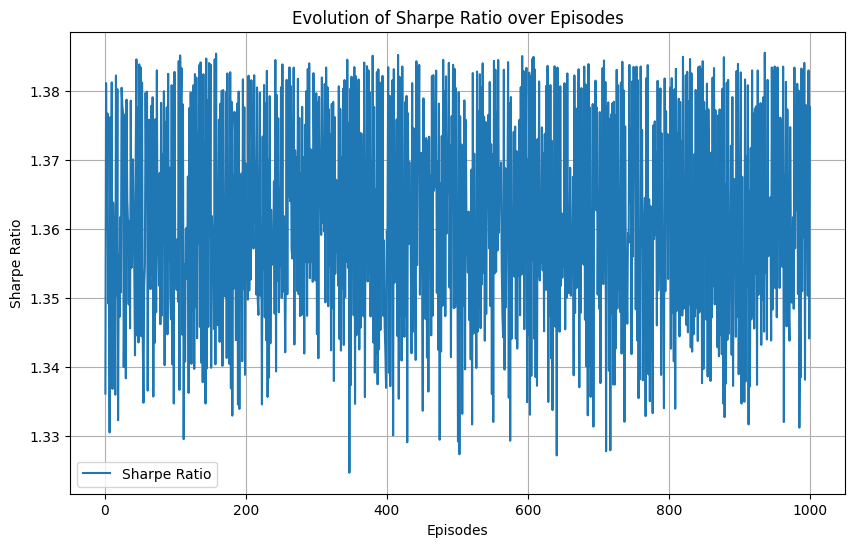

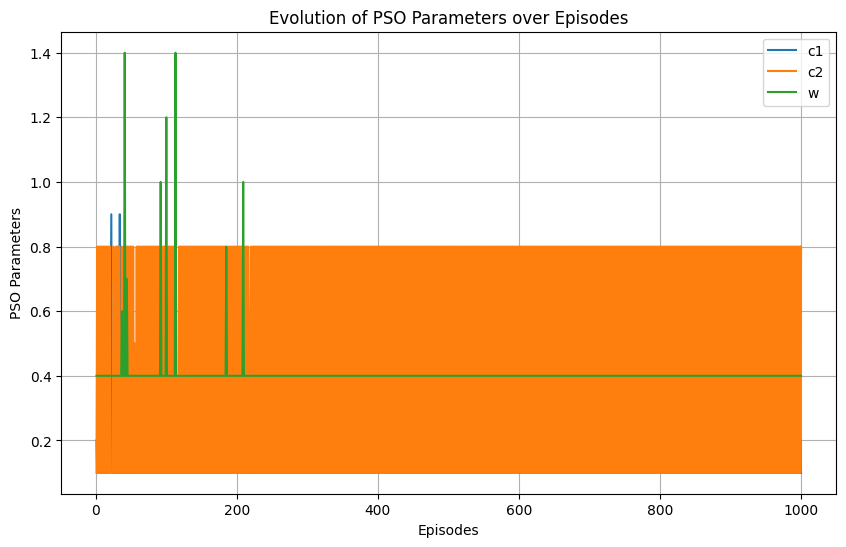

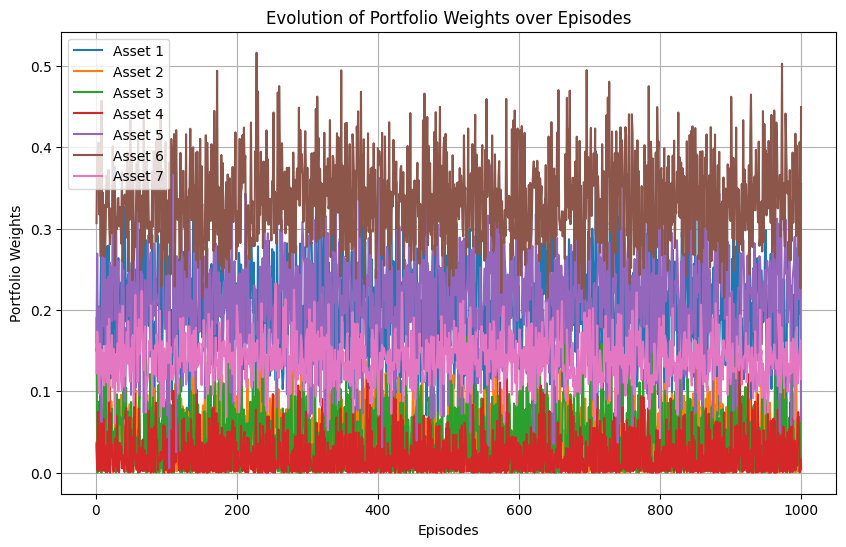

In [23]:
# Imprimir la mejor configuración al final
print("Best Sharpe Ratio:", best_sharpe_ratio)
print("Best Portfolio Weights:", best_portfolio_weights)
print("Best PSO Parameters:", best_pso_params)


# Graficar el Sharpe Ratio a lo largo de los episodios
plt.figure(figsize=(10, 6))
plt.plot(episodes, sharpe_ratios, label='Sharpe Ratio')
plt.xlabel('Episodes')
plt.ylabel('Sharpe Ratio')
plt.title('Evolution of Sharpe Ratio over Episodes')
plt.legend()
plt.grid(True)
plt.show()

# Graficar los parámetros PSO a lo largo de los episodios
plt.figure(figsize=(10, 6))
plt.plot(episodes, c1_values, label='c1')
plt.plot(episodes, c2_values, label='c2')
plt.plot(episodes, w_values, label='w')
plt.xlabel('Episodes')
plt.ylabel('PSO Parameters')
plt.title('Evolution of PSO Parameters over Episodes')
plt.legend()
plt.grid(True)
plt.show()

# Graficar las ponderaciones del portafolio a lo largo de los episodios
plt.figure(figsize=(10, 6))
for i in range(num_assets):
    plt.plot(episodes, portfolio_weights[:, i], label=f'Asset {i+1}')
plt.xlabel('Episodes')
plt.ylabel('Portfolio Weights')
plt.title('Evolution of Portfolio Weights over Episodes')
plt.legend()
plt.grid(True)
plt.show()
